# Drug interaction prediction in *E. coli*
*Author: Vladislav Kim*
* [Introduction](#intro)
* [Compound class stratified validation](#classlockout)
* [Choose thresholds for interactions](#threshclass)
* [Precision-recall and ROC curves](#pr)
* [Probability calibration](#calib)
* [Predictions on the test set](#test)

In [3]:
from sklearn.model_selection import ParameterGrid
# DL has 10 * 10 * 5 * 5 * 5 * 10 * 10 = 2880 combinations of hyperparameters
DL_grid = {"learning_rate_deep": [0.001,0.005,0.01,0.1,1],
             "layers": [1,3,5,7],
             "nodes": [16,32,64,128],
             "dropout": [0.1,0.3,0.5,0.7],
             "steps": [32,64,128],
             "epochs": [400, 600, 800]}
             #"class_weight": {0:1, 1:2, 2:10}
    
pgrid = ParameterGrid(DL_grid)
indices = np.array_split(np.arange(len(pgrid)), 2880)

print(pgrid[10])

{'steps': 64, 'nodes': 128, 'learning_rate_deep': 0.001, 'layers': 1, 'epochs': 400, 'dropout': 0.1}


In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import tensorflow as tf
import numpy as np
import pandas as pd
import sys
import os
import itertools
from sklearn.preprocessing import label_binarize

sys.path.append('..')
import base.chemgen_utils as utl
import MLmod.predictor_modified as prd

<a id="intro"></a> 
## Introduction
It has been previously shown that drug interactions can be predicted in bacteria using chemogenomic data. Here we use random forest classifier on single-compound chemical genetics data in *E. coli* to predict antagonisms, synergies and additive combinations. 

We encode our input predictor matrix as follows: 
+ For each combination load single-compound profiles. Each profile has dimensions `(1 x genes)` and the following possible gene states {-1,0,+1}. Negative drug-gene interaction (-1) implies increased sensitivity in that gene deletion, while positive gene state (+1) indicates decreased sensitivity in that mutant
+ Combination profiles are generaeted based on superposition of individual drug profiles and may take on the following gene states {-2, -1, 0, +1, +2, +/-}
+ We then use one-hot encoding scheme ("dummy variable encoding") before passing the predictor matrix `X` to the classifier

We furthermore subset the data so that only those genes are included that are significantly enriched in antagonisms and synergies based on chi-squared test. This gene list is `interaction-genes-Ecoli`

In [4]:
drugleg_fname = "../data/chemicals/legend_gramnegpos.txt"
gene_subset = '../data/interaction-genes-Ecoli'
gene_subset = pd.read_csv(gene_subset, header=None)[0].values

In [5]:
X_chemgen = pd.read_csv('../data/chemgenetics/nichols_signed.csv', index_col=0)
X_chemgen = X_chemgen.iloc[:,np.where(np.isin(X_chemgen.columns, gene_subset))[0]]
targets = pd.read_csv("../data/chemgenetics/nichols_y.csv")
combs = targets['comb'].values
y = targets['type'].values

X_df = pd.DataFrame([utl.get_comb_feat_signed(X_chemgen, c) for c in combs])

Since we are using `OneVsRestClassifier`, we convert our categorical response variable `y` ("synergy" ,"antagonism", "none") into a `n x 3` binary array using `label_binarize` function

In [6]:
# one vs rest classification
y[y=='none'] = 0
y[y=='antagonism']=1
y[y=='synergy']=2

y=y.astype('int')
y = label_binarize(y, classes=[0, 1, 2])

Encode combination profiles using one-hot encoding scheme:

In [7]:
X_onehot = pd.get_dummies(X_df.astype('category'))

In [8]:
X_onehot.iloc[:6,:12]

ACRA_-2  ACRA_-1  ACRA_0  ACRA_1  ACRA_2  ACRA_3  ACRB_-2  ACRB_-1  ACRB_0  \
0        0        0       1       0       0       0        0        0       0   
1        0        1       0       0       0       0        0        0       0   
2        0        0       1       0       0       0        0        0       0   
3        0        1       0       0       0       0        0        0       0   
4        0        1       0       0       0       0        0        0       0   
5        0        0       1       0       0       0        0        0       0   

   ACRB_1  ACRB_2  ACRB_3  
0       1       0       0  
1       0       0       1  
2       1       0       0  
3       0       0       1  
4       0       0       1  
5       1       0       0

In [9]:
# at least 5 combinations with that variable set
X_onehot = X_onehot.loc[:,(X_onehot.sum(axis=0) > 4)]

We performed grid search to find the best parameters for the `RandomForestClassifier`:

In [10]:
# best parameters when sorted by meanAP_syn, meanAP_antag
#param_dict = {'n_estimators': 200,
# 'min_samples_split': 6,
# 'min_samples_leaf': 2,
# 'max_depth': None,
# 'class_weight': {0: 1, 1: 1}}

In [11]:
# best parameters neural network
param_dict = {'layers': 1,
'dropout': 0.1,
'epochs': 400,
'steps': 64,
'learning_rate_deep': 0.001,
'nodes': 128,
'class_weight': None}# {'steps': 128, 'nodes': 16, 'learning_rate_deep': 0.001, 'layers': 5, 'epochs': 400, 'dropout': 0.7}

<a id="classlockout"></a> 
## Cross Validation
In order to assess the generalization error we generate 20 cross-validation folds by withholding 15 randomly chosen compounds.

In [12]:
'''from sklearn.model_selection import KFold, RepeatedKFold

kf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=1401)
splits = kf.split(X=X_onehot.to_numpy(),y=y)'''

'from sklearn.model_selection import KFold, RepeatedKFold\n\nkf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=1401)\nsplits = kf.split(X=X_onehot.to_numpy(),y=y)'

In [13]:
def generate_train_val(drugs, combs, n_holdout=15):
    val_drugs = np.random.choice(drugs, size=n_holdout)
    
    combs_val = list(itertools.combinations(val_drugs, 2))
    combs_val = [sorted(i) for i in combs_val]
    combs_val = np.array([i[0]+"_"+i[1] for i in combs_val])
    combs_val = np.intersect1d(combs_val, combs)
    combs_train = np.setdiff1d(combs, combs_val)
    
    assert((combs_train.shape[0] + combs_val.shape[0]) == combs.shape[0])
    train = np.where(np.isin(combs, combs_train))[0]
    val = np.where(np.isin(combs, combs_val))[0]
    return (train, val)

In [14]:
np.random.seed(1601)
# drugs in the chemical genetics dataset of E. coli
drugs = np.unique(X_chemgen.index)
# generate CV folds by withholding 15 randomly chosen drugs
splits = [generate_train_val(drugs, combs) for i in range(20)]

In each cross-validation iteration we withhold a random subset of drugs $(n=15)$ and test the trained model on the withheld combinations:

In [15]:
pr = prd.MultiClassPredictions(X=X_onehot.to_numpy(), y=y,
                                   combs=combs,
                                  **param_dict,
                                   clf='neural_network',
                                   top = 30)

In [16]:
pr.crossval_ksplit(splits=splits)

Validation set size in CV fold 1: 102
Epoch 1/400
64/64 [==============================] - 0s 987us/step - loss: 0.7114 - accuracy: 0.6728
Epoch 2/400
64/64 [==============================] - 0s 949us/step - loss: 0.4951 - accuracy: 0.7582
Epoch 3/400
64/64 [==============================] - 0s 788us/step - loss: 0.4989 - accuracy: 0.7816
Epoch 4/400
64/64 [==============================] - 0s 770us/step - loss: 0.4373 - accuracy: 0.7875
Epoch 5/400
64/64 [==============================] - 0s 942us/step - loss: 0.4202 - accuracy: 0.8244
Epoch 6/400
64/64 [==============================] - 0s 829us/step - loss: 0.3932 - accuracy: 0.8407
Epoch 7/400
64/64 [==============================] - 0s 756us/step - loss: 0.3615 - accuracy: 0.8556
Epoch 8/400
64/64 [==============================] - 0s 920us/step - loss: 0.3359 - accuracy: 0.8430
Epoch 9/400
64/64 [==============================] - 0s 785us/step - loss: 0.3767 - accuracy: 0.8391
Epoch 10/400
64/64 [==============================] -

64/64 [==============================] - 0s 863us/step - loss: 0.0087 - accuracy: 0.9982
Epoch 82/400
64/64 [==============================] - 0s 855us/step - loss: 0.0508 - accuracy: 0.9809
Epoch 83/400
64/64 [==============================] - 0s 876us/step - loss: 0.0342 - accuracy: 0.9939
Epoch 84/400
64/64 [==============================] - 0s 934us/step - loss: 0.0458 - accuracy: 0.9731
Epoch 85/400
64/64 [==============================] - 0s 753us/step - loss: 0.0231 - accuracy: 0.9968
Epoch 86/400
64/64 [==============================] - 0s 752us/step - loss: 0.0426 - accuracy: 0.9851
Epoch 87/400
64/64 [==============================] - 0s 731us/step - loss: 0.0081 - accuracy: 1.0000
Epoch 88/400
64/64 [==============================] - 0s 720us/step - loss: 0.0083 - accuracy: 0.9969
Epoch 89/400
64/64 [==============================] - 0s 792us/step - loss: 0.0139 - accuracy: 0.9964
Epoch 90/400
64/64 [==============================] - 0s 940us/step - loss: 0.0637 - accuracy: 

64/64 [==============================] - 0s 823us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 162/400
64/64 [==============================] - 0s 807us/step - loss: 0.0052 - accuracy: 0.9986
Epoch 163/400
64/64 [==============================] - 0s 844us/step - loss: 0.0104 - accuracy: 0.9967
Epoch 164/400
64/64 [==============================] - 0s 823us/step - loss: 0.0234 - accuracy: 0.9885
Epoch 165/400
64/64 [==============================] - 0s 879us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 166/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0049 - accuracy: 0.9994
Epoch 167/400
64/64 [==============================] - 0s 965us/step - loss: 0.0080 - accuracy: 0.9977
Epoch 168/400
64/64 [==============================] - 0s 947us/step - loss: 0.0138 - accuracy: 0.9973
Epoch 169/400
64/64 [==============================] - 0s 959us/step - loss: 0.0100 - accuracy: 0.9969
Epoch 170/400
64/64 [==============================] - 0s 957us/step - loss: 0.0147 - acc

64/64 [==============================] - 0s 889us/step - loss: 0.0045 - accuracy: 0.9983
Epoch 241/400
64/64 [==============================] - 0s 912us/step - loss: 0.0104 - accuracy: 0.9942
Epoch 242/400
64/64 [==============================] - 0s 856us/step - loss: 0.0377 - accuracy: 0.9869
Epoch 243/400
64/64 [==============================] - 0s 885us/step - loss: 0.0554 - accuracy: 0.9882
Epoch 244/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0294 - accuracy: 0.9939
Epoch 245/400
64/64 [==============================] - 0s 930us/step - loss: 0.0020 - accuracy: 0.9993
Epoch 246/400
64/64 [==============================] - 0s 879us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 247/400
64/64 [==============================] - 0s 776us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 248/400
64/64 [==============================] - 0s 737us/step - loss: 0.0011 - accuracy: 0.9999
Epoch 249/400
64/64 [==============================] - 0s 708us/step - loss: 0.0095 - acc

64/64 [==============================] - 0s 852us/step - loss: 0.0194 - accuracy: 0.9880
Epoch 320/400
64/64 [==============================] - 0s 844us/step - loss: 0.0109 - accuracy: 0.9936
Epoch 321/400
64/64 [==============================] - 0s 772us/step - loss: 0.0301 - accuracy: 0.9912
Epoch 322/400
64/64 [==============================] - 0s 718us/step - loss: 0.0138 - accuracy: 0.9976
Epoch 323/400
64/64 [==============================] - 0s 701us/step - loss: 0.0503 - accuracy: 0.9839
Epoch 324/400
64/64 [==============================] - 0s 698us/step - loss: 0.0156 - accuracy: 0.9898
Epoch 325/400
64/64 [==============================] - 0s 682us/step - loss: 0.0197 - accuracy: 0.9943
Epoch 326/400
64/64 [==============================] - 0s 706us/step - loss: 0.0067 - accuracy: 0.9976
Epoch 327/400
64/64 [==============================] - 0s 684us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 328/400
64/64 [==============================] - 0s 703us/step - loss: 0.0012 - a

Epoch 1/400
64/64 [==============================] - 0s 705us/step - loss: 0.6291 - accuracy: 0.7928
Epoch 2/400
64/64 [==============================] - 0s 692us/step - loss: 0.3653 - accuracy: 0.8456
Epoch 3/400
64/64 [==============================] - 0s 839us/step - loss: 0.2860 - accuracy: 0.8944
Epoch 4/400
64/64 [==============================] - 0s 719us/step - loss: 0.3170 - accuracy: 0.8589
Epoch 5/400
64/64 [==============================] - 0s 711us/step - loss: 0.2742 - accuracy: 0.8750
Epoch 6/400
64/64 [==============================] - 0s 696us/step - loss: 0.2649 - accuracy: 0.8782
Epoch 7/400
64/64 [==============================] - 0s 732us/step - loss: 0.2623 - accuracy: 0.8839
Epoch 8/400
64/64 [==============================] - 0s 751us/step - loss: 0.2771 - accuracy: 0.8837
Epoch 9/400
64/64 [==============================] - 0s 711us/step - loss: 0.2217 - accuracy: 0.9200
Epoch 10/400
64/64 [==============================] - 0s 705us/step - loss: 0.2290 - accura

64/64 [==============================] - 0s 694us/step - loss: 0.0068 - accuracy: 0.9975
Epoch 82/400
64/64 [==============================] - 0s 724us/step - loss: 0.0127 - accuracy: 0.9962
Epoch 83/400
64/64 [==============================] - 0s 695us/step - loss: 0.0128 - accuracy: 0.9982
Epoch 84/400
64/64 [==============================] - 0s 705us/step - loss: 0.0412 - accuracy: 0.9842
Epoch 85/400
64/64 [==============================] - 0s 711us/step - loss: 0.0395 - accuracy: 0.9842
Epoch 86/400
64/64 [==============================] - 0s 709us/step - loss: 0.0216 - accuracy: 0.9888
Epoch 87/400
64/64 [==============================] - 0s 694us/step - loss: 0.0047 - accuracy: 1.0000
Epoch 88/400
64/64 [==============================] - 0s 731us/step - loss: 0.0088 - accuracy: 0.9963
Epoch 89/400
64/64 [==============================] - 0s 732us/step - loss: 0.0079 - accuracy: 1.0000
Epoch 90/400
64/64 [==============================] - 0s 701us/step - loss: 0.0077 - accuracy: 

64/64 [==============================] - 0s 736us/step - loss: 0.0161 - accuracy: 0.9957
Epoch 161/400
64/64 [==============================] - 0s 739us/step - loss: 0.0052 - accuracy: 0.9982
Epoch 162/400
64/64 [==============================] - 0s 765us/step - loss: 0.0061 - accuracy: 0.9976
Epoch 163/400
64/64 [==============================] - 0s 755us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 164/400
64/64 [==============================] - 0s 783us/step - loss: 0.0054 - accuracy: 0.9984
Epoch 165/400
64/64 [==============================] - 0s 734us/step - loss: 7.1465e-04 - accuracy: 1.0000
Epoch 166/400
64/64 [==============================] - 0s 706us/step - loss: 0.0107 - accuracy: 0.9955
Epoch 167/400
64/64 [==============================] - 0s 724us/step - loss: 0.0047 - accuracy: 0.9967
Epoch 168/400
64/64 [==============================] - 0s 819us/step - loss: 0.0050 - accuracy: 0.9976
Epoch 169/400
64/64 [==============================] - 0s 747us/step - loss: 0.0111

Epoch 239/400
64/64 [==============================] - 0s 753us/step - loss: 6.0685e-04 - accuracy: 1.0000
Epoch 240/400
64/64 [==============================] - 0s 780us/step - loss: 7.6516e-04 - accuracy: 0.9999
Epoch 241/400
64/64 [==============================] - 0s 838us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 242/400
64/64 [==============================] - 0s 786us/step - loss: 0.0049 - accuracy: 0.9957
Epoch 243/400
64/64 [==============================] - 0s 727us/step - loss: 8.9083e-04 - accuracy: 1.0000
Epoch 244/400
64/64 [==============================] - 0s 729us/step - loss: 0.0014 - accuracy: 0.9999
Epoch 245/400
64/64 [==============================] - 0s 792us/step - loss: 0.0011 - accuracy: 0.9995
Epoch 246/400
64/64 [==============================] - 0s 829us/step - loss: 0.0143 - accuracy: 0.9942
Epoch 247/400
64/64 [==============================] - 0s 826us/step - loss: 0.0224 - accuracy: 0.9907
Epoch 248/400
64/64 [==============================] - 0s 791

64/64 [==============================] - 0s 749us/step - loss: 0.0025 - accuracy: 0.9991
Epoch 318/400
64/64 [==============================] - 0s 814us/step - loss: 4.9896e-04 - accuracy: 1.0000
Epoch 319/400
64/64 [==============================] - 0s 827us/step - loss: 4.2005e-04 - accuracy: 1.0000
Epoch 320/400
64/64 [==============================] - 0s 815us/step - loss: 5.5643e-04 - accuracy: 1.0000
Epoch 321/400
64/64 [==============================] - 0s 754us/step - loss: 9.9301e-04 - accuracy: 1.0000
Epoch 322/400
64/64 [==============================] - 0s 735us/step - loss: 4.0809e-04 - accuracy: 1.0000
Epoch 323/400
64/64 [==============================] - 0s 723us/step - loss: 2.2247e-04 - accuracy: 1.0000
Epoch 324/400
64/64 [==============================] - 0s 717us/step - loss: 5.1348e-04 - accuracy: 1.0000
Epoch 325/400
64/64 [==============================] - 0s 713us/step - loss: 1.3155e-04 - accuracy: 1.0000
Epoch 326/400
64/64 [==============================] - 

64/64 [==============================] - 0s 727us/step - loss: 0.0017 - accuracy: 0.9994
Epoch 1/400
64/64 [==============================] - 0s 1ms/step - loss: 0.5003 - accuracy: 0.8365
Epoch 2/400
64/64 [==============================] - 0s 783us/step - loss: 0.3381 - accuracy: 0.8704
Epoch 3/400
64/64 [==============================] - 0s 697us/step - loss: 0.3234 - accuracy: 0.8799
Epoch 4/400
64/64 [==============================] - 0s 709us/step - loss: 0.2626 - accuracy: 0.9115
Epoch 5/400
64/64 [==============================] - 0s 725us/step - loss: 0.2752 - accuracy: 0.8908
Epoch 6/400
64/64 [==============================] - 0s 816us/step - loss: 0.2276 - accuracy: 0.9061
Epoch 7/400
64/64 [==============================] - 0s 924us/step - loss: 0.2200 - accuracy: 0.9134
Epoch 8/400
64/64 [==============================] - 0s 985us/step - loss: 0.2320 - accuracy: 0.9150
Epoch 9/400
64/64 [==============================] - 0s 938us/step - loss: 0.1718 - accuracy: 0.9405
Epoc

64/64 [==============================] - 0s 844us/step - loss: 0.0105 - accuracy: 0.9975
Epoch 78/400
64/64 [==============================] - 0s 855us/step - loss: 0.0083 - accuracy: 0.9980
Epoch 79/400
64/64 [==============================] - 0s 846us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 80/400
64/64 [==============================] - 0s 840us/step - loss: 0.0043 - accuracy: 0.9979
Epoch 81/400
64/64 [==============================] - 0s 753us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 82/400
64/64 [==============================] - 0s 732us/step - loss: 0.0119 - accuracy: 0.9965
Epoch 83/400
64/64 [==============================] - 0s 728us/step - loss: 0.0090 - accuracy: 0.9961
Epoch 84/400
64/64 [==============================] - 0s 791us/step - loss: 0.0039 - accuracy: 0.9992
Epoch 85/400
64/64 [==============================] - 0s 869us/step - loss: 0.0029 - accuracy: 0.9998
Epoch 86/400
64/64 [==============================] - 0s 833us/step - loss: 0.0025 - accuracy: 

64/64 [==============================] - 0s 1ms/step - loss: 7.0578e-04 - accuracy: 1.0000
Epoch 158/400
64/64 [==============================] - 0s 996us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 159/400
64/64 [==============================] - 0s 949us/step - loss: 0.0056 - accuracy: 0.9986
Epoch 160/400
64/64 [==============================] - 0s 965us/step - loss: 0.0050 - accuracy: 0.9984
Epoch 161/400
64/64 [==============================] - 0s 963us/step - loss: 6.1769e-04 - accuracy: 1.0000
Epoch 162/400
64/64 [==============================] - 0s 843us/step - loss: 7.1606e-04 - accuracy: 1.0000
Epoch 163/400
64/64 [==============================] - 0s 876us/step - loss: 0.0013 - accuracy: 0.9997
Epoch 164/400
64/64 [==============================] - 0s 825us/step - loss: 0.0075 - accuracy: 0.9986
Epoch 165/400
64/64 [==============================] - 0s 847us/step - loss: 0.0104 - accuracy: 0.9926
Epoch 166/400
64/64 [==============================] - 0s 836us/step - loss: 

64/64 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 237/400
64/64 [==============================] - 0s 1ms/step - loss: 7.5817e-04 - accuracy: 1.0000
Epoch 238/400
64/64 [==============================] - 0s 1ms/step - loss: 7.0187e-04 - accuracy: 1.0000
Epoch 239/400
64/64 [==============================] - 0s 1ms/step - loss: 7.2047e-04 - accuracy: 0.9993
Epoch 240/400
64/64 [==============================] - 0s 1ms/step - loss: 5.6950e-04 - accuracy: 1.0000
Epoch 241/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 0.9976
Epoch 242/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 0.9992
Epoch 243/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 244/400
64/64 [==============================] - 0s 887us/step - loss: 0.0034 - accuracy: 0.9985
Epoch 245/400
64/64 [==============================] - 0s 779us/step - loss: 7.6891e-04

64/64 [==============================] - 0s 740us/step - loss: 2.1645e-04 - accuracy: 1.0000
Epoch 315/400
64/64 [==============================] - 0s 779us/step - loss: 1.1994e-04 - accuracy: 1.0000
Epoch 316/400
64/64 [==============================] - 0s 784us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 317/400
64/64 [==============================] - 0s 741us/step - loss: 0.0029 - accuracy: 0.9985
Epoch 318/400
64/64 [==============================] - 0s 733us/step - loss: 3.7270e-04 - accuracy: 1.0000
Epoch 319/400
64/64 [==============================] - 0s 764us/step - loss: 7.4230e-04 - accuracy: 1.0000
Epoch 320/400
64/64 [==============================] - 0s 751us/step - loss: 8.2707e-05 - accuracy: 1.0000
Epoch 321/400
64/64 [==============================] - 0s 865us/step - loss: 4.0613e-04 - accuracy: 1.0000
Epoch 322/400
64/64 [==============================] - 0s 794us/step - loss: 6.3342e-04 - accuracy: 1.0000
Epoch 323/400
64/64 [==============================] - 0s 7

64/64 [==============================] - 0s 756us/step - loss: 2.8377e-04 - accuracy: 1.0000
Epoch 393/400
64/64 [==============================] - 0s 807us/step - loss: 0.0022 - accuracy: 0.9983
Epoch 394/400
64/64 [==============================] - 0s 675us/step - loss: 0.0029 - accuracy: 0.9984
Validation set size in CV fold 2: 65


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/400
64/64 [==============================] - 0s 955us/step - loss: 0.7122 - accuracy: 0.6918
Epoch 2/400
64/64 [==============================] - 0s 848us/step - loss: 0.5061 - accuracy: 0.7577
Epoch 3/400
64/64 [==============================] - 0s 844us/step - loss: 0.4893 - accuracy: 0.7665
Epoch 4/400
64/64 [==============================] - 0s 857us/step - loss: 0.4769 - accuracy: 0.7743
Epoch 5/400
64/64 [==============================] - 0s 840us/step - loss: 0.4685 - accuracy: 0.7800
Epoch 6/400
64/64 [==============================] - 0s 892us/step - loss: 0.5040 - accuracy: 0.7516
Epoch 7/400
64/64 [==============================] - 0s 887us/step - loss: 0.4130 - accuracy: 0.8092
Epoch 8/400
64/64 [==============================] - 0s 861us/step - loss: 0.4045 - accuracy: 0.8121
Epoch 9/400
64/64 [==============================] - 0s 911us/step - loss: 0.3944 - accuracy: 0.8234
Epoch 10/400
64/64 [==============================] - 0s 846us/step - loss: 0.3659 - accura

64/64 [==============================] - 0s 854us/step - loss: 0.0195 - accuracy: 0.9945
Epoch 82/400
64/64 [==============================] - 0s 836us/step - loss: 0.0448 - accuracy: 0.9836
Epoch 83/400
64/64 [==============================] - 0s 819us/step - loss: 0.0479 - accuracy: 0.9819
Epoch 84/400
64/64 [==============================] - 0s 812us/step - loss: 0.0238 - accuracy: 0.9948
Epoch 85/400
64/64 [==============================] - 0s 792us/step - loss: 0.0094 - accuracy: 0.9976
Epoch 86/400
64/64 [==============================] - 0s 772us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 87/400
64/64 [==============================] - 0s 776us/step - loss: 0.0123 - accuracy: 0.9963
Epoch 88/400
64/64 [==============================] - 0s 807us/step - loss: 0.0275 - accuracy: 0.9923
Epoch 89/400
64/64 [==============================] - 0s 812us/step - loss: 0.0198 - accuracy: 0.9942
Epoch 90/400
64/64 [==============================] - 0s 783us/step - loss: 0.0106 - accuracy: 

64/64 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 163/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0074 - accuracy: 0.9964
Epoch 164/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0057 - accuracy: 0.9993
Epoch 165/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0228 - accuracy: 0.9933
Epoch 166/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0075 - accuracy: 0.9980
Epoch 167/400
64/64 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 168/400
64/64 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 0.9978
Epoch 169/400
64/64 [==============================] - 0s 2ms/step - loss: 0.0161 - accuracy: 0.9950
Epoch 170/400
64/64 [==============================] - 0s 2ms/step - loss: 0.0072 - accuracy: 0.9971
Epoch 171/400
64/64 [==============================] - 0s 2ms/step - loss: 0.0074 - accuracy: 0.9984
Epoc

64/64 [==============================] - 0s 1ms/step - loss: 0.0099 - accuracy: 0.9974
Epoch 244/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 0.9997
Epoch 245/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0075 - accuracy: 0.9951
Epoch 246/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0273 - accuracy: 0.9854
Epoch 247/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0070 - accuracy: 0.9979
Epoch 248/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0082 - accuracy: 0.9973
Epoch 249/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0061 - accuracy: 0.9993
Epoch 250/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 0.9985
Epoch 251/400
64/64 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 0.9989
Epoch 252/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000
Epoc

64/64 [==============================] - 0s 1ms/step - loss: 6.1956e-04 - accuracy: 1.0000
Epoch 324/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.9998
Epoch 325/400
64/64 [==============================] - 0s 1ms/step - loss: 4.0947e-04 - accuracy: 0.9998
Epoch 326/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 327/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 0.9961
Epoch 328/400
64/64 [==============================] - 0s 1ms/step - loss: 5.8761e-04 - accuracy: 1.0000
Epoch 329/400
64/64 [==============================] - 0s 1ms/step - loss: 4.0756e-04 - accuracy: 1.0000
Epoch 330/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0183 - accuracy: 0.9927
Epoch 331/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0525 - accuracy: 0.9813
Epoch 332/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0356 - accur

64/64 [==============================] - 0s 1ms/step - loss: 0.1899 - accuracy: 0.9285
Epoch 13/400
64/64 [==============================] - 0s 1ms/step - loss: 0.1616 - accuracy: 0.9320
Epoch 14/400
64/64 [==============================] - 0s 1ms/step - loss: 0.1545 - accuracy: 0.9333
Epoch 15/400
64/64 [==============================] - 0s 1ms/step - loss: 0.1622 - accuracy: 0.9358
Epoch 16/400
64/64 [==============================] - 0s 1ms/step - loss: 0.1217 - accuracy: 0.9511
Epoch 17/400
64/64 [==============================] - 0s 946us/step - loss: 0.1374 - accuracy: 0.9376
Epoch 18/400
64/64 [==============================] - 0s 939us/step - loss: 0.1161 - accuracy: 0.9516
Epoch 19/400
64/64 [==============================] - 0s 916us/step - loss: 0.1111 - accuracy: 0.9592
Epoch 20/400
64/64 [==============================] - 0s 956us/step - loss: 0.0830 - accuracy: 0.9736
Epoch 21/400
64/64 [==============================] - 0s 1ms/step - loss: 0.1074 - accuracy: 0.9581
Epoch

64/64 [==============================] - 0s 865us/step - loss: 0.0068 - accuracy: 0.9991
Epoch 94/400
64/64 [==============================] - 0s 851us/step - loss: 0.0204 - accuracy: 0.9924
Epoch 95/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0135 - accuracy: 0.9974
Epoch 96/400
64/64 [==============================] - 0s 946us/step - loss: 0.0113 - accuracy: 0.9951
Epoch 97/400
64/64 [==============================] - 0s 918us/step - loss: 0.0089 - accuracy: 0.9975
Epoch 98/400
64/64 [==============================] - 0s 899us/step - loss: 0.0112 - accuracy: 0.9942
Epoch 99/400
64/64 [==============================] - 0s 980us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 100/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.9999
Epoch 101/400
64/64 [==============================] - 0s 908us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 102/400
64/64 [==============================] - 0s 915us/step - loss: 0.0050 - accuracy: 0

64/64 [==============================] - 0s 824us/step - loss: 0.0181 - accuracy: 0.9955
Epoch 173/400
64/64 [==============================] - 0s 827us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 174/400
64/64 [==============================] - 0s 809us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 175/400
64/64 [==============================] - 0s 808us/step - loss: 8.6991e-04 - accuracy: 1.0000
Epoch 176/400
64/64 [==============================] - 0s 810us/step - loss: 9.2201e-04 - accuracy: 0.9997
Epoch 177/400
64/64 [==============================] - 0s 833us/step - loss: 0.0017 - accuracy: 0.9992
Epoch 178/400
64/64 [==============================] - 0s 861us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 179/400
64/64 [==============================] - 0s 812us/step - loss: 4.1177e-04 - accuracy: 1.0000
Epoch 180/400
64/64 [==============================] - 0s 819us/step - loss: 3.9912e-04 - accuracy: 1.0000
Epoch 181/400
64/64 [==============================] - 0s 852us/step - 

64/64 [==============================] - 0s 821us/step - loss: 0.0092 - accuracy: 0.9949
Epoch 251/400
64/64 [==============================] - 0s 846us/step - loss: 0.0021 - accuracy: 0.9991
Epoch 252/400
64/64 [==============================] - 0s 726us/step - loss: 0.0530 - accuracy: 0.9940
Epoch 253/400
64/64 [==============================] - 0s 873us/step - loss: 0.0050 - accuracy: 0.9985
Epoch 254/400
64/64 [==============================] - 0s 866us/step - loss: 0.0308 - accuracy: 0.9884
Epoch 255/400
64/64 [==============================] - 0s 844us/step - loss: 0.0015 - accuracy: 0.9994
Epoch 256/400
64/64 [==============================] - 0s 794us/step - loss: 0.0239 - accuracy: 0.9949
Epoch 257/400
64/64 [==============================] - 0s 813us/step - loss: 0.0077 - accuracy: 0.9962
Epoch 258/400
64/64 [==============================] - 0s 763us/step - loss: 0.0320 - accuracy: 0.9861
Epoch 259/400
64/64 [==============================] - 0s 752us/step - loss: 0.0186 - a

Epoch 329/400
64/64 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9951
Epoch 330/400
64/64 [==============================] - 0s 1ms/step - loss: 8.4457e-04 - accuracy: 0.9996
Epoch 331/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0181 - accuracy: 0.9909
Epoch 332/400
64/64 [==============================] - 0s 2ms/step - loss: 0.0395 - accuracy: 0.9936
Epoch 333/400
64/64 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 0.9987
Epoch 334/400
64/64 [==============================] - 0s 1ms/step - loss: 5.7097e-04 - accuracy: 1.0000
Epoch 335/400
64/64 [==============================] - 0s 853us/step - loss: 6.5577e-04 - accuracy: 1.0000
Epoch 336/400
64/64 [==============================] - 0s 843us/step - loss: 0.0027 - accuracy: 0.9989
Epoch 337/400
64/64 [==============================] - 0s 891us/step - loss: 0.0021 - accuracy: 0.9982
Epoch 338/400
64/64 [==============================] - 0s 1ms/step - loss

64/64 [==============================] - 0s 792us/step - loss: 0.1027 - accuracy: 0.9611
Epoch 17/400
64/64 [==============================] - 0s 833us/step - loss: 0.1549 - accuracy: 0.9334
Epoch 18/400
64/64 [==============================] - 0s 815us/step - loss: 0.1039 - accuracy: 0.9659
Epoch 19/400
64/64 [==============================] - 0s 758us/step - loss: 0.1083 - accuracy: 0.9557
Epoch 20/400
64/64 [==============================] - 0s 771us/step - loss: 0.0970 - accuracy: 0.9607
Epoch 21/400
64/64 [==============================] - 0s 761us/step - loss: 0.0890 - accuracy: 0.9653
Epoch 22/400
64/64 [==============================] - 0s 785us/step - loss: 0.0569 - accuracy: 0.9772
Epoch 23/400
64/64 [==============================] - 0s 889us/step - loss: 0.0579 - accuracy: 0.9811
Epoch 24/400
64/64 [==============================] - 0s 841us/step - loss: 0.0626 - accuracy: 0.9866
Epoch 25/400
64/64 [==============================] - 0s 810us/step - loss: 0.0635 - accuracy: 

64/64 [==============================] - 0s 852us/step - loss: 0.0389 - accuracy: 0.9832
Epoch 97/400
64/64 [==============================] - 0s 783us/step - loss: 0.0939 - accuracy: 0.9574
Epoch 98/400
64/64 [==============================] - 0s 809us/step - loss: 0.0288 - accuracy: 0.9916
Epoch 99/400
64/64 [==============================] - 0s 784us/step - loss: 0.0062 - accuracy: 1.0000
Epoch 100/400
64/64 [==============================] - 0s 779us/step - loss: 0.0103 - accuracy: 0.9960
Epoch 101/400
64/64 [==============================] - 0s 823us/step - loss: 0.0251 - accuracy: 0.9953
Epoch 102/400
64/64 [==============================] - 0s 822us/step - loss: 0.0066 - accuracy: 0.9987
Epoch 103/400
64/64 [==============================] - 0s 779us/step - loss: 0.0041 - accuracy: 0.9980
Epoch 104/400
64/64 [==============================] - 0s 771us/step - loss: 0.0025 - accuracy: 0.9990
Epoch 105/400
64/64 [==============================] - 0s 778us/step - loss: 0.0023 - accu

64/64 [==============================] - 0s 820us/step - loss: 0.0200 - accuracy: 0.9927
Epoch 176/400
64/64 [==============================] - 0s 834us/step - loss: 0.0363 - accuracy: 0.9928
Epoch 177/400
64/64 [==============================] - 0s 785us/step - loss: 0.0082 - accuracy: 0.9986
Epoch 178/400
64/64 [==============================] - 0s 748us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 179/400
64/64 [==============================] - 0s 738us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 180/400
64/64 [==============================] - 0s 751us/step - loss: 0.0010 - accuracy: 0.9999
Epoch 181/400
64/64 [==============================] - 0s 760us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 182/400
64/64 [==============================] - 0s 736us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 183/400
64/64 [==============================] - 0s 752us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 184/400
64/64 [==============================] - 0s 843us/step - loss: 0.0054 - a

64/64 [==============================] - 0s 792us/step - loss: 0.0099 - accuracy: 0.9965
Epoch 254/400
64/64 [==============================] - 0s 794us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 255/400
64/64 [==============================] - 0s 820us/step - loss: 0.0035 - accuracy: 0.9976
Epoch 256/400
64/64 [==============================] - 0s 773us/step - loss: 0.0033 - accuracy: 0.9993
Epoch 257/400
64/64 [==============================] - 0s 741us/step - loss: 0.0076 - accuracy: 0.9967
Epoch 258/400
64/64 [==============================] - 0s 762us/step - loss: 0.0073 - accuracy: 0.9984
Epoch 259/400
64/64 [==============================] - 0s 753us/step - loss: 8.4187e-04 - accuracy: 1.0000
Epoch 260/400
64/64 [==============================] - 0s 735us/step - loss: 0.0033 - accuracy: 0.9970
Epoch 261/400
64/64 [==============================] - 0s 746us/step - loss: 4.8937e-04 - accuracy: 1.0000
Epoch 262/400
64/64 [==============================] - 0s 783us/step - loss: 3.

64/64 [==============================] - 0s 857us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 332/400
64/64 [==============================] - 0s 813us/step - loss: 1.3332e-04 - accuracy: 1.0000
Epoch 333/400
64/64 [==============================] - 0s 753us/step - loss: 5.1634e-04 - accuracy: 1.0000
Epoch 334/400
64/64 [==============================] - 0s 728us/step - loss: 2.4653e-04 - accuracy: 1.0000
Epoch 335/400
64/64 [==============================] - 0s 720us/step - loss: 4.7391e-05 - accuracy: 1.0000
Epoch 336/400
64/64 [==============================] - 0s 727us/step - loss: 9.2275e-05 - accuracy: 1.0000
Epoch 337/400
64/64 [==============================] - 0s 774us/step - loss: 9.2720e-04 - accuracy: 1.0000
Epoch 338/400
64/64 [==============================] - 0s 744us/step - loss: 3.0463e-04 - accuracy: 0.9999
Epoch 339/400
64/64 [==============================] - 0s 769us/step - loss: 3.7696e-04 - accuracy: 1.0000
Epoch 340/400
64/64 [==============================] - 

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


64/64 [==============================] - 0s 773us/step - loss: 0.7801 - accuracy: 0.6401
Epoch 2/400
64/64 [==============================] - 0s 737us/step - loss: 0.4994 - accuracy: 0.7718
Epoch 3/400
64/64 [==============================] - 0s 852us/step - loss: 0.4947 - accuracy: 0.7786
Epoch 4/400
64/64 [==============================] - 0s 816us/step - loss: 0.4324 - accuracy: 0.8004
Epoch 5/400
64/64 [==============================] - 0s 770us/step - loss: 0.4454 - accuracy: 0.7841
Epoch 6/400
64/64 [==============================] - 0s 754us/step - loss: 0.4205 - accuracy: 0.8089
Epoch 7/400
64/64 [==============================] - 0s 767us/step - loss: 0.4053 - accuracy: 0.8153
Epoch 8/400
64/64 [==============================] - 0s 753us/step - loss: 0.3977 - accuracy: 0.8202
Epoch 9/400
64/64 [==============================] - 0s 760us/step - loss: 0.4022 - accuracy: 0.8250
Epoch 10/400
64/64 [==============================] - 0s 771us/step - loss: 0.3704 - accuracy: 0.8332
E

64/64 [==============================] - 0s 864us/step - loss: 0.0180 - accuracy: 0.9938
Epoch 82/400
64/64 [==============================] - 0s 875us/step - loss: 0.0616 - accuracy: 0.9760
Epoch 83/400
64/64 [==============================] - 0s 829us/step - loss: 0.0733 - accuracy: 0.9728
Epoch 84/400
64/64 [==============================] - 0s 946us/step - loss: 0.0154 - accuracy: 0.9996
Epoch 85/400
64/64 [==============================] - 0s 867us/step - loss: 0.0177 - accuracy: 0.9956
Epoch 86/400
64/64 [==============================] - 0s 862us/step - loss: 0.0343 - accuracy: 0.9903
Epoch 87/400
64/64 [==============================] - 0s 815us/step - loss: 0.0508 - accuracy: 0.9767
Epoch 88/400
64/64 [==============================] - 0s 937us/step - loss: 0.0199 - accuracy: 0.9938
Epoch 89/400
64/64 [==============================] - 0s 813us/step - loss: 0.0115 - accuracy: 0.9991
Epoch 90/400
64/64 [==============================] - 0s 751us/step - loss: 0.0426 - accuracy: 

64/64 [==============================] - 0s 745us/step - loss: 0.0531 - accuracy: 0.9774
Epoch 161/400
64/64 [==============================] - 0s 778us/step - loss: 0.0203 - accuracy: 0.9939
Epoch 162/400
64/64 [==============================] - 0s 755us/step - loss: 0.0188 - accuracy: 0.9947
Epoch 163/400
64/64 [==============================] - 0s 753us/step - loss: 0.0079 - accuracy: 1.0000
Epoch 164/400
64/64 [==============================] - 0s 749us/step - loss: 0.0036 - accuracy: 0.9998
Epoch 165/400
64/64 [==============================] - 0s 727us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 166/400
64/64 [==============================] - 0s 725us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 167/400
64/64 [==============================] - 0s 781us/step - loss: 0.0085 - accuracy: 0.9964
Epoch 168/400
64/64 [==============================] - 0s 763us/step - loss: 0.0352 - accuracy: 0.9879
Epoch 169/400
64/64 [==============================] - 0s 733us/step - loss: 0.0263 - a

64/64 [==============================] - 0s 812us/step - loss: 0.0035 - accuracy: 0.9999
Epoch 240/400
64/64 [==============================] - 0s 780us/step - loss: 0.0038 - accuracy: 0.9987
Epoch 241/400
64/64 [==============================] - 0s 783us/step - loss: 0.0033 - accuracy: 0.9997
Epoch 242/400
64/64 [==============================] - 0s 742us/step - loss: 0.0159 - accuracy: 0.9957
Epoch 243/400
64/64 [==============================] - 0s 775us/step - loss: 0.0102 - accuracy: 0.9958
Epoch 244/400
64/64 [==============================] - 0s 718us/step - loss: 0.0665 - accuracy: 0.9827
Epoch 245/400
64/64 [==============================] - 0s 762us/step - loss: 0.0062 - accuracy: 0.9996
Epoch 246/400
64/64 [==============================] - 0s 826us/step - loss: 0.0028 - accuracy: 0.9986
Epoch 247/400
64/64 [==============================] - 0s 774us/step - loss: 0.0200 - accuracy: 0.9926
Epoch 248/400
64/64 [==============================] - 0s 831us/step - loss: 0.0040 - a

64/64 [==============================] - 0s 758us/step - loss: 0.0015 - accuracy: 0.9998
Epoch 319/400
64/64 [==============================] - 0s 852us/step - loss: 0.0089 - accuracy: 0.9982
Epoch 320/400
64/64 [==============================] - 0s 814us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 321/400
64/64 [==============================] - 0s 782us/step - loss: 0.0062 - accuracy: 0.9983
Epoch 322/400
64/64 [==============================] - 0s 945us/step - loss: 0.0071 - accuracy: 0.9976
Epoch 323/400
64/64 [==============================] - 0s 867us/step - loss: 0.0027 - accuracy: 0.9995
Epoch 324/400
64/64 [==============================] - 0s 986us/step - loss: 0.0050 - accuracy: 0.9983
Epoch 325/400
64/64 [==============================] - 0s 870us/step - loss: 4.5908e-04 - accuracy: 1.0000
Epoch 326/400
64/64 [==============================] - 0s 812us/step - loss: 0.0079 - accuracy: 0.9947
Epoch 327/400
64/64 [==============================] - 0s 844us/step - loss: 0.0054

64/64 [==============================] - 0s 785us/step - loss: 0.0143 - accuracy: 0.9973
Epoch 398/400
64/64 [==============================] - 0s 853us/step - loss: 0.0140 - accuracy: 0.9938
Epoch 399/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0904 - accuracy: 0.9749
Epoch 400/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0218 - accuracy: 0.9869
Epoch 1/400
64/64 [==============================] - 0s 995us/step - loss: 0.6101 - accuracy: 0.7512
Epoch 2/400
64/64 [==============================] - 0s 926us/step - loss: 0.3181 - accuracy: 0.8658
Epoch 3/400
64/64 [==============================] - 0s 843us/step - loss: 0.3157 - accuracy: 0.8736
Epoch 4/400
64/64 [==============================] - 0s 829us/step - loss: 0.3104 - accuracy: 0.8746
Epoch 5/400
64/64 [==============================] - 0s 782us/step - loss: 0.2704 - accuracy: 0.8766
Epoch 6/400
64/64 [==============================] - 0s 832us/step - loss: 0.2904 - accuracy: 0.8867


64/64 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 78/400
64/64 [==============================] - 0s 878us/step - loss: 0.0025 - accuracy: 0.9998
Epoch 79/400
64/64 [==============================] - 0s 911us/step - loss: 0.0432 - accuracy: 0.9891
Epoch 80/400
64/64 [==============================] - 0s 883us/step - loss: 0.0321 - accuracy: 0.9880
Epoch 81/400
64/64 [==============================] - 0s 860us/step - loss: 0.0239 - accuracy: 0.9923
Epoch 82/400
64/64 [==============================] - 0s 900us/step - loss: 0.0145 - accuracy: 0.9975
Epoch 83/400
64/64 [==============================] - 0s 901us/step - loss: 0.0056 - accuracy: 0.9982
Epoch 84/400
64/64 [==============================] - 0s 858us/step - loss: 0.0055 - accuracy: 1.0000
Epoch 85/400
64/64 [==============================] - 0s 918us/step - loss: 0.0105 - accuracy: 0.9967
Epoch 86/400
64/64 [==============================] - 0s 903us/step - loss: 0.0135 - accuracy: 0.

64/64 [==============================] - 0s 977us/step - loss: 0.0092 - accuracy: 0.9970
Epoch 157/400
64/64 [==============================] - 0s 935us/step - loss: 0.0183 - accuracy: 0.9934
Epoch 158/400
64/64 [==============================] - 0s 905us/step - loss: 0.0138 - accuracy: 0.9962
Epoch 159/400
64/64 [==============================] - 0s 846us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 160/400
64/64 [==============================] - 0s 986us/step - loss: 0.0013 - accuracy: 0.9999
Epoch 161/400
64/64 [==============================] - 0s 892us/step - loss: 0.0044 - accuracy: 1.0000
Epoch 162/400
64/64 [==============================] - 0s 939us/step - loss: 0.0055 - accuracy: 0.9977
Epoch 163/400
64/64 [==============================] - 0s 914us/step - loss: 0.0172 - accuracy: 0.9948
Epoch 164/400
64/64 [==============================] - 0s 892us/step - loss: 0.0031 - accuracy: 0.9998
Epoch 165/400
64/64 [==============================] - 0s 911us/step - loss: 0.0028 - a

64/64 [==============================] - 0s 838us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 235/400
64/64 [==============================] - 0s 837us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 236/400
64/64 [==============================] - 0s 849us/step - loss: 5.4976e-04 - accuracy: 1.0000
Epoch 237/400
64/64 [==============================] - 0s 985us/step - loss: 0.0136 - accuracy: 0.9945
Epoch 238/400
64/64 [==============================] - 0s 934us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 239/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 0.9990
Epoch 240/400
64/64 [==============================] - 0s 943us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 241/400
64/64 [==============================] - 0s 884us/step - loss: 0.0064 - accuracy: 0.9982
Epoch 242/400
64/64 [==============================] - 0s 924us/step - loss: 0.0035 - accuracy: 0.9988
Epoch 243/400
64/64 [==============================] - 0s 869us/step - loss: 0.0037 -

64/64 [==============================] - 0s 870us/step - loss: 0.0293 - accuracy: 0.9928
Epoch 313/400
64/64 [==============================] - 0s 982us/step - loss: 6.5747e-04 - accuracy: 1.0000
Epoch 314/400
64/64 [==============================] - 0s 911us/step - loss: 0.0031 - accuracy: 0.9997
Epoch 315/400
64/64 [==============================] - 0s 902us/step - loss: 0.0037 - accuracy: 0.9987
Epoch 316/400
64/64 [==============================] - 0s 887us/step - loss: 0.0014 - accuracy: 0.9992
Epoch 317/400
64/64 [==============================] - 0s 938us/step - loss: 4.0601e-04 - accuracy: 1.0000
Epoch 318/400
64/64 [==============================] - 0s 950us/step - loss: 6.2501e-04 - accuracy: 1.0000
Epoch 319/400
64/64 [==============================] - 0s 850us/step - loss: 1.2069e-04 - accuracy: 1.0000
Epoch 320/400
64/64 [==============================] - 0s 895us/step - loss: 8.7339e-04 - accuracy: 1.0000
Epoch 321/400
64/64 [==============================] - 0s 865us/ste

64/64 [==============================] - 0s 767us/step - loss: 0.0019 - accuracy: 0.9994
Epoch 391/400
64/64 [==============================] - 0s 867us/step - loss: 0.0029 - accuracy: 0.9984
Epoch 392/400
64/64 [==============================] - 0s 938us/step - loss: 0.0014 - accuracy: 0.9998
Epoch 393/400
64/64 [==============================] - 0s 2ms/step - loss: 0.0117 - accuracy: 0.9958
Epoch 394/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0052 - accuracy: 0.9957
Epoch 395/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 396/400
64/64 [==============================] - 0s 887us/step - loss: 1.2221e-04 - accuracy: 1.0000
Epoch 397/400
64/64 [==============================] - 0s 913us/step - loss: 7.2450e-05 - accuracy: 1.0000
Epoch 398/400
64/64 [==============================] - 0s 884us/step - loss: 7.9241e-04 - accuracy: 1.0000
Epoch 399/400
64/64 [==============================] - 0s 870us/step - loss: 8.21

64/64 [==============================] - 0s 967us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 71/400
64/64 [==============================] - 0s 883us/step - loss: 0.0031 - accuracy: 0.9988
Epoch 72/400
64/64 [==============================] - 0s 829us/step - loss: 0.0057 - accuracy: 0.9981
Epoch 73/400
64/64 [==============================] - 0s 871us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 74/400
64/64 [==============================] - 0s 861us/step - loss: 0.0083 - accuracy: 0.9993
Epoch 75/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0167 - accuracy: 0.9928
Epoch 76/400
64/64 [==============================] - 0s 991us/step - loss: 0.0293 - accuracy: 0.9896
Epoch 77/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0327 - accuracy: 0.9872
Epoch 78/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0152 - accuracy: 0.9953
Epoch 79/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0202 - accuracy: 0.9914
E

64/64 [==============================] - 0s 1ms/step - loss: 5.4735e-04 - accuracy: 1.0000
Epoch 151/400
64/64 [==============================] - 0s 1ms/step - loss: 6.3987e-04 - accuracy: 1.0000
Epoch 152/400
64/64 [==============================] - 0s 914us/step - loss: 0.0092 - accuracy: 0.9944
Epoch 153/400
64/64 [==============================] - 0s 998us/step - loss: 0.0232 - accuracy: 0.9918
Epoch 154/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0090 - accuracy: 0.9970
Epoch 155/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0294 - accuracy: 0.9966
Epoch 156/400
64/64 [==============================] - 0s 995us/step - loss: 0.0112 - accuracy: 0.9960
Epoch 157/400
64/64 [==============================] - 0s 999us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 158/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0159 - accuracy: 0.9971
Epoch 159/400
64/64 [==============================] - 0s 967us/step - loss: 0.0473 - acc

64/64 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 0.9992
Epoch 229/400
64/64 [==============================] - 0s 913us/step - loss: 0.0244 - accuracy: 0.9931
Epoch 230/400
64/64 [==============================] - 0s 864us/step - loss: 0.0257 - accuracy: 0.9950
Epoch 231/400
64/64 [==============================] - 0s 855us/step - loss: 0.0059 - accuracy: 0.9989
Epoch 232/400
64/64 [==============================] - 0s 829us/step - loss: 0.0057 - accuracy: 0.9978
Epoch 233/400
64/64 [==============================] - 0s 847us/step - loss: 0.0055 - accuracy: 0.9956
Epoch 234/400
64/64 [==============================] - 0s 846us/step - loss: 0.0033 - accuracy: 0.9985
Epoch 235/400
64/64 [==============================] - 0s 876us/step - loss: 5.1483e-04 - accuracy: 1.0000
Epoch 236/400
64/64 [==============================] - 0s 875us/step - loss: 1.1600e-04 - accuracy: 1.0000
Epoch 237/400
64/64 [==============================] - 0s 856us/step - loss: 0.00

64/64 [==============================] - 0s 884us/step - loss: 5.5885e-04 - accuracy: 1.0000
Epoch 307/400
64/64 [==============================] - 0s 902us/step - loss: 6.0085e-04 - accuracy: 1.0000
Epoch 308/400
64/64 [==============================] - 0s 1ms/step - loss: 1.8455e-04 - accuracy: 1.0000
Epoch 309/400
64/64 [==============================] - 0s 978us/step - loss: 0.0026 - accuracy: 0.9998
Epoch 310/400
64/64 [==============================] - 0s 781us/step - loss: 0.0015 - accuracy: 0.9999
Epoch 311/400
64/64 [==============================] - 0s 853us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 312/400
64/64 [==============================] - 0s 770us/step - loss: 1.1528e-04 - accuracy: 1.0000
Epoch 313/400
64/64 [==============================] - 0s 768us/step - loss: 3.0360e-04 - accuracy: 1.0000
Epoch 314/400
64/64 [==============================] - 0s 829us/step - loss: 2.0002e-04 - accuracy: 1.0000
Epoch 315/400
64/64 [==============================] - 0s 1ms/ste

64/64 [==============================] - 0s 687us/step - loss: 6.1581e-05 - accuracy: 1.0000
Epoch 385/400
64/64 [==============================] - 0s 703us/step - loss: 5.6388e-04 - accuracy: 1.0000
Epoch 386/400
64/64 [==============================] - 0s 701us/step - loss: 3.2617e-04 - accuracy: 1.0000
Epoch 387/400
64/64 [==============================] - 0s 739us/step - loss: 4.0170e-04 - accuracy: 1.0000
Epoch 388/400
64/64 [==============================] - 0s 933us/step - loss: 6.6424e-04 - accuracy: 1.0000
Epoch 389/400
64/64 [==============================] - 0s 754us/step - loss: 6.1168e-04 - accuracy: 1.0000
Epoch 390/400
64/64 [==============================] - 0s 788us/step - loss: 1.6366e-04 - accuracy: 1.0000
Epoch 391/400
64/64 [==============================] - 0s 751us/step - loss: 6.9521e-05 - accuracy: 1.0000
Epoch 392/400
64/64 [==============================] - 0s 683us/step - loss: 3.0111e-05 - accuracy: 1.0000
Epoch 393/400
64/64 [==============================

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/400
64/64 [==============================] - 0s 883us/step - loss: 0.6667 - accuracy: 0.6851
Epoch 2/400
64/64 [==============================] - 0s 843us/step - loss: 0.5234 - accuracy: 0.7498
Epoch 3/400
64/64 [==============================] - 0s 852us/step - loss: 0.4875 - accuracy: 0.7533
Epoch 4/400
64/64 [==============================] - 0s 782us/step - loss: 0.4243 - accuracy: 0.8198
Epoch 5/400
64/64 [==============================] - 0s 1ms/step - loss: 0.4336 - accuracy: 0.8038
Epoch 6/400
64/64 [==============================] - 0s 837us/step - loss: 0.4111 - accuracy: 0.8067
Epoch 7/400
64/64 [==============================] - 0s 756us/step - loss: 0.3927 - accuracy: 0.8261
Epoch 8/400
64/64 [==============================] - 0s 733us/step - loss: 0.3558 - accuracy: 0.8483
Epoch 9/400
64/64 [==============================] - 0s 844us/step - loss: 0.3314 - accuracy: 0.8716
Epoch 10/400
64/64 [==============================] - 0s 767us/step - loss: 0.3497 - accuracy

64/64 [==============================] - 0s 731us/step - loss: 0.0156 - accuracy: 0.9964
Epoch 82/400
64/64 [==============================] - 0s 679us/step - loss: 0.0222 - accuracy: 0.9911
Epoch 83/400
64/64 [==============================] - 0s 695us/step - loss: 0.0109 - accuracy: 0.9998
Epoch 84/400
64/64 [==============================] - 0s 729us/step - loss: 0.0209 - accuracy: 0.9955
Epoch 85/400
64/64 [==============================] - 0s 710us/step - loss: 0.0361 - accuracy: 0.9845
Epoch 86/400
64/64 [==============================] - 0s 717us/step - loss: 0.0252 - accuracy: 0.9898
Epoch 87/400
64/64 [==============================] - 0s 671us/step - loss: 0.0374 - accuracy: 0.9885
Epoch 88/400
64/64 [==============================] - 0s 689us/step - loss: 0.0215 - accuracy: 0.9931
Epoch 89/400
64/64 [==============================] - 0s 718us/step - loss: 0.0290 - accuracy: 0.9918
Epoch 90/400
64/64 [==============================] - 0s 722us/step - loss: 0.0216 - accuracy: 

64/64 [==============================] - 0s 699us/step - loss: 0.0033 - accuracy: 0.9999
Epoch 161/400
64/64 [==============================] - 0s 734us/step - loss: 0.0059 - accuracy: 0.9979
Epoch 162/400
64/64 [==============================] - 0s 698us/step - loss: 0.0045 - accuracy: 0.9996
Epoch 163/400
64/64 [==============================] - 0s 714us/step - loss: 0.0053 - accuracy: 0.9980
Epoch 164/400
64/64 [==============================] - 0s 719us/step - loss: 0.0047 - accuracy: 0.9984
Epoch 165/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 0.9994
Epoch 166/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0123 - accuracy: 0.9956
Epoch 167/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0062 - accuracy: 0.9988
Epoch 168/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 0.9999
Epoch 169/400
64/64 [==============================] - 0s 882us/step - loss: 0.0299 - accuracy:

64/64 [==============================] - 0s 816us/step - loss: 0.0168 - accuracy: 0.9938
Epoch 240/400
64/64 [==============================] - 0s 828us/step - loss: 0.0228 - accuracy: 0.9902
Epoch 241/400
64/64 [==============================] - 0s 785us/step - loss: 0.0048 - accuracy: 0.9996
Epoch 242/400
64/64 [==============================] - 0s 747us/step - loss: 0.0317 - accuracy: 0.9929
Epoch 243/400
64/64 [==============================] - 0s 733us/step - loss: 0.0214 - accuracy: 0.9876
Epoch 244/400
64/64 [==============================] - 0s 795us/step - loss: 0.0055 - accuracy: 1.0000
Epoch 245/400
64/64 [==============================] - 0s 810us/step - loss: 0.0101 - accuracy: 0.9937
Epoch 246/400
64/64 [==============================] - 0s 736us/step - loss: 4.9440e-04 - accuracy: 1.0000
Epoch 247/400
64/64 [==============================] - 0s 915us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 248/400
64/64 [==============================] - 0s 783us/step - loss: 0.0011

64/64 [==============================] - 0s 880us/step - loss: 0.0179 - accuracy: 0.9948
Epoch 319/400
64/64 [==============================] - 0s 974us/step - loss: 0.0257 - accuracy: 0.9951
Epoch 320/400
64/64 [==============================] - 0s 760us/step - loss: 0.0129 - accuracy: 0.9973
Epoch 321/400
64/64 [==============================] - 0s 707us/step - loss: 0.0080 - accuracy: 0.9978
Epoch 322/400
64/64 [==============================] - 0s 683us/step - loss: 0.0056 - accuracy: 0.9979
Epoch 323/400
64/64 [==============================] - 0s 670us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 324/400
64/64 [==============================] - 0s 678us/step - loss: 0.0113 - accuracy: 0.9970
Epoch 325/400
64/64 [==============================] - 0s 680us/step - loss: 0.0132 - accuracy: 0.9961
Epoch 326/400
64/64 [==============================] - 0s 713us/step - loss: 0.0031 - accuracy: 0.9982
Epoch 327/400
64/64 [==============================] - 0s 762us/step - loss: 0.0024 - a

64/64 [==============================] - 0s 693us/step - loss: 0.3192 - accuracy: 0.8715
Epoch 6/400
64/64 [==============================] - 0s 683us/step - loss: 0.2885 - accuracy: 0.8675
Epoch 7/400
64/64 [==============================] - 0s 811us/step - loss: 0.2696 - accuracy: 0.8836
Epoch 8/400
64/64 [==============================] - 0s 781us/step - loss: 0.2421 - accuracy: 0.8994
Epoch 9/400
64/64 [==============================] - 0s 726us/step - loss: 0.2294 - accuracy: 0.8949
Epoch 10/400
64/64 [==============================] - 0s 826us/step - loss: 0.2233 - accuracy: 0.8956
Epoch 11/400
64/64 [==============================] - 0s 773us/step - loss: 0.1955 - accuracy: 0.9188
Epoch 12/400
64/64 [==============================] - 0s 707us/step - loss: 0.2022 - accuracy: 0.9218
Epoch 13/400
64/64 [==============================] - 0s 684us/step - loss: 0.2161 - accuracy: 0.9020
Epoch 14/400
64/64 [==============================] - 0s 842us/step - loss: 0.1976 - accuracy: 0.92

64/64 [==============================] - 0s 773us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 86/400
64/64 [==============================] - 0s 947us/step - loss: 0.0039 - accuracy: 0.9990
Epoch 87/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0066 - accuracy: 0.9994
Epoch 88/400
64/64 [==============================] - 0s 899us/step - loss: 0.0111 - accuracy: 0.9969
Epoch 89/400
64/64 [==============================] - 0s 769us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 90/400
64/64 [==============================] - 0s 685us/step - loss: 0.0035 - accuracy: 0.9992
Epoch 91/400
64/64 [==============================] - 0s 685us/step - loss: 0.0121 - accuracy: 0.9960
Epoch 92/400
64/64 [==============================] - 0s 785us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 93/400
64/64 [==============================] - 0s 756us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 94/400
64/64 [==============================] - 0s 698us/step - loss: 0.0046 - accuracy: 1.

64/64 [==============================] - 0s 666us/step - loss: 0.0122 - accuracy: 0.9939
Epoch 165/400
64/64 [==============================] - 0s 674us/step - loss: 0.0053 - accuracy: 0.9993
Epoch 166/400
64/64 [==============================] - 0s 690us/step - loss: 0.0090 - accuracy: 0.9968
Epoch 167/400
64/64 [==============================] - 0s 689us/step - loss: 0.0134 - accuracy: 0.9923
Epoch 168/400
64/64 [==============================] - 0s 664us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 169/400
64/64 [==============================] - 0s 680us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 170/400
64/64 [==============================] - 0s 686us/step - loss: 0.0011 - accuracy: 0.9995
Epoch 171/400
64/64 [==============================] - 0s 706us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 172/400
64/64 [==============================] - 0s 698us/step - loss: 0.0056 - accuracy: 0.9983
Epoch 173/400
64/64 [==============================] - 0s 906us/step - loss: 0.0023 - a

64/64 [==============================] - 0s 813us/step - loss: 1.2978e-04 - accuracy: 1.0000
Epoch 244/400
64/64 [==============================] - 0s 716us/step - loss: 0.0022 - accuracy: 0.9991
Epoch 245/400
64/64 [==============================] - 0s 722us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 246/400
64/64 [==============================] - 0s 694us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 247/400
64/64 [==============================] - 0s 730us/step - loss: 0.0030 - accuracy: 0.9995
Epoch 248/400
64/64 [==============================] - 0s 722us/step - loss: 0.0063 - accuracy: 0.9992
Epoch 249/400
64/64 [==============================] - 0s 770us/step - loss: 0.0026 - accuracy: 0.9992
Epoch 250/400
64/64 [==============================] - 0s 849us/step - loss: 0.0010 - accuracy: 0.9998
Epoch 251/400
64/64 [==============================] - 0s 838us/step - loss: 0.0053 - accuracy: 0.9982
Epoch 252/400
64/64 [==============================] - 0s 746us/step - loss: 0.0015

64/64 [==============================] - 0s 721us/step - loss: 0.0067 - accuracy: 0.9981
Epoch 322/400
64/64 [==============================] - 0s 673us/step - loss: 0.0235 - accuracy: 0.9940
Epoch 323/400
64/64 [==============================] - 0s 682us/step - loss: 0.0128 - accuracy: 0.9968
Epoch 324/400
64/64 [==============================] - 0s 695us/step - loss: 0.0099 - accuracy: 0.9952
Epoch 325/400
64/64 [==============================] - 0s 721us/step - loss: 0.0175 - accuracy: 0.9942
Epoch 326/400
64/64 [==============================] - 0s 763us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 327/400
64/64 [==============================] - 0s 782us/step - loss: 5.9783e-04 - accuracy: 1.0000
Epoch 328/400
64/64 [==============================] - 0s 779us/step - loss: 0.0025 - accuracy: 0.9991
Epoch 329/400
64/64 [==============================] - 0s 740us/step - loss: 0.0024 - accuracy: 0.9998
Epoch 330/400
64/64 [==============================] - 0s 747us/step - loss: 0.0011

64/64 [==============================] - 0s 699us/step - loss: 0.2043 - accuracy: 0.9138
Epoch 9/400
64/64 [==============================] - 0s 938us/step - loss: 0.2120 - accuracy: 0.9112
Epoch 10/400
64/64 [==============================] - 0s 826us/step - loss: 0.1859 - accuracy: 0.9432
Epoch 11/400
64/64 [==============================] - 0s 894us/step - loss: 0.1734 - accuracy: 0.9303
Epoch 12/400
64/64 [==============================] - 0s 837us/step - loss: 0.1841 - accuracy: 0.9368
Epoch 13/400
64/64 [==============================] - 0s 782us/step - loss: 0.1415 - accuracy: 0.9559
Epoch 14/400
64/64 [==============================] - 0s 997us/step - loss: 0.1524 - accuracy: 0.9462
Epoch 15/400
64/64 [==============================] - 0s 1ms/step - loss: 0.1356 - accuracy: 0.9545
Epoch 16/400
64/64 [==============================] - 0s 950us/step - loss: 0.0992 - accuracy: 0.9602
Epoch 17/400
64/64 [==============================] - 0s 735us/step - loss: 0.1042 - accuracy: 0.9

64/64 [==============================] - 0s 689us/step - loss: 0.0226 - accuracy: 0.9924
Epoch 89/400
64/64 [==============================] - 0s 691us/step - loss: 0.0050 - accuracy: 0.9992
Epoch 90/400
64/64 [==============================] - 0s 681us/step - loss: 0.0036 - accuracy: 0.9982
Epoch 91/400
64/64 [==============================] - 0s 675us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 92/400
64/64 [==============================] - 0s 691us/step - loss: 0.0026 - accuracy: 0.9995
Epoch 93/400
64/64 [==============================] - 0s 781us/step - loss: 0.0284 - accuracy: 0.9907
Epoch 94/400
64/64 [==============================] - 0s 817us/step - loss: 0.0032 - accuracy: 0.9999
Epoch 95/400
64/64 [==============================] - 0s 758us/step - loss: 0.0277 - accuracy: 0.9866
Epoch 96/400
64/64 [==============================] - 0s 766us/step - loss: 0.0037 - accuracy: 1.0000
Epoch 97/400
64/64 [==============================] - 0s 736us/step - loss: 0.0023 - accuracy: 

64/64 [==============================] - 0s 753us/step - loss: 0.0024 - accuracy: 0.9991
Epoch 168/400
64/64 [==============================] - 0s 827us/step - loss: 0.0028 - accuracy: 0.9995
Epoch 169/400
64/64 [==============================] - 0s 780us/step - loss: 0.0049 - accuracy: 0.9984
Epoch 170/400
64/64 [==============================] - 0s 715us/step - loss: 0.0116 - accuracy: 0.9989
Epoch 171/400
64/64 [==============================] - 0s 713us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 172/400
64/64 [==============================] - 0s 751us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 173/400
64/64 [==============================] - 0s 784us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 174/400
64/64 [==============================] - 0s 760us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 175/400
64/64 [==============================] - 0s 895us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 176/400
64/64 [==============================] - 0s 899us/step - loss: 0.0165 - a

64/64 [==============================] - 0s 903us/step - loss: 0.0033 - accuracy: 0.9975
Epoch 247/400
64/64 [==============================] - 0s 806us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 248/400
64/64 [==============================] - 0s 853us/step - loss: 0.0050 - accuracy: 0.9981
Epoch 249/400
64/64 [==============================] - 0s 833us/step - loss: 0.0070 - accuracy: 0.9969
Epoch 250/400
64/64 [==============================] - 0s 857us/step - loss: 0.0058 - accuracy: 0.9955
Epoch 251/400
64/64 [==============================] - 0s 836us/step - loss: 0.0037 - accuracy: 0.9989
Epoch 252/400
64/64 [==============================] - 0s 1000us/step - loss: 0.0053 - accuracy: 0.9963
Epoch 253/400
64/64 [==============================] - 0s 908us/step - loss: 0.0026 - accuracy: 0.9980
Epoch 254/400
64/64 [==============================] - 0s 850us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 255/400
64/64 [==============================] - 0s 860us/step - loss: 9.8640e-0

64/64 [==============================] - 0s 783us/step - loss: 9.3616e-04 - accuracy: 1.0000
Epoch 325/400
64/64 [==============================] - 0s 733us/step - loss: 5.6028e-04 - accuracy: 1.0000
Epoch 326/400
64/64 [==============================] - 0s 791us/step - loss: 3.1997e-04 - accuracy: 1.0000
Epoch 327/400
64/64 [==============================] - 0s 814us/step - loss: 0.0091 - accuracy: 0.9957
Epoch 328/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0103 - accuracy: 0.9955
Epoch 329/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0221 - accuracy: 0.9914
Epoch 330/400
64/64 [==============================] - 0s 966us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 331/400
64/64 [==============================] - 0s 785us/step - loss: 6.7087e-04 - accuracy: 1.0000
Epoch 332/400
64/64 [==============================] - 0s 723us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 333/400
64/64 [==============================] - 0s 713us/step - loss

Validation set size in CV fold 5: 78


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/400
64/64 [==============================] - 0s 739us/step - loss: 0.7214 - accuracy: 0.6693
Epoch 2/400
64/64 [==============================] - 0s 679us/step - loss: 0.5284 - accuracy: 0.7450
Epoch 3/400
64/64 [==============================] - 0s 702us/step - loss: 0.4876 - accuracy: 0.7940
Epoch 4/400
64/64 [==============================] - 0s 667us/step - loss: 0.4711 - accuracy: 0.7730
Epoch 5/400
64/64 [==============================] - 0s 708us/step - loss: 0.4470 - accuracy: 0.7863
Epoch 6/400
64/64 [==============================] - 0s 862us/step - loss: 0.4489 - accuracy: 0.8088
Epoch 7/400
64/64 [==============================] - 0s 812us/step - loss: 0.3796 - accuracy: 0.8380
Epoch 8/400
64/64 [==============================] - 0s 814us/step - loss: 0.3903 - accuracy: 0.8469
Epoch 9/400
64/64 [==============================] - 0s 708us/step - loss: 0.3902 - accuracy: 0.8327
Epoch 10/400
64/64 [==============================] - 0s 680us/step - loss: 0.3585 - accura

64/64 [==============================] - 0s 710us/step - loss: 0.0137 - accuracy: 0.9991
Epoch 82/400
64/64 [==============================] - 0s 768us/step - loss: 0.0052 - accuracy: 1.0000
Epoch 83/400
64/64 [==============================] - 0s 860us/step - loss: 0.0070 - accuracy: 0.9978
Epoch 84/400
64/64 [==============================] - 0s 789us/step - loss: 0.0170 - accuracy: 0.9942
Epoch 85/400
64/64 [==============================] - 0s 811us/step - loss: 0.0255 - accuracy: 0.9902
Epoch 86/400
64/64 [==============================] - 0s 844us/step - loss: 0.0111 - accuracy: 0.9993
Epoch 87/400
64/64 [==============================] - 0s 862us/step - loss: 0.0142 - accuracy: 0.9963
Epoch 88/400
64/64 [==============================] - 0s 879us/step - loss: 0.0305 - accuracy: 0.9854
Epoch 89/400
64/64 [==============================] - 0s 824us/step - loss: 0.0722 - accuracy: 0.9749
Epoch 90/400
64/64 [==============================] - 0s 823us/step - loss: 0.0301 - accuracy: 

64/64 [==============================] - 0s 713us/step - loss: 0.0139 - accuracy: 0.9963
Epoch 161/400
64/64 [==============================] - 0s 700us/step - loss: 0.0204 - accuracy: 0.9927
Epoch 162/400
64/64 [==============================] - 0s 679us/step - loss: 0.0080 - accuracy: 0.9975
Epoch 163/400
64/64 [==============================] - 0s 898us/step - loss: 0.0049 - accuracy: 0.9995
Epoch 164/400
64/64 [==============================] - 0s 808us/step - loss: 0.0115 - accuracy: 0.9957
Epoch 165/400
64/64 [==============================] - 0s 809us/step - loss: 0.0698 - accuracy: 0.9843
Epoch 166/400
64/64 [==============================] - 0s 858us/step - loss: 0.0132 - accuracy: 0.9958
Epoch 167/400
64/64 [==============================] - 0s 766us/step - loss: 0.0308 - accuracy: 0.9900
Epoch 168/400
64/64 [==============================] - 0s 699us/step - loss: 0.0115 - accuracy: 0.9972
Epoch 169/400
64/64 [==============================] - 0s 848us/step - loss: 0.0052 - a

64/64 [==============================] - 0s 696us/step - loss: 0.0033 - accuracy: 0.9996
Epoch 240/400
64/64 [==============================] - 0s 684us/step - loss: 0.0374 - accuracy: 0.9878
Epoch 241/400
64/64 [==============================] - 0s 675us/step - loss: 0.1019 - accuracy: 0.9693
Epoch 242/400
64/64 [==============================] - 0s 671us/step - loss: 0.0202 - accuracy: 0.9927
Epoch 243/400
64/64 [==============================] - 0s 688us/step - loss: 0.0076 - accuracy: 0.9962
Epoch 244/400
64/64 [==============================] - 0s 670us/step - loss: 0.0162 - accuracy: 0.9919
Epoch 245/400
64/64 [==============================] - 0s 681us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 246/400
64/64 [==============================] - 0s 716us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 247/400
64/64 [==============================] - 0s 809us/step - loss: 0.0074 - accuracy: 0.9949
Epoch 248/400
64/64 [==============================] - 0s 779us/step - loss: 0.0076 - a

64/64 [==============================] - 0s 690us/step - loss: 0.0040 - accuracy: 0.9980
Epoch 319/400
64/64 [==============================] - 0s 683us/step - loss: 0.0036 - accuracy: 1.0000
Epoch 320/400
64/64 [==============================] - 0s 688us/step - loss: 0.0016 - accuracy: 0.9998
Epoch 321/400
64/64 [==============================] - 0s 706us/step - loss: 0.0032 - accuracy: 0.9992
Epoch 322/400
64/64 [==============================] - 0s 681us/step - loss: 0.0275 - accuracy: 0.9918
Epoch 323/400
64/64 [==============================] - 0s 684us/step - loss: 0.0063 - accuracy: 0.9977
Epoch 324/400
64/64 [==============================] - 0s 695us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 325/400
64/64 [==============================] - 0s 680us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 326/400
64/64 [==============================] - 0s 683us/step - loss: 0.0016 - accuracy: 0.9997
Epoch 327/400
64/64 [==============================] - 0s 742us/step - loss: 0.0297 - a

64/64 [==============================] - 0s 691us/step - loss: 0.1950 - accuracy: 0.9154
Epoch 13/400
64/64 [==============================] - 0s 727us/step - loss: 0.1643 - accuracy: 0.9302
Epoch 14/400
64/64 [==============================] - 0s 728us/step - loss: 0.1288 - accuracy: 0.9549
Epoch 15/400
64/64 [==============================] - 0s 713us/step - loss: 0.1539 - accuracy: 0.9405
Epoch 16/400
64/64 [==============================] - 0s 686us/step - loss: 0.1475 - accuracy: 0.9433
Epoch 17/400
64/64 [==============================] - 0s 735us/step - loss: 0.1329 - accuracy: 0.9494
Epoch 18/400
64/64 [==============================] - 0s 776us/step - loss: 0.1371 - accuracy: 0.9537
Epoch 19/400
64/64 [==============================] - 0s 749us/step - loss: 0.1362 - accuracy: 0.9451
Epoch 20/400
64/64 [==============================] - 0s 706us/step - loss: 0.0928 - accuracy: 0.9654
Epoch 21/400
64/64 [==============================] - 0s 698us/step - loss: 0.0934 - accuracy: 

64/64 [==============================] - 0s 680us/step - loss: 0.0093 - accuracy: 0.9959
Epoch 93/400
64/64 [==============================] - 0s 676us/step - loss: 0.0171 - accuracy: 0.9958
Epoch 94/400
64/64 [==============================] - 0s 676us/step - loss: 0.0148 - accuracy: 0.9986
Epoch 95/400
64/64 [==============================] - 0s 690us/step - loss: 0.0216 - accuracy: 0.9954
Epoch 96/400
64/64 [==============================] - 0s 696us/step - loss: 0.0090 - accuracy: 0.9976
Epoch 97/400
64/64 [==============================] - 0s 766us/step - loss: 0.0209 - accuracy: 0.9907
Epoch 98/400
64/64 [==============================] - 0s 726us/step - loss: 0.0281 - accuracy: 0.9886
Epoch 99/400
64/64 [==============================] - 0s 699us/step - loss: 0.0379 - accuracy: 0.9873
Epoch 100/400
64/64 [==============================] - 0s 702us/step - loss: 0.0188 - accuracy: 0.9904
Epoch 101/400
64/64 [==============================] - 0s 682us/step - loss: 0.0181 - accuracy

64/64 [==============================] - 0s 849us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 172/400
64/64 [==============================] - 0s 738us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 173/400
64/64 [==============================] - 0s 838us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 174/400
64/64 [==============================] - 0s 764us/step - loss: 0.0041 - accuracy: 0.9990
Epoch 175/400
64/64 [==============================] - 0s 750us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 176/400
64/64 [==============================] - 0s 845us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 177/400
64/64 [==============================] - 0s 900us/step - loss: 3.3476e-04 - accuracy: 1.0000
Epoch 178/400
64/64 [==============================] - 0s 783us/step - loss: 9.1818e-04 - accuracy: 1.0000
Epoch 179/400
64/64 [==============================] - 0s 826us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 180/400
64/64 [==============================] - 0s 887us/step - loss: 3.

64/64 [==============================] - 0s 713us/step - loss: 0.0012 - accuracy: 0.9996
Epoch 250/400
64/64 [==============================] - 0s 767us/step - loss: 0.0012 - accuracy: 0.9997
Epoch 251/400
64/64 [==============================] - 0s 911us/step - loss: 0.0049 - accuracy: 0.9978
Epoch 252/400
64/64 [==============================] - 0s 733us/step - loss: 0.0012 - accuracy: 0.9997
Epoch 253/400
64/64 [==============================] - 0s 652us/step - loss: 0.0244 - accuracy: 0.9933
Epoch 254/400
64/64 [==============================] - 0s 891us/step - loss: 0.0155 - accuracy: 0.9928
Epoch 255/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0235 - accuracy: 0.9891
Epoch 256/400
64/64 [==============================] - 0s 828us/step - loss: 0.0057 - accuracy: 1.0000
Epoch 257/400
64/64 [==============================] - 0s 795us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 258/400
64/64 [==============================] - 0s 742us/step - loss: 0.0031 - acc

64/64 [==============================] - 0s 717us/step - loss: 0.0013 - accuracy: 0.9995
Epoch 328/400
64/64 [==============================] - 0s 698us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 329/400
64/64 [==============================] - 0s 758us/step - loss: 6.9320e-04 - accuracy: 1.0000
Epoch 330/400
64/64 [==============================] - 0s 707us/step - loss: 0.0045 - accuracy: 0.9985
Epoch 331/400
64/64 [==============================] - 0s 832us/step - loss: 0.0123 - accuracy: 0.9943
Epoch 332/400
64/64 [==============================] - 0s 839us/step - loss: 0.0287 - accuracy: 0.9911
Epoch 333/400
64/64 [==============================] - 0s 734us/step - loss: 0.0117 - accuracy: 0.9933
Epoch 334/400
64/64 [==============================] - 0s 693us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 335/400
64/64 [==============================] - 0s 861us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 336/400
64/64 [==============================] - 0s 738us/step - loss: 0.0033

64/64 [==============================] - 0s 697us/step - loss: 0.0889 - accuracy: 0.9716
Epoch 21/400
64/64 [==============================] - 0s 685us/step - loss: 0.0917 - accuracy: 0.9680
Epoch 22/400
64/64 [==============================] - 0s 878us/step - loss: 0.0674 - accuracy: 0.9793
Epoch 23/400
64/64 [==============================] - 0s 834us/step - loss: 0.0666 - accuracy: 0.9858
Epoch 24/400
64/64 [==============================] - 0s 856us/step - loss: 0.0816 - accuracy: 0.9717
Epoch 25/400
64/64 [==============================] - 0s 814us/step - loss: 0.0764 - accuracy: 0.9670
Epoch 26/400
64/64 [==============================] - 0s 855us/step - loss: 0.0654 - accuracy: 0.9759
Epoch 27/400
64/64 [==============================] - 0s 761us/step - loss: 0.0409 - accuracy: 0.9886
Epoch 28/400
64/64 [==============================] - 0s 870us/step - loss: 0.0524 - accuracy: 0.9836
Epoch 29/400
64/64 [==============================] - 0s 823us/step - loss: 0.0448 - accuracy: 

64/64 [==============================] - 0s 731us/step - loss: 8.0494e-04 - accuracy: 1.0000
Epoch 101/400
64/64 [==============================] - 0s 750us/step - loss: 0.0013 - accuracy: 0.9997
Epoch 102/400
64/64 [==============================] - 0s 724us/step - loss: 0.0056 - accuracy: 0.9992
Epoch 103/400
64/64 [==============================] - 0s 832us/step - loss: 0.0189 - accuracy: 0.9909
Epoch 104/400
64/64 [==============================] - 0s 899us/step - loss: 0.0178 - accuracy: 0.9955
Epoch 105/400
64/64 [==============================] - 0s 807us/step - loss: 0.0080 - accuracy: 0.9985
Epoch 106/400
64/64 [==============================] - 0s 769us/step - loss: 0.0155 - accuracy: 0.9930
Epoch 107/400
64/64 [==============================] - 0s 748us/step - loss: 0.0031 - accuracy: 0.9998
Epoch 108/400
64/64 [==============================] - 0s 720us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 109/400
64/64 [==============================] - 0s 683us/step - loss: 0.0065

64/64 [==============================] - 0s 886us/step - loss: 6.5812e-04 - accuracy: 1.0000
Epoch 180/400
64/64 [==============================] - 0s 776us/step - loss: 4.5963e-04 - accuracy: 1.0000
Epoch 181/400
64/64 [==============================] - 0s 981us/step - loss: 0.0164 - accuracy: 0.9923
Epoch 182/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0391 - accuracy: 0.9782
Epoch 183/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0168 - accuracy: 0.9936
Epoch 184/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0436 - accuracy: 0.9869
Epoch 185/400
64/64 [==============================] - 0s 767us/step - loss: 0.0051 - accuracy: 0.9975
Epoch 186/400
64/64 [==============================] - 0s 793us/step - loss: 0.0036 - accuracy: 1.0000
Epoch 187/400
64/64 [==============================] - 0s 776us/step - loss: 0.0034 - accuracy: 0.9986
Epoch 188/400
64/64 [==============================] - 0s 746us/step - loss: 0.0084 -

Epoch 258/400
64/64 [==============================] - 0s 693us/step - loss: 4.3699e-04 - accuracy: 1.0000
Epoch 259/400
64/64 [==============================] - 0s 745us/step - loss: 0.0041 - accuracy: 0.9979
Epoch 260/400
64/64 [==============================] - 0s 875us/step - loss: 0.0087 - accuracy: 0.9944
Epoch 261/400
64/64 [==============================] - 0s 971us/step - loss: 8.4990e-04 - accuracy: 1.0000
Epoch 262/400
64/64 [==============================] - 0s 812us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 263/400
64/64 [==============================] - 0s 783us/step - loss: 0.0130 - accuracy: 0.9961
Epoch 264/400
64/64 [==============================] - 0s 780us/step - loss: 0.0062 - accuracy: 0.9969
Epoch 265/400
64/64 [==============================] - 0s 719us/step - loss: 0.0313 - accuracy: 0.9868
Epoch 266/400
64/64 [==============================] - 0s 686us/step - loss: 0.0136 - accuracy: 0.9942
Epoch 267/400
64/64 [==============================] - 0s 691us/s

64/64 [==============================] - 0s 1ms/step - loss: 3.5563e-05 - accuracy: 1.0000
Epoch 337/400
64/64 [==============================] - 0s 913us/step - loss: 1.8350e-04 - accuracy: 1.0000
Epoch 338/400
64/64 [==============================] - 0s 931us/step - loss: 0.0026 - accuracy: 0.9993
Epoch 339/400
64/64 [==============================] - 0s 812us/step - loss: 0.0020 - accuracy: 0.9984
Epoch 340/400
64/64 [==============================] - 0s 920us/step - loss: 1.5772e-04 - accuracy: 1.0000
Epoch 341/400
64/64 [==============================] - 0s 908us/step - loss: 8.5029e-05 - accuracy: 1.0000
Epoch 342/400
64/64 [==============================] - 0s 824us/step - loss: 9.3405e-05 - accuracy: 1.0000
Epoch 343/400
64/64 [==============================] - 0s 881us/step - loss: 2.1234e-04 - accuracy: 1.0000
Epoch 344/400
64/64 [==============================] - 0s 972us/step - loss: 6.3959e-04 - accuracy: 1.0000
Epoch 345/400
64/64 [==============================] - 0s 971

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/400
64/64 [==============================] - 0s 1ms/step - loss: 0.6629 - accuracy: 0.6745
Epoch 2/400
64/64 [==============================] - 0s 885us/step - loss: 0.4951 - accuracy: 0.7563
Epoch 3/400
64/64 [==============================] - 0s 837us/step - loss: 0.4546 - accuracy: 0.7788
Epoch 4/400
64/64 [==============================] - 0s 788us/step - loss: 0.4455 - accuracy: 0.7865
Epoch 5/400
64/64 [==============================] - 0s 752us/step - loss: 0.4537 - accuracy: 0.7850
Epoch 6/400
64/64 [==============================] - 0s 740us/step - loss: 0.4306 - accuracy: 0.7941
Epoch 7/400
64/64 [==============================] - 0s 788us/step - loss: 0.3530 - accuracy: 0.8529
Epoch 8/400
64/64 [==============================] - 0s 874us/step - loss: 0.4334 - accuracy: 0.7937
Epoch 9/400
64/64 [==============================] - 0s 756us/step - loss: 0.3519 - accuracy: 0.8523
Epoch 10/400
64/64 [==============================] - 0s 732us/step - loss: 0.3370 - accuracy

64/64 [==============================] - 0s 1ms/step - loss: 0.0221 - accuracy: 0.9912
Epoch 82/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0233 - accuracy: 0.9934
Epoch 83/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0146 - accuracy: 0.9962
Epoch 84/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0081 - accuracy: 0.9984
Epoch 85/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0077 - accuracy: 1.0000
Epoch 86/400
64/64 [==============================] - 0s 912us/step - loss: 0.0221 - accuracy: 0.9918
Epoch 87/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0190 - accuracy: 0.9935
Epoch 88/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0423 - accuracy: 0.9837
Epoch 89/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0446 - accuracy: 0.9847
Epoch 90/400
64/64 [==============================] - 0s 888us/step - loss: 0.0997 - accuracy: 0.9693
Epoch 91/

64/64 [==============================] - 0s 861us/step - loss: 0.0099 - accuracy: 0.9962
Epoch 162/400
64/64 [==============================] - 0s 773us/step - loss: 0.0071 - accuracy: 0.9992
Epoch 163/400
64/64 [==============================] - 0s 892us/step - loss: 0.0353 - accuracy: 0.9889
Epoch 164/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0080 - accuracy: 0.9967
Epoch 165/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 0.9990
Epoch 166/400
64/64 [==============================] - 0s 964us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 167/400
64/64 [==============================] - 0s 979us/step - loss: 0.0049 - accuracy: 0.9967
Epoch 168/400
64/64 [==============================] - 0s 854us/step - loss: 0.0035 - accuracy: 0.9997
Epoch 169/400
64/64 [==============================] - 0s 859us/step - loss: 0.0351 - accuracy: 0.9845
Epoch 170/400
64/64 [==============================] - 0s 872us/step - loss: 0.0127 - accur

64/64 [==============================] - 0s 1ms/step - loss: 0.0067 - accuracy: 1.0000
Epoch 242/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 243/400
64/64 [==============================] - 0s 990us/step - loss: 8.0058e-04 - accuracy: 1.0000
Epoch 244/400
64/64 [==============================] - 0s 992us/step - loss: 8.2186e-04 - accuracy: 1.0000
Epoch 245/400
64/64 [==============================] - 0s 941us/step - loss: 0.0018 - accuracy: 0.9996
Epoch 246/400
64/64 [==============================] - 0s 940us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 247/400
64/64 [==============================] - 0s 968us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 248/400
64/64 [==============================] - 0s 932us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 249/400
64/64 [==============================] - 0s 928us/step - loss: 9.3083e-04 - accuracy: 0.9994
Epoch 250/400
64/64 [==============================] - 0s 1ms/step - loss: 0.00

64/64 [==============================] - 0s 836us/step - loss: 0.0061 - accuracy: 0.9990
Epoch 321/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0074 - accuracy: 0.9956
Epoch 322/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0141 - accuracy: 0.9974
Epoch 323/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0334 - accuracy: 0.9914
Epoch 324/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 0.9999
Epoch 325/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0236 - accuracy: 0.9903
Epoch 326/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0407 - accuracy: 0.9891
Epoch 327/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0058 - accuracy: 0.9987
Epoch 328/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 0.9994
Epoch 329/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 0.9985
Ep

64/64 [==============================] - 0s 1ms/step - loss: 0.1507 - accuracy: 0.9364
Epoch 16/400
64/64 [==============================] - 0s 1ms/step - loss: 0.1428 - accuracy: 0.9457
Epoch 17/400
64/64 [==============================] - 0s 1ms/step - loss: 0.1299 - accuracy: 0.9518
Epoch 18/400
64/64 [==============================] - 0s 1ms/step - loss: 0.1218 - accuracy: 0.9519
Epoch 19/400
64/64 [==============================] - 0s 1ms/step - loss: 0.1127 - accuracy: 0.9557
Epoch 20/400
64/64 [==============================] - 0s 1ms/step - loss: 0.1163 - accuracy: 0.9559
Epoch 21/400
64/64 [==============================] - 0s 1ms/step - loss: 0.1043 - accuracy: 0.9493
Epoch 22/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0869 - accuracy: 0.9756
Epoch 23/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0563 - accuracy: 0.9866
Epoch 24/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0760 - accuracy: 0.9747
Epoch 25/400


64/64 [==============================] - 0s 743us/step - loss: 0.0266 - accuracy: 0.9937
Epoch 96/400
64/64 [==============================] - 0s 815us/step - loss: 0.0108 - accuracy: 0.9991
Epoch 97/400
64/64 [==============================] - 0s 782us/step - loss: 0.0064 - accuracy: 0.9996
Epoch 98/400
64/64 [==============================] - 0s 732us/step - loss: 0.0184 - accuracy: 0.9911
Epoch 99/400
64/64 [==============================] - 0s 714us/step - loss: 0.0096 - accuracy: 0.9988
Epoch 100/400
64/64 [==============================] - 0s 752us/step - loss: 0.0080 - accuracy: 0.9949
Epoch 101/400
64/64 [==============================] - 0s 824us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 102/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 0.9994
Epoch 103/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0071 - accuracy: 0.9988
Epoch 104/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0094 - accuracy: 0

64/64 [==============================] - 0s 755us/step - loss: 0.0036 - accuracy: 0.9991
Epoch 175/400
64/64 [==============================] - 0s 770us/step - loss: 0.0088 - accuracy: 0.9958
Epoch 176/400
64/64 [==============================] - 0s 817us/step - loss: 0.0032 - accuracy: 0.9991
Epoch 177/400
64/64 [==============================] - 0s 781us/step - loss: 0.0045 - accuracy: 0.9979
Epoch 178/400
64/64 [==============================] - 0s 781us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 179/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 180/400
64/64 [==============================] - 0s 1ms/step - loss: 7.8823e-04 - accuracy: 1.0000
Epoch 181/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 182/400
64/64 [==============================] - 0s 938us/step - loss: 5.0280e-04 - accuracy: 1.0000
Epoch 183/400
64/64 [==============================] - 0s 824us/step - loss: 0.0012 -

64/64 [==============================] - 0s 739us/step - loss: 9.7798e-04 - accuracy: 1.0000
Epoch 255/400
64/64 [==============================] - 0s 763us/step - loss: 1.9431e-04 - accuracy: 1.0000
Epoch 256/400
64/64 [==============================] - 0s 771us/step - loss: 3.7441e-04 - accuracy: 1.0000
Epoch 257/400
64/64 [==============================] - 0s 757us/step - loss: 0.0035 - accuracy: 0.9967
Epoch 258/400
64/64 [==============================] - 0s 727us/step - loss: 0.0125 - accuracy: 0.9930
Epoch 259/400
64/64 [==============================] - 0s 731us/step - loss: 0.0516 - accuracy: 0.9910
Epoch 260/400
64/64 [==============================] - 0s 716us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 261/400
64/64 [==============================] - 0s 725us/step - loss: 0.0107 - accuracy: 0.9943
Epoch 262/400
64/64 [==============================] - 0s 711us/step - loss: 0.0025 - accuracy: 0.9993
Epoch 263/400
64/64 [==============================] - 0s 716us/step - loss

64/64 [==============================] - 0s 824us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 333/400
64/64 [==============================] - 0s 882us/step - loss: 0.0027 - accuracy: 0.9979
Epoch 334/400
64/64 [==============================] - 0s 862us/step - loss: 4.5443e-04 - accuracy: 1.0000
Epoch 335/400
64/64 [==============================] - 0s 880us/step - loss: 0.0020 - accuracy: 0.9990
Epoch 336/400
64/64 [==============================] - 0s 925us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 337/400
64/64 [==============================] - 0s 834us/step - loss: 0.0024 - accuracy: 0.9985
Epoch 338/400
64/64 [==============================] - 0s 1ms/step - loss: 4.0546e-04 - accuracy: 1.0000
Epoch 339/400
64/64 [==============================] - 0s 2ms/step - loss: 3.1952e-04 - accuracy: 1.0000
Epoch 340/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 0.9984
Epoch 341/400
64/64 [==============================] - 0s 1ms/step - loss: 8.5390

64/64 [==============================] - 0s 773us/step - loss: 0.0331 - accuracy: 0.9907
Epoch 27/400
64/64 [==============================] - 0s 813us/step - loss: 0.0283 - accuracy: 0.9912
Epoch 28/400
64/64 [==============================] - 0s 786us/step - loss: 0.0214 - accuracy: 0.9997
Epoch 29/400
64/64 [==============================] - 0s 769us/step - loss: 0.0332 - accuracy: 0.9880
Epoch 30/400
64/64 [==============================] - 0s 752us/step - loss: 0.0269 - accuracy: 0.9952
Epoch 31/400
64/64 [==============================] - 0s 739us/step - loss: 0.0215 - accuracy: 0.9960
Epoch 32/400
64/64 [==============================] - 0s 748us/step - loss: 0.0175 - accuracy: 0.9953
Epoch 33/400
64/64 [==============================] - 0s 746us/step - loss: 0.0165 - accuracy: 0.9957
Epoch 34/400
64/64 [==============================] - 0s 723us/step - loss: 0.0111 - accuracy: 0.9978
Epoch 35/400
64/64 [==============================] - 0s 751us/step - loss: 0.0197 - accuracy: 

64/64 [==============================] - 0s 790us/step - loss: 0.0031 - accuracy: 0.9974
Epoch 107/400
64/64 [==============================] - 0s 820us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 108/400
64/64 [==============================] - 0s 836us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 109/400
64/64 [==============================] - 0s 850us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 110/400
64/64 [==============================] - 0s 835us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 111/400
64/64 [==============================] - 0s 821us/step - loss: 7.5005e-04 - accuracy: 1.0000
Epoch 112/400
64/64 [==============================] - 0s 766us/step - loss: 0.0056 - accuracy: 0.9960
Epoch 113/400
64/64 [==============================] - 0s 740us/step - loss: 0.0071 - accuracy: 0.9969
Epoch 114/400
64/64 [==============================] - 0s 784us/step - loss: 0.0119 - accuracy: 0.9961
Epoch 115/400
64/64 [==============================] - 0s 792us/step - loss: 0.0617

Epoch 185/400
64/64 [==============================] - 0s 924us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 186/400
64/64 [==============================] - 0s 836us/step - loss: 9.1816e-04 - accuracy: 1.0000
Epoch 187/400
64/64 [==============================] - 0s 926us/step - loss: 6.9688e-04 - accuracy: 0.9999
Epoch 188/400
64/64 [==============================] - 0s 936us/step - loss: 0.0070 - accuracy: 0.9981
Epoch 189/400
64/64 [==============================] - 0s 902us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 190/400
64/64 [==============================] - 0s 869us/step - loss: 5.1627e-04 - accuracy: 1.0000
Epoch 191/400
64/64 [==============================] - 0s 912us/step - loss: 0.0011 - accuracy: 0.9990
Epoch 192/400
64/64 [==============================] - 0s 911us/step - loss: 5.9080e-04 - accuracy: 1.0000
Epoch 193/400
64/64 [==============================] - 0s 821us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 194/400
64/64 [==============================] - 0s

64/64 [==============================] - 0s 824us/step - loss: 0.0104 - accuracy: 0.9950
Epoch 264/400
64/64 [==============================] - 0s 862us/step - loss: 0.0186 - accuracy: 0.9922
Epoch 265/400
64/64 [==============================] - 0s 821us/step - loss: 0.0169 - accuracy: 0.9942
Epoch 266/400
64/64 [==============================] - 0s 794us/step - loss: 0.0120 - accuracy: 0.9943
Epoch 267/400
64/64 [==============================] - 0s 775us/step - loss: 0.0058 - accuracy: 0.9985
Epoch 268/400
64/64 [==============================] - 0s 789us/step - loss: 0.0334 - accuracy: 0.9841
Epoch 269/400
64/64 [==============================] - 0s 790us/step - loss: 0.0035 - accuracy: 0.9990
Epoch 270/400
64/64 [==============================] - 0s 760us/step - loss: 0.0077 - accuracy: 0.9982
Epoch 271/400
64/64 [==============================] - 0s 737us/step - loss: 0.0117 - accuracy: 0.9930
Epoch 272/400
64/64 [==============================] - 0s 742us/step - loss: 0.0069 - a

64/64 [==============================] - 0s 852us/step - loss: 1.5123e-04 - accuracy: 1.0000
Epoch 342/400
64/64 [==============================] - 0s 874us/step - loss: 4.2010e-05 - accuracy: 1.0000
Epoch 343/400
64/64 [==============================] - 0s 876us/step - loss: 6.6476e-05 - accuracy: 1.0000
Epoch 344/400
64/64 [==============================] - 0s 869us/step - loss: 7.0101e-04 - accuracy: 1.0000
Epoch 345/400
64/64 [==============================] - 0s 891us/step - loss: 4.9303e-04 - accuracy: 1.0000
Epoch 346/400
64/64 [==============================] - 0s 853us/step - loss: 1.3354e-04 - accuracy: 1.0000
Epoch 347/400
64/64 [==============================] - 0s 815us/step - loss: 1.2729e-04 - accuracy: 1.0000
Epoch 348/400
64/64 [==============================] - 0s 815us/step - loss: 4.0699e-05 - accuracy: 1.0000
Epoch 349/400
64/64 [==============================] - 0s 847us/step - loss: 6.8602e-05 - accuracy: 1.0000
Epoch 350/400
64/64 [==============================

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/400
64/64 [==============================] - 0s 834us/step - loss: 0.6655 - accuracy: 0.6664
Epoch 2/400
64/64 [==============================] - 0s 812us/step - loss: 0.5134 - accuracy: 0.7665
Epoch 3/400
64/64 [==============================] - 0s 823us/step - loss: 0.4725 - accuracy: 0.7657
Epoch 4/400
64/64 [==============================] - 0s 865us/step - loss: 0.4509 - accuracy: 0.7861
Epoch 5/400
64/64 [==============================] - 0s 865us/step - loss: 0.4674 - accuracy: 0.7856
Epoch 6/400
64/64 [==============================] - 0s 847us/step - loss: 0.4517 - accuracy: 0.8148
Epoch 7/400
64/64 [==============================] - 0s 885us/step - loss: 0.4131 - accuracy: 0.8103
Epoch 8/400
64/64 [==============================] - 0s 880us/step - loss: 0.4348 - accuracy: 0.8223
Epoch 9/400
64/64 [==============================] - 0s 881us/step - loss: 0.3330 - accuracy: 0.8371
Epoch 10/400
64/64 [==============================] - 0s 884us/step - loss: 0.3451 - accura

64/64 [==============================] - 0s 891us/step - loss: 0.0118 - accuracy: 0.9974
Epoch 83/400
64/64 [==============================] - 0s 854us/step - loss: 0.0323 - accuracy: 0.9913
Epoch 84/400
64/64 [==============================] - 0s 790us/step - loss: 0.0185 - accuracy: 0.9922
Epoch 85/400
64/64 [==============================] - 0s 762us/step - loss: 0.0150 - accuracy: 0.9924
Epoch 86/400
64/64 [==============================] - 0s 764us/step - loss: 0.0091 - accuracy: 0.9977
Epoch 87/400
64/64 [==============================] - 0s 785us/step - loss: 0.0047 - accuracy: 1.0000
Epoch 88/400
64/64 [==============================] - 0s 811us/step - loss: 0.0057 - accuracy: 0.9994
Epoch 89/400
64/64 [==============================] - 0s 827us/step - loss: 0.0204 - accuracy: 0.9945
Epoch 90/400
64/64 [==============================] - 0s 763us/step - loss: 0.0081 - accuracy: 0.9990
Epoch 91/400
64/64 [==============================] - 0s 738us/step - loss: 0.0125 - accuracy: 

64/64 [==============================] - 0s 961us/step - loss: 0.0102 - accuracy: 0.9965
Epoch 163/400
64/64 [==============================] - 0s 964us/step - loss: 0.0071 - accuracy: 0.9977
Epoch 164/400
64/64 [==============================] - 0s 846us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 165/400
64/64 [==============================] - 0s 866us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 166/400
64/64 [==============================] - 0s 852us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 167/400
64/64 [==============================] - 0s 851us/step - loss: 7.4457e-04 - accuracy: 1.0000
Epoch 168/400
64/64 [==============================] - 0s 902us/step - loss: 0.0049 - accuracy: 0.9972
Epoch 169/400
64/64 [==============================] - 0s 942us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 170/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 0.9996
Epoch 171/400
64/64 [==============================] - 0s 955us/step - loss: 0.0042 -

64/64 [==============================] - 0s 808us/step - loss: 0.0044 - accuracy: 0.9992
Epoch 242/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0181 - accuracy: 0.9929
Epoch 243/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0290 - accuracy: 0.9915
Epoch 244/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0231 - accuracy: 0.9910
Epoch 245/400
64/64 [==============================] - 0s 942us/step - loss: 0.0150 - accuracy: 0.9920
Epoch 246/400
64/64 [==============================] - 0s 942us/step - loss: 0.0456 - accuracy: 0.9859
Epoch 247/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0219 - accuracy: 0.9907
Epoch 248/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0180 - accuracy: 0.9927
Epoch 249/400
64/64 [==============================] - 0s 951us/step - loss: 0.0209 - accuracy: 0.9903
Epoch 250/400
64/64 [==============================] - 0s 998us/step - loss: 0.0106 - accuracy: 0

64/64 [==============================] - 0s 818us/step - loss: 0.0035 - accuracy: 0.9988
Epoch 321/400
64/64 [==============================] - 0s 893us/step - loss: 0.0144 - accuracy: 0.9912
Epoch 322/400
64/64 [==============================] - 0s 933us/step - loss: 0.0439 - accuracy: 0.9768
Epoch 323/400
64/64 [==============================] - 0s 992us/step - loss: 0.0306 - accuracy: 0.9884
Epoch 324/400
64/64 [==============================] - 0s 980us/step - loss: 0.0276 - accuracy: 0.9876
Epoch 325/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0053 - accuracy: 0.9988
Epoch 326/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0106 - accuracy: 0.9975
Epoch 327/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0120 - accuracy: 0.9963
Epoch 328/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0169 - accuracy: 0.9948
Epoch 329/400
64/64 [==============================] - 0s 946us/step - loss: 7.2286e-04 - accur

64/64 [==============================] - 0s 946us/step - loss: 0.1343 - accuracy: 0.9435
Epoch 15/400
64/64 [==============================] - 0s 924us/step - loss: 0.1522 - accuracy: 0.9359
Epoch 16/400
64/64 [==============================] - 0s 905us/step - loss: 0.1324 - accuracy: 0.9435
Epoch 17/400
64/64 [==============================] - 0s 992us/step - loss: 0.1651 - accuracy: 0.9303
Epoch 18/400
64/64 [==============================] - 0s 909us/step - loss: 0.1401 - accuracy: 0.9470
Epoch 19/400
64/64 [==============================] - 0s 899us/step - loss: 0.1187 - accuracy: 0.9436
Epoch 20/400
64/64 [==============================] - 0s 941us/step - loss: 0.1087 - accuracy: 0.9514
Epoch 21/400
64/64 [==============================] - 0s 863us/step - loss: 0.0767 - accuracy: 0.9798
Epoch 22/400
64/64 [==============================] - 0s 852us/step - loss: 0.0751 - accuracy: 0.9756
Epoch 23/400
64/64 [==============================] - 0s 852us/step - loss: 0.0725 - accuracy: 

64/64 [==============================] - 0s 863us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 95/400
64/64 [==============================] - 0s 829us/step - loss: 0.0042 - accuracy: 0.9991
Epoch 96/400
64/64 [==============================] - 0s 832us/step - loss: 0.0111 - accuracy: 0.9971
Epoch 97/400
64/64 [==============================] - 0s 874us/step - loss: 0.0037 - accuracy: 0.9995
Epoch 98/400
64/64 [==============================] - 0s 883us/step - loss: 0.0122 - accuracy: 0.9949
Epoch 99/400
64/64 [==============================] - 0s 909us/step - loss: 0.0450 - accuracy: 0.9888
Epoch 100/400
64/64 [==============================] - 0s 899us/step - loss: 0.0684 - accuracy: 0.9775
Epoch 101/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0313 - accuracy: 0.9879
Epoch 102/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0122 - accuracy: 0.9968
Epoch 103/400
64/64 [==============================] - 0s 969us/step - loss: 0.0602 - accuracy: 

64/64 [==============================] - 0s 853us/step - loss: 0.0050 - accuracy: 0.9984
Epoch 174/400
64/64 [==============================] - 0s 877us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 175/400
64/64 [==============================] - 0s 869us/step - loss: 0.0219 - accuracy: 0.9935
Epoch 176/400
64/64 [==============================] - 0s 821us/step - loss: 0.0023 - accuracy: 0.9992
Epoch 177/400
64/64 [==============================] - 0s 900us/step - loss: 0.0033 - accuracy: 0.9979
Epoch 178/400
64/64 [==============================] - 0s 947us/step - loss: 0.0028 - accuracy: 0.9992
Epoch 179/400
64/64 [==============================] - 0s 912us/step - loss: 0.0219 - accuracy: 0.9922
Epoch 180/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 181/400
64/64 [==============================] - 0s 994us/step - loss: 0.0223 - accuracy: 0.9934
Epoch 182/400
64/64 [==============================] - 0s 874us/step - loss: 0.0084 - acc

64/64 [==============================] - 0s 901us/step - loss: 3.4021e-04 - accuracy: 1.0000
Epoch 253/400
64/64 [==============================] - 0s 927us/step - loss: 4.6791e-04 - accuracy: 1.0000
Epoch 254/400
64/64 [==============================] - 0s 1ms/step - loss: 2.1900e-04 - accuracy: 1.0000
Epoch 255/400
64/64 [==============================] - 0s 896us/step - loss: 2.2593e-04 - accuracy: 1.0000
Epoch 256/400
64/64 [==============================] - 0s 914us/step - loss: 7.2946e-04 - accuracy: 1.0000
Epoch 257/400
64/64 [==============================] - 0s 858us/step - loss: 0.0045 - accuracy: 0.9972
Epoch 258/400
64/64 [==============================] - 0s 855us/step - loss: 7.5040e-04 - accuracy: 1.0000
Epoch 259/400
64/64 [==============================] - 0s 840us/step - loss: 9.8375e-04 - accuracy: 0.9997
Epoch 260/400
64/64 [==============================] - 0s 843us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 261/400
64/64 [==============================] - 0s 886

64/64 [==============================] - 0s 926us/step - loss: 9.8454e-04 - accuracy: 1.0000
Epoch 331/400
64/64 [==============================] - 0s 940us/step - loss: 8.4123e-04 - accuracy: 1.0000
Epoch 332/400
64/64 [==============================] - 0s 858us/step - loss: 2.0533e-04 - accuracy: 1.0000
Epoch 333/400
64/64 [==============================] - 0s 871us/step - loss: 1.5857e-04 - accuracy: 1.0000
Epoch 334/400
64/64 [==============================] - 0s 847us/step - loss: 1.9565e-04 - accuracy: 1.0000
Epoch 335/400
64/64 [==============================] - 0s 874us/step - loss: 8.0889e-04 - accuracy: 1.0000
Epoch 336/400
64/64 [==============================] - 0s 926us/step - loss: 1.2608e-04 - accuracy: 1.0000
Epoch 337/400
64/64 [==============================] - 0s 983us/step - loss: 1.4795e-04 - accuracy: 1.0000
Epoch 338/400
64/64 [==============================] - 0s 914us/step - loss: 3.3143e-04 - accuracy: 1.0000
Epoch 339/400
64/64 [==============================

64/64 [==============================] - 0s 841us/step - loss: 0.0791 - accuracy: 0.9730
Epoch 24/400
64/64 [==============================] - 0s 888us/step - loss: 0.0811 - accuracy: 0.9654
Epoch 25/400
64/64 [==============================] - 0s 852us/step - loss: 0.0774 - accuracy: 0.9760
Epoch 26/400
64/64 [==============================] - 0s 871us/step - loss: 0.0516 - accuracy: 0.9833
Epoch 27/400
64/64 [==============================] - 0s 847us/step - loss: 0.0760 - accuracy: 0.9773
Epoch 28/400
64/64 [==============================] - 0s 817us/step - loss: 0.0602 - accuracy: 0.9791
Epoch 29/400
64/64 [==============================] - 0s 847us/step - loss: 0.0527 - accuracy: 0.9883
Epoch 30/400
64/64 [==============================] - 0s 826us/step - loss: 0.0531 - accuracy: 0.9807
Epoch 31/400
64/64 [==============================] - 0s 908us/step - loss: 0.0346 - accuracy: 0.9890
Epoch 32/400
64/64 [==============================] - 0s 890us/step - loss: 0.0348 - accuracy: 

64/64 [==============================] - 0s 808us/step - loss: 0.0048 - accuracy: 0.9991
Epoch 104/400
64/64 [==============================] - 0s 831us/step - loss: 0.0110 - accuracy: 0.9954
Epoch 105/400
64/64 [==============================] - 0s 843us/step - loss: 0.0044 - accuracy: 0.9990
Epoch 106/400
64/64 [==============================] - 0s 770us/step - loss: 0.0101 - accuracy: 0.9949
Epoch 107/400
64/64 [==============================] - 0s 754us/step - loss: 0.0121 - accuracy: 0.9960
Epoch 108/400
64/64 [==============================] - 0s 755us/step - loss: 0.0066 - accuracy: 0.9979
Epoch 109/400
64/64 [==============================] - 0s 749us/step - loss: 0.0061 - accuracy: 0.9991
Epoch 110/400
64/64 [==============================] - 0s 768us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 111/400
64/64 [==============================] - 0s 762us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 112/400
64/64 [==============================] - 0s 760us/step - loss: 6.1449e-04

64/64 [==============================] - 0s 838us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 182/400
64/64 [==============================] - 0s 806us/step - loss: 0.0018 - accuracy: 0.9993
Epoch 183/400
64/64 [==============================] - 0s 847us/step - loss: 0.0016 - accuracy: 0.9997
Epoch 184/400
64/64 [==============================] - 0s 824us/step - loss: 0.0053 - accuracy: 0.9968
Epoch 185/400
64/64 [==============================] - 0s 820us/step - loss: 0.0031 - accuracy: 0.9996
Epoch 186/400
64/64 [==============================] - 0s 766us/step - loss: 0.0041 - accuracy: 0.9975
Epoch 187/400
64/64 [==============================] - 0s 781us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 188/400
64/64 [==============================] - 0s 842us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 189/400
64/64 [==============================] - 0s 777us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 190/400
64/64 [==============================] - 0s 825us/step - loss: 3.2236e-04

64/64 [==============================] - 0s 828us/step - loss: 2.0348e-04 - accuracy: 1.0000
Epoch 260/400
64/64 [==============================] - 0s 890us/step - loss: 9.3506e-04 - accuracy: 1.0000
Epoch 261/400
64/64 [==============================] - 0s 944us/step - loss: 0.0016 - accuracy: 0.9995
Epoch 262/400
64/64 [==============================] - 0s 849us/step - loss: 2.1018e-04 - accuracy: 1.0000
Epoch 263/400
64/64 [==============================] - 0s 785us/step - loss: 7.1754e-04 - accuracy: 0.9996
Epoch 264/400
64/64 [==============================] - 0s 781us/step - loss: 4.9509e-04 - accuracy: 1.0000
Epoch 265/400
64/64 [==============================] - 0s 787us/step - loss: 0.0040 - accuracy: 0.9984
Epoch 266/400
64/64 [==============================] - 0s 783us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 267/400
64/64 [==============================] - 0s 810us/step - loss: 3.3727e-04 - accuracy: 1.0000
Epoch 268/400
64/64 [==============================] - 0s 858us

64/64 [==============================] - 0s 892us/step - loss: 0.0633 - accuracy: 0.9820
Epoch 338/400
64/64 [==============================] - 0s 729us/step - loss: 0.0279 - accuracy: 0.9891
Epoch 339/400
64/64 [==============================] - 0s 663us/step - loss: 0.0105 - accuracy: 0.9942
Epoch 340/400
64/64 [==============================] - 0s 843us/step - loss: 0.0055 - accuracy: 0.9976
Epoch 341/400
64/64 [==============================] - 0s 911us/step - loss: 8.6473e-04 - accuracy: 0.9998
Epoch 342/400
64/64 [==============================] - 0s 920us/step - loss: 3.1262e-04 - accuracy: 1.0000
Epoch 343/400
64/64 [==============================] - 0s 841us/step - loss: 5.6094e-04 - accuracy: 1.0000
Epoch 344/400
64/64 [==============================] - 0s 841us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 345/400
64/64 [==============================] - 0s 861us/step - loss: 0.0042 - accuracy: 0.9983
Epoch 346/400
64/64 [==============================] - 0s 859us/step - loss

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/400
64/64 [==============================] - 0s 810us/step - loss: 0.7310 - accuracy: 0.6762
Epoch 2/400
64/64 [==============================] - 0s 775us/step - loss: 0.5177 - accuracy: 0.7535
Epoch 3/400
64/64 [==============================] - 0s 781us/step - loss: 0.5176 - accuracy: 0.7404
Epoch 4/400
64/64 [==============================] - 0s 806us/step - loss: 0.4380 - accuracy: 0.8067
Epoch 5/400
64/64 [==============================] - 0s 879us/step - loss: 0.4331 - accuracy: 0.8124
Epoch 6/400
64/64 [==============================] - 0s 857us/step - loss: 0.4342 - accuracy: 0.8096
Epoch 7/400
64/64 [==============================] - 0s 853us/step - loss: 0.3948 - accuracy: 0.8151
Epoch 8/400
64/64 [==============================] - 0s 852us/step - loss: 0.3561 - accuracy: 0.8449
Epoch 9/400
64/64 [==============================] - 0s 791us/step - loss: 0.4105 - accuracy: 0.8185
Epoch 10/400
64/64 [==============================] - 0s 792us/step - loss: 0.3502 - accura

64/64 [==============================] - 0s 876us/step - loss: 0.0458 - accuracy: 0.9821
Epoch 82/400
64/64 [==============================] - 0s 845us/step - loss: 0.0444 - accuracy: 0.9847
Epoch 83/400
64/64 [==============================] - 0s 860us/step - loss: 0.0299 - accuracy: 0.9920
Epoch 84/400
64/64 [==============================] - 0s 807us/step - loss: 0.0100 - accuracy: 0.9987
Epoch 85/400
64/64 [==============================] - 0s 786us/step - loss: 0.0219 - accuracy: 0.9914
Epoch 86/400
64/64 [==============================] - 0s 810us/step - loss: 0.0165 - accuracy: 0.9951
Epoch 87/400
64/64 [==============================] - 0s 839us/step - loss: 0.0080 - accuracy: 0.9989
Epoch 88/400
64/64 [==============================] - 0s 892us/step - loss: 0.0093 - accuracy: 1.0000
Epoch 89/400
64/64 [==============================] - 0s 832us/step - loss: 0.0059 - accuracy: 1.0000
Epoch 90/400
64/64 [==============================] - 0s 831us/step - loss: 0.0087 - accuracy: 

64/64 [==============================] - 0s 948us/step - loss: 0.0143 - accuracy: 0.9966
Epoch 161/400
64/64 [==============================] - 0s 903us/step - loss: 0.0166 - accuracy: 0.9926
Epoch 162/400
64/64 [==============================] - 0s 878us/step - loss: 0.0169 - accuracy: 0.9945
Epoch 163/400
64/64 [==============================] - 0s 840us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 164/400
64/64 [==============================] - 0s 873us/step - loss: 0.0089 - accuracy: 0.9974
Epoch 165/400
64/64 [==============================] - 0s 833us/step - loss: 0.0325 - accuracy: 0.9903
Epoch 166/400
64/64 [==============================] - 0s 827us/step - loss: 0.0129 - accuracy: 0.9989
Epoch 167/400
64/64 [==============================] - 0s 912us/step - loss: 0.0108 - accuracy: 0.9973
Epoch 168/400
64/64 [==============================] - 0s 938us/step - loss: 0.0290 - accuracy: 0.9914
Epoch 169/400
64/64 [==============================] - 0s 939us/step - loss: 0.0297 - a

64/64 [==============================] - 0s 825us/step - loss: 0.0053 - accuracy: 0.9979
Epoch 240/400
64/64 [==============================] - 0s 993us/step - loss: 0.0232 - accuracy: 0.9926
Epoch 241/400
64/64 [==============================] - 0s 973us/step - loss: 0.0204 - accuracy: 0.9899
Epoch 242/400
64/64 [==============================] - 0s 910us/step - loss: 0.0128 - accuracy: 0.9972
Epoch 243/400
64/64 [==============================] - 0s 887us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 244/400
64/64 [==============================] - 0s 851us/step - loss: 0.0024 - accuracy: 0.9999
Epoch 245/400
64/64 [==============================] - 0s 788us/step - loss: 0.0026 - accuracy: 0.9999
Epoch 246/400
64/64 [==============================] - 0s 789us/step - loss: 0.0121 - accuracy: 0.9931
Epoch 247/400
64/64 [==============================] - 0s 795us/step - loss: 0.0027 - accuracy: 0.9988
Epoch 248/400
64/64 [==============================] - 0s 812us/step - loss: 0.0021 - a

64/64 [==============================] - 0s 857us/step - loss: 0.0051 - accuracy: 0.9973
Epoch 319/400
64/64 [==============================] - 0s 865us/step - loss: 0.0390 - accuracy: 0.9908
Epoch 320/400
64/64 [==============================] - 0s 861us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 321/400
64/64 [==============================] - 0s 845us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 322/400
64/64 [==============================] - 0s 882us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 323/400
64/64 [==============================] - 0s 964us/step - loss: 0.0026 - accuracy: 0.9985
Epoch 324/400
64/64 [==============================] - 0s 910us/step - loss: 0.0018 - accuracy: 0.9994
Epoch 325/400
64/64 [==============================] - 0s 888us/step - loss: 0.0082 - accuracy: 0.9983
Epoch 326/400
64/64 [==============================] - 0s 853us/step - loss: 0.0015 - accuracy: 0.9994
Epoch 327/400
64/64 [==============================] - 0s 895us/step - loss: 0.0020 - a

64/64 [==============================] - 0s 873us/step - loss: 0.2876 - accuracy: 0.8737
Epoch 7/400
64/64 [==============================] - 0s 902us/step - loss: 0.2918 - accuracy: 0.8761
Epoch 8/400
64/64 [==============================] - 0s 837us/step - loss: 0.2588 - accuracy: 0.8900
Epoch 9/400
64/64 [==============================] - 0s 832us/step - loss: 0.2205 - accuracy: 0.9124
Epoch 10/400
64/64 [==============================] - 0s 869us/step - loss: 0.2307 - accuracy: 0.8955
Epoch 11/400
64/64 [==============================] - 0s 868us/step - loss: 0.1976 - accuracy: 0.9147
Epoch 12/400
64/64 [==============================] - 0s 1ms/step - loss: 0.1810 - accuracy: 0.9303
Epoch 13/400
64/64 [==============================] - 0s 952us/step - loss: 0.2062 - accuracy: 0.9179
Epoch 14/400
64/64 [==============================] - 0s 997us/step - loss: 0.1774 - accuracy: 0.9306
Epoch 15/400
64/64 [==============================] - 0s 884us/step - loss: 0.1566 - accuracy: 0.935

64/64 [==============================] - 0s 888us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 87/400
64/64 [==============================] - 0s 808us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 88/400
64/64 [==============================] - 0s 826us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 89/400
64/64 [==============================] - 0s 868us/step - loss: 0.0213 - accuracy: 0.9907
Epoch 90/400
64/64 [==============================] - 0s 841us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 91/400
64/64 [==============================] - 0s 895us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 92/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 93/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0102 - accuracy: 0.9956
Epoch 94/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0052 - accuracy: 0.9991
Epoch 95/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0071 - accuracy: 0.9963
E

64/64 [==============================] - 0s 878us/step - loss: 6.2669e-04 - accuracy: 1.0000
Epoch 167/400
64/64 [==============================] - 0s 875us/step - loss: 4.6362e-04 - accuracy: 1.0000
Epoch 168/400
64/64 [==============================] - 0s 1ms/step - loss: 5.6954e-04 - accuracy: 1.0000
Epoch 169/400
64/64 [==============================] - 0s 946us/step - loss: 6.3376e-04 - accuracy: 1.0000
Epoch 170/400
64/64 [==============================] - 0s 854us/step - loss: 0.0071 - accuracy: 0.9973
Epoch 171/400
64/64 [==============================] - 0s 824us/step - loss: 0.0213 - accuracy: 0.9894
Epoch 172/400
64/64 [==============================] - 0s 788us/step - loss: 0.0149 - accuracy: 0.9931
Epoch 173/400
64/64 [==============================] - 0s 809us/step - loss: 0.0056 - accuracy: 1.0000
Epoch 174/400
64/64 [==============================] - 0s 892us/step - loss: 0.0051 - accuracy: 0.9986
Epoch 175/400
64/64 [==============================] - 0s 1ms/step - loss

64/64 [==============================] - 0s 1ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 246/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 0.9990
Epoch 247/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 248/400
64/64 [==============================] - 0s 1ms/step - loss: 2.2833e-04 - accuracy: 1.0000
Epoch 249/400
64/64 [==============================] - 0s 905us/step - loss: 5.0041e-04 - accuracy: 1.0000
Epoch 250/400
64/64 [==============================] - 0s 884us/step - loss: 0.0022 - accuracy: 0.9991
Epoch 251/400
64/64 [==============================] - 0s 826us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 252/400
64/64 [==============================] - 0s 822us/step - loss: 9.5905e-04 - accuracy: 1.0000
Epoch 253/400
64/64 [==============================] - 0s 844us/step - loss: 9.0688e-05 - accuracy: 1.0000
Epoch 254/400
64/64 [==============================] - 0s 841us/step - loss: 4.

64/64 [==============================] - 0s 807us/step - loss: 4.5390e-04 - accuracy: 1.0000
Epoch 324/400
64/64 [==============================] - 0s 829us/step - loss: 0.0021 - accuracy: 0.9995
Epoch 325/400
64/64 [==============================] - 0s 858us/step - loss: 0.0424 - accuracy: 0.9822
Epoch 326/400
64/64 [==============================] - 0s 810us/step - loss: 0.0288 - accuracy: 0.9864
Epoch 327/400
64/64 [==============================] - 0s 767us/step - loss: 0.0105 - accuracy: 0.9958
Epoch 328/400
64/64 [==============================] - 0s 777us/step - loss: 0.0094 - accuracy: 0.9982
Epoch 329/400
64/64 [==============================] - 0s 772us/step - loss: 0.0022 - accuracy: 0.9990
Epoch 330/400
64/64 [==============================] - 0s 773us/step - loss: 0.0022 - accuracy: 0.9985
Epoch 331/400
64/64 [==============================] - 0s 788us/step - loss: 0.0039 - accuracy: 0.9987
Epoch 332/400
64/64 [==============================] - 0s 898us/step - loss: 0.0098

64/64 [==============================] - 0s 1ms/step - loss: 0.1959 - accuracy: 0.9268
Epoch 11/400
64/64 [==============================] - 0s 963us/step - loss: 0.1896 - accuracy: 0.9337
Epoch 12/400
64/64 [==============================] - 0s 934us/step - loss: 0.1556 - accuracy: 0.9381
Epoch 13/400
64/64 [==============================] - 0s 917us/step - loss: 0.1390 - accuracy: 0.9464
Epoch 14/400
64/64 [==============================] - 0s 851us/step - loss: 0.1393 - accuracy: 0.9356
Epoch 15/400
64/64 [==============================] - 0s 786us/step - loss: 0.1533 - accuracy: 0.9511
Epoch 16/400
64/64 [==============================] - 0s 762us/step - loss: 0.1019 - accuracy: 0.9693
Epoch 17/400
64/64 [==============================] - 0s 767us/step - loss: 0.1092 - accuracy: 0.9610
Epoch 18/400
64/64 [==============================] - 0s 749us/step - loss: 0.1078 - accuracy: 0.9622
Epoch 19/400
64/64 [==============================] - 0s 758us/step - loss: 0.0691 - accuracy: 0.

64/64 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 91/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 92/400
64/64 [==============================] - 0s 1ms/step - loss: 6.7014e-04 - accuracy: 1.0000
Epoch 93/400
64/64 [==============================] - 0s 1ms/step - loss: 9.1598e-04 - accuracy: 1.0000
Epoch 94/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 95/400
64/64 [==============================] - 0s 1000us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 96/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 97/400
64/64 [==============================] - 0s 827us/step - loss: 0.0012 - accuracy: 0.9998
Epoch 98/400
64/64 [==============================] - 0s 760us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 99/400
64/64 [==============================] - 0s 761us/step - loss: 0.0010 - accuracy: 1.0

64/64 [==============================] - 0s 898us/step - loss: 0.0109 - accuracy: 0.9929
Epoch 170/400
64/64 [==============================] - 0s 816us/step - loss: 0.0390 - accuracy: 0.9837
Epoch 171/400
64/64 [==============================] - 0s 774us/step - loss: 0.0246 - accuracy: 0.9894
Epoch 172/400
64/64 [==============================] - 0s 767us/step - loss: 0.0160 - accuracy: 0.9958
Epoch 173/400
64/64 [==============================] - 0s 753us/step - loss: 0.0239 - accuracy: 0.9923
Epoch 174/400
64/64 [==============================] - 0s 750us/step - loss: 0.0091 - accuracy: 0.9989
Epoch 175/400
64/64 [==============================] - 0s 751us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 176/400
64/64 [==============================] - 0s 911us/step - loss: 0.0081 - accuracy: 0.9978
Epoch 177/400
64/64 [==============================] - 0s 859us/step - loss: 0.0028 - accuracy: 0.9993
Epoch 178/400
64/64 [==============================] - 0s 810us/step - loss: 0.0140 - a

64/64 [==============================] - 0s 902us/step - loss: 6.5682e-04 - accuracy: 1.0000
Epoch 249/400
64/64 [==============================] - 0s 772us/step - loss: 0.0057 - accuracy: 0.9983
Epoch 250/400
64/64 [==============================] - 0s 764us/step - loss: 0.0043 - accuracy: 0.9970
Epoch 251/400
64/64 [==============================] - 0s 752us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 252/400
64/64 [==============================] - 0s 747us/step - loss: 2.5365e-04 - accuracy: 1.0000
Epoch 253/400
64/64 [==============================] - 0s 736us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 254/400
64/64 [==============================] - 0s 762us/step - loss: 9.7104e-05 - accuracy: 1.0000
Epoch 255/400
64/64 [==============================] - 0s 754us/step - loss: 9.1761e-04 - accuracy: 1.0000
Epoch 256/400
64/64 [==============================] - 0s 738us/step - loss: 4.7574e-04 - accuracy: 0.9998
Epoch 257/400
64/64 [==============================] - 0s 758us/ste

64/64 [==============================] - 0s 736us/step - loss: 5.2538e-05 - accuracy: 1.0000
Epoch 327/400
64/64 [==============================] - 0s 771us/step - loss: 0.0013 - accuracy: 0.9992
Epoch 328/400
64/64 [==============================] - 0s 761us/step - loss: 0.0226 - accuracy: 0.9923
Epoch 329/400
64/64 [==============================] - 0s 743us/step - loss: 0.0076 - accuracy: 0.9989
Epoch 330/400
64/64 [==============================] - 0s 734us/step - loss: 0.0029 - accuracy: 0.9988
Epoch 331/400
64/64 [==============================] - 0s 763us/step - loss: 1.9331e-04 - accuracy: 1.0000
Epoch 332/400
64/64 [==============================] - 0s 742us/step - loss: 3.1197e-04 - accuracy: 1.0000
Epoch 333/400
64/64 [==============================] - 0s 757us/step - loss: 8.1576e-04 - accuracy: 0.9996
Epoch 334/400
64/64 [==============================] - 0s 851us/step - loss: 0.0069 - accuracy: 0.9982
Epoch 335/400
64/64 [==============================] - 0s 964us/step - 

Validation set size in CV fold 9: 90


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/400
64/64 [==============================] - 0s 1ms/step - loss: 0.6762 - accuracy: 0.6831
Epoch 2/400
64/64 [==============================] - 0s 1ms/step - loss: 0.5248 - accuracy: 0.7486
Epoch 3/400
64/64 [==============================] - 0s 996us/step - loss: 0.4625 - accuracy: 0.7927
Epoch 4/400
64/64 [==============================] - 0s 1ms/step - loss: 0.4658 - accuracy: 0.7613
Epoch 5/400
64/64 [==============================] - 0s 1ms/step - loss: 0.4116 - accuracy: 0.8057
Epoch 6/400
64/64 [==============================] - 0s 1ms/step - loss: 0.4146 - accuracy: 0.7964
Epoch 7/400
64/64 [==============================] - 0s 1ms/step - loss: 0.3886 - accuracy: 0.8416
Epoch 8/400
64/64 [==============================] - 0s 1ms/step - loss: 0.3804 - accuracy: 0.8300
Epoch 9/400
64/64 [==============================] - 0s 1ms/step - loss: 0.3028 - accuracy: 0.8865
Epoch 10/400
64/64 [==============================] - 0s 1ms/step - loss: 0.3749 - accuracy: 0.8434
Epoch 1

64/64 [==============================] - 0s 758us/step - loss: 0.0124 - accuracy: 0.9988
Epoch 82/400
64/64 [==============================] - 0s 783us/step - loss: 0.0090 - accuracy: 0.9979
Epoch 83/400
64/64 [==============================] - 0s 829us/step - loss: 0.0136 - accuracy: 0.9926
Epoch 84/400
64/64 [==============================] - 0s 898us/step - loss: 0.0061 - accuracy: 1.0000
Epoch 85/400
64/64 [==============================] - 0s 918us/step - loss: 0.0059 - accuracy: 1.0000
Epoch 86/400
64/64 [==============================] - 0s 775us/step - loss: 0.0057 - accuracy: 0.9999
Epoch 87/400
64/64 [==============================] - 0s 739us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 88/400
64/64 [==============================] - 0s 737us/step - loss: 0.0042 - accuracy: 1.0000
Epoch 89/400
64/64 [==============================] - 0s 741us/step - loss: 0.0055 - accuracy: 0.9987
Epoch 90/400
64/64 [==============================] - 0s 755us/step - loss: 0.0049 - accuracy: 

64/64 [==============================] - 0s 1ms/step - loss: 0.0056 - accuracy: 0.9997
Epoch 162/400
64/64 [==============================] - 0s 922us/step - loss: 0.0039 - accuracy: 0.9978
Epoch 163/400
64/64 [==============================] - 0s 923us/step - loss: 0.0089 - accuracy: 0.9962
Epoch 164/400
64/64 [==============================] - 0s 885us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 165/400
64/64 [==============================] - 0s 920us/step - loss: 0.0053 - accuracy: 1.0000
Epoch 166/400
64/64 [==============================] - 0s 924us/step - loss: 0.0050 - accuracy: 0.9996
Epoch 167/400
64/64 [==============================] - 0s 863us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 168/400
64/64 [==============================] - 0s 856us/step - loss: 0.0033 - accuracy: 0.9991
Epoch 169/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0093 - accuracy: 0.9975
Epoch 170/400
64/64 [==============================] - 0s 888us/step - loss: 7.2939e-04 - a

64/64 [==============================] - 0s 871us/step - loss: 0.0095 - accuracy: 0.9963
Epoch 241/400
64/64 [==============================] - 0s 810us/step - loss: 0.0072 - accuracy: 0.9957
Epoch 242/400
64/64 [==============================] - 0s 759us/step - loss: 0.0027 - accuracy: 0.9987
Epoch 243/400
64/64 [==============================] - 0s 750us/step - loss: 0.0017 - accuracy: 0.9998
Epoch 244/400
64/64 [==============================] - 0s 737us/step - loss: 0.0020 - accuracy: 0.9998
Epoch 245/400
64/64 [==============================] - 0s 743us/step - loss: 0.0275 - accuracy: 0.9968
Epoch 246/400
64/64 [==============================] - 0s 866us/step - loss: 0.0023 - accuracy: 0.9997
Epoch 247/400
64/64 [==============================] - 0s 788us/step - loss: 0.0063 - accuracy: 0.9971
Epoch 248/400
64/64 [==============================] - 0s 993us/step - loss: 0.0021 - accuracy: 0.9992
Epoch 249/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0047 - acc

64/64 [==============================] - 0s 947us/step - loss: 0.0059 - accuracy: 0.9979
Epoch 320/400
64/64 [==============================] - 0s 985us/step - loss: 0.0135 - accuracy: 0.9932
Epoch 321/400
64/64 [==============================] - 0s 892us/step - loss: 0.0031 - accuracy: 0.9994
Epoch 322/400
64/64 [==============================] - 0s 864us/step - loss: 0.0032 - accuracy: 0.9993
Epoch 323/400
64/64 [==============================] - 0s 935us/step - loss: 0.0082 - accuracy: 0.9960
Epoch 324/400
64/64 [==============================] - 0s 939us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 325/400
64/64 [==============================] - 0s 872us/step - loss: 0.0021 - accuracy: 0.9989
Epoch 326/400
64/64 [==============================] - 0s 806us/step - loss: 0.0095 - accuracy: 0.9973
Epoch 327/400
64/64 [==============================] - 0s 786us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 328/400
64/64 [==============================] - 0s 828us/step - loss: 0.0140 - a

64/64 [==============================] - 0s 775us/step - loss: 0.0110 - accuracy: 0.9942
Epoch 399/400
64/64 [==============================] - 0s 824us/step - loss: 0.0016 - accuracy: 0.9994
Epoch 400/400
64/64 [==============================] - 0s 867us/step - loss: 0.0018 - accuracy: 0.9991
Epoch 1/400
64/64 [==============================] - 0s 770us/step - loss: 0.5528 - accuracy: 0.8177
Epoch 2/400
64/64 [==============================] - 0s 764us/step - loss: 0.3524 - accuracy: 0.8501
Epoch 3/400
64/64 [==============================] - 0s 776us/step - loss: 0.3395 - accuracy: 0.8646
Epoch 4/400
64/64 [==============================] - 0s 878us/step - loss: 0.3227 - accuracy: 0.8492
Epoch 5/400
64/64 [==============================] - 0s 997us/step - loss: 0.2816 - accuracy: 0.8748
Epoch 6/400
64/64 [==============================] - 0s 1ms/step - loss: 0.2743 - accuracy: 0.8920
Epoch 7/400
64/64 [==============================] - 0s 946us/step - loss: 0.2628 - accuracy: 0.8825


64/64 [==============================] - 0s 781us/step - loss: 0.0179 - accuracy: 0.9942
Epoch 79/400
64/64 [==============================] - 0s 811us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 80/400
64/64 [==============================] - 0s 787us/step - loss: 0.0083 - accuracy: 0.9964
Epoch 81/400
64/64 [==============================] - 0s 746us/step - loss: 0.0036 - accuracy: 0.9991
Epoch 82/400
64/64 [==============================] - 0s 933us/step - loss: 0.0112 - accuracy: 0.9954
Epoch 83/400
64/64 [==============================] - 0s 867us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 84/400
64/64 [==============================] - 0s 787us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 85/400
64/64 [==============================] - 0s 763us/step - loss: 0.0069 - accuracy: 0.9964
Epoch 86/400
64/64 [==============================] - 0s 760us/step - loss: 0.0047 - accuracy: 0.9998
Epoch 87/400
64/64 [==============================] - 0s 753us/step - loss: 0.0035 - accuracy: 

64/64 [==============================] - 0s 778us/step - loss: 0.0168 - accuracy: 0.9937
Epoch 158/400
64/64 [==============================] - 0s 858us/step - loss: 0.0039 - accuracy: 1.0000
Epoch 159/400
64/64 [==============================] - 0s 957us/step - loss: 0.0041 - accuracy: 0.9994
Epoch 160/400
64/64 [==============================] - 0s 822us/step - loss: 0.0032 - accuracy: 0.9990
Epoch 161/400
64/64 [==============================] - 0s 746us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 162/400
64/64 [==============================] - 0s 738us/step - loss: 0.0028 - accuracy: 0.9999
Epoch 163/400
64/64 [==============================] - 0s 794us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 164/400
64/64 [==============================] - 0s 1ms/step - loss: 6.4390e-04 - accuracy: 1.0000
Epoch 165/400
64/64 [==============================] - 0s 992us/step - loss: 0.0017 - accuracy: 0.9992
Epoch 166/400
64/64 [==============================] - 0s 999us/step - loss: 0.0013 -

64/64 [==============================] - 0s 1ms/step - loss: 0.0296 - accuracy: 0.9884
Epoch 237/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0226 - accuracy: 0.9906
Epoch 238/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0077 - accuracy: 0.9978
Epoch 239/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 240/400
64/64 [==============================] - 0s 1ms/step - loss: 5.0426e-04 - accuracy: 1.0000
Epoch 241/400
64/64 [==============================] - 0s 1ms/step - loss: 9.8784e-04 - accuracy: 1.0000
Epoch 242/400
64/64 [==============================] - 0s 1ms/step - loss: 1.9572e-04 - accuracy: 1.0000
Epoch 243/400
64/64 [==============================] - 0s 1ms/step - loss: 3.3840e-04 - accuracy: 1.0000
Epoch 244/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 245/400
64/64 [==============================] - 0s 1ms/step - loss: 6.6621e-04 - a

64/64 [==============================] - 0s 1ms/step - loss: 0.0120 - accuracy: 0.9968
Epoch 317/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 0.9991
Epoch 318/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0183 - accuracy: 0.9957
Epoch 319/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0077 - accuracy: 0.9967
Epoch 320/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 321/400
64/64 [==============================] - 0s 1ms/step - loss: 4.3547e-04 - accuracy: 1.0000
Epoch 322/400
64/64 [==============================] - 0s 1ms/step - loss: 7.5167e-04 - accuracy: 1.0000
Epoch 323/400
64/64 [==============================] - 0s 1ms/step - loss: 8.8210e-04 - accuracy: 1.0000
Epoch 324/400
64/64 [==============================] - 0s 1ms/step - loss: 2.8174e-04 - accuracy: 1.0000
Epoch 325/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0014 - accur

64/64 [==============================] - 0s 840us/step - loss: 0.0015 - accuracy: 0.9994
Epoch 396/400
64/64 [==============================] - 0s 865us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 397/400
64/64 [==============================] - 0s 898us/step - loss: 7.5459e-04 - accuracy: 0.9994
Epoch 398/400
64/64 [==============================] - 0s 860us/step - loss: 0.0057 - accuracy: 0.9968
Epoch 399/400
64/64 [==============================] - 0s 851us/step - loss: 0.0024 - accuracy: 0.9996
Epoch 400/400
64/64 [==============================] - 0s 944us/step - loss: 0.0539 - accuracy: 0.9832
Epoch 1/400
64/64 [==============================] - 0s 794us/step - loss: 0.5197 - accuracy: 0.7965
Epoch 2/400
64/64 [==============================] - 0s 818us/step - loss: 0.3810 - accuracy: 0.8566
Epoch 3/400
64/64 [==============================] - 0s 995us/step - loss: 0.3076 - accuracy: 0.8889
Epoch 4/400
64/64 [==============================] - 0s 882us/step - loss: 0.3209 - accur

64/64 [==============================] - 0s 989us/step - loss: 0.0103 - accuracy: 0.9949
Epoch 76/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 0.9996
Epoch 77/400
64/64 [==============================] - 0s 940us/step - loss: 0.0292 - accuracy: 0.9918
Epoch 78/400
64/64 [==============================] - 0s 873us/step - loss: 0.0131 - accuracy: 0.9977
Epoch 79/400
64/64 [==============================] - 0s 839us/step - loss: 0.0081 - accuracy: 0.9988
Epoch 80/400
64/64 [==============================] - 0s 866us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 81/400
64/64 [==============================] - 0s 911us/step - loss: 0.0066 - accuracy: 0.9979
Epoch 82/400
64/64 [==============================] - 0s 1ms/step - loss: 7.3428e-04 - accuracy: 1.0000
Epoch 83/400
64/64 [==============================] - 0s 918us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 84/400
64/64 [==============================] - 0s 935us/step - loss: 0.0017 - accuracy: 

64/64 [==============================] - 0s 948us/step - loss: 0.0109 - accuracy: 0.9959
Epoch 155/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0060 - accuracy: 0.9970
Epoch 156/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0209 - accuracy: 0.9937
Epoch 157/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 158/400
64/64 [==============================] - 0s 910us/step - loss: 0.0025 - accuracy: 0.9986
Epoch 159/400
64/64 [==============================] - 0s 973us/step - loss: 0.0141 - accuracy: 0.9962
Epoch 160/400
64/64 [==============================] - 0s 896us/step - loss: 0.0185 - accuracy: 0.9908
Epoch 161/400
64/64 [==============================] - 0s 980us/step - loss: 0.0094 - accuracy: 0.9979
Epoch 162/400
64/64 [==============================] - 0s 919us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 163/400
64/64 [==============================] - 0s 919us/step - loss: 0.0017 - accurac

64/64 [==============================] - 0s 1ms/step - loss: 3.1198e-04 - accuracy: 1.0000
Epoch 234/400
64/64 [==============================] - 0s 1ms/step - loss: 2.6541e-04 - accuracy: 1.0000
Epoch 235/400
64/64 [==============================] - 0s 925us/step - loss: 6.0628e-04 - accuracy: 1.0000
Epoch 236/400
64/64 [==============================] - 0s 1ms/step - loss: 2.0162e-04 - accuracy: 1.0000
Epoch 237/400
64/64 [==============================] - 0s 902us/step - loss: 3.6131e-04 - accuracy: 1.0000
Epoch 238/400
64/64 [==============================] - 0s 964us/step - loss: 0.0025 - accuracy: 0.9986
Epoch 239/400
64/64 [==============================] - 0s 910us/step - loss: 3.0509e-04 - accuracy: 1.0000
Epoch 240/400
64/64 [==============================] - 0s 930us/step - loss: 0.0032 - accuracy: 0.9989
Epoch 241/400
64/64 [==============================] - 0s 968us/step - loss: 0.0249 - accuracy: 0.9947
Epoch 242/400
64/64 [==============================] - 0s 913us/step 

64/64 [==============================] - 0s 938us/step - loss: 0.0051 - accuracy: 0.9997
Epoch 312/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 0.9996
Epoch 313/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 314/400
64/64 [==============================] - 0s 1ms/step - loss: 3.4279e-04 - accuracy: 1.0000
Epoch 315/400
64/64 [==============================] - 0s 1ms/step - loss: 3.7214e-04 - accuracy: 1.0000
Epoch 316/400
64/64 [==============================] - 0s 973us/step - loss: 1.7140e-04 - accuracy: 1.0000
Epoch 317/400
64/64 [==============================] - 0s 969us/step - loss: 3.8266e-04 - accuracy: 1.0000
Epoch 318/400
64/64 [==============================] - 0s 906us/step - loss: 8.2627e-05 - accuracy: 1.0000
Epoch 319/400
64/64 [==============================] - 0s 902us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 320/400
64/64 [==============================] - 0s 947us/step - loss

64/64 [==============================] - 0s 953us/step - loss: 0.0047 - accuracy: 0.9979
Epoch 390/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0068 - accuracy: 0.9970
Epoch 391/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 0.9983
Epoch 392/400
64/64 [==============================] - 0s 1ms/step - loss: 9.3028e-04 - accuracy: 0.9995
Epoch 393/400
64/64 [==============================] - 0s 908us/step - loss: 0.0080 - accuracy: 0.9964
Epoch 394/400
64/64 [==============================] - 0s 964us/step - loss: 0.0015 - accuracy: 0.9997
Epoch 395/400
64/64 [==============================] - 0s 904us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 396/400
64/64 [==============================] - 0s 923us/step - loss: 0.0061 - accuracy: 0.9963
Epoch 397/400
64/64 [==============================] - 0s 921us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 398/400
64/64 [==============================] - 0s 932us/step - loss: 5.0823e-04 -

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/400
64/64 [==============================] - 0s 962us/step - loss: 0.6308 - accuracy: 0.7194
Epoch 2/400
64/64 [==============================] - 0s 941us/step - loss: 0.4941 - accuracy: 0.7706
Epoch 3/400
64/64 [==============================] - 0s 974us/step - loss: 0.4587 - accuracy: 0.7853
Epoch 4/400
64/64 [==============================] - 0s 917us/step - loss: 0.4210 - accuracy: 0.8077
Epoch 5/400
64/64 [==============================] - 0s 906us/step - loss: 0.4178 - accuracy: 0.8172
Epoch 6/400
64/64 [==============================] - 0s 936us/step - loss: 0.4003 - accuracy: 0.8336
Epoch 7/400
64/64 [==============================] - 0s 950us/step - loss: 0.3760 - accuracy: 0.8430
Epoch 8/400
64/64 [==============================] - 0s 939us/step - loss: 0.3748 - accuracy: 0.8317
Epoch 9/400
64/64 [==============================] - 0s 1ms/step - loss: 0.3798 - accuracy: 0.8350
Epoch 10/400
64/64 [==============================] - 0s 1ms/step - loss: 0.3105 - accuracy: 

64/64 [==============================] - 0s 823us/step - loss: 0.0142 - accuracy: 0.9950
Epoch 82/400
64/64 [==============================] - 0s 905us/step - loss: 0.0126 - accuracy: 0.9979
Epoch 83/400
64/64 [==============================] - 0s 900us/step - loss: 0.0204 - accuracy: 0.9952
Epoch 84/400
64/64 [==============================] - 0s 905us/step - loss: 0.0630 - accuracy: 0.9731
Epoch 85/400
64/64 [==============================] - 0s 864us/step - loss: 0.0756 - accuracy: 0.9668
Epoch 86/400
64/64 [==============================] - 0s 868us/step - loss: 0.0243 - accuracy: 0.9932
Epoch 87/400
64/64 [==============================] - 0s 850us/step - loss: 0.0169 - accuracy: 0.9951
Epoch 88/400
64/64 [==============================] - 0s 941us/step - loss: 0.0627 - accuracy: 0.9748
Epoch 89/400
64/64 [==============================] - 0s 882us/step - loss: 0.0225 - accuracy: 0.9919
Epoch 90/400
64/64 [==============================] - 0s 884us/step - loss: 0.0242 - accuracy: 

64/64 [==============================] - 0s 881us/step - loss: 0.0024 - accuracy: 0.9991
Epoch 161/400
64/64 [==============================] - 0s 911us/step - loss: 0.0094 - accuracy: 0.9955
Epoch 162/400
64/64 [==============================] - 0s 932us/step - loss: 0.0034 - accuracy: 0.9992
Epoch 163/400
64/64 [==============================] - 0s 985us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 164/400
64/64 [==============================] - 0s 890us/step - loss: 9.7952e-04 - accuracy: 1.0000
Epoch 165/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9999
Epoch 166/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0094 - accuracy: 0.9959
Epoch 167/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0178 - accuracy: 0.9917
Epoch 168/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0455 - accuracy: 0.9800
Epoch 169/400
64/64 [==============================] - 0s 937us/step - loss: 0.0989 - accur

64/64 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 0.9991
Epoch 240/400
64/64 [==============================] - 0s 950us/step - loss: 0.0023 - accuracy: 0.9990
Epoch 241/400
64/64 [==============================] - 0s 918us/step - loss: 0.0050 - accuracy: 0.9972
Epoch 242/400
64/64 [==============================] - 0s 875us/step - loss: 0.0012 - accuracy: 0.9995
Epoch 243/400
64/64 [==============================] - 0s 904us/step - loss: 0.0035 - accuracy: 0.9991
Epoch 244/400
64/64 [==============================] - 0s 918us/step - loss: 0.0080 - accuracy: 0.9974
Epoch 245/400
64/64 [==============================] - 0s 919us/step - loss: 0.0085 - accuracy: 0.9948
Epoch 246/400
64/64 [==============================] - 0s 954us/step - loss: 0.0049 - accuracy: 0.9995
Epoch 247/400
64/64 [==============================] - 0s 873us/step - loss: 0.0414 - accuracy: 0.9909
Epoch 248/400
64/64 [==============================] - 0s 874us/step - loss: 0.0255 - acc

64/64 [==============================] - 0s 793us/step - loss: 0.0014 - accuracy: 0.9996
Epoch 319/400
64/64 [==============================] - 0s 956us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 320/400
64/64 [==============================] - 0s 855us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 321/400
64/64 [==============================] - 0s 813us/step - loss: 3.2026e-04 - accuracy: 1.0000
Epoch 322/400
64/64 [==============================] - 0s 776us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 323/400
64/64 [==============================] - 0s 788us/step - loss: 6.1590e-04 - accuracy: 1.0000
Epoch 324/400
64/64 [==============================] - 0s 819us/step - loss: 0.0022 - accuracy: 0.9985
Epoch 325/400
64/64 [==============================] - 0s 808us/step - loss: 0.0306 - accuracy: 0.9912
Epoch 326/400
64/64 [==============================] - 0s 790us/step - loss: 0.0167 - accuracy: 0.9935
Epoch 327/400
64/64 [==============================] - 0s 908us/step - loss: 0.

64/64 [==============================] - 0s 890us/step - loss: 0.1891 - accuracy: 0.9174
Epoch 12/400
64/64 [==============================] - 0s 934us/step - loss: 0.1719 - accuracy: 0.9261
Epoch 13/400
64/64 [==============================] - 0s 929us/step - loss: 0.1487 - accuracy: 0.9333
Epoch 14/400
64/64 [==============================] - 0s 905us/step - loss: 0.1372 - accuracy: 0.9482
Epoch 15/400
64/64 [==============================] - 0s 888us/step - loss: 0.1003 - accuracy: 0.9651
Epoch 16/400
64/64 [==============================] - 0s 935us/step - loss: 0.1038 - accuracy: 0.9609
Epoch 17/400
64/64 [==============================] - 0s 897us/step - loss: 0.1334 - accuracy: 0.9498
Epoch 18/400
64/64 [==============================] - 0s 943us/step - loss: 0.1005 - accuracy: 0.9581
Epoch 19/400
64/64 [==============================] - 0s 889us/step - loss: 0.0725 - accuracy: 0.9820
Epoch 20/400
64/64 [==============================] - 0s 884us/step - loss: 0.0782 - accuracy: 

64/64 [==============================] - 0s 936us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 92/400
64/64 [==============================] - 0s 949us/step - loss: 0.0023 - accuracy: 0.9991
Epoch 93/400
64/64 [==============================] - 0s 899us/step - loss: 0.0044 - accuracy: 1.0000
Epoch 94/400
64/64 [==============================] - 0s 861us/step - loss: 9.0737e-04 - accuracy: 1.0000
Epoch 95/400
64/64 [==============================] - 0s 869us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 96/400
64/64 [==============================] - 0s 817us/step - loss: 8.3259e-04 - accuracy: 1.0000
Epoch 97/400
64/64 [==============================] - 0s 870us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 98/400
64/64 [==============================] - 0s 903us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 99/400
64/64 [==============================] - 0s 826us/step - loss: 0.0077 - accuracy: 0.9974
Epoch 100/400
64/64 [==============================] - 0s 823us/step - loss: 0.0068 - a

64/64 [==============================] - 0s 908us/step - loss: 8.1526e-04 - accuracy: 1.0000
Epoch 171/400
64/64 [==============================] - 0s 982us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 172/400
64/64 [==============================] - 0s 978us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 173/400
64/64 [==============================] - 0s 928us/step - loss: 0.0019 - accuracy: 0.9994
Epoch 174/400
64/64 [==============================] - 0s 914us/step - loss: 0.0160 - accuracy: 0.9950
Epoch 175/400
64/64 [==============================] - 0s 957us/step - loss: 0.0046 - accuracy: 0.9981
Epoch 176/400
64/64 [==============================] - 0s 954us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 177/400
64/64 [==============================] - 0s 912us/step - loss: 0.0049 - accuracy: 0.9974
Epoch 178/400
64/64 [==============================] - 0s 886us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 179/400
64/64 [==============================] - 0s 907us/step - loss: 0.0047

64/64 [==============================] - 0s 914us/step - loss: 0.0110 - accuracy: 0.9970
Epoch 250/400
64/64 [==============================] - 0s 905us/step - loss: 0.0023 - accuracy: 0.9989
Epoch 251/400
64/64 [==============================] - 0s 898us/step - loss: 6.0373e-04 - accuracy: 1.0000
Epoch 252/400
64/64 [==============================] - 0s 843us/step - loss: 9.0668e-04 - accuracy: 1.0000
Epoch 253/400
64/64 [==============================] - 0s 794us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 254/400
64/64 [==============================] - 0s 835us/step - loss: 0.0021 - accuracy: 0.9996
Epoch 255/400
64/64 [==============================] - 0s 833us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 256/400
64/64 [==============================] - 0s 808us/step - loss: 4.4215e-04 - accuracy: 1.0000
Epoch 257/400
64/64 [==============================] - 0s 823us/step - loss: 3.0448e-04 - accuracy: 1.0000
Epoch 258/400
64/64 [==============================] - 0s 835us/step - 

64/64 [==============================] - 0s 813us/step - loss: 1.4161e-04 - accuracy: 1.0000
Epoch 328/400
64/64 [==============================] - 0s 832us/step - loss: 2.6897e-04 - accuracy: 1.0000
Epoch 329/400
64/64 [==============================] - 0s 894us/step - loss: 4.4374e-05 - accuracy: 1.0000
Epoch 330/400
64/64 [==============================] - 0s 852us/step - loss: 3.2446e-05 - accuracy: 1.0000
Epoch 331/400
64/64 [==============================] - 0s 832us/step - loss: 9.1724e-05 - accuracy: 1.0000
Epoch 332/400
64/64 [==============================] - 0s 816us/step - loss: 2.3871e-04 - accuracy: 1.0000
Epoch 333/400
64/64 [==============================] - 0s 781us/step - loss: 0.0024 - accuracy: 0.9984
Epoch 334/400
64/64 [==============================] - 0s 809us/step - loss: 5.6531e-04 - accuracy: 1.0000
Epoch 335/400
64/64 [==============================] - 0s 785us/step - loss: 7.1912e-04 - accuracy: 1.0000
Epoch 336/400
64/64 [==============================] - 

64/64 [==============================] - 0s 829us/step - loss: 0.0891 - accuracy: 0.9806
Epoch 21/400
64/64 [==============================] - 0s 885us/step - loss: 0.0814 - accuracy: 0.9664
Epoch 22/400
64/64 [==============================] - 0s 854us/step - loss: 0.0488 - accuracy: 0.9908
Epoch 23/400
64/64 [==============================] - 0s 825us/step - loss: 0.1000 - accuracy: 0.9572
Epoch 24/400
64/64 [==============================] - 0s 868us/step - loss: 0.0484 - accuracy: 0.9820
Epoch 25/400
64/64 [==============================] - 0s 859us/step - loss: 0.0610 - accuracy: 0.9812
Epoch 26/400
64/64 [==============================] - 0s 845us/step - loss: 0.0434 - accuracy: 0.9835
Epoch 27/400
64/64 [==============================] - 0s 827us/step - loss: 0.0544 - accuracy: 0.9847
Epoch 28/400
64/64 [==============================] - 0s 826us/step - loss: 0.0506 - accuracy: 0.9835
Epoch 29/400
64/64 [==============================] - 0s 832us/step - loss: 0.0410 - accuracy: 

64/64 [==============================] - 0s 950us/step - loss: 0.0089 - accuracy: 0.9959
Epoch 101/400
64/64 [==============================] - 0s 897us/step - loss: 0.0051 - accuracy: 0.9992
Epoch 102/400
64/64 [==============================] - 0s 889us/step - loss: 0.0046 - accuracy: 0.9994
Epoch 103/400
64/64 [==============================] - 0s 855us/step - loss: 0.0047 - accuracy: 0.9975
Epoch 104/400
64/64 [==============================] - 0s 892us/step - loss: 0.0022 - accuracy: 0.9999
Epoch 105/400
64/64 [==============================] - 0s 854us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 106/400
64/64 [==============================] - 0s 852us/step - loss: 0.0012 - accuracy: 0.9997
Epoch 107/400
64/64 [==============================] - 0s 871us/step - loss: 0.0060 - accuracy: 0.9990
Epoch 108/400
64/64 [==============================] - 0s 795us/step - loss: 0.0244 - accuracy: 0.9911
Epoch 109/400
64/64 [==============================] - 0s 807us/step - loss: 0.0129 - a

64/64 [==============================] - 0s 868us/step - loss: 6.7393e-04 - accuracy: 1.0000
Epoch 179/400
64/64 [==============================] - 0s 871us/step - loss: 4.7551e-04 - accuracy: 0.9999
Epoch 180/400
64/64 [==============================] - 0s 921us/step - loss: 0.0062 - accuracy: 0.9972
Epoch 181/400
64/64 [==============================] - 0s 915us/step - loss: 0.0651 - accuracy: 0.9756
Epoch 182/400
64/64 [==============================] - 0s 961us/step - loss: 0.0410 - accuracy: 0.9898
Epoch 183/400
64/64 [==============================] - 0s 936us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 184/400
64/64 [==============================] - 0s 868us/step - loss: 0.0117 - accuracy: 0.9953
Epoch 185/400
64/64 [==============================] - 0s 861us/step - loss: 0.0050 - accuracy: 0.9974
Epoch 186/400
64/64 [==============================] - 0s 824us/step - loss: 0.0060 - accuracy: 0.9990
Epoch 187/400
64/64 [==============================] - 0s 913us/step - loss: 0.

64/64 [==============================] - 0s 976us/step - loss: 0.0091 - accuracy: 0.9984
Epoch 257/400
64/64 [==============================] - 0s 979us/step - loss: 5.3813e-04 - accuracy: 1.0000
Epoch 258/400
64/64 [==============================] - 0s 900us/step - loss: 0.0071 - accuracy: 0.9951
Epoch 259/400
64/64 [==============================] - 0s 899us/step - loss: 0.0066 - accuracy: 0.9965
Epoch 260/400
64/64 [==============================] - 0s 883us/step - loss: 0.0211 - accuracy: 0.9959
Epoch 261/400
64/64 [==============================] - 0s 867us/step - loss: 0.0364 - accuracy: 0.9882
Epoch 262/400
64/64 [==============================] - 0s 834us/step - loss: 0.0221 - accuracy: 0.9909
Epoch 263/400
64/64 [==============================] - 0s 829us/step - loss: 0.0152 - accuracy: 0.9907
Epoch 264/400
64/64 [==============================] - 0s 842us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 265/400
64/64 [==============================] - 0s 949us/step - loss: 0.0029

64/64 [==============================] - 0s 856us/step - loss: 2.3875e-04 - accuracy: 0.9998
Epoch 334/400
64/64 [==============================] - 0s 856us/step - loss: 0.0527 - accuracy: 0.9822
Epoch 335/400
64/64 [==============================] - 0s 912us/step - loss: 0.0880 - accuracy: 0.9823
Epoch 336/400
64/64 [==============================] - 0s 862us/step - loss: 0.0050 - accuracy: 0.9980
Epoch 337/400
64/64 [==============================] - 0s 877us/step - loss: 0.0044 - accuracy: 0.9973
Epoch 338/400
64/64 [==============================] - 0s 832us/step - loss: 0.0103 - accuracy: 0.9985
Epoch 339/400
64/64 [==============================] - 0s 873us/step - loss: 0.0067 - accuracy: 0.9981
Epoch 340/400
64/64 [==============================] - 0s 842us/step - loss: 0.0043 - accuracy: 0.9985
Epoch 341/400
64/64 [==============================] - 0s 824us/step - loss: 2.8866e-04 - accuracy: 1.0000
Epoch 342/400
64/64 [==============================] - 0s 789us/step - loss: 2.

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/400
64/64 [==============================] - 0s 812us/step - loss: 0.7412 - accuracy: 0.6563
Epoch 2/400
64/64 [==============================] - 0s 777us/step - loss: 0.5129 - accuracy: 0.7667
Epoch 3/400
64/64 [==============================] - 0s 785us/step - loss: 0.4763 - accuracy: 0.7678
Epoch 4/400
64/64 [==============================] - 0s 838us/step - loss: 0.4316 - accuracy: 0.8125
Epoch 5/400
64/64 [==============================] - 0s 866us/step - loss: 0.4731 - accuracy: 0.7819
Epoch 6/400
64/64 [==============================] - 0s 793us/step - loss: 0.4022 - accuracy: 0.8405
Epoch 7/400
64/64 [==============================] - 0s 782us/step - loss: 0.3659 - accuracy: 0.8607
Epoch 8/400
64/64 [==============================] - 0s 842us/step - loss: 0.3627 - accuracy: 0.8512
Epoch 9/400
64/64 [==============================] - 0s 867us/step - loss: 0.3743 - accuracy: 0.8504
Epoch 10/400
64/64 [==============================] - 0s 869us/step - loss: 0.3816 - accura

64/64 [==============================] - 0s 826us/step - loss: 0.0314 - accuracy: 0.9847
Epoch 82/400
64/64 [==============================] - 0s 876us/step - loss: 0.0294 - accuracy: 0.9927
Epoch 83/400
64/64 [==============================] - 0s 900us/step - loss: 0.0265 - accuracy: 0.9928
Epoch 84/400
64/64 [==============================] - 0s 878us/step - loss: 0.0219 - accuracy: 0.9916
Epoch 85/400
64/64 [==============================] - 0s 815us/step - loss: 0.0209 - accuracy: 0.9943
Epoch 86/400
64/64 [==============================] - 0s 771us/step - loss: 0.0167 - accuracy: 0.9921
Epoch 87/400
64/64 [==============================] - 0s 808us/step - loss: 0.0093 - accuracy: 0.9977
Epoch 88/400
64/64 [==============================] - 0s 830us/step - loss: 0.0162 - accuracy: 0.9962
Epoch 89/400
64/64 [==============================] - 0s 831us/step - loss: 0.0441 - accuracy: 0.9868
Epoch 90/400
64/64 [==============================] - 0s 828us/step - loss: 0.0345 - accuracy: 

64/64 [==============================] - 0s 901us/step - loss: 0.0083 - accuracy: 0.9989
Epoch 161/400
64/64 [==============================] - 0s 934us/step - loss: 0.0042 - accuracy: 1.0000
Epoch 162/400
64/64 [==============================] - 0s 924us/step - loss: 0.0037 - accuracy: 1.0000
Epoch 163/400
64/64 [==============================] - 0s 907us/step - loss: 0.0027 - accuracy: 0.9996
Epoch 164/400
64/64 [==============================] - 0s 902us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 165/400
64/64 [==============================] - 0s 849us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 166/400
64/64 [==============================] - 0s 862us/step - loss: 8.7122e-04 - accuracy: 1.0000
Epoch 167/400
64/64 [==============================] - 0s 845us/step - loss: 3.4802e-04 - accuracy: 1.0000
Epoch 168/400
64/64 [==============================] - 0s 811us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 169/400
64/64 [==============================] - 0s 872us/step - loss: 0.

64/64 [==============================] - 0s 793us/step - loss: 7.9152e-04 - accuracy: 1.0000
Epoch 240/400
64/64 [==============================] - 0s 854us/step - loss: 3.4510e-04 - accuracy: 1.0000
Epoch 241/400
64/64 [==============================] - 0s 858us/step - loss: 5.8230e-04 - accuracy: 1.0000
Epoch 242/400
64/64 [==============================] - 0s 875us/step - loss: 8.4647e-04 - accuracy: 1.0000
Epoch 243/400
64/64 [==============================] - 0s 850us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 244/400
64/64 [==============================] - 0s 980us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 245/400
64/64 [==============================] - 0s 936us/step - loss: 7.6624e-04 - accuracy: 1.0000
Epoch 246/400
64/64 [==============================] - 0s 939us/step - loss: 9.8472e-04 - accuracy: 1.0000
Epoch 247/400
64/64 [==============================] - 0s 891us/step - loss: 4.2857e-04 - accuracy: 1.0000
Epoch 248/400
64/64 [==============================] - 0s 8

64/64 [==============================] - 0s 844us/step - loss: 0.0216 - accuracy: 0.9953
Epoch 319/400
64/64 [==============================] - 0s 902us/step - loss: 0.0183 - accuracy: 0.9895
Epoch 320/400
64/64 [==============================] - 0s 858us/step - loss: 0.0057 - accuracy: 0.9984
Epoch 321/400
64/64 [==============================] - 0s 885us/step - loss: 0.0097 - accuracy: 0.9959
Epoch 322/400
64/64 [==============================] - 0s 846us/step - loss: 0.0176 - accuracy: 0.9960
Epoch 323/400
64/64 [==============================] - 0s 857us/step - loss: 0.0264 - accuracy: 0.9923
Epoch 324/400
64/64 [==============================] - 0s 846us/step - loss: 0.0049 - accuracy: 0.9993
Epoch 325/400
64/64 [==============================] - 0s 812us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 326/400
64/64 [==============================] - 0s 816us/step - loss: 0.0034 - accuracy: 0.9981
Epoch 327/400
64/64 [==============================] - 0s 843us/step - loss: 0.0029 - a

64/64 [==============================] - 0s 884us/step - loss: 0.1749 - accuracy: 0.9302
Epoch 13/400
64/64 [==============================] - 0s 943us/step - loss: 0.1593 - accuracy: 0.9351
Epoch 14/400
64/64 [==============================] - 0s 895us/step - loss: 0.1457 - accuracy: 0.9383
Epoch 15/400
64/64 [==============================] - 0s 862us/step - loss: 0.1206 - accuracy: 0.9627
Epoch 16/400
64/64 [==============================] - 0s 815us/step - loss: 0.1371 - accuracy: 0.9432
Epoch 17/400
64/64 [==============================] - 0s 881us/step - loss: 0.1503 - accuracy: 0.9199
Epoch 18/400
64/64 [==============================] - 0s 1ms/step - loss: 0.1229 - accuracy: 0.9509
Epoch 19/400
64/64 [==============================] - 0s 952us/step - loss: 0.0813 - accuracy: 0.9755
Epoch 20/400
64/64 [==============================] - 0s 862us/step - loss: 0.1358 - accuracy: 0.9458
Epoch 21/400
64/64 [==============================] - 0s 811us/step - loss: 0.1001 - accuracy: 0.

64/64 [==============================] - 0s 852us/step - loss: 0.0138 - accuracy: 0.9982
Epoch 93/400
64/64 [==============================] - 0s 869us/step - loss: 0.0164 - accuracy: 0.9938
Epoch 94/400
64/64 [==============================] - 0s 897us/step - loss: 0.0202 - accuracy: 0.9862
Epoch 95/400
64/64 [==============================] - 0s 857us/step - loss: 0.0105 - accuracy: 0.9952
Epoch 96/400
64/64 [==============================] - 0s 917us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 97/400
64/64 [==============================] - 0s 906us/step - loss: 0.0019 - accuracy: 0.9995
Epoch 98/400
64/64 [==============================] - 0s 947us/step - loss: 0.0040 - accuracy: 0.9994
Epoch 99/400
64/64 [==============================] - 0s 834us/step - loss: 0.0046 - accuracy: 0.9985
Epoch 100/400
64/64 [==============================] - 0s 834us/step - loss: 0.0035 - accuracy: 0.9987
Epoch 101/400
64/64 [==============================] - 0s 788us/step - loss: 0.0066 - accuracy

64/64 [==============================] - 0s 921us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 172/400
64/64 [==============================] - 0s 928us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 173/400
64/64 [==============================] - 0s 865us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 174/400
64/64 [==============================] - 0s 876us/step - loss: 5.7253e-04 - accuracy: 1.0000
Epoch 175/400
64/64 [==============================] - 0s 839us/step - loss: 6.9345e-04 - accuracy: 1.0000
Epoch 176/400
64/64 [==============================] - 0s 858us/step - loss: 4.1640e-04 - accuracy: 1.0000
Epoch 177/400
64/64 [==============================] - 0s 841us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 178/400
64/64 [==============================] - 0s 979us/step - loss: 0.0216 - accuracy: 0.9953
Epoch 179/400
64/64 [==============================] - 0s 878us/step - loss: 0.0126 - accuracy: 0.9964
Epoch 180/400
64/64 [==============================] - 0s 895us/step - loss

64/64 [==============================] - 0s 827us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 251/400
64/64 [==============================] - 0s 814us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 252/400
64/64 [==============================] - 0s 859us/step - loss: 5.6250e-04 - accuracy: 1.0000
Epoch 253/400
64/64 [==============================] - 0s 897us/step - loss: 5.5929e-04 - accuracy: 1.0000
Epoch 254/400
64/64 [==============================] - 0s 892us/step - loss: 1.6557e-04 - accuracy: 1.0000
Epoch 255/400
64/64 [==============================] - 0s 852us/step - loss: 4.9251e-04 - accuracy: 1.0000
Epoch 256/400
64/64 [==============================] - 0s 868us/step - loss: 2.6007e-04 - accuracy: 1.0000
Epoch 257/400
64/64 [==============================] - 0s 868us/step - loss: 1.2914e-04 - accuracy: 1.0000
Epoch 258/400
64/64 [==============================] - 0s 853us/step - loss: 5.1894e-04 - accuracy: 1.0000
Epoch 259/400
64/64 [==============================] - 0s 9

64/64 [==============================] - 0s 781us/step - loss: 0.0126 - accuracy: 0.9949
Epoch 328/400
64/64 [==============================] - 0s 870us/step - loss: 0.0151 - accuracy: 0.9950
Epoch 329/400
64/64 [==============================] - 0s 869us/step - loss: 0.0173 - accuracy: 0.9919
Epoch 330/400
64/64 [==============================] - 0s 789us/step - loss: 0.0134 - accuracy: 0.9979
Epoch 331/400
64/64 [==============================] - 0s 786us/step - loss: 4.4748e-04 - accuracy: 1.0000
Epoch 332/400
64/64 [==============================] - 0s 841us/step - loss: 0.0045 - accuracy: 0.9970
Epoch 333/400
64/64 [==============================] - 0s 816us/step - loss: 0.0068 - accuracy: 0.9970
Epoch 334/400
64/64 [==============================] - 0s 782us/step - loss: 0.0029 - accuracy: 0.9993
Epoch 335/400
64/64 [==============================] - 0s 764us/step - loss: 6.7924e-04 - accuracy: 1.0000
Epoch 336/400
64/64 [==============================] - 0s 766us/step - loss: 9.

64/64 [==============================] - 0s 850us/step - loss: 0.0840 - accuracy: 0.9687
Epoch 21/400
64/64 [==============================] - 0s 857us/step - loss: 0.0981 - accuracy: 0.9682
Epoch 22/400
64/64 [==============================] - 0s 882us/step - loss: 0.0691 - accuracy: 0.9838
Epoch 23/400
64/64 [==============================] - 0s 826us/step - loss: 0.0611 - accuracy: 0.9877
Epoch 24/400
64/64 [==============================] - 0s 822us/step - loss: 0.0592 - accuracy: 0.9831
Epoch 25/400
64/64 [==============================] - 0s 815us/step - loss: 0.0668 - accuracy: 0.9854
Epoch 26/400
64/64 [==============================] - 0s 849us/step - loss: 0.0719 - accuracy: 0.9787
Epoch 27/400
64/64 [==============================] - 0s 854us/step - loss: 0.0642 - accuracy: 0.9829
Epoch 28/400
64/64 [==============================] - 0s 848us/step - loss: 0.0455 - accuracy: 0.9908
Epoch 29/400
64/64 [==============================] - 0s 837us/step - loss: 0.0401 - accuracy: 

64/64 [==============================] - 0s 815us/step - loss: 0.0318 - accuracy: 0.9879
Epoch 101/400
64/64 [==============================] - 0s 893us/step - loss: 0.0145 - accuracy: 0.9946
Epoch 102/400
64/64 [==============================] - 0s 859us/step - loss: 0.0171 - accuracy: 0.9934
Epoch 103/400
64/64 [==============================] - 0s 859us/step - loss: 0.0529 - accuracy: 0.9854
Epoch 104/400
64/64 [==============================] - 0s 794us/step - loss: 0.0135 - accuracy: 0.9950
Epoch 105/400
64/64 [==============================] - 0s 778us/step - loss: 0.0066 - accuracy: 0.9989
Epoch 106/400
64/64 [==============================] - 0s 780us/step - loss: 0.0033 - accuracy: 0.9996
Epoch 107/400
64/64 [==============================] - 0s 773us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 108/400
64/64 [==============================] - 0s 790us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 109/400
64/64 [==============================] - 0s 786us/step - loss: 0.0013 - a

64/64 [==============================] - 0s 788us/step - loss: 4.7489e-04 - accuracy: 1.0000
Epoch 180/400
64/64 [==============================] - 0s 795us/step - loss: 0.0112 - accuracy: 0.9943
Epoch 181/400
64/64 [==============================] - 0s 889us/step - loss: 0.0037 - accuracy: 0.9989
Epoch 182/400
64/64 [==============================] - 0s 832us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 183/400
64/64 [==============================] - 0s 851us/step - loss: 0.0031 - accuracy: 0.9988
Epoch 184/400
64/64 [==============================] - 0s 848us/step - loss: 0.0019 - accuracy: 0.9996
Epoch 185/400
64/64 [==============================] - 0s 842us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 186/400
64/64 [==============================] - 0s 862us/step - loss: 0.0014 - accuracy: 0.9996
Epoch 187/400
64/64 [==============================] - 0s 806us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 188/400
64/64 [==============================] - 0s 791us/step - loss: 6.2636

64/64 [==============================] - 0s 876us/step - loss: 0.0430 - accuracy: 0.9875
Epoch 258/400
64/64 [==============================] - 0s 917us/step - loss: 0.0234 - accuracy: 0.9894
Epoch 259/400
64/64 [==============================] - 0s 875us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 260/400
64/64 [==============================] - 0s 849us/step - loss: 0.0015 - accuracy: 0.9996
Epoch 261/400
64/64 [==============================] - 0s 792us/step - loss: 4.8580e-04 - accuracy: 1.0000
Epoch 262/400
64/64 [==============================] - 0s 789us/step - loss: 9.8425e-04 - accuracy: 1.0000
Epoch 263/400
64/64 [==============================] - 0s 786us/step - loss: 3.5986e-04 - accuracy: 1.0000
Epoch 264/400
64/64 [==============================] - 0s 783us/step - loss: 4.0520e-04 - accuracy: 0.9998
Epoch 265/400
64/64 [==============================] - 0s 795us/step - loss: 0.0068 - accuracy: 0.9964
Epoch 266/400
64/64 [==============================] - 0s 775us/step - 

64/64 [==============================] - 0s 794us/step - loss: 7.7124e-04 - accuracy: 0.9999
Epoch 336/400
64/64 [==============================] - 0s 891us/step - loss: 4.1823e-04 - accuracy: 0.9999
Epoch 337/400
64/64 [==============================] - 0s 856us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 338/400
64/64 [==============================] - 0s 829us/step - loss: 7.0154e-05 - accuracy: 1.0000
Epoch 339/400
64/64 [==============================] - 0s 841us/step - loss: 8.1654e-04 - accuracy: 1.0000
Epoch 340/400
64/64 [==============================] - 0s 931us/step - loss: 2.9069e-04 - accuracy: 1.0000
Epoch 341/400
64/64 [==============================] - 0s 864us/step - loss: 3.7870e-04 - accuracy: 1.0000
Epoch 342/400
64/64 [==============================] - 0s 880us/step - loss: 6.8385e-04 - accuracy: 0.9999
Epoch 343/400
64/64 [==============================] - 0s 841us/step - loss: 2.1317e-04 - accuracy: 1.0000
Epoch 344/400
64/64 [==============================] - 

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/400
64/64 [==============================] - 0s 784us/step - loss: 0.7367 - accuracy: 0.6434
Epoch 2/400
64/64 [==============================] - 0s 835us/step - loss: 0.4809 - accuracy: 0.7716
Epoch 3/400
64/64 [==============================] - 0s 789us/step - loss: 0.4667 - accuracy: 0.7910
Epoch 4/400
64/64 [==============================] - 0s 836us/step - loss: 0.4441 - accuracy: 0.7975
Epoch 5/400
64/64 [==============================] - 0s 833us/step - loss: 0.4269 - accuracy: 0.8116
Epoch 6/400
64/64 [==============================] - 0s 791us/step - loss: 0.3884 - accuracy: 0.8440
Epoch 7/400
64/64 [==============================] - 0s 809us/step - loss: 0.4063 - accuracy: 0.8280
Epoch 8/400
64/64 [==============================] - 0s 780us/step - loss: 0.3365 - accuracy: 0.8824
Epoch 9/400
64/64 [==============================] - 0s 778us/step - loss: 0.3237 - accuracy: 0.8679
Epoch 10/400
64/64 [==============================] - 0s 825us/step - loss: 0.3099 - accura

64/64 [==============================] - 0s 789us/step - loss: 0.0470 - accuracy: 0.9825
Epoch 82/400
64/64 [==============================] - 0s 838us/step - loss: 0.0193 - accuracy: 0.9919
Epoch 83/400
64/64 [==============================] - 0s 887us/step - loss: 0.0156 - accuracy: 1.0000
Epoch 84/400
64/64 [==============================] - 0s 828us/step - loss: 0.0061 - accuracy: 1.0000
Epoch 85/400
64/64 [==============================] - 0s 852us/step - loss: 0.0088 - accuracy: 0.9986
Epoch 86/400
64/64 [==============================] - 0s 861us/step - loss: 0.0259 - accuracy: 0.9898
Epoch 87/400
64/64 [==============================] - 0s 905us/step - loss: 0.0144 - accuracy: 0.9981
Epoch 88/400
64/64 [==============================] - 0s 835us/step - loss: 0.0220 - accuracy: 0.9903
Epoch 89/400
64/64 [==============================] - 0s 830us/step - loss: 0.0273 - accuracy: 0.9847
Epoch 90/400
64/64 [==============================] - 0s 869us/step - loss: 0.0728 - accuracy: 

64/64 [==============================] - 0s 887us/step - loss: 0.0208 - accuracy: 0.9963
Epoch 161/400
64/64 [==============================] - 0s 901us/step - loss: 0.0206 - accuracy: 0.9927
Epoch 162/400
64/64 [==============================] - 0s 954us/step - loss: 0.0062 - accuracy: 0.9996
Epoch 163/400
64/64 [==============================] - 0s 836us/step - loss: 0.0060 - accuracy: 0.9966
Epoch 164/400
64/64 [==============================] - 0s 773us/step - loss: 0.0076 - accuracy: 0.9978
Epoch 165/400
64/64 [==============================] - 0s 774us/step - loss: 0.0088 - accuracy: 0.9963
Epoch 166/400
64/64 [==============================] - 0s 780us/step - loss: 0.0078 - accuracy: 0.9996
Epoch 167/400
64/64 [==============================] - 0s 774us/step - loss: 0.0115 - accuracy: 0.9946
Epoch 168/400
64/64 [==============================] - 0s 775us/step - loss: 0.0057 - accuracy: 0.9966
Epoch 169/400
64/64 [==============================] - 0s 877us/step - loss: 0.0173 - a

64/64 [==============================] - 0s 781us/step - loss: 0.0016 - accuracy: 0.9992
Epoch 240/400
64/64 [==============================] - 0s 794us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 241/400
64/64 [==============================] - 0s 840us/step - loss: 0.0037 - accuracy: 0.9998
Epoch 242/400
64/64 [==============================] - 0s 795us/step - loss: 0.0260 - accuracy: 0.9886
Epoch 243/400
64/64 [==============================] - 0s 809us/step - loss: 0.0075 - accuracy: 0.9956
Epoch 244/400
64/64 [==============================] - 0s 869us/step - loss: 0.0075 - accuracy: 0.9984
Epoch 245/400
64/64 [==============================] - 0s 839us/step - loss: 0.0039 - accuracy: 1.0000
Epoch 246/400
64/64 [==============================] - 0s 793us/step - loss: 0.0027 - accuracy: 0.9997
Epoch 247/400
64/64 [==============================] - 0s 777us/step - loss: 0.0124 - accuracy: 0.9977
Epoch 248/400
64/64 [==============================] - 0s 782us/step - loss: 0.0017 - a

64/64 [==============================] - 0s 781us/step - loss: 3.3232e-04 - accuracy: 1.0000
Epoch 319/400
64/64 [==============================] - 0s 794us/step - loss: 1.9127e-04 - accuracy: 1.0000
Epoch 320/400
64/64 [==============================] - 0s 827us/step - loss: 0.0068 - accuracy: 0.9945
Epoch 321/400
64/64 [==============================] - 0s 786us/step - loss: 0.0050 - accuracy: 0.9980
Epoch 322/400
64/64 [==============================] - 0s 768us/step - loss: 0.0035 - accuracy: 0.9986
Epoch 323/400
64/64 [==============================] - 0s 811us/step - loss: 0.0163 - accuracy: 0.9960
Epoch 324/400
64/64 [==============================] - 0s 867us/step - loss: 0.0103 - accuracy: 0.9948
Epoch 325/400
64/64 [==============================] - 0s 865us/step - loss: 0.0202 - accuracy: 0.9922
Epoch 326/400
64/64 [==============================] - 0s 981us/step - loss: 0.0022 - accuracy: 0.9987
Epoch 327/400
64/64 [==============================] - 0s 850us/step - loss: 0.

64/64 [==============================] - 0s 823us/step - loss: 4.1989e-04 - accuracy: 1.0000
Epoch 398/400
64/64 [==============================] - 0s 906us/step - loss: 1.2069e-04 - accuracy: 1.0000
Epoch 399/400
64/64 [==============================] - 0s 855us/step - loss: 3.4615e-04 - accuracy: 1.0000
Epoch 400/400
64/64 [==============================] - 0s 840us/step - loss: 7.5507e-04 - accuracy: 1.0000
Epoch 1/400
64/64 [==============================] - 0s 779us/step - loss: 0.7413 - accuracy: 0.7856
Epoch 2/400
64/64 [==============================] - 0s 885us/step - loss: 0.3661 - accuracy: 0.8364
Epoch 3/400
64/64 [==============================] - 0s 858us/step - loss: 0.3284 - accuracy: 0.8542
Epoch 4/400
64/64 [==============================] - 0s 870us/step - loss: 0.3262 - accuracy: 0.8604
Epoch 5/400
64/64 [==============================] - 0s 827us/step - loss: 0.3110 - accuracy: 0.8587
Epoch 6/400
64/64 [==============================] - 0s 856us/step - loss: 0.2774

64/64 [==============================] - 0s 820us/step - loss: 0.0191 - accuracy: 0.9933
Epoch 78/400
64/64 [==============================] - 0s 868us/step - loss: 0.0363 - accuracy: 0.9930
Epoch 79/400
64/64 [==============================] - 0s 838us/step - loss: 0.0119 - accuracy: 0.9993
Epoch 80/400
64/64 [==============================] - 0s 792us/step - loss: 0.0143 - accuracy: 0.9937
Epoch 81/400
64/64 [==============================] - 0s 785us/step - loss: 0.0077 - accuracy: 0.9973
Epoch 82/400
64/64 [==============================] - 0s 807us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 83/400
64/64 [==============================] - 0s 847us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 84/400
64/64 [==============================] - 0s 917us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 85/400
64/64 [==============================] - 0s 854us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 86/400
64/64 [==============================] - 0s 871us/step - loss: 0.0088 - accuracy: 

64/64 [==============================] - 0s 784us/step - loss: 0.0124 - accuracy: 0.9946
Epoch 157/400
64/64 [==============================] - 0s 867us/step - loss: 0.0097 - accuracy: 0.9981
Epoch 158/400
64/64 [==============================] - 0s 904us/step - loss: 0.0071 - accuracy: 0.9971
Epoch 159/400
64/64 [==============================] - 0s 970us/step - loss: 0.0037 - accuracy: 0.9981
Epoch 160/400
64/64 [==============================] - 0s 850us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 161/400
64/64 [==============================] - 0s 902us/step - loss: 0.0063 - accuracy: 0.9982
Epoch 162/400
64/64 [==============================] - 0s 838us/step - loss: 0.0074 - accuracy: 0.9950
Epoch 163/400
64/64 [==============================] - 0s 810us/step - loss: 0.0036 - accuracy: 0.9988
Epoch 164/400
64/64 [==============================] - 0s 848us/step - loss: 0.0082 - accuracy: 0.9977
Epoch 165/400
64/64 [==============================] - 0s 842us/step - loss: 0.0080 - a

64/64 [==============================] - 0s 949us/step - loss: 6.7145e-04 - accuracy: 1.0000
Epoch 236/400
64/64 [==============================] - 0s 1ms/step - loss: 3.5868e-04 - accuracy: 1.0000
Epoch 237/400
64/64 [==============================] - 0s 1ms/step - loss: 1.6824e-04 - accuracy: 1.0000
Epoch 238/400
64/64 [==============================] - 0s 1ms/step - loss: 2.0102e-04 - accuracy: 1.0000
Epoch 239/400
64/64 [==============================] - 0s 993us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 240/400
64/64 [==============================] - 0s 994us/step - loss: 0.0056 - accuracy: 0.9971
Epoch 241/400
64/64 [==============================] - 0s 976us/step - loss: 0.0081 - accuracy: 0.9981
Epoch 242/400
64/64 [==============================] - 0s 983us/step - loss: 0.0037 - accuracy: 1.0000
Epoch 243/400
64/64 [==============================] - 0s 955us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 244/400
64/64 [==============================] - 0s 969us/step - loss: 

64/64 [==============================] - 0s 846us/step - loss: 6.6033e-04 - accuracy: 1.0000
Epoch 315/400
64/64 [==============================] - 0s 903us/step - loss: 8.0364e-04 - accuracy: 1.0000
Epoch 316/400
64/64 [==============================] - 0s 870us/step - loss: 6.3928e-04 - accuracy: 1.0000
Epoch 317/400
64/64 [==============================] - 0s 819us/step - loss: 6.0369e-04 - accuracy: 1.0000
Epoch 318/400
64/64 [==============================] - 0s 891us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 319/400
64/64 [==============================] - 0s 906us/step - loss: 6.6128e-04 - accuracy: 1.0000
Epoch 320/400
64/64 [==============================] - 0s 899us/step - loss: 3.1056e-04 - accuracy: 1.0000
Epoch 321/400
64/64 [==============================] - 0s 979us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 322/400
64/64 [==============================] - 0s 889us/step - loss: 2.0792e-04 - accuracy: 1.0000
Epoch 323/400
64/64 [==============================] - 0s 8

64/64 [==============================] - 0s 841us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 394/400
64/64 [==============================] - 0s 911us/step - loss: 0.0027 - accuracy: 0.9997
Epoch 395/400
64/64 [==============================] - 0s 899us/step - loss: 0.0034 - accuracy: 0.9980
Epoch 396/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0094 - accuracy: 0.9979
Epoch 397/400
64/64 [==============================] - 0s 962us/step - loss: 0.0046 - accuracy: 0.9987
Epoch 398/400
64/64 [==============================] - 0s 940us/step - loss: 0.0074 - accuracy: 0.9955
Epoch 399/400
64/64 [==============================] - 0s 960us/step - loss: 5.4126e-04 - accuracy: 1.0000
Epoch 400/400
64/64 [==============================] - 0s 939us/step - loss: 4.6440e-04 - accuracy: 1.0000
Epoch 1/400
64/64 [==============================] - 0s 947us/step - loss: 0.4745 - accuracy: 0.8550
Epoch 2/400
64/64 [==============================] - 0s 1ms/step - loss: 0.3427 - a

64/64 [==============================] - 0s 938us/step - loss: 0.0040 - accuracy: 0.9994
Epoch 74/400
64/64 [==============================] - 0s 945us/step - loss: 0.0489 - accuracy: 0.9903
Epoch 75/400
64/64 [==============================] - 0s 920us/step - loss: 0.0118 - accuracy: 0.9967
Epoch 76/400
64/64 [==============================] - 0s 979us/step - loss: 0.0211 - accuracy: 0.9918
Epoch 77/400
64/64 [==============================] - 0s 918us/step - loss: 0.0295 - accuracy: 0.9908
Epoch 78/400
64/64 [==============================] - 0s 855us/step - loss: 0.0093 - accuracy: 0.9968
Epoch 79/400
64/64 [==============================] - 0s 966us/step - loss: 0.0388 - accuracy: 0.9890
Epoch 80/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0072 - accuracy: 0.9971
Epoch 81/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0051 - accuracy: 0.9981
Epoch 82/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000

64/64 [==============================] - 0s 858us/step - loss: 0.0027 - accuracy: 0.9992
Epoch 154/400
64/64 [==============================] - 0s 831us/step - loss: 0.0130 - accuracy: 0.9955
Epoch 155/400
64/64 [==============================] - 0s 787us/step - loss: 0.0064 - accuracy: 0.9989
Epoch 156/400
64/64 [==============================] - 0s 774us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 157/400
64/64 [==============================] - 0s 825us/step - loss: 9.2441e-04 - accuracy: 0.9996
Epoch 158/400
64/64 [==============================] - 0s 869us/step - loss: 9.0991e-04 - accuracy: 1.0000
Epoch 159/400
64/64 [==============================] - 0s 807us/step - loss: 0.0036 - accuracy: 0.9987
Epoch 160/400
64/64 [==============================] - 0s 806us/step - loss: 0.0039 - accuracy: 1.0000
Epoch 161/400
64/64 [==============================] - 0s 892us/step - loss: 4.8219e-04 - accuracy: 1.0000
Epoch 162/400
64/64 [==============================] - 0s 972us/step - loss

64/64 [==============================] - 0s 840us/step - loss: 2.4008e-04 - accuracy: 1.0000
Epoch 233/400
64/64 [==============================] - 0s 842us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 234/400
64/64 [==============================] - 0s 906us/step - loss: 0.0039 - accuracy: 0.9989
Epoch 235/400
64/64 [==============================] - 0s 856us/step - loss: 0.0063 - accuracy: 0.9969
Epoch 236/400
64/64 [==============================] - 0s 814us/step - loss: 0.0103 - accuracy: 0.9950
Epoch 237/400
64/64 [==============================] - 0s 785us/step - loss: 0.0051 - accuracy: 1.0000
Epoch 238/400
64/64 [==============================] - 0s 825us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 239/400
64/64 [==============================] - 0s 829us/step - loss: 6.0310e-04 - accuracy: 1.0000
Epoch 240/400
64/64 [==============================] - 0s 817us/step - loss: 0.0024 - accuracy: 0.9998
Epoch 241/400
64/64 [==============================] - 0s 811us/step - loss: 0.

64/64 [==============================] - 0s 873us/step - loss: 0.0219 - accuracy: 0.9948
Epoch 311/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0259 - accuracy: 0.9882
Epoch 312/400
64/64 [==============================] - 0s 850us/step - loss: 0.0019 - accuracy: 0.9999
Epoch 313/400
64/64 [==============================] - 0s 933us/step - loss: 0.0046 - accuracy: 0.9984
Epoch 314/400
64/64 [==============================] - 0s 856us/step - loss: 0.0135 - accuracy: 0.9955
Epoch 315/400
64/64 [==============================] - 0s 864us/step - loss: 0.0011 - accuracy: 0.9994
Epoch 316/400
64/64 [==============================] - 0s 794us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 317/400
64/64 [==============================] - 0s 778us/step - loss: 9.5944e-04 - accuracy: 1.0000
Epoch 318/400
64/64 [==============================] - 0s 781us/step - loss: 1.5571e-04 - accuracy: 1.0000
Epoch 319/400
64/64 [==============================] - 0s 809us/step - loss: 2.29

64/64 [==============================] - 0s 775us/step - loss: 0.0075 - accuracy: 0.9968
Epoch 389/400
64/64 [==============================] - 0s 788us/step - loss: 0.0162 - accuracy: 0.9911
Epoch 390/400
64/64 [==============================] - 0s 825us/step - loss: 0.0102 - accuracy: 0.9972
Epoch 391/400
64/64 [==============================] - 0s 841us/step - loss: 0.0096 - accuracy: 0.9972
Epoch 392/400
64/64 [==============================] - 0s 791us/step - loss: 0.0012 - accuracy: 0.9999
Epoch 393/400
64/64 [==============================] - 0s 790us/step - loss: 0.0028 - accuracy: 0.9982
Epoch 394/400
64/64 [==============================] - 0s 947us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 395/400
64/64 [==============================] - 0s 931us/step - loss: 0.0015 - accuracy: 0.9987
Epoch 396/400
64/64 [==============================] - 0s 887us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 397/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0073 - acc

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/400
64/64 [==============================] - 0s 764us/step - loss: 0.6572 - accuracy: 0.7090
Epoch 2/400
64/64 [==============================] - 0s 768us/step - loss: 0.4964 - accuracy: 0.7606
Epoch 3/400
64/64 [==============================] - 0s 810us/step - loss: 0.4728 - accuracy: 0.7837
Epoch 4/400
64/64 [==============================] - 0s 818us/step - loss: 0.4354 - accuracy: 0.8136
Epoch 5/400
64/64 [==============================] - 0s 903us/step - loss: 0.4161 - accuracy: 0.7939
Epoch 6/400
64/64 [==============================] - 0s 1ms/step - loss: 0.4298 - accuracy: 0.8027
Epoch 7/400
64/64 [==============================] - 0s 1ms/step - loss: 0.3948 - accuracy: 0.8116
Epoch 8/400
64/64 [==============================] - 0s 941us/step - loss: 0.3832 - accuracy: 0.8236
Epoch 9/400
64/64 [==============================] - 0s 1ms/step - loss: 0.3347 - accuracy: 0.8607
Epoch 10/400
64/64 [==============================] - 0s 1ms/step - loss: 0.3308 - accuracy: 0.86

64/64 [==============================] - 0s 781us/step - loss: 0.0089 - accuracy: 0.9977
Epoch 82/400
64/64 [==============================] - 0s 794us/step - loss: 0.0078 - accuracy: 0.9973
Epoch 83/400
64/64 [==============================] - 0s 834us/step - loss: 0.0073 - accuracy: 0.9984
Epoch 84/400
64/64 [==============================] - 0s 825us/step - loss: 0.0215 - accuracy: 0.9911
Epoch 85/400
64/64 [==============================] - 0s 771us/step - loss: 0.0321 - accuracy: 0.9899
Epoch 86/400
64/64 [==============================] - 0s 767us/step - loss: 0.0510 - accuracy: 0.9843
Epoch 87/400
64/64 [==============================] - 0s 778us/step - loss: 0.0331 - accuracy: 0.9893
Epoch 88/400
64/64 [==============================] - 0s 809us/step - loss: 0.0293 - accuracy: 0.9919
Epoch 89/400
64/64 [==============================] - 0s 832us/step - loss: 0.0188 - accuracy: 0.9944
Epoch 90/400
64/64 [==============================] - 0s 811us/step - loss: 0.0307 - accuracy: 

64/64 [==============================] - 0s 913us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 162/400
64/64 [==============================] - 0s 866us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 163/400
64/64 [==============================] - 0s 882us/step - loss: 0.0093 - accuracy: 0.9984
Epoch 164/400
64/64 [==============================] - 0s 837us/step - loss: 0.0137 - accuracy: 0.9966
Epoch 165/400
64/64 [==============================] - 0s 841us/step - loss: 0.0059 - accuracy: 0.9986
Epoch 166/400
64/64 [==============================] - 0s 848us/step - loss: 0.0095 - accuracy: 0.9976
Epoch 167/400
64/64 [==============================] - 0s 815us/step - loss: 0.0112 - accuracy: 0.9959
Epoch 168/400
64/64 [==============================] - 0s 829us/step - loss: 0.0102 - accuracy: 0.9979
Epoch 169/400
64/64 [==============================] - 0s 873us/step - loss: 0.0060 - accuracy: 0.9993
Epoch 170/400
64/64 [==============================] - 0s 979us/step - loss: 0.0109 - a

64/64 [==============================] - 0s 779us/step - loss: 0.0111 - accuracy: 0.9949
Epoch 241/400
64/64 [==============================] - 0s 940us/step - loss: 0.0079 - accuracy: 0.9981
Epoch 242/400
64/64 [==============================] - 0s 837us/step - loss: 0.0273 - accuracy: 0.9936
Epoch 243/400
64/64 [==============================] - 0s 832us/step - loss: 0.0154 - accuracy: 0.9957
Epoch 244/400
64/64 [==============================] - 0s 976us/step - loss: 0.0208 - accuracy: 0.9893
Epoch 245/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0121 - accuracy: 0.9934
Epoch 246/400
64/64 [==============================] - 0s 850us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 247/400
64/64 [==============================] - 0s 811us/step - loss: 0.0022 - accuracy: 0.9995
Epoch 248/400
64/64 [==============================] - 0s 792us/step - loss: 0.0103 - accuracy: 0.9948
Epoch 249/400
64/64 [==============================] - 0s 810us/step - loss: 0.0099 - acc

64/64 [==============================] - 0s 861us/step - loss: 0.0431 - accuracy: 0.9870
Epoch 320/400
64/64 [==============================] - 0s 790us/step - loss: 0.0255 - accuracy: 0.9924
Epoch 321/400
64/64 [==============================] - 0s 824us/step - loss: 0.0083 - accuracy: 0.9986
Epoch 322/400
64/64 [==============================] - 0s 842us/step - loss: 0.0039 - accuracy: 0.9997
Epoch 323/400
64/64 [==============================] - 0s 779us/step - loss: 0.0046 - accuracy: 0.9988
Epoch 324/400
64/64 [==============================] - 0s 777us/step - loss: 0.0110 - accuracy: 0.9963
Epoch 325/400
64/64 [==============================] - 0s 781us/step - loss: 0.0226 - accuracy: 0.9937
Epoch 326/400
64/64 [==============================] - 0s 786us/step - loss: 0.0224 - accuracy: 0.9925
Epoch 327/400
64/64 [==============================] - 0s 788us/step - loss: 0.0206 - accuracy: 0.9936
Epoch 328/400
64/64 [==============================] - 0s 935us/step - loss: 0.0039 - a

64/64 [==============================] - 0s 1ms/step - loss: 0.1566 - accuracy: 0.9241
Epoch 14/400
64/64 [==============================] - 0s 1ms/step - loss: 0.1268 - accuracy: 0.9562
Epoch 15/400
64/64 [==============================] - 0s 961us/step - loss: 0.1230 - accuracy: 0.9610
Epoch 16/400
64/64 [==============================] - 0s 922us/step - loss: 0.1203 - accuracy: 0.9516
Epoch 17/400
64/64 [==============================] - 0s 945us/step - loss: 0.1103 - accuracy: 0.9589
Epoch 18/400
64/64 [==============================] - 0s 938us/step - loss: 0.0758 - accuracy: 0.9800
Epoch 19/400
64/64 [==============================] - 0s 940us/step - loss: 0.0768 - accuracy: 0.9800
Epoch 20/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0860 - accuracy: 0.9707
Epoch 21/400
64/64 [==============================] - 0s 936us/step - loss: 0.0714 - accuracy: 0.9759
Epoch 22/400
64/64 [==============================] - 0s 891us/step - loss: 0.0570 - accuracy: 0.9837

64/64 [==============================] - 0s 809us/step - loss: 0.0022 - accuracy: 0.9997
Epoch 94/400
64/64 [==============================] - 0s 826us/step - loss: 0.0058 - accuracy: 0.9985
Epoch 95/400
64/64 [==============================] - 0s 834us/step - loss: 0.0177 - accuracy: 0.9924
Epoch 96/400
64/64 [==============================] - 0s 899us/step - loss: 0.0344 - accuracy: 0.9916
Epoch 97/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 98/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 99/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 100/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 0.9994
Epoch 101/400
64/64 [==============================] - 0s 981us/step - loss: 0.0060 - accuracy: 0.9960
Epoch 102/400
64/64 [==============================] - 0s 956us/step - loss: 0.0152 - accuracy: 0.993

64/64 [==============================] - 0s 873us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 173/400
64/64 [==============================] - 0s 841us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 174/400
64/64 [==============================] - 0s 870us/step - loss: 3.6877e-04 - accuracy: 1.0000
Epoch 175/400
64/64 [==============================] - 0s 870us/step - loss: 5.9292e-04 - accuracy: 1.0000
Epoch 176/400
64/64 [==============================] - 0s 859us/step - loss: 8.7921e-04 - accuracy: 0.9996
Epoch 177/400
64/64 [==============================] - 0s 868us/step - loss: 0.0046 - accuracy: 0.9978
Epoch 178/400
64/64 [==============================] - 0s 997us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 179/400
64/64 [==============================] - 0s 881us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 180/400
64/64 [==============================] - 0s 867us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 181/400
64/64 [==============================] - 0s 841us/step - loss

64/64 [==============================] - 0s 974us/step - loss: 0.0217 - accuracy: 0.9919
Epoch 251/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0229 - accuracy: 0.9945
Epoch 252/400
64/64 [==============================] - 0s 930us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 253/400
64/64 [==============================] - 0s 924us/step - loss: 0.0045 - accuracy: 0.9968
Epoch 254/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 255/400
64/64 [==============================] - 0s 986us/step - loss: 0.0220 - accuracy: 0.9958
Epoch 256/400
64/64 [==============================] - 0s 934us/step - loss: 0.0086 - accuracy: 0.9973
Epoch 257/400
64/64 [==============================] - 0s 914us/step - loss: 0.0032 - accuracy: 0.9984
Epoch 258/400
64/64 [==============================] - 0s 872us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 259/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0011 - accurac

64/64 [==============================] - 0s 1ms/step - loss: 4.4643e-04 - accuracy: 1.0000
Epoch 330/400
64/64 [==============================] - 0s 991us/step - loss: 0.0046 - accuracy: 0.9988
Epoch 331/400
64/64 [==============================] - 0s 926us/step - loss: 0.0049 - accuracy: 0.9987
Epoch 332/400
64/64 [==============================] - 0s 932us/step - loss: 7.3587e-04 - accuracy: 1.0000
Epoch 333/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 0.9991
Epoch 334/400
64/64 [==============================] - 0s 925us/step - loss: 0.0075 - accuracy: 0.9974
Epoch 335/400
64/64 [==============================] - 0s 897us/step - loss: 0.0198 - accuracy: 0.9929
Epoch 336/400
64/64 [==============================] - 0s 943us/step - loss: 0.0083 - accuracy: 0.9975
Epoch 337/400
64/64 [==============================] - 0s 1ms/step - loss: 7.0051e-04 - accuracy: 1.0000
Epoch 338/400
64/64 [==============================] - 0s 988us/step - loss: 0.00

64/64 [==============================] - 0s 947us/step - loss: 0.0458 - accuracy: 0.9855
Epoch 23/400
64/64 [==============================] - 0s 931us/step - loss: 0.0595 - accuracy: 0.9813
Epoch 24/400
64/64 [==============================] - 0s 918us/step - loss: 0.0674 - accuracy: 0.9806
Epoch 25/400
64/64 [==============================] - 0s 900us/step - loss: 0.0517 - accuracy: 0.9825
Epoch 26/400
64/64 [==============================] - 0s 842us/step - loss: 0.0350 - accuracy: 0.9905
Epoch 27/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0360 - accuracy: 0.9914
Epoch 28/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0287 - accuracy: 0.9923
Epoch 29/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0257 - accuracy: 0.9966
Epoch 30/400
64/64 [==============================] - 0s 884us/step - loss: 0.0298 - accuracy: 0.9958
Epoch 31/400
64/64 [==============================] - 0s 922us/step - loss: 0.0346 - accuracy: 0.9892

64/64 [==============================] - 0s 914us/step - loss: 0.0029 - accuracy: 0.9990
Epoch 103/400
64/64 [==============================] - 0s 988us/step - loss: 0.0077 - accuracy: 0.9969
Epoch 104/400
64/64 [==============================] - 0s 892us/step - loss: 0.0732 - accuracy: 0.9789
Epoch 105/400
64/64 [==============================] - 0s 911us/step - loss: 0.0499 - accuracy: 0.9890
Epoch 106/400
64/64 [==============================] - 0s 937us/step - loss: 0.0184 - accuracy: 0.9914
Epoch 107/400
64/64 [==============================] - 0s 915us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 108/400
64/64 [==============================] - 0s 920us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 109/400
64/64 [==============================] - 0s 860us/step - loss: 0.0025 - accuracy: 0.9989
Epoch 110/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 0.9997
Epoch 111/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0036 - accur

Epoch 181/400
64/64 [==============================] - 0s 920us/step - loss: 1.1701e-04 - accuracy: 1.0000
Epoch 182/400
64/64 [==============================] - 0s 907us/step - loss: 2.0600e-04 - accuracy: 1.0000
Epoch 183/400
64/64 [==============================] - 0s 893us/step - loss: 6.3070e-04 - accuracy: 1.0000
Epoch 184/400
64/64 [==============================] - 0s 887us/step - loss: 3.6499e-04 - accuracy: 1.0000
Epoch 185/400
64/64 [==============================] - 0s 915us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 186/400
64/64 [==============================] - 0s 896us/step - loss: 0.0822 - accuracy: 0.9800
Epoch 187/400
64/64 [==============================] - 0s 917us/step - loss: 0.0301 - accuracy: 0.9846
Epoch 188/400
64/64 [==============================] - 0s 931us/step - loss: 0.0105 - accuracy: 0.9953
Epoch 189/400
64/64 [==============================] - 0s 921us/step - loss: 0.0190 - accuracy: 0.9933
Epoch 190/400
64/64 [==============================] - 0s

64/64 [==============================] - 0s 894us/step - loss: 0.0058 - accuracy: 0.9958
Epoch 260/400
64/64 [==============================] - 0s 868us/step - loss: 0.0052 - accuracy: 0.9979
Epoch 261/400
64/64 [==============================] - 0s 936us/step - loss: 0.0012 - accuracy: 0.9998
Epoch 262/400
64/64 [==============================] - 0s 881us/step - loss: 0.0070 - accuracy: 0.9979
Epoch 263/400
64/64 [==============================] - 0s 892us/step - loss: 0.0069 - accuracy: 0.9949
Epoch 264/400
64/64 [==============================] - 0s 1ms/step - loss: 2.4958e-04 - accuracy: 1.0000
Epoch 265/400
64/64 [==============================] - 0s 995us/step - loss: 2.7708e-04 - accuracy: 1.0000
Epoch 266/400
64/64 [==============================] - 0s 886us/step - loss: 2.7615e-04 - accuracy: 1.0000
Epoch 267/400
64/64 [==============================] - 0s 895us/step - loss: 3.7929e-04 - accuracy: 1.0000
Epoch 268/400
64/64 [==============================] - 0s 888us/step - lo

64/64 [==============================] - 0s 856us/step - loss: 0.0156 - accuracy: 0.9930
Epoch 338/400
64/64 [==============================] - 0s 961us/step - loss: 0.0350 - accuracy: 0.9951
Epoch 339/400
64/64 [==============================] - 0s 930us/step - loss: 0.0012 - accuracy: 0.9999
Epoch 340/400
64/64 [==============================] - 0s 876us/step - loss: 8.7779e-04 - accuracy: 1.0000
Epoch 341/400
64/64 [==============================] - 0s 888us/step - loss: 4.9890e-04 - accuracy: 1.0000
Epoch 342/400
64/64 [==============================] - 0s 851us/step - loss: 0.0052 - accuracy: 0.9968
Epoch 343/400
64/64 [==============================] - 0s 854us/step - loss: 0.0034 - accuracy: 0.9993
Epoch 344/400
64/64 [==============================] - 0s 917us/step - loss: 2.4989e-04 - accuracy: 1.0000
Epoch 345/400
64/64 [==============================] - 0s 844us/step - loss: 0.0067 - accuracy: 0.9960
Epoch 346/400
64/64 [==============================] - 0s 844us/step - loss

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/400
64/64 [==============================] - 0s 889us/step - loss: 0.6613 - accuracy: 0.6919
Epoch 2/400
64/64 [==============================] - 0s 893us/step - loss: 0.5045 - accuracy: 0.7533
Epoch 3/400
64/64 [==============================] - 0s 900us/step - loss: 0.4266 - accuracy: 0.8306
Epoch 4/400
64/64 [==============================] - 0s 888us/step - loss: 0.4824 - accuracy: 0.7785
Epoch 5/400
64/64 [==============================] - 0s 948us/step - loss: 0.4309 - accuracy: 0.8090
Epoch 6/400
64/64 [==============================] - 0s 899us/step - loss: 0.4030 - accuracy: 0.8110
Epoch 7/400
64/64 [==============================] - 0s 876us/step - loss: 0.3927 - accuracy: 0.7974
Epoch 8/400
64/64 [==============================] - 0s 957us/step - loss: 0.3844 - accuracy: 0.8234
Epoch 9/400
64/64 [==============================] - 0s 908us/step - loss: 0.3589 - accuracy: 0.8604
Epoch 10/400
64/64 [==============================] - 0s 868us/step - loss: 0.3249 - accura

64/64 [==============================] - 0s 809us/step - loss: 0.0319 - accuracy: 0.9901
Epoch 82/400
64/64 [==============================] - 0s 857us/step - loss: 0.0213 - accuracy: 0.9978
Epoch 83/400
64/64 [==============================] - 0s 872us/step - loss: 0.0068 - accuracy: 0.9992
Epoch 84/400
64/64 [==============================] - 0s 849us/step - loss: 0.0048 - accuracy: 0.9995
Epoch 85/400
64/64 [==============================] - 0s 842us/step - loss: 0.0149 - accuracy: 0.9979
Epoch 86/400
64/64 [==============================] - 0s 851us/step - loss: 0.0087 - accuracy: 1.0000
Epoch 87/400
64/64 [==============================] - 0s 846us/step - loss: 0.0092 - accuracy: 1.0000
Epoch 88/400
64/64 [==============================] - 0s 812us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 89/400
64/64 [==============================] - 0s 788us/step - loss: 0.0093 - accuracy: 0.9967
Epoch 90/400
64/64 [==============================] - 0s 857us/step - loss: 0.0073 - accuracy: 

64/64 [==============================] - 0s 935us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 162/400
64/64 [==============================] - 0s 884us/step - loss: 0.0354 - accuracy: 0.9826
Epoch 163/400
64/64 [==============================] - 0s 927us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 164/400
64/64 [==============================] - 0s 908us/step - loss: 0.0085 - accuracy: 0.9964
Epoch 165/400
64/64 [==============================] - 0s 886us/step - loss: 0.0096 - accuracy: 0.9956
Epoch 166/400
64/64 [==============================] - 0s 851us/step - loss: 0.0066 - accuracy: 0.9982
Epoch 167/400
64/64 [==============================] - 0s 877us/step - loss: 0.0114 - accuracy: 0.9979
Epoch 168/400
64/64 [==============================] - 0s 928us/step - loss: 9.8395e-04 - accuracy: 1.0000
Epoch 169/400
64/64 [==============================] - 0s 861us/step - loss: 0.0039 - accuracy: 0.9997
Epoch 170/400
64/64 [==============================] - 0s 865us/step - loss: 0.0073

64/64 [==============================] - 0s 923us/step - loss: 0.0127 - accuracy: 0.9941
Epoch 241/400
64/64 [==============================] - 0s 946us/step - loss: 0.0242 - accuracy: 0.9896
Epoch 242/400
64/64 [==============================] - 0s 953us/step - loss: 0.0089 - accuracy: 0.9967
Epoch 243/400
64/64 [==============================] - 0s 972us/step - loss: 0.0095 - accuracy: 0.9975
Epoch 244/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 0.9998
Epoch 245/400
64/64 [==============================] - 0s 999us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 246/400
64/64 [==============================] - 0s 900us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 247/400
64/64 [==============================] - 0s 877us/step - loss: 0.0061 - accuracy: 0.9990
Epoch 248/400
64/64 [==============================] - 0s 870us/step - loss: 0.0036 - accuracy: 0.9981
Epoch 249/400
64/64 [==============================] - 0s 855us/step - loss: 8.6742e-04 -

64/64 [==============================] - 0s 854us/step - loss: 0.0080 - accuracy: 0.9969
Epoch 320/400
64/64 [==============================] - 0s 999us/step - loss: 0.0054 - accuracy: 0.9996
Epoch 321/400
64/64 [==============================] - 0s 887us/step - loss: 0.0043 - accuracy: 0.9996
Epoch 322/400
64/64 [==============================] - 0s 902us/step - loss: 0.0033 - accuracy: 0.9995
Epoch 323/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 0.9980
Epoch 324/400
64/64 [==============================] - 0s 979us/step - loss: 8.1216e-04 - accuracy: 1.0000
Epoch 325/400
64/64 [==============================] - 0s 1ms/step - loss: 5.8294e-04 - accuracy: 1.0000
Epoch 326/400
64/64 [==============================] - 0s 1ms/step - loss: 2.1913e-04 - accuracy: 1.0000
Epoch 327/400
64/64 [==============================] - 0s 980us/step - loss: 8.6061e-04 - accuracy: 0.9998
Epoch 328/400
64/64 [==============================] - 0s 910us/step - loss: 

64/64 [==============================] - 0s 970us/step - loss: 0.0161 - accuracy: 0.9917
Epoch 399/400
64/64 [==============================] - 0s 962us/step - loss: 0.0205 - accuracy: 0.9923
Epoch 400/400
64/64 [==============================] - 0s 933us/step - loss: 0.0498 - accuracy: 0.9854
Epoch 1/400
64/64 [==============================] - 0s 848us/step - loss: 0.5396 - accuracy: 0.7803
Epoch 2/400
64/64 [==============================] - 0s 987us/step - loss: 0.3518 - accuracy: 0.8292
Epoch 3/400
64/64 [==============================] - 0s 933us/step - loss: 0.3087 - accuracy: 0.8469
Epoch 4/400
64/64 [==============================] - 0s 898us/step - loss: 0.3650 - accuracy: 0.8321
Epoch 5/400
64/64 [==============================] - 0s 931us/step - loss: 0.2923 - accuracy: 0.8668
Epoch 6/400
64/64 [==============================] - 0s 930us/step - loss: 0.2656 - accuracy: 0.8714
Epoch 7/400
64/64 [==============================] - 0s 999us/step - loss: 0.2539 - accuracy: 0.884

64/64 [==============================] - 0s 863us/step - loss: 0.0034 - accuracy: 0.9994
Epoch 80/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 81/400
64/64 [==============================] - 0s 932us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 82/400
64/64 [==============================] - 0s 871us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 83/400
64/64 [==============================] - 0s 922us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 84/400
64/64 [==============================] - 0s 888us/step - loss: 0.0019 - accuracy: 0.9994
Epoch 85/400
64/64 [==============================] - 0s 899us/step - loss: 0.0221 - accuracy: 0.9919
Epoch 86/400
64/64 [==============================] - 0s 906us/step - loss: 0.0547 - accuracy: 0.9827
Epoch 87/400
64/64 [==============================] - 0s 925us/step - loss: 0.0174 - accuracy: 0.9968
Epoch 88/400
64/64 [==============================] - 0s 920us/step - loss: 0.0054 - accuracy: 1.

64/64 [==============================] - 0s 910us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 160/400
64/64 [==============================] - 0s 882us/step - loss: 0.0028 - accuracy: 0.9999
Epoch 161/400
64/64 [==============================] - 0s 878us/step - loss: 0.0107 - accuracy: 0.9939
Epoch 162/400
64/64 [==============================] - 0s 851us/step - loss: 0.0030 - accuracy: 0.9984
Epoch 163/400
64/64 [==============================] - 0s 854us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 164/400
64/64 [==============================] - 0s 824us/step - loss: 9.1079e-04 - accuracy: 1.0000
Epoch 165/400
64/64 [==============================] - 0s 815us/step - loss: 2.5688e-04 - accuracy: 1.0000
Epoch 166/400
64/64 [==============================] - 0s 863us/step - loss: 0.0041 - accuracy: 0.9967
Epoch 167/400
64/64 [==============================] - 0s 896us/step - loss: 0.0278 - accuracy: 0.9919
Epoch 168/400
64/64 [==============================] - 0s 914us/step - loss: 0.

64/64 [==============================] - 0s 849us/step - loss: 0.0029 - accuracy: 0.9969
Epoch 238/400
64/64 [==============================] - 0s 918us/step - loss: 0.0023 - accuracy: 0.9997
Epoch 239/400
64/64 [==============================] - 0s 867us/step - loss: 0.0165 - accuracy: 0.9929
Epoch 240/400
64/64 [==============================] - 0s 882us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 241/400
64/64 [==============================] - 0s 842us/step - loss: 7.3524e-04 - accuracy: 1.0000
Epoch 242/400
64/64 [==============================] - 0s 866us/step - loss: 0.0032 - accuracy: 0.9989
Epoch 243/400
64/64 [==============================] - 0s 863us/step - loss: 0.0015 - accuracy: 0.9998
Epoch 244/400
64/64 [==============================] - 0s 842us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 245/400
64/64 [==============================] - 0s 940us/step - loss: 2.6098e-04 - accuracy: 0.9999
Epoch 246/400
64/64 [==============================] - 0s 882us/step - loss: 0.

64/64 [==============================] - 0s 867us/step - loss: 5.2749e-04 - accuracy: 1.0000
Epoch 316/400
64/64 [==============================] - 0s 946us/step - loss: 0.0016 - accuracy: 0.9989
Epoch 317/400
64/64 [==============================] - 0s 913us/step - loss: 0.0111 - accuracy: 0.9965
Epoch 318/400
64/64 [==============================] - 0s 916us/step - loss: 0.0509 - accuracy: 0.9860
Epoch 319/400
64/64 [==============================] - 0s 983us/step - loss: 0.0104 - accuracy: 0.9959
Epoch 320/400
64/64 [==============================] - 0s 942us/step - loss: 0.0054 - accuracy: 0.9981
Epoch 321/400
64/64 [==============================] - 0s 910us/step - loss: 0.0060 - accuracy: 0.9982
Epoch 322/400
64/64 [==============================] - 0s 896us/step - loss: 0.0084 - accuracy: 0.9961
Epoch 323/400
64/64 [==============================] - 0s 843us/step - loss: 0.0044 - accuracy: 1.0000
Epoch 324/400
64/64 [==============================] - 0s 886us/step - loss: 0.0022

64/64 [==============================] - 0s 972us/step - loss: 9.7820e-05 - accuracy: 1.0000
Epoch 394/400
64/64 [==============================] - 0s 914us/step - loss: 1.0675e-04 - accuracy: 1.0000
Epoch 395/400
64/64 [==============================] - 0s 966us/step - loss: 9.6964e-05 - accuracy: 1.0000
Epoch 396/400
64/64 [==============================] - 0s 1ms/step - loss: 2.5056e-05 - accuracy: 1.0000
Epoch 397/400
64/64 [==============================] - 0s 1ms/step - loss: 2.0078e-05 - accuracy: 1.0000
Epoch 398/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.9999
Epoch 399/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0457 - accuracy: 0.9876
Epoch 400/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0596 - accuracy: 0.9839
Epoch 1/400
64/64 [==============================] - 0s 823us/step - loss: 0.4575 - accuracy: 0.8967
Epoch 2/400
64/64 [==============================] - 0s 951us/step - loss: 0.29

64/64 [==============================] - 0s 871us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 74/400
64/64 [==============================] - 0s 929us/step - loss: 9.2012e-04 - accuracy: 1.0000
Epoch 75/400
64/64 [==============================] - 0s 962us/step - loss: 6.2738e-04 - accuracy: 1.0000
Epoch 76/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 77/400
64/64 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 78/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 0.9999
Epoch 79/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 80/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 81/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 82/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000

64/64 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 153/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 154/400
64/64 [==============================] - 0s 940us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 155/400
64/64 [==============================] - 0s 1ms/step - loss: 4.7817e-04 - accuracy: 1.0000
Epoch 156/400
64/64 [==============================] - 0s 910us/step - loss: 5.7524e-04 - accuracy: 1.0000
Epoch 157/400
64/64 [==============================] - 0s 868us/step - loss: 3.9399e-04 - accuracy: 1.0000
Epoch 158/400
64/64 [==============================] - 0s 876us/step - loss: 3.7066e-04 - accuracy: 1.0000
Epoch 159/400
64/64 [==============================] - 0s 866us/step - loss: 1.2515e-04 - accuracy: 1.0000
Epoch 160/400
64/64 [==============================] - 0s 880us/step - loss: 7.2122e-04 - accuracy: 1.0000
Epoch 161/400
64/64 [==============================] - 0s 865us/step 

64/64 [==============================] - 0s 911us/step - loss: 0.0022 - accuracy: 0.9993
Epoch 231/400
64/64 [==============================] - 0s 908us/step - loss: 3.2230e-04 - accuracy: 1.0000
Epoch 232/400
64/64 [==============================] - 0s 856us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 233/400
64/64 [==============================] - 0s 847us/step - loss: 7.8647e-04 - accuracy: 0.9996
Epoch 234/400
64/64 [==============================] - 0s 875us/step - loss: 0.0036 - accuracy: 0.9998
Epoch 235/400
64/64 [==============================] - 0s 823us/step - loss: 0.0058 - accuracy: 0.9959
Epoch 236/400
64/64 [==============================] - 0s 821us/step - loss: 1.3699e-04 - accuracy: 1.0000
Epoch 237/400
64/64 [==============================] - 0s 872us/step - loss: 3.0923e-04 - accuracy: 1.0000
Epoch 238/400
64/64 [==============================] - 0s 893us/step - loss: 0.0035 - accuracy: 0.9976
Epoch 239/400
64/64 [==============================] - 0s 815us/step - 

64/64 [==============================] - 0s 833us/step - loss: 2.6601e-04 - accuracy: 1.0000
Epoch 308/400
64/64 [==============================] - 0s 834us/step - loss: 6.5689e-04 - accuracy: 1.0000
Epoch 309/400
64/64 [==============================] - 0s 890us/step - loss: 1.8101e-04 - accuracy: 1.0000
Epoch 310/400
64/64 [==============================] - 0s 849us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 311/400
64/64 [==============================] - 0s 820us/step - loss: 5.7722e-04 - accuracy: 1.0000
Epoch 312/400
64/64 [==============================] - 0s 862us/step - loss: 3.5842e-04 - accuracy: 1.0000
Epoch 313/400
64/64 [==============================] - 0s 886us/step - loss: 4.5586e-04 - accuracy: 0.9999
Epoch 314/400
64/64 [==============================] - 0s 838us/step - loss: 0.0700 - accuracy: 0.9870
Epoch 315/400
64/64 [==============================] - 0s 843us/step - loss: 0.0225 - accuracy: 0.9957
Epoch 316/400
64/64 [==============================] - 0s 860us

64/64 [==============================] - 0s 868us/step - loss: 4.3614e-05 - accuracy: 1.0000
Epoch 386/400
64/64 [==============================] - 0s 966us/step - loss: 0.0017 - accuracy: 0.9996
Epoch 387/400
64/64 [==============================] - 0s 909us/step - loss: 0.0393 - accuracy: 0.9857
Epoch 388/400
64/64 [==============================] - 0s 870us/step - loss: 0.0053 - accuracy: 0.9982
Epoch 389/400
64/64 [==============================] - 0s 848us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 390/400
64/64 [==============================] - 0s 843us/step - loss: 0.0046 - accuracy: 0.9975
Epoch 391/400
64/64 [==============================] - 0s 903us/step - loss: 0.0015 - accuracy: 0.9993
Epoch 392/400
64/64 [==============================] - 0s 973us/step - loss: 6.2581e-04 - accuracy: 0.9999
Epoch 393/400
64/64 [==============================] - 0s 902us/step - loss: 2.3993e-04 - accuracy: 1.0000
Epoch 394/400
64/64 [==============================] - 0s 876us/step - loss

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/400
64/64 [==============================] - 0s 792us/step - loss: 0.6771 - accuracy: 0.6853
Epoch 2/400
64/64 [==============================] - 0s 810us/step - loss: 0.5124 - accuracy: 0.7514
Epoch 3/400
64/64 [==============================] - 0s 839us/step - loss: 0.4707 - accuracy: 0.7616
Epoch 4/400
64/64 [==============================] - 0s 938us/step - loss: 0.4937 - accuracy: 0.7830
Epoch 5/400
64/64 [==============================] - 0s 871us/step - loss: 0.4308 - accuracy: 0.8161
Epoch 6/400
64/64 [==============================] - 0s 896us/step - loss: 0.4116 - accuracy: 0.8210
Epoch 7/400
64/64 [==============================] - 0s 960us/step - loss: 0.3898 - accuracy: 0.8269
Epoch 8/400
64/64 [==============================] - 0s 890us/step - loss: 0.4102 - accuracy: 0.8130
Epoch 9/400
64/64 [==============================] - 0s 872us/step - loss: 0.3784 - accuracy: 0.8241
Epoch 10/400
64/64 [==============================] - 0s 838us/step - loss: 0.3505 - accura

64/64 [==============================] - 0s 932us/step - loss: 0.0715 - accuracy: 0.9766
Epoch 82/400
64/64 [==============================] - 0s 916us/step - loss: 0.0717 - accuracy: 0.9752
Epoch 83/400
64/64 [==============================] - 0s 953us/step - loss: 0.0333 - accuracy: 0.9903
Epoch 84/400
64/64 [==============================] - 0s 932us/step - loss: 0.0248 - accuracy: 0.9896
Epoch 85/400
64/64 [==============================] - 0s 886us/step - loss: 0.0168 - accuracy: 0.9933
Epoch 86/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0077 - accuracy: 0.9998
Epoch 87/400
64/64 [==============================] - 0s 965us/step - loss: 0.0169 - accuracy: 0.9959
Epoch 88/400
64/64 [==============================] - 0s 931us/step - loss: 0.0121 - accuracy: 0.9984
Epoch 89/400
64/64 [==============================] - 0s 925us/step - loss: 0.0239 - accuracy: 0.9886
Epoch 90/400
64/64 [==============================] - 0s 937us/step - loss: 0.0222 - accuracy: 0.

64/64 [==============================] - 0s 904us/step - loss: 0.0079 - accuracy: 0.9984
Epoch 161/400
64/64 [==============================] - 0s 917us/step - loss: 0.0168 - accuracy: 0.9946
Epoch 162/400
64/64 [==============================] - 0s 902us/step - loss: 0.0150 - accuracy: 0.9947
Epoch 163/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 0.9998
Epoch 164/400
64/64 [==============================] - 0s 934us/step - loss: 0.0137 - accuracy: 0.9939
Epoch 165/400
64/64 [==============================] - 0s 866us/step - loss: 0.0122 - accuracy: 0.9959
Epoch 166/400
64/64 [==============================] - 0s 817us/step - loss: 0.0170 - accuracy: 0.9941
Epoch 167/400
64/64 [==============================] - 0s 816us/step - loss: 0.0060 - accuracy: 0.9995
Epoch 168/400
64/64 [==============================] - 0s 827us/step - loss: 0.0183 - accuracy: 0.9929
Epoch 169/400
64/64 [==============================] - 0s 857us/step - loss: 0.0400 - acc

64/64 [==============================] - 0s 945us/step - loss: 6.6338e-04 - accuracy: 1.0000
Epoch 240/400
64/64 [==============================] - 0s 930us/step - loss: 5.7961e-04 - accuracy: 1.0000
Epoch 241/400
64/64 [==============================] - 0s 909us/step - loss: 0.0020 - accuracy: 0.9990
Epoch 242/400
64/64 [==============================] - 0s 878us/step - loss: 0.0036 - accuracy: 1.0000
Epoch 243/400
64/64 [==============================] - 0s 848us/step - loss: 0.0133 - accuracy: 0.9937
Epoch 244/400
64/64 [==============================] - 0s 837us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 245/400
64/64 [==============================] - 0s 815us/step - loss: 0.0026 - accuracy: 0.9997
Epoch 246/400
64/64 [==============================] - 0s 811us/step - loss: 0.0068 - accuracy: 0.9977
Epoch 247/400
64/64 [==============================] - 0s 823us/step - loss: 0.0306 - accuracy: 0.9925
Epoch 248/400
64/64 [==============================] - 0s 889us/step - loss: 0.

64/64 [==============================] - 0s 875us/step - loss: 0.0068 - accuracy: 0.9979
Epoch 319/400
64/64 [==============================] - 0s 906us/step - loss: 0.0064 - accuracy: 0.9974
Epoch 320/400
64/64 [==============================] - 0s 862us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 321/400
64/64 [==============================] - 0s 888us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 322/400
64/64 [==============================] - 0s 838us/step - loss: 9.8341e-04 - accuracy: 1.0000
Epoch 323/400
64/64 [==============================] - 0s 825us/step - loss: 0.0053 - accuracy: 0.9966
Epoch 324/400
64/64 [==============================] - 0s 880us/step - loss: 0.0026 - accuracy: 0.9995
Epoch 325/400
64/64 [==============================] - 0s 853us/step - loss: 0.0153 - accuracy: 0.9939
Epoch 326/400
64/64 [==============================] - 0s 858us/step - loss: 0.0638 - accuracy: 0.9880
Epoch 327/400
64/64 [==============================] - 0s 849us/step - loss: 0.0049

64/64 [==============================] - 0s 912us/step - loss: 0.1557 - accuracy: 0.9305
Epoch 13/400
64/64 [==============================] - 0s 916us/step - loss: 0.2002 - accuracy: 0.9152
Epoch 14/400
64/64 [==============================] - 0s 846us/step - loss: 0.1927 - accuracy: 0.9276
Epoch 15/400
64/64 [==============================] - 0s 855us/step - loss: 0.1701 - accuracy: 0.9342
Epoch 16/400
64/64 [==============================] - 0s 860us/step - loss: 0.1676 - accuracy: 0.9333
Epoch 17/400
64/64 [==============================] - 0s 837us/step - loss: 0.1592 - accuracy: 0.9309
Epoch 18/400
64/64 [==============================] - 0s 840us/step - loss: 0.1244 - accuracy: 0.9541
Epoch 19/400
64/64 [==============================] - 0s 931us/step - loss: 0.1179 - accuracy: 0.9659
Epoch 20/400
64/64 [==============================] - 0s 864us/step - loss: 0.1386 - accuracy: 0.9358
Epoch 21/400
64/64 [==============================] - 0s 838us/step - loss: 0.0827 - accuracy: 

64/64 [==============================] - 0s 874us/step - loss: 0.0037 - accuracy: 0.9997
Epoch 93/400
64/64 [==============================] - 0s 870us/step - loss: 0.0034 - accuracy: 0.9988
Epoch 94/400
64/64 [==============================] - 0s 867us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 95/400
64/64 [==============================] - 0s 834us/step - loss: 0.0037 - accuracy: 0.9979
Epoch 96/400
64/64 [==============================] - 0s 879us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 97/400
64/64 [==============================] - 0s 848us/step - loss: 0.0038 - accuracy: 0.9996
Epoch 98/400
64/64 [==============================] - 0s 919us/step - loss: 0.0268 - accuracy: 0.9901
Epoch 99/400
64/64 [==============================] - 0s 870us/step - loss: 0.0196 - accuracy: 0.9928
Epoch 100/400
64/64 [==============================] - 0s 885us/step - loss: 0.0055 - accuracy: 0.9995
Epoch 101/400
64/64 [==============================] - 0s 870us/step - loss: 0.0115 - accuracy

64/64 [==============================] - 0s 860us/step - loss: 0.0047 - accuracy: 0.9981
Epoch 172/400
64/64 [==============================] - 0s 871us/step - loss: 0.0227 - accuracy: 0.9932
Epoch 173/400
64/64 [==============================] - 0s 887us/step - loss: 0.0027 - accuracy: 0.9984
Epoch 174/400
64/64 [==============================] - 0s 983us/step - loss: 2.9002e-04 - accuracy: 1.0000
Epoch 175/400
64/64 [==============================] - 0s 888us/step - loss: 0.0059 - accuracy: 0.9980
Epoch 176/400
64/64 [==============================] - 0s 959us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 177/400
64/64 [==============================] - 0s 913us/step - loss: 5.8588e-04 - accuracy: 1.0000
Epoch 178/400
64/64 [==============================] - 0s 961us/step - loss: 2.4335e-04 - accuracy: 1.0000
Epoch 179/400
64/64 [==============================] - 0s 958us/step - loss: 0.0065 - accuracy: 0.9979
Epoch 180/400
64/64 [==============================] - 0s 949us/step - loss

64/64 [==============================] - 0s 917us/step - loss: 0.0090 - accuracy: 0.9971
Epoch 251/400
64/64 [==============================] - 0s 922us/step - loss: 0.0073 - accuracy: 0.9975
Epoch 252/400
64/64 [==============================] - 0s 884us/step - loss: 0.0104 - accuracy: 0.9961
Epoch 253/400
64/64 [==============================] - 0s 835us/step - loss: 0.0049 - accuracy: 0.9983
Epoch 254/400
64/64 [==============================] - 0s 826us/step - loss: 0.0059 - accuracy: 0.9987
Epoch 255/400
64/64 [==============================] - 0s 850us/step - loss: 0.0079 - accuracy: 0.9962
Epoch 256/400
64/64 [==============================] - 0s 840us/step - loss: 0.0036 - accuracy: 0.9989
Epoch 257/400
64/64 [==============================] - 0s 876us/step - loss: 9.1343e-04 - accuracy: 1.0000
Epoch 258/400
64/64 [==============================] - 0s 910us/step - loss: 5.2661e-04 - accuracy: 1.0000
Epoch 259/400
64/64 [==============================] - 0s 857us/step - loss: 4.

64/64 [==============================] - 0s 827us/step - loss: 3.9245e-04 - accuracy: 1.0000
Epoch 329/400
64/64 [==============================] - 0s 907us/step - loss: 7.9216e-04 - accuracy: 1.0000
Epoch 330/400
64/64 [==============================] - 0s 869us/step - loss: 1.0242e-04 - accuracy: 1.0000
Epoch 331/400
64/64 [==============================] - 0s 857us/step - loss: 2.9223e-04 - accuracy: 1.0000
Epoch 332/400
64/64 [==============================] - 0s 855us/step - loss: 3.8467e-04 - accuracy: 1.0000
Epoch 333/400
64/64 [==============================] - 0s 841us/step - loss: 5.0234e-04 - accuracy: 1.0000
Epoch 334/400
64/64 [==============================] - 0s 820us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 335/400
64/64 [==============================] - 0s 903us/step - loss: 4.3109e-04 - accuracy: 1.0000
Epoch 336/400
64/64 [==============================] - 0s 849us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 337/400
64/64 [==============================] - 0s 8

64/64 [==============================] - 0s 946us/step - loss: 0.0642 - accuracy: 0.9806
Epoch 22/400
64/64 [==============================] - 0s 916us/step - loss: 0.0565 - accuracy: 0.9857
Epoch 23/400
64/64 [==============================] - 0s 909us/step - loss: 0.0589 - accuracy: 0.9821
Epoch 24/400
64/64 [==============================] - 0s 879us/step - loss: 0.0479 - accuracy: 0.9875
Epoch 25/400
64/64 [==============================] - 0s 894us/step - loss: 0.0559 - accuracy: 0.9844
Epoch 26/400
64/64 [==============================] - 0s 862us/step - loss: 0.0514 - accuracy: 0.9873
Epoch 27/400
64/64 [==============================] - 0s 877us/step - loss: 0.0475 - accuracy: 0.9861
Epoch 28/400
64/64 [==============================] - 0s 874us/step - loss: 0.0370 - accuracy: 0.9902
Epoch 29/400
64/64 [==============================] - 0s 823us/step - loss: 0.0349 - accuracy: 0.9887
Epoch 30/400
64/64 [==============================] - 0s 936us/step - loss: 0.0327 - accuracy: 

64/64 [==============================] - 0s 938us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 102/400
64/64 [==============================] - 0s 930us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 103/400
64/64 [==============================] - 0s 897us/step - loss: 0.0048 - accuracy: 0.9983
Epoch 104/400
64/64 [==============================] - 0s 910us/step - loss: 0.0099 - accuracy: 0.9936
Epoch 105/400
64/64 [==============================] - 0s 890us/step - loss: 0.0089 - accuracy: 0.9961
Epoch 106/400
64/64 [==============================] - 0s 834us/step - loss: 0.0345 - accuracy: 0.9892
Epoch 107/400
64/64 [==============================] - 0s 829us/step - loss: 0.0155 - accuracy: 0.9953
Epoch 108/400
64/64 [==============================] - 0s 869us/step - loss: 0.0087 - accuracy: 0.9963
Epoch 109/400
64/64 [==============================] - 0s 844us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 110/400
64/64 [==============================] - 0s 809us/step - loss: 0.0048 - a

64/64 [==============================] - 0s 823us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 181/400
64/64 [==============================] - 0s 893us/step - loss: 4.1284e-04 - accuracy: 1.0000
Epoch 182/400
64/64 [==============================] - 0s 863us/step - loss: 0.0010 - accuracy: 0.9994
Epoch 183/400
64/64 [==============================] - 0s 884us/step - loss: 9.2057e-04 - accuracy: 1.0000
Epoch 184/400
64/64 [==============================] - 0s 842us/step - loss: 0.0126 - accuracy: 0.9930
Epoch 185/400
64/64 [==============================] - 0s 813us/step - loss: 0.0234 - accuracy: 0.9872
Epoch 186/400
64/64 [==============================] - 0s 811us/step - loss: 0.0360 - accuracy: 0.9901
Epoch 187/400
64/64 [==============================] - 0s 852us/step - loss: 0.0085 - accuracy: 0.9969
Epoch 188/400
64/64 [==============================] - 0s 855us/step - loss: 0.0044 - accuracy: 0.9997
Epoch 189/400
64/64 [==============================] - 0s 848us/step - loss: 0.

64/64 [==============================] - 0s 843us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 259/400
64/64 [==============================] - 0s 892us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 260/400
64/64 [==============================] - 0s 889us/step - loss: 0.0066 - accuracy: 0.9964
Epoch 261/400
64/64 [==============================] - 0s 889us/step - loss: 8.5352e-04 - accuracy: 1.0000
Epoch 262/400
64/64 [==============================] - 0s 839us/step - loss: 5.1062e-04 - accuracy: 1.0000
Epoch 263/400
64/64 [==============================] - 0s 847us/step - loss: 0.0050 - accuracy: 0.9983
Epoch 264/400
64/64 [==============================] - 0s 826us/step - loss: 4.3977e-04 - accuracy: 1.0000
Epoch 265/400
64/64 [==============================] - 0s 855us/step - loss: 6.5458e-04 - accuracy: 1.0000
Epoch 266/400
64/64 [==============================] - 0s 851us/step - loss: 0.0011 - accuracy: 0.9997
Epoch 267/400
64/64 [==============================] - 0s 850us/step - 

64/64 [==============================] - 0s 827us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 337/400
64/64 [==============================] - 0s 931us/step - loss: 0.0028 - accuracy: 0.9983
Epoch 338/400
64/64 [==============================] - 0s 940us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 339/400
64/64 [==============================] - 0s 918us/step - loss: 0.0018 - accuracy: 0.9996
Epoch 340/400
64/64 [==============================] - 0s 883us/step - loss: 0.0191 - accuracy: 0.9945
Epoch 341/400
64/64 [==============================] - 0s 916us/step - loss: 0.0062 - accuracy: 0.9976
Epoch 342/400
64/64 [==============================] - 0s 860us/step - loss: 0.0110 - accuracy: 0.9976
Epoch 343/400
64/64 [==============================] - 0s 885us/step - loss: 0.0313 - accuracy: 0.9889
Epoch 344/400
64/64 [==============================] - 0s 891us/step - loss: 0.0051 - accuracy: 0.9983
Epoch 345/400
64/64 [==============================] - 0s 870us/step - loss: 0.0011 - a

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/400
64/64 [==============================] - 0s 782us/step - loss: 0.6686 - accuracy: 0.6963
Epoch 2/400
64/64 [==============================] - 0s 849us/step - loss: 0.4747 - accuracy: 0.7850
Epoch 3/400
64/64 [==============================] - 0s 873us/step - loss: 0.4589 - accuracy: 0.8029
Epoch 4/400
64/64 [==============================] - 0s 872us/step - loss: 0.4303 - accuracy: 0.7989
Epoch 5/400
64/64 [==============================] - 0s 882us/step - loss: 0.3989 - accuracy: 0.8102
Epoch 6/400
64/64 [==============================] - 0s 849us/step - loss: 0.3921 - accuracy: 0.8202
Epoch 7/400
64/64 [==============================] - 0s 865us/step - loss: 0.4058 - accuracy: 0.8040
Epoch 8/400
64/64 [==============================] - 0s 880us/step - loss: 0.3550 - accuracy: 0.8634
Epoch 9/400
64/64 [==============================] - 0s 861us/step - loss: 0.3476 - accuracy: 0.8624
Epoch 10/400
64/64 [==============================] - 0s 865us/step - loss: 0.3477 - accura

64/64 [==============================] - 0s 920us/step - loss: 0.0102 - accuracy: 0.9997
Epoch 82/400
64/64 [==============================] - 0s 878us/step - loss: 0.0129 - accuracy: 0.9973
Epoch 83/400
64/64 [==============================] - 0s 832us/step - loss: 0.0128 - accuracy: 0.9978
Epoch 84/400
64/64 [==============================] - 0s 837us/step - loss: 0.0133 - accuracy: 0.9935
Epoch 85/400
64/64 [==============================] - 0s 899us/step - loss: 0.0098 - accuracy: 1.0000
Epoch 86/400
64/64 [==============================] - 0s 827us/step - loss: 0.0079 - accuracy: 0.9978
Epoch 87/400
64/64 [==============================] - 0s 829us/step - loss: 0.0042 - accuracy: 1.0000
Epoch 88/400
64/64 [==============================] - 0s 827us/step - loss: 0.0054 - accuracy: 0.9990
Epoch 89/400
64/64 [==============================] - 0s 849us/step - loss: 0.0044 - accuracy: 0.9989
Epoch 90/400
64/64 [==============================] - 0s 852us/step - loss: 0.0079 - accuracy: 

64/64 [==============================] - 0s 899us/step - loss: 0.0108 - accuracy: 0.9947
Epoch 161/400
64/64 [==============================] - 0s 908us/step - loss: 0.0096 - accuracy: 0.9965
Epoch 162/400
64/64 [==============================] - 0s 879us/step - loss: 0.0046 - accuracy: 0.9990
Epoch 163/400
64/64 [==============================] - 0s 866us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 164/400
64/64 [==============================] - 0s 945us/step - loss: 0.0042 - accuracy: 0.9991
Epoch 165/400
64/64 [==============================] - 0s 962us/step - loss: 0.0300 - accuracy: 0.9876
Epoch 166/400
64/64 [==============================] - 0s 920us/step - loss: 0.0228 - accuracy: 0.9908
Epoch 167/400
64/64 [==============================] - 0s 943us/step - loss: 0.0517 - accuracy: 0.9826
Epoch 168/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0090 - accuracy: 0.9961
Epoch 169/400
64/64 [==============================] - 0s 894us/step - loss: 0.0032 - acc

64/64 [==============================] - 0s 914us/step - loss: 0.0040 - accuracy: 0.9992
Epoch 240/400
64/64 [==============================] - 0s 918us/step - loss: 0.0059 - accuracy: 0.9992
Epoch 241/400
64/64 [==============================] - 0s 852us/step - loss: 0.0077 - accuracy: 0.9955
Epoch 242/400
64/64 [==============================] - 0s 870us/step - loss: 0.0120 - accuracy: 0.9937
Epoch 243/400
64/64 [==============================] - 0s 864us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 244/400
64/64 [==============================] - 0s 828us/step - loss: 0.0128 - accuracy: 0.9972
Epoch 245/400
64/64 [==============================] - 0s 935us/step - loss: 0.0159 - accuracy: 0.9930
Epoch 246/400
64/64 [==============================] - 0s 854us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 247/400
64/64 [==============================] - 0s 875us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 248/400
64/64 [==============================] - 0s 881us/step - loss: 0.0043 - a

64/64 [==============================] - 0s 867us/step - loss: 0.0324 - accuracy: 0.9904
Epoch 319/400
64/64 [==============================] - 0s 888us/step - loss: 0.0217 - accuracy: 0.9939
Epoch 320/400
64/64 [==============================] - 0s 856us/step - loss: 0.0078 - accuracy: 0.9982
Epoch 321/400
64/64 [==============================] - 0s 946us/step - loss: 0.0195 - accuracy: 0.9928
Epoch 322/400
64/64 [==============================] - 0s 858us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 323/400
64/64 [==============================] - 0s 838us/step - loss: 8.7283e-04 - accuracy: 1.0000
Epoch 324/400
64/64 [==============================] - 0s 869us/step - loss: 9.3239e-04 - accuracy: 1.0000
Epoch 325/400
64/64 [==============================] - 0s 859us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 326/400
64/64 [==============================] - 0s 828us/step - loss: 1.0419e-04 - accuracy: 1.0000
Epoch 327/400
64/64 [==============================] - 0s 846us/step - loss

64/64 [==============================] - 0s 930us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 397/400
64/64 [==============================] - 0s 902us/step - loss: 8.8752e-04 - accuracy: 0.9994
Epoch 398/400
64/64 [==============================] - 0s 890us/step - loss: 4.3455e-04 - accuracy: 1.0000
Epoch 399/400
64/64 [==============================] - 0s 1ms/step - loss: 8.3551e-04 - accuracy: 0.9998
Epoch 400/400
64/64 [==============================] - 0s 926us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 1/400
64/64 [==============================] - 0s 890us/step - loss: 0.8244 - accuracy: 0.7077
Epoch 2/400
64/64 [==============================] - 0s 871us/step - loss: 0.3242 - accuracy: 0.8676
Epoch 3/400
64/64 [==============================] - 0s 851us/step - loss: 0.3202 - accuracy: 0.8656
Epoch 4/400
64/64 [==============================] - 0s 890us/step - loss: 0.3355 - accuracy: 0.8681
Epoch 5/400
64/64 [==============================] - 0s 896us/step - loss: 0.2888 - a

64/64 [==============================] - 0s 910us/step - loss: 0.0082 - accuracy: 0.9992
Epoch 77/400
64/64 [==============================] - 0s 933us/step - loss: 0.0424 - accuracy: 0.9814
Epoch 78/400
64/64 [==============================] - 0s 898us/step - loss: 0.0255 - accuracy: 0.9937
Epoch 79/400
64/64 [==============================] - 0s 952us/step - loss: 0.0126 - accuracy: 0.9934
Epoch 80/400
64/64 [==============================] - 0s 908us/step - loss: 0.0076 - accuracy: 0.9974
Epoch 81/400
64/64 [==============================] - 0s 899us/step - loss: 0.0060 - accuracy: 1.0000
Epoch 82/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0072 - accuracy: 0.9997
Epoch 83/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0081 - accuracy: 0.9979
Epoch 84/400
64/64 [==============================] - 0s 956us/step - loss: 0.0095 - accuracy: 0.9979
Epoch 85/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 1.0000

Epoch 156/400
64/64 [==============================] - 0s 860us/step - loss: 0.0020 - accuracy: 0.9997
Epoch 157/400
64/64 [==============================] - 0s 915us/step - loss: 0.0108 - accuracy: 0.9961
Epoch 158/400
64/64 [==============================] - 0s 849us/step - loss: 0.0017 - accuracy: 0.9990
Epoch 159/400
64/64 [==============================] - 0s 770us/step - loss: 0.0064 - accuracy: 0.9977
Epoch 160/400
64/64 [==============================] - 0s 820us/step - loss: 0.0652 - accuracy: 0.9826
Epoch 161/400
64/64 [==============================] - 0s 753us/step - loss: 0.0114 - accuracy: 0.9952
Epoch 162/400
64/64 [==============================] - 0s 759us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 163/400
64/64 [==============================] - 0s 931us/step - loss: 8.5300e-04 - accuracy: 1.0000
Epoch 164/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 165/400
64/64 [==============================] - 0s 923us/step - 

Epoch 235/400
64/64 [==============================] - 0s 959us/step - loss: 0.0013 - accuracy: 0.9999
Epoch 236/400
64/64 [==============================] - 0s 939us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 237/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0097 - accuracy: 0.9958
Epoch 238/400
64/64 [==============================] - 0s 999us/step - loss: 0.0037 - accuracy: 0.9999
Epoch 239/400
64/64 [==============================] - 0s 880us/step - loss: 0.0119 - accuracy: 0.9932
Epoch 240/400
64/64 [==============================] - 0s 892us/step - loss: 8.6544e-04 - accuracy: 1.0000
Epoch 241/400
64/64 [==============================] - 0s 863us/step - loss: 7.0472e-04 - accuracy: 0.9997
Epoch 242/400
64/64 [==============================] - 0s 876us/step - loss: 0.0024 - accuracy: 0.9984
Epoch 243/400
64/64 [==============================] - 0s 919us/step - loss: 0.0067 - accuracy: 0.9970
Epoch 244/400
64/64 [==============================] - 0s 847us/ste

64/64 [==============================] - 0s 867us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 314/400
64/64 [==============================] - 0s 859us/step - loss: 0.0022 - accuracy: 0.9991
Epoch 315/400
64/64 [==============================] - 0s 840us/step - loss: 0.0039 - accuracy: 0.9978
Epoch 316/400
64/64 [==============================] - 0s 815us/step - loss: 0.0162 - accuracy: 0.9939
Epoch 317/400
64/64 [==============================] - 0s 865us/step - loss: 0.0172 - accuracy: 0.9961
Epoch 318/400
64/64 [==============================] - 0s 851us/step - loss: 0.0132 - accuracy: 0.9941
Epoch 319/400
64/64 [==============================] - 0s 831us/step - loss: 0.0037 - accuracy: 0.9988
Epoch 320/400
64/64 [==============================] - 0s 817us/step - loss: 0.0027 - accuracy: 0.9981
Epoch 321/400
64/64 [==============================] - 0s 843us/step - loss: 2.0294e-04 - accuracy: 1.0000
Epoch 322/400
64/64 [==============================] - 0s 832us/step - loss: 0.0107

64/64 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 0.9990
Epoch 392/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9987
Epoch 393/400
64/64 [==============================] - 0s 950us/step - loss: 2.8426e-04 - accuracy: 1.0000
Epoch 394/400
64/64 [==============================] - 0s 896us/step - loss: 2.8126e-04 - accuracy: 1.0000
Epoch 395/400
64/64 [==============================] - 0s 860us/step - loss: 5.0988e-04 - accuracy: 1.0000
Epoch 396/400
64/64 [==============================] - 0s 901us/step - loss: 1.4108e-04 - accuracy: 1.0000
Epoch 397/400
64/64 [==============================] - 0s 889us/step - loss: 7.3893e-04 - accuracy: 1.0000
Epoch 398/400
64/64 [==============================] - 0s 916us/step - loss: 8.1340e-05 - accuracy: 1.0000
Epoch 399/400
64/64 [==============================] - 0s 936us/step - loss: 5.7360e-04 - accuracy: 1.0000
Epoch 400/400
64/64 [==============================] - 0s 907us

64/64 [==============================] - 0s 877us/step - loss: 0.0102 - accuracy: 0.9980
Epoch 72/400
64/64 [==============================] - 0s 921us/step - loss: 0.0103 - accuracy: 0.9961
Epoch 73/400
64/64 [==============================] - 0s 913us/step - loss: 0.0145 - accuracy: 0.9950
Epoch 74/400
64/64 [==============================] - 0s 964us/step - loss: 0.0045 - accuracy: 1.0000
Epoch 75/400
64/64 [==============================] - 0s 916us/step - loss: 0.0106 - accuracy: 0.9973
Epoch 76/400
64/64 [==============================] - 0s 891us/step - loss: 0.0219 - accuracy: 0.9932
Epoch 77/400
64/64 [==============================] - 0s 910us/step - loss: 0.0230 - accuracy: 0.9917
Epoch 78/400
64/64 [==============================] - 0s 877us/step - loss: 0.0068 - accuracy: 0.9994
Epoch 79/400
64/64 [==============================] - 0s 889us/step - loss: 0.0237 - accuracy: 0.9917
Epoch 80/400
64/64 [==============================] - 0s 894us/step - loss: 0.0172 - accuracy: 

64/64 [==============================] - 0s 903us/step - loss: 0.0057 - accuracy: 0.9984
Epoch 151/400
64/64 [==============================] - 0s 928us/step - loss: 0.0038 - accuracy: 0.9997
Epoch 152/400
64/64 [==============================] - 0s 884us/step - loss: 0.0149 - accuracy: 0.9927
Epoch 153/400
64/64 [==============================] - 0s 881us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 154/400
64/64 [==============================] - 0s 865us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 155/400
64/64 [==============================] - 0s 907us/step - loss: 0.0036 - accuracy: 0.9990
Epoch 156/400
64/64 [==============================] - 0s 916us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 157/400
64/64 [==============================] - 0s 903us/step - loss: 5.0801e-04 - accuracy: 1.0000
Epoch 158/400
64/64 [==============================] - 0s 852us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 159/400
64/64 [==============================] - 0s 835us/step - loss: 0.0023

64/64 [==============================] - 0s 785us/step - loss: 0.0314 - accuracy: 0.9898
Epoch 230/400
64/64 [==============================] - 0s 832us/step - loss: 0.0056 - accuracy: 0.9991
Epoch 231/400
64/64 [==============================] - 0s 885us/step - loss: 0.0046 - accuracy: 0.9988
Epoch 232/400
64/64 [==============================] - 0s 989us/step - loss: 0.0148 - accuracy: 0.9971
Epoch 233/400
64/64 [==============================] - 0s 896us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 234/400
64/64 [==============================] - 0s 873us/step - loss: 0.0010 - accuracy: 0.9999
Epoch 235/400
64/64 [==============================] - 0s 865us/step - loss: 0.0047 - accuracy: 0.9982
Epoch 236/400
64/64 [==============================] - 0s 882us/step - loss: 0.0011 - accuracy: 0.9999
Epoch 237/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 0.9990
Epoch 238/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0244 - accur

64/64 [==============================] - 0s 950us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 308/400
64/64 [==============================] - 0s 924us/step - loss: 0.0038 - accuracy: 0.9970
Epoch 309/400
64/64 [==============================] - 0s 911us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 310/400
64/64 [==============================] - 0s 894us/step - loss: 2.4836e-04 - accuracy: 1.0000
Epoch 311/400
64/64 [==============================] - 0s 937us/step - loss: 3.6212e-04 - accuracy: 1.0000
Epoch 312/400
64/64 [==============================] - 0s 954us/step - loss: 7.8174e-04 - accuracy: 1.0000
Epoch 313/400
64/64 [==============================] - 0s 951us/step - loss: 4.0182e-04 - accuracy: 1.0000
Epoch 314/400
64/64 [==============================] - 0s 933us/step - loss: 1.1496e-04 - accuracy: 1.0000
Epoch 315/400
64/64 [==============================] - 0s 888us/step - loss: 0.0059 - accuracy: 0.9972
Epoch 316/400
64/64 [==============================] - 0s 867us/ste

64/64 [==============================] - 0s 814us/step - loss: 3.7233e-04 - accuracy: 1.0000
Epoch 386/400
64/64 [==============================] - 0s 887us/step - loss: 5.7244e-05 - accuracy: 1.0000
Epoch 387/400
64/64 [==============================] - 0s 851us/step - loss: 1.8762e-04 - accuracy: 1.0000
Epoch 388/400
64/64 [==============================] - 0s 812us/step - loss: 4.8660e-04 - accuracy: 1.0000
Epoch 389/400
64/64 [==============================] - 0s 792us/step - loss: 0.0032 - accuracy: 0.9990
Epoch 390/400
64/64 [==============================] - 0s 825us/step - loss: 9.7453e-04 - accuracy: 1.0000
Epoch 391/400
64/64 [==============================] - 0s 844us/step - loss: 3.1782e-04 - accuracy: 1.0000
Epoch 392/400
64/64 [==============================] - 0s 790us/step - loss: 1.1504e-04 - accuracy: 1.0000
Epoch 393/400
64/64 [==============================] - 0s 770us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 394/400
64/64 [==============================] - 0s 7

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/400
64/64 [==============================] - 0s 931us/step - loss: 0.7589 - accuracy: 0.6385
Epoch 2/400
64/64 [==============================] - 0s 886us/step - loss: 0.5366 - accuracy: 0.7429
Epoch 3/400
64/64 [==============================] - 0s 821us/step - loss: 0.4826 - accuracy: 0.7790
Epoch 4/400
64/64 [==============================] - 0s 794us/step - loss: 0.4344 - accuracy: 0.7926
Epoch 5/400
64/64 [==============================] - 0s 794us/step - loss: 0.4168 - accuracy: 0.8263
Epoch 6/400
64/64 [==============================] - 0s 788us/step - loss: 0.4491 - accuracy: 0.7750
Epoch 7/400
64/64 [==============================] - 0s 777us/step - loss: 0.3735 - accuracy: 0.8408
Epoch 8/400
64/64 [==============================] - 0s 780us/step - loss: 0.3871 - accuracy: 0.8395
Epoch 9/400
64/64 [==============================] - 0s 793us/step - loss: 0.3604 - accuracy: 0.8617
Epoch 10/400
64/64 [==============================] - 0s 779us/step - loss: 0.3042 - accura

64/64 [==============================] - 0s 873us/step - loss: 0.0152 - accuracy: 0.9956
Epoch 82/400
64/64 [==============================] - 0s 857us/step - loss: 0.0286 - accuracy: 0.9897
Epoch 83/400
64/64 [==============================] - 0s 884us/step - loss: 0.0458 - accuracy: 0.9892
Epoch 84/400
64/64 [==============================] - 0s 924us/step - loss: 0.0144 - accuracy: 0.9990
Epoch 85/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0097 - accuracy: 0.9998
Epoch 86/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0173 - accuracy: 0.9946
Epoch 87/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0117 - accuracy: 0.9980
Epoch 88/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0177 - accuracy: 0.9955
Epoch 89/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0349 - accuracy: 0.9922
Epoch 90/400
64/64 [==============================] - 0s 892us/step - loss: 0.0145 - accuracy: 0.9954
Epo

Epoch 161/400
64/64 [==============================] - 0s 809us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 162/400
64/64 [==============================] - 0s 849us/step - loss: 0.0050 - accuracy: 0.9975
Epoch 163/400
64/64 [==============================] - 0s 844us/step - loss: 0.0102 - accuracy: 0.9956
Epoch 164/400
64/64 [==============================] - 0s 856us/step - loss: 0.0042 - accuracy: 0.9991
Epoch 165/400
64/64 [==============================] - 0s 812us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 166/400
64/64 [==============================] - 0s 790us/step - loss: 9.6984e-04 - accuracy: 0.9999
Epoch 167/400
64/64 [==============================] - 0s 787us/step - loss: 0.0066 - accuracy: 0.9964
Epoch 168/400
64/64 [==============================] - 0s 809us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 169/400
64/64 [==============================] - 0s 787us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 170/400
64/64 [==============================] - 0s 792us/step 

64/64 [==============================] - 0s 793us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 241/400
64/64 [==============================] - 0s 859us/step - loss: 0.0032 - accuracy: 0.9987
Epoch 242/400
64/64 [==============================] - 0s 848us/step - loss: 0.0054 - accuracy: 0.9997
Epoch 243/400
64/64 [==============================] - 0s 809us/step - loss: 0.0019 - accuracy: 0.9995
Epoch 244/400
64/64 [==============================] - 0s 783us/step - loss: 0.0017 - accuracy: 0.9994
Epoch 245/400
64/64 [==============================] - 0s 768us/step - loss: 0.0075 - accuracy: 0.9971
Epoch 246/400
64/64 [==============================] - 0s 812us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 247/400
64/64 [==============================] - 0s 789us/step - loss: 5.3189e-04 - accuracy: 1.0000
Epoch 248/400
64/64 [==============================] - 0s 774us/step - loss: 6.5692e-04 - accuracy: 1.0000
Epoch 249/400
64/64 [==============================] - 0s 817us/step - loss: 0.

64/64 [==============================] - 0s 888us/step - loss: 0.0032 - accuracy: 0.9999
Epoch 320/400
64/64 [==============================] - 0s 996us/step - loss: 0.0046 - accuracy: 0.9978
Epoch 321/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.9995
Epoch 322/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 323/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 324/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 325/400
64/64 [==============================] - 0s 1ms/step - loss: 7.4309e-04 - accuracy: 0.9993
Epoch 326/400
64/64 [==============================] - 0s 954us/step - loss: 9.4601e-04 - accuracy: 1.0000
Epoch 327/400
64/64 [==============================] - 0s 1ms/step - loss: 3.3614e-04 - accuracy: 1.0000
Epoch 328/400
64/64 [==============================] - 0s 884us/step - loss: 0.0027 - a

64/64 [==============================] - 0s 841us/step - loss: 0.2137 - accuracy: 0.9061
Epoch 14/400
64/64 [==============================] - 0s 844us/step - loss: 0.1443 - accuracy: 0.9472
Epoch 15/400
64/64 [==============================] - 0s 860us/step - loss: 0.1187 - accuracy: 0.9607
Epoch 16/400
64/64 [==============================] - 0s 815us/step - loss: 0.1374 - accuracy: 0.9443
Epoch 17/400
64/64 [==============================] - 0s 810us/step - loss: 0.1188 - accuracy: 0.9624
Epoch 18/400
64/64 [==============================] - 0s 794us/step - loss: 0.1232 - accuracy: 0.9480
Epoch 19/400
64/64 [==============================] - 0s 829us/step - loss: 0.1034 - accuracy: 0.9577
Epoch 20/400
64/64 [==============================] - 0s 852us/step - loss: 0.0806 - accuracy: 0.9731
Epoch 21/400
64/64 [==============================] - 0s 897us/step - loss: 0.0885 - accuracy: 0.9763
Epoch 22/400
64/64 [==============================] - 0s 836us/step - loss: 0.0630 - accuracy: 

64/64 [==============================] - 0s 906us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 94/400
64/64 [==============================] - 0s 906us/step - loss: 0.0083 - accuracy: 0.9984
Epoch 95/400
64/64 [==============================] - 0s 907us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 96/400
64/64 [==============================] - 0s 906us/step - loss: 0.0046 - accuracy: 0.9984
Epoch 97/400
64/64 [==============================] - 0s 858us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 98/400
64/64 [==============================] - 0s 906us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 99/400
64/64 [==============================] - 0s 972us/step - loss: 0.0041 - accuracy: 0.9992
Epoch 100/400
64/64 [==============================] - 0s 901us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 101/400
64/64 [==============================] - 0s 883us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 102/400
64/64 [==============================] - 0s 845us/step - loss: 0.0018 - accurac

64/64 [==============================] - 0s 824us/step - loss: 0.0067 - accuracy: 0.9983
Epoch 173/400
64/64 [==============================] - 0s 892us/step - loss: 0.0048 - accuracy: 1.0000
Epoch 174/400
64/64 [==============================] - 0s 983us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 175/400
64/64 [==============================] - 0s 901us/step - loss: 4.6573e-04 - accuracy: 1.0000
Epoch 176/400
64/64 [==============================] - 0s 905us/step - loss: 4.1669e-04 - accuracy: 1.0000
Epoch 177/400
64/64 [==============================] - 0s 893us/step - loss: 0.0073 - accuracy: 0.9969
Epoch 178/400
64/64 [==============================] - 0s 839us/step - loss: 0.0109 - accuracy: 0.9959
Epoch 179/400
64/64 [==============================] - 0s 881us/step - loss: 0.0053 - accuracy: 0.9969
Epoch 180/400
64/64 [==============================] - 0s 852us/step - loss: 8.8493e-04 - accuracy: 1.0000
Epoch 181/400
64/64 [==============================] - 0s 866us/step - loss

64/64 [==============================] - 0s 961us/step - loss: 0.0023 - accuracy: 0.9992
Epoch 251/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0106 - accuracy: 0.9942
Epoch 252/400
64/64 [==============================] - 0s 921us/step - loss: 0.0920 - accuracy: 0.9822
Epoch 253/400
64/64 [==============================] - 0s 892us/step - loss: 0.0113 - accuracy: 0.9942
Epoch 254/400
64/64 [==============================] - 0s 877us/step - loss: 0.0084 - accuracy: 0.9948
Epoch 255/400
64/64 [==============================] - 0s 905us/step - loss: 0.0047 - accuracy: 0.9973
Epoch 256/400
64/64 [==============================] - 0s 910us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 257/400
64/64 [==============================] - 0s 1ms/step - loss: 8.2158e-04 - accuracy: 1.0000
Epoch 258/400
64/64 [==============================] - 0s 966us/step - loss: 2.5628e-04 - accuracy: 1.0000
Epoch 259/400
64/64 [==============================] - 0s 895us/step - loss: 6.8932

64/64 [==============================] - 0s 760us/step - loss: 0.0044 - accuracy: 0.9963
Epoch 329/400
64/64 [==============================] - 0s 861us/step - loss: 0.0073 - accuracy: 0.9991
Epoch 330/400
64/64 [==============================] - 0s 913us/step - loss: 8.5298e-04 - accuracy: 1.0000
Epoch 331/400
64/64 [==============================] - 0s 836us/step - loss: 9.6610e-04 - accuracy: 1.0000
Epoch 332/400
64/64 [==============================] - 0s 978us/step - loss: 0.0051 - accuracy: 0.9976
Epoch 333/400
64/64 [==============================] - 0s 869us/step - loss: 0.0011 - accuracy: 0.9997
Epoch 334/400
64/64 [==============================] - 0s 865us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 335/400
64/64 [==============================] - 0s 813us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 336/400
64/64 [==============================] - 0s 774us/step - loss: 3.7368e-04 - accuracy: 1.0000
Epoch 337/400
64/64 [==============================] - 0s 850us/step - loss

64/64 [==============================] - 0s 889us/step - loss: 0.0544 - accuracy: 0.9846
Epoch 22/400
64/64 [==============================] - 0s 911us/step - loss: 0.0540 - accuracy: 0.9874
Epoch 23/400
64/64 [==============================] - 0s 997us/step - loss: 0.0336 - accuracy: 0.9953
Epoch 24/400
64/64 [==============================] - 0s 926us/step - loss: 0.0400 - accuracy: 0.9894
Epoch 25/400
64/64 [==============================] - 0s 892us/step - loss: 0.0228 - accuracy: 0.9977
Epoch 26/400
64/64 [==============================] - 0s 838us/step - loss: 0.0298 - accuracy: 0.9934
Epoch 27/400
64/64 [==============================] - 0s 822us/step - loss: 0.0352 - accuracy: 0.9870
Epoch 28/400
64/64 [==============================] - 0s 898us/step - loss: 0.0270 - accuracy: 0.9927
Epoch 29/400
64/64 [==============================] - 0s 889us/step - loss: 0.0413 - accuracy: 0.9916
Epoch 30/400
64/64 [==============================] - 0s 918us/step - loss: 0.0157 - accuracy: 

64/64 [==============================] - 0s 1ms/step - loss: 0.0789 - accuracy: 0.9698
Epoch 102/400
64/64 [==============================] - 0s 979us/step - loss: 0.0095 - accuracy: 0.9974
Epoch 103/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 104/400
64/64 [==============================] - 0s 888us/step - loss: 0.0047 - accuracy: 0.9993
Epoch 105/400
64/64 [==============================] - 0s 872us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 106/400
64/64 [==============================] - 0s 847us/step - loss: 0.0026 - accuracy: 0.9998
Epoch 107/400
64/64 [==============================] - 0s 864us/step - loss: 0.0033 - accuracy: 0.9984
Epoch 108/400
64/64 [==============================] - 0s 895us/step - loss: 0.0058 - accuracy: 0.9995
Epoch 109/400
64/64 [==============================] - 0s 864us/step - loss: 0.0197 - accuracy: 0.9946
Epoch 110/400
64/64 [==============================] - 0s 913us/step - loss: 0.0072 - accur

64/64 [==============================] - 0s 931us/step - loss: 3.1034e-04 - accuracy: 1.0000
Epoch 181/400
64/64 [==============================] - 0s 1ms/step - loss: 6.1837e-04 - accuracy: 1.0000
Epoch 182/400
64/64 [==============================] - 0s 1ms/step - loss: 4.7050e-04 - accuracy: 1.0000
Epoch 183/400
64/64 [==============================] - 0s 1ms/step - loss: 4.2299e-04 - accuracy: 1.0000
Epoch 184/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.9999
Epoch 185/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0206 - accuracy: 0.9952
Epoch 186/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0263 - accuracy: 0.9929
Epoch 187/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0232 - accuracy: 0.9938
Epoch 188/400
64/64 [==============================] - 0s 940us/step - loss: 0.0056 - accuracy: 0.9986
Epoch 189/400
64/64 [==============================] - 0s 875us/step - loss: 0.0046 -

64/64 [==============================] - 0s 951us/step - loss: 0.0055 - accuracy: 0.9984
Epoch 259/400
64/64 [==============================] - 0s 971us/step - loss: 8.0429e-04 - accuracy: 1.0000
Epoch 260/400
64/64 [==============================] - 0s 889us/step - loss: 0.0097 - accuracy: 0.9982
Epoch 261/400
64/64 [==============================] - 0s 889us/step - loss: 0.0021 - accuracy: 0.9994
Epoch 262/400
64/64 [==============================] - 0s 883us/step - loss: 0.0031 - accuracy: 0.9978
Epoch 263/400
64/64 [==============================] - 0s 903us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 264/400
64/64 [==============================] - 0s 899us/step - loss: 6.0174e-04 - accuracy: 1.0000
Epoch 265/400
64/64 [==============================] - 0s 915us/step - loss: 7.5749e-04 - accuracy: 1.0000
Epoch 266/400
64/64 [==============================] - 0s 877us/step - loss: 3.2704e-04 - accuracy: 1.0000
Epoch 267/400
64/64 [==============================] - 0s 821us/step - 

64/64 [==============================] - 0s 999us/step - loss: 0.0176 - accuracy: 0.9953
Epoch 337/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 338/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 339/400
64/64 [==============================] - 0s 958us/step - loss: 1.4795e-04 - accuracy: 1.0000
Epoch 340/400
64/64 [==============================] - 0s 964us/step - loss: 1.4308e-04 - accuracy: 1.0000
Epoch 341/400
64/64 [==============================] - 0s 1ms/step - loss: 1.2291e-04 - accuracy: 1.0000
Epoch 342/400
64/64 [==============================] - 0s 988us/step - loss: 1.2284e-04 - accuracy: 1.0000
Epoch 343/400
64/64 [==============================] - 0s 908us/step - loss: 4.8054e-04 - accuracy: 1.0000
Epoch 344/400
64/64 [==============================] - 0s 924us/step - loss: 0.0098 - accuracy: 0.9969
Epoch 345/400
64/64 [==============================] - 0s 921us/step - lo

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/400
64/64 [==============================] - 0s 750us/step - loss: 0.7113 - accuracy: 0.6845
Epoch 2/400
64/64 [==============================] - 0s 823us/step - loss: 0.4996 - accuracy: 0.7324
Epoch 3/400
64/64 [==============================] - 0s 842us/step - loss: 0.4671 - accuracy: 0.7831
Epoch 4/400
64/64 [==============================] - 0s 814us/step - loss: 0.4310 - accuracy: 0.8021
Epoch 5/400
64/64 [==============================] - 0s 811us/step - loss: 0.4317 - accuracy: 0.8178
Epoch 6/400
64/64 [==============================] - 0s 827us/step - loss: 0.3861 - accuracy: 0.8351
Epoch 7/400
64/64 [==============================] - 0s 830us/step - loss: 0.3820 - accuracy: 0.8338
Epoch 8/400
64/64 [==============================] - 0s 847us/step - loss: 0.3339 - accuracy: 0.8622
Epoch 9/400
64/64 [==============================] - 0s 926us/step - loss: 0.3726 - accuracy: 0.8283
Epoch 10/400
64/64 [==============================] - 0s 883us/step - loss: 0.3180 - accura

64/64 [==============================] - 0s 854us/step - loss: 0.0084 - accuracy: 0.9984
Epoch 82/400
64/64 [==============================] - 0s 918us/step - loss: 0.0178 - accuracy: 0.9923
Epoch 83/400
64/64 [==============================] - 0s 952us/step - loss: 0.0105 - accuracy: 0.9986
Epoch 84/400
64/64 [==============================] - 0s 810us/step - loss: 0.0257 - accuracy: 0.9944
Epoch 85/400
64/64 [==============================] - 0s 851us/step - loss: 0.0115 - accuracy: 0.9993
Epoch 86/400
64/64 [==============================] - 0s 843us/step - loss: 0.0139 - accuracy: 0.9947
Epoch 87/400
64/64 [==============================] - 0s 809us/step - loss: 0.0070 - accuracy: 0.9973
Epoch 88/400
64/64 [==============================] - 0s 753us/step - loss: 0.0095 - accuracy: 0.9983
Epoch 89/400
64/64 [==============================] - 0s 836us/step - loss: 0.0282 - accuracy: 0.9892
Epoch 90/400
64/64 [==============================] - 0s 842us/step - loss: 0.0094 - accuracy: 

64/64 [==============================] - 0s 901us/step - loss: 0.0124 - accuracy: 0.9954
Epoch 161/400
64/64 [==============================] - 0s 918us/step - loss: 0.0127 - accuracy: 0.9948
Epoch 162/400
64/64 [==============================] - 0s 886us/step - loss: 0.0102 - accuracy: 0.9968
Epoch 163/400
64/64 [==============================] - 0s 833us/step - loss: 0.0085 - accuracy: 0.9987
Epoch 164/400
64/64 [==============================] - 0s 856us/step - loss: 0.0159 - accuracy: 0.9967
Epoch 165/400
64/64 [==============================] - 0s 875us/step - loss: 0.0103 - accuracy: 0.9986
Epoch 166/400
64/64 [==============================] - 0s 844us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 167/400
64/64 [==============================] - 0s 947us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 168/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0056 - accuracy: 0.9968
Epoch 169/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0117 - accur

Epoch 240/400
64/64 [==============================] - 0s 841us/step - loss: 0.0122 - accuracy: 0.9935
Epoch 241/400
64/64 [==============================] - 0s 838us/step - loss: 0.0100 - accuracy: 0.9955
Epoch 242/400
64/64 [==============================] - 0s 810us/step - loss: 0.0051 - accuracy: 1.0000
Epoch 243/400
64/64 [==============================] - 0s 794us/step - loss: 0.0015 - accuracy: 0.9996
Epoch 244/400
64/64 [==============================] - 0s 811us/step - loss: 0.0100 - accuracy: 0.9977
Epoch 245/400
64/64 [==============================] - 0s 785us/step - loss: 0.0090 - accuracy: 0.9975
Epoch 246/400
64/64 [==============================] - 0s 814us/step - loss: 0.0047 - accuracy: 0.9973
Epoch 247/400
64/64 [==============================] - 0s 910us/step - loss: 0.0202 - accuracy: 0.9907
Epoch 248/400
64/64 [==============================] - 0s 843us/step - loss: 0.0065 - accuracy: 0.9961
Epoch 249/400
64/64 [==============================] - 0s 838us/step - lo

64/64 [==============================] - 0s 906us/step - loss: 0.0129 - accuracy: 0.9943
Epoch 320/400
64/64 [==============================] - 0s 857us/step - loss: 0.0091 - accuracy: 0.9967
Epoch 321/400
64/64 [==============================] - 0s 842us/step - loss: 0.0037 - accuracy: 0.9978
Epoch 322/400
64/64 [==============================] - 0s 862us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 323/400
64/64 [==============================] - 0s 822us/step - loss: 8.1416e-04 - accuracy: 1.0000
Epoch 324/400
64/64 [==============================] - 0s 821us/step - loss: 3.7724e-04 - accuracy: 1.0000
Epoch 325/400
64/64 [==============================] - 0s 809us/step - loss: 9.5892e-04 - accuracy: 1.0000
Epoch 326/400
64/64 [==============================] - 0s 785us/step - loss: 0.0014 - accuracy: 0.9991
Epoch 327/400
64/64 [==============================] - 0s 752us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 328/400
64/64 [==============================] - 0s 871us/step - loss

64/64 [==============================] - 0s 918us/step - loss: 0.2577 - accuracy: 0.9061
Epoch 7/400
64/64 [==============================] - 0s 971us/step - loss: 0.2832 - accuracy: 0.8660
Epoch 8/400
64/64 [==============================] - 0s 960us/step - loss: 0.2694 - accuracy: 0.8709
Epoch 9/400
64/64 [==============================] - 0s 872us/step - loss: 0.2446 - accuracy: 0.8819
Epoch 10/400
64/64 [==============================] - 0s 855us/step - loss: 0.2175 - accuracy: 0.8952
Epoch 11/400
64/64 [==============================] - 0s 871us/step - loss: 0.2148 - accuracy: 0.9088
Epoch 12/400
64/64 [==============================] - 0s 846us/step - loss: 0.1629 - accuracy: 0.9321
Epoch 13/400
64/64 [==============================] - 0s 843us/step - loss: 0.1707 - accuracy: 0.9180
Epoch 14/400
64/64 [==============================] - 0s 918us/step - loss: 0.1783 - accuracy: 0.9216
Epoch 15/400
64/64 [==============================] - 0s 852us/step - loss: 0.1897 - accuracy: 0.9

64/64 [==============================] - 0s 931us/step - loss: 0.0058 - accuracy: 0.9998
Epoch 87/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0114 - accuracy: 0.9946
Epoch 88/400
64/64 [==============================] - 0s 845us/step - loss: 0.0044 - accuracy: 1.0000
Epoch 89/400
64/64 [==============================] - 0s 791us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 90/400
64/64 [==============================] - 0s 917us/step - loss: 0.0077 - accuracy: 0.9982
Epoch 91/400
64/64 [==============================] - 0s 912us/step - loss: 0.0048 - accuracy: 0.9987
Epoch 92/400
64/64 [==============================] - 0s 862us/step - loss: 0.0100 - accuracy: 0.9973
Epoch 93/400
64/64 [==============================] - 0s 816us/step - loss: 0.0310 - accuracy: 0.9918
Epoch 94/400
64/64 [==============================] - 0s 782us/step - loss: 0.0040 - accuracy: 0.9996
Epoch 95/400
64/64 [==============================] - 0s 827us/step - loss: 0.0019 - accuracy: 1.

64/64 [==============================] - 0s 780us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 166/400
64/64 [==============================] - 0s 880us/step - loss: 0.0023 - accuracy: 0.9995
Epoch 167/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0070 - accuracy: 0.9966
Epoch 168/400
64/64 [==============================] - 0s 946us/step - loss: 0.0159 - accuracy: 0.9939
Epoch 169/400
64/64 [==============================] - 0s 866us/step - loss: 0.0278 - accuracy: 0.9892
Epoch 170/400
64/64 [==============================] - 0s 836us/step - loss: 0.0089 - accuracy: 0.9957
Epoch 171/400
64/64 [==============================] - 0s 833us/step - loss: 0.0150 - accuracy: 0.9895
Epoch 172/400
64/64 [==============================] - 0s 846us/step - loss: 0.0044 - accuracy: 0.9979
Epoch 173/400
64/64 [==============================] - 0s 855us/step - loss: 0.0035 - accuracy: 0.9980
Epoch 174/400
64/64 [==============================] - 0s 853us/step - loss: 0.0076 - acc

64/64 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 0.9996
Epoch 245/400
64/64 [==============================] - 0s 1ms/step - loss: 8.1396e-04 - accuracy: 1.0000
Epoch 246/400
64/64 [==============================] - 0s 869us/step - loss: 0.0035 - accuracy: 0.9984
Epoch 247/400
64/64 [==============================] - 0s 986us/step - loss: 0.0131 - accuracy: 0.9948
Epoch 248/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0088 - accuracy: 0.9953
Epoch 249/400
64/64 [==============================] - 0s 891us/step - loss: 0.0018 - accuracy: 0.9995
Epoch 250/400
64/64 [==============================] - 0s 869us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 251/400
64/64 [==============================] - 0s 988us/step - loss: 0.0011 - accuracy: 0.9999
Epoch 252/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0164 - accuracy: 0.9953
Epoch 253/400
64/64 [==============================] - 0s 929us/step - loss: 0.0157 - accur

64/64 [==============================] - 0s 849us/step - loss: 0.0077 - accuracy: 0.9968
Epoch 324/400
64/64 [==============================] - 0s 885us/step - loss: 0.0098 - accuracy: 0.9980
Epoch 325/400
64/64 [==============================] - 0s 929us/step - loss: 0.0037 - accuracy: 0.9991
Epoch 326/400
64/64 [==============================] - 0s 857us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 327/400
64/64 [==============================] - 0s 879us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 328/400
64/64 [==============================] - 0s 821us/step - loss: 0.0015 - accuracy: 0.9999
Epoch 329/400
64/64 [==============================] - 0s 841us/step - loss: 0.0045 - accuracy: 0.9982
Epoch 330/400
64/64 [==============================] - 0s 833us/step - loss: 0.0090 - accuracy: 0.9971
Epoch 331/400
64/64 [==============================] - 0s 854us/step - loss: 0.0047 - accuracy: 0.9987
Epoch 332/400
64/64 [==============================] - 0s 864us/step - loss: 0.0013 - a

64/64 [==============================] - 0s 2ms/step - loss: 0.1954 - accuracy: 0.9283
Epoch 11/400
64/64 [==============================] - 0s 1ms/step - loss: 0.1523 - accuracy: 0.9408
Epoch 12/400
64/64 [==============================] - 0s 862us/step - loss: 0.1441 - accuracy: 0.9449
Epoch 13/400
64/64 [==============================] - 0s 859us/step - loss: 0.1767 - accuracy: 0.9365
Epoch 14/400
64/64 [==============================] - 0s 814us/step - loss: 0.1450 - accuracy: 0.9488
Epoch 15/400
64/64 [==============================] - 0s 1ms/step - loss: 0.1290 - accuracy: 0.9526
Epoch 16/400
64/64 [==============================] - 0s 1ms/step - loss: 0.1307 - accuracy: 0.9607
Epoch 17/400
64/64 [==============================] - 0s 848us/step - loss: 0.1002 - accuracy: 0.9574
Epoch 18/400
64/64 [==============================] - 0s 827us/step - loss: 0.0964 - accuracy: 0.9610
Epoch 19/400
64/64 [==============================] - 0s 773us/step - loss: 0.0725 - accuracy: 0.9795
E

64/64 [==============================] - 0s 753us/step - loss: 0.0070 - accuracy: 0.9985
Epoch 91/400
64/64 [==============================] - 0s 881us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 92/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 0.9986
Epoch 93/400
64/64 [==============================] - 0s 918us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 94/400
64/64 [==============================] - 0s 841us/step - loss: 6.6571e-04 - accuracy: 1.0000
Epoch 95/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0068 - accuracy: 0.9967
Epoch 96/400
64/64 [==============================] - 0s 993us/step - loss: 0.0049 - accuracy: 0.9983
Epoch 97/400
64/64 [==============================] - 0s 945us/step - loss: 0.0054 - accuracy: 0.9998
Epoch 98/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0109 - accuracy: 0.9976
Epoch 99/400
64/64 [==============================] - 0s 994us/step - loss: 0.0390 - accuracy: 0.

64/64 [==============================] - 0s 928us/step - loss: 0.0137 - accuracy: 0.9903
Epoch 170/400
64/64 [==============================] - 0s 946us/step - loss: 0.0085 - accuracy: 0.9937
Epoch 171/400
64/64 [==============================] - 0s 963us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 172/400
64/64 [==============================] - 0s 866us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 173/400
64/64 [==============================] - 0s 826us/step - loss: 6.0629e-04 - accuracy: 1.0000
Epoch 174/400
64/64 [==============================] - 0s 904us/step - loss: 0.0048 - accuracy: 0.9991
Epoch 175/400
64/64 [==============================] - 0s 911us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 176/400
64/64 [==============================] - 0s 867us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 177/400
64/64 [==============================] - 0s 828us/step - loss: 9.1940e-04 - accuracy: 0.9991
Epoch 178/400
64/64 [==============================] - 0s 814us/step - loss: 0.

64/64 [==============================] - 0s 869us/step - loss: 0.0027 - accuracy: 0.9995
Epoch 248/400
64/64 [==============================] - 0s 851us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 249/400
64/64 [==============================] - 0s 821us/step - loss: 0.0071 - accuracy: 0.9969
Epoch 250/400
64/64 [==============================] - 0s 755us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 251/400
64/64 [==============================] - 0s 780us/step - loss: 0.0032 - accuracy: 0.9979
Epoch 252/400
64/64 [==============================] - 0s 870us/step - loss: 1.6805e-04 - accuracy: 1.0000
Epoch 253/400
64/64 [==============================] - 0s 904us/step - loss: 1.0416e-04 - accuracy: 1.0000
Epoch 254/400
64/64 [==============================] - 0s 842us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 255/400
64/64 [==============================] - 0s 786us/step - loss: 2.4607e-04 - accuracy: 1.0000
Epoch 256/400
64/64 [==============================] - 0s 757us/step - loss

64/64 [==============================] - 0s 839us/step - loss: 3.2166e-04 - accuracy: 1.0000
Epoch 326/400
64/64 [==============================] - 0s 959us/step - loss: 1.3554e-04 - accuracy: 1.0000
Epoch 327/400
64/64 [==============================] - 0s 821us/step - loss: 2.7221e-04 - accuracy: 1.0000
Epoch 328/400
64/64 [==============================] - 0s 820us/step - loss: 1.6165e-04 - accuracy: 1.0000
Epoch 329/400
64/64 [==============================] - 0s 754us/step - loss: 1.3862e-04 - accuracy: 1.0000
Epoch 330/400
64/64 [==============================] - 0s 779us/step - loss: 7.3328e-05 - accuracy: 1.0000
Epoch 331/400
64/64 [==============================] - 0s 758us/step - loss: 1.6558e-05 - accuracy: 1.0000
Epoch 332/400
64/64 [==============================] - 0s 748us/step - loss: 9.3031e-04 - accuracy: 1.0000
Epoch 333/400
64/64 [==============================] - 0s 743us/step - loss: 3.2951e-04 - accuracy: 1.0000
Epoch 334/400
64/64 [==============================

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Validation set size in CV fold 19: 91
Epoch 1/400
64/64 [==============================] - 0s 793us/step - loss: 0.6994 - accuracy: 0.6807
Epoch 2/400
64/64 [==============================] - 0s 1ms/step - loss: 0.5114 - accuracy: 0.7512
Epoch 3/400
64/64 [==============================] - 0s 879us/step - loss: 0.4635 - accuracy: 0.7721
Epoch 4/400
64/64 [==============================] - 0s 895us/step - loss: 0.4470 - accuracy: 0.8012
Epoch 5/400
64/64 [==============================] - 0s 849us/step - loss: 0.4426 - accuracy: 0.8024
Epoch 6/400
64/64 [==============================] - 0s 855us/step - loss: 0.3937 - accuracy: 0.8445
Epoch 7/400
64/64 [==============================] - 0s 834us/step - loss: 0.3871 - accuracy: 0.8232
Epoch 8/400
64/64 [==============================] - 0s 842us/step - loss: 0.3961 - accuracy: 0.8480
Epoch 9/400
64/64 [==============================] - 0s 849us/step - loss: 0.3495 - accuracy: 0.8515
Epoch 10/400
64/64 [==============================] - 0

Epoch 74/400
64/64 [==============================] - 0s 865us/step - loss: 0.0192 - accuracy: 0.9959
Epoch 75/400
64/64 [==============================] - 0s 898us/step - loss: 0.0388 - accuracy: 0.9848
Epoch 76/400
64/64 [==============================] - 0s 841us/step - loss: 0.0510 - accuracy: 0.9789
Epoch 77/400
64/64 [==============================] - 0s 846us/step - loss: 0.0290 - accuracy: 0.9944
Epoch 78/400
64/64 [==============================] - 0s 877us/step - loss: 0.0410 - accuracy: 0.9875
Epoch 79/400
64/64 [==============================] - 0s 902us/step - loss: 0.0356 - accuracy: 0.9861
Epoch 80/400
64/64 [==============================] - 0s 893us/step - loss: 0.0266 - accuracy: 0.9949
Epoch 81/400
64/64 [==============================] - 0s 864us/step - loss: 0.0084 - accuracy: 0.9985
Epoch 82/400
64/64 [==============================] - 0s 866us/step - loss: 0.0162 - accuracy: 0.9935
Epoch 83/400
64/64 [==============================] - 0s 842us/step - loss: 0.0070

64/64 [==============================] - 0s 873us/step - loss: 0.0069 - accuracy: 0.9968
Epoch 154/400
64/64 [==============================] - 0s 839us/step - loss: 0.0068 - accuracy: 0.9976
Epoch 155/400
64/64 [==============================] - 0s 885us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 156/400
64/64 [==============================] - 0s 834us/step - loss: 0.0032 - accuracy: 0.9993
Epoch 157/400
64/64 [==============================] - 0s 769us/step - loss: 0.0184 - accuracy: 0.9954
Epoch 158/400
64/64 [==============================] - 0s 893us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 159/400
64/64 [==============================] - 0s 884us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 160/400
64/64 [==============================] - 0s 851us/step - loss: 0.0020 - accuracy: 0.9988
Epoch 161/400
64/64 [==============================] - 0s 850us/step - loss: 0.0059 - accuracy: 0.9964
Epoch 162/400
64/64 [==============================] - 0s 951us/step - loss: 0.0118 - a

64/64 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 0.9999
Epoch 233/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 0.9981
Epoch 234/400
64/64 [==============================] - 0s 927us/step - loss: 0.0090 - accuracy: 0.9966
Epoch 235/400
64/64 [==============================] - 0s 974us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 236/400
64/64 [==============================] - 0s 898us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 237/400
64/64 [==============================] - 0s 855us/step - loss: 8.4319e-04 - accuracy: 1.0000
Epoch 238/400
64/64 [==============================] - 0s 918us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 239/400
64/64 [==============================] - 0s 870us/step - loss: 0.0043 - accuracy: 0.9972
Epoch 240/400
64/64 [==============================] - 0s 856us/step - loss: 0.0054 - accuracy: 0.9981
Epoch 241/400
64/64 [==============================] - 0s 840us/step - loss: 0.0074 - a

64/64 [==============================] - 0s 877us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 312/400
64/64 [==============================] - 0s 896us/step - loss: 6.9731e-04 - accuracy: 1.0000
Epoch 313/400
64/64 [==============================] - 0s 887us/step - loss: 9.8859e-04 - accuracy: 1.0000
Epoch 314/400
64/64 [==============================] - 0s 855us/step - loss: 6.6045e-04 - accuracy: 1.0000
Epoch 315/400
64/64 [==============================] - 0s 944us/step - loss: 2.3044e-04 - accuracy: 1.0000
Epoch 316/400
64/64 [==============================] - 0s 871us/step - loss: 4.3786e-04 - accuracy: 1.0000
Epoch 317/400
64/64 [==============================] - 0s 902us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 318/400
64/64 [==============================] - 0s 847us/step - loss: 0.0012 - accuracy: 0.9994
Epoch 319/400
64/64 [==============================] - 0s 795us/step - loss: 0.0023 - accuracy: 0.9997
Epoch 320/400
64/64 [==============================] - 0s 854us/ste

64/64 [==============================] - 0s 908us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 391/400
64/64 [==============================] - 0s 977us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 392/400
64/64 [==============================] - 0s 890us/step - loss: 3.4513e-04 - accuracy: 1.0000
Epoch 393/400
64/64 [==============================] - 0s 938us/step - loss: 0.0081 - accuracy: 0.9968
Epoch 394/400
64/64 [==============================] - 0s 889us/step - loss: 5.9552e-04 - accuracy: 0.9998
Epoch 395/400
64/64 [==============================] - 0s 914us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 396/400
64/64 [==============================] - 0s 952us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 397/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 398/400
64/64 [==============================] - 0s 1ms/step - loss: 3.9633e-04 - accuracy: 1.0000
Epoch 399/400
64/64 [==============================] - 0s 979us/step - loss: 0.

64/64 [==============================] - 0s 987us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 71/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0066 - accuracy: 0.9970
Epoch 72/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 0.9994
Epoch 73/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 74/400
64/64 [==============================] - 0s 988us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 75/400
64/64 [==============================] - 0s 966us/step - loss: 0.0165 - accuracy: 0.9933
Epoch 76/400
64/64 [==============================] - 0s 957us/step - loss: 0.0211 - accuracy: 0.9920
Epoch 77/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0379 - accuracy: 0.9829
Epoch 78/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0152 - accuracy: 0.9952
Epoch 79/400
64/64 [==============================] - 0s 858us/step - loss: 0.0159 - accuracy: 0.9929
Epo

64/64 [==============================] - 0s 918us/step - loss: 0.0220 - accuracy: 0.9888
Epoch 150/400
64/64 [==============================] - 0s 930us/step - loss: 0.0231 - accuracy: 0.9939
Epoch 151/400
64/64 [==============================] - 0s 849us/step - loss: 0.0034 - accuracy: 0.9994
Epoch 152/400
64/64 [==============================] - 0s 888us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 153/400
64/64 [==============================] - 0s 840us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 154/400
64/64 [==============================] - 0s 807us/step - loss: 0.0026 - accuracy: 0.9987
Epoch 155/400
64/64 [==============================] - 0s 743us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 156/400
64/64 [==============================] - 0s 966us/step - loss: 0.0081 - accuracy: 0.9953
Epoch 157/400
64/64 [==============================] - 0s 922us/step - loss: 0.0069 - accuracy: 0.9986
Epoch 158/400
64/64 [==============================] - 0s 809us/step - loss: 0.0044 - a

64/64 [==============================] - 0s 862us/step - loss: 6.0240e-04 - accuracy: 1.0000
Epoch 229/400
64/64 [==============================] - 0s 891us/step - loss: 4.6217e-04 - accuracy: 1.0000
Epoch 230/400
64/64 [==============================] - 0s 928us/step - loss: 2.7675e-04 - accuracy: 1.0000
Epoch 231/400
64/64 [==============================] - 0s 861us/step - loss: 2.9263e-04 - accuracy: 1.0000
Epoch 232/400
64/64 [==============================] - 0s 883us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 233/400
64/64 [==============================] - 0s 880us/step - loss: 2.4183e-04 - accuracy: 1.0000
Epoch 234/400
64/64 [==============================] - 0s 907us/step - loss: 2.3927e-04 - accuracy: 1.0000
Epoch 235/400
64/64 [==============================] - 0s 957us/step - loss: 2.5775e-04 - accuracy: 1.0000
Epoch 236/400
64/64 [==============================] - 0s 896us/step - loss: 8.3237e-05 - accuracy: 1.0000
Epoch 237/400
64/64 [==============================] - 

64/64 [==============================] - 0s 1ms/step - loss: 4.6818e-04 - accuracy: 1.0000
Epoch 307/400
64/64 [==============================] - 0s 1ms/step - loss: 8.1099e-05 - accuracy: 1.0000
Epoch 308/400
64/64 [==============================] - 0s 994us/step - loss: 3.5871e-04 - accuracy: 1.0000
Epoch 309/400
64/64 [==============================] - 0s 886us/step - loss: 0.0029 - accuracy: 0.9974
Epoch 310/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0045 - accuracy: 0.9992
Epoch 311/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0548 - accuracy: 0.9853
Epoch 312/400
64/64 [==============================] - 0s 944us/step - loss: 0.0125 - accuracy: 0.9919
Epoch 313/400
64/64 [==============================] - 0s 917us/step - loss: 0.0024 - accuracy: 0.9989
Epoch 314/400
64/64 [==============================] - 0s 907us/step - loss: 0.0084 - accuracy: 0.9971
Epoch 315/400
64/64 [==============================] - 0s 952us/step - loss: 0.0052

64/64 [==============================] - 0s 928us/step - loss: 0.0018 - accuracy: 0.9990
Epoch 385/400
64/64 [==============================] - 0s 924us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 386/400
64/64 [==============================] - 0s 906us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 387/400
64/64 [==============================] - 0s 893us/step - loss: 7.9133e-04 - accuracy: 0.9998
Epoch 388/400
64/64 [==============================] - 0s 882us/step - loss: 0.0019 - accuracy: 0.9995
Epoch 389/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0059 - accuracy: 0.9973
Epoch 390/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 0.9976
Epoch 391/400
64/64 [==============================] - 0s 1ms/step - loss: 2.4750e-04 - accuracy: 1.0000
Epoch 392/400
64/64 [==============================] - 0s 896us/step - loss: 0.0031 - accuracy: 0.9983
Epoch 393/400
64/64 [==============================] - 0s 900us/step - loss: 1.1690e-

64/64 [==============================] - 0s 909us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 65/400
64/64 [==============================] - 0s 905us/step - loss: 0.0187 - accuracy: 0.9915
Epoch 66/400
64/64 [==============================] - 0s 895us/step - loss: 0.0464 - accuracy: 0.9804
Epoch 67/400
64/64 [==============================] - 0s 856us/step - loss: 0.0193 - accuracy: 0.9916
Epoch 68/400
64/64 [==============================] - 0s 853us/step - loss: 0.0140 - accuracy: 0.9972
Epoch 69/400
64/64 [==============================] - 0s 908us/step - loss: 0.0099 - accuracy: 0.9982
Epoch 70/400
64/64 [==============================] - 0s 911us/step - loss: 0.0171 - accuracy: 0.9958
Epoch 71/400
64/64 [==============================] - 0s 909us/step - loss: 0.0062 - accuracy: 0.9992
Epoch 72/400
64/64 [==============================] - 0s 847us/step - loss: 0.0075 - accuracy: 0.9973
Epoch 73/400
64/64 [==============================] - 0s 811us/step - loss: 0.0031 - accuracy: 

64/64 [==============================] - 0s 860us/step - loss: 5.0098e-04 - accuracy: 1.0000
Epoch 144/400
64/64 [==============================] - 0s 881us/step - loss: 0.0042 - accuracy: 1.0000
Epoch 145/400
64/64 [==============================] - 0s 852us/step - loss: 5.1004e-04 - accuracy: 1.0000
Epoch 146/400
64/64 [==============================] - 0s 873us/step - loss: 0.0029 - accuracy: 0.9990
Epoch 147/400
64/64 [==============================] - 0s 838us/step - loss: 0.0037 - accuracy: 0.9979
Epoch 148/400
64/64 [==============================] - 0s 842us/step - loss: 0.0114 - accuracy: 0.9947
Epoch 149/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0139 - accuracy: 0.9904
Epoch 150/400
64/64 [==============================] - 0s 936us/step - loss: 0.0229 - accuracy: 0.9877
Epoch 151/400
64/64 [==============================] - 0s 907us/step - loss: 0.0127 - accuracy: 0.9918
Epoch 152/400
64/64 [==============================] - 0s 869us/step - loss: 0.00

64/64 [==============================] - 0s 964us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 223/400
64/64 [==============================] - 0s 1ms/step - loss: 3.0831e-04 - accuracy: 1.0000
Epoch 224/400
64/64 [==============================] - 0s 1ms/step - loss: 5.5883e-04 - accuracy: 1.0000
Epoch 225/400
64/64 [==============================] - 0s 954us/step - loss: 0.0024 - accuracy: 0.9993
Epoch 226/400
64/64 [==============================] - 0s 947us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 227/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 228/400
64/64 [==============================] - 0s 926us/step - loss: 0.0079 - accuracy: 0.9970
Epoch 229/400
64/64 [==============================] - 0s 929us/step - loss: 0.0074 - accuracy: 0.9993
Epoch 230/400
64/64 [==============================] - 0s 918us/step - loss: 6.4085e-04 - accuracy: 1.0000
Epoch 231/400
64/64 [==============================] - 0s 930us/step - loss: 0.01

64/64 [==============================] - 0s 919us/step - loss: 0.0056 - accuracy: 0.9975
Epoch 301/400
64/64 [==============================] - 0s 905us/step - loss: 7.7311e-04 - accuracy: 1.0000
Epoch 302/400
64/64 [==============================] - 0s 874us/step - loss: 2.4899e-04 - accuracy: 1.0000
Epoch 303/400
64/64 [==============================] - 0s 872us/step - loss: 8.4324e-04 - accuracy: 1.0000
Epoch 304/400
64/64 [==============================] - 0s 835us/step - loss: 7.1876e-04 - accuracy: 0.9995
Epoch 305/400
64/64 [==============================] - 0s 858us/step - loss: 8.2319e-04 - accuracy: 1.0000
Epoch 306/400
64/64 [==============================] - 0s 852us/step - loss: 3.1195e-04 - accuracy: 1.0000
Epoch 307/400
64/64 [==============================] - 0s 914us/step - loss: 1.0781e-04 - accuracy: 1.0000
Epoch 308/400
64/64 [==============================] - 0s 864us/step - loss: 2.8192e-04 - accuracy: 1.0000
Epoch 309/400
64/64 [==============================] - 

64/64 [==============================] - 0s 892us/step - loss: 0.0214 - accuracy: 0.9928
Epoch 379/400
64/64 [==============================] - 0s 972us/step - loss: 0.0965 - accuracy: 0.9821
Epoch 380/400
64/64 [==============================] - 0s 934us/step - loss: 0.0081 - accuracy: 0.9960
Epoch 381/400
64/64 [==============================] - 0s 856us/step - loss: 0.0043 - accuracy: 0.9980
Epoch 382/400
64/64 [==============================] - 0s 891us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 383/400
64/64 [==============================] - 0s 849us/step - loss: 5.1888e-04 - accuracy: 1.0000
Epoch 384/400
64/64 [==============================] - 0s 871us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 385/400
64/64 [==============================] - 0s 940us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 386/400
64/64 [==============================] - 0s 877us/step - loss: 3.4090e-04 - accuracy: 1.0000
Epoch 387/400
64/64 [==============================] - 0s 899us/step - loss: 0.

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/400
64/64 [==============================] - 0s 825us/step - loss: 0.7163 - accuracy: 0.6601
Epoch 2/400
64/64 [==============================] - 0s 834us/step - loss: 0.5359 - accuracy: 0.7162
Epoch 3/400
64/64 [==============================] - 0s 814us/step - loss: 0.5065 - accuracy: 0.7592
Epoch 4/400
64/64 [==============================] - 0s 844us/step - loss: 0.4241 - accuracy: 0.8269
Epoch 5/400
64/64 [==============================] - 0s 887us/step - loss: 0.4209 - accuracy: 0.8033
Epoch 6/400
64/64 [==============================] - 0s 837us/step - loss: 0.4160 - accuracy: 0.8133
Epoch 7/400
64/64 [==============================] - 0s 843us/step - loss: 0.3608 - accuracy: 0.8217
Epoch 8/400
64/64 [==============================] - 0s 880us/step - loss: 0.3438 - accuracy: 0.8642
Epoch 9/400
64/64 [==============================] - 0s 865us/step - loss: 0.3692 - accuracy: 0.8354
Epoch 10/400
64/64 [==============================] - 0s 855us/step - loss: 0.3433 - accura

64/64 [==============================] - 0s 824us/step - loss: 0.0443 - accuracy: 0.9886
Epoch 82/400
64/64 [==============================] - 0s 891us/step - loss: 0.0290 - accuracy: 0.9917
Epoch 83/400
64/64 [==============================] - 0s 853us/step - loss: 0.0617 - accuracy: 0.9732
Epoch 84/400
64/64 [==============================] - 0s 879us/step - loss: 0.0416 - accuracy: 0.9837
Epoch 85/400
64/64 [==============================] - 0s 856us/step - loss: 0.0286 - accuracy: 0.9866
Epoch 86/400
64/64 [==============================] - 0s 828us/step - loss: 0.0203 - accuracy: 0.9944
Epoch 87/400
64/64 [==============================] - 0s 849us/step - loss: 0.0294 - accuracy: 0.9898
Epoch 88/400
64/64 [==============================] - 0s 940us/step - loss: 0.0183 - accuracy: 0.9932
Epoch 89/400
64/64 [==============================] - 0s 864us/step - loss: 0.0067 - accuracy: 0.9995
Epoch 90/400
64/64 [==============================] - 0s 838us/step - loss: 0.0241 - accuracy: 

64/64 [==============================] - 0s 887us/step - loss: 0.0062 - accuracy: 0.9988
Epoch 161/400
64/64 [==============================] - 0s 888us/step - loss: 0.0076 - accuracy: 0.9979
Epoch 162/400
64/64 [==============================] - 0s 888us/step - loss: 0.0132 - accuracy: 0.9948
Epoch 163/400
64/64 [==============================] - 0s 840us/step - loss: 0.0514 - accuracy: 0.9862
Epoch 164/400
64/64 [==============================] - 0s 832us/step - loss: 0.0111 - accuracy: 0.9970
Epoch 165/400
64/64 [==============================] - 0s 830us/step - loss: 0.0096 - accuracy: 0.9964
Epoch 166/400
64/64 [==============================] - 0s 839us/step - loss: 0.0054 - accuracy: 0.9986
Epoch 167/400
64/64 [==============================] - 0s 925us/step - loss: 0.0115 - accuracy: 0.9940
Epoch 168/400
64/64 [==============================] - 0s 889us/step - loss: 0.0156 - accuracy: 0.9958
Epoch 169/400
64/64 [==============================] - 0s 845us/step - loss: 0.0065 - a

64/64 [==============================] - 0s 818us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 240/400
64/64 [==============================] - 0s 915us/step - loss: 0.0040 - accuracy: 0.9973
Epoch 241/400
64/64 [==============================] - 0s 838us/step - loss: 0.0111 - accuracy: 0.9977
Epoch 242/400
64/64 [==============================] - 0s 871us/step - loss: 0.0067 - accuracy: 0.9990
Epoch 243/400
64/64 [==============================] - 0s 851us/step - loss: 0.0090 - accuracy: 0.9962
Epoch 244/400
64/64 [==============================] - 0s 926us/step - loss: 0.0154 - accuracy: 0.9962
Epoch 245/400
64/64 [==============================] - 0s 884us/step - loss: 0.0037 - accuracy: 1.0000
Epoch 246/400
64/64 [==============================] - 0s 845us/step - loss: 0.0098 - accuracy: 0.9958
Epoch 247/400
64/64 [==============================] - 0s 839us/step - loss: 0.0080 - accuracy: 0.9945
Epoch 248/400
64/64 [==============================] - 0s 830us/step - loss: 0.0211 - a

64/64 [==============================] - 0s 846us/step - loss: 0.0039 - accuracy: 1.0000
Epoch 319/400
64/64 [==============================] - 0s 933us/step - loss: 0.0043 - accuracy: 0.9985
Epoch 320/400
64/64 [==============================] - 0s 947us/step - loss: 0.0223 - accuracy: 0.9963
Epoch 321/400
64/64 [==============================] - 0s 903us/step - loss: 0.0164 - accuracy: 0.9937
Epoch 322/400
64/64 [==============================] - 0s 913us/step - loss: 0.0157 - accuracy: 0.9958
Epoch 323/400
64/64 [==============================] - 0s 956us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 324/400
64/64 [==============================] - 0s 892us/step - loss: 9.9401e-04 - accuracy: 1.0000
Epoch 325/400
64/64 [==============================] - 0s 887us/step - loss: 6.2084e-04 - accuracy: 1.0000
Epoch 326/400
64/64 [==============================] - 0s 917us/step - loss: 8.2390e-04 - accuracy: 1.0000
Epoch 327/400
64/64 [==============================] - 0s 897us/step - loss

64/64 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 398/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0039 - accuracy: 0.9991
Epoch 399/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 0.9999
Epoch 400/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0099 - accuracy: 0.9962
Epoch 1/400
64/64 [==============================] - 0s 2ms/step - loss: 0.5407 - accuracy: 0.7880
Epoch 2/400
64/64 [==============================] - 0s 2ms/step - loss: 0.3554 - accuracy: 0.8416
Epoch 3/400
64/64 [==============================] - 0s 1ms/step - loss: 0.2810 - accuracy: 0.8695
Epoch 4/400
64/64 [==============================] - 0s 1ms/step - loss: 0.2856 - accuracy: 0.8733
Epoch 5/400
64/64 [==============================] - 0s 1ms/step - loss: 0.2697 - accuracy: 0.9010
Epoch 6/400
64/64 [==============================] - 0s 1ms/step - loss: 0.2869 - accuracy: 0.8814
Epoch 7/400
64/6

64/64 [==============================] - 0s 951us/step - loss: 0.0114 - accuracy: 0.9982
Epoch 79/400
64/64 [==============================] - 0s 953us/step - loss: 0.0112 - accuracy: 0.9960
Epoch 80/400
64/64 [==============================] - 0s 859us/step - loss: 0.0229 - accuracy: 0.9885
Epoch 81/400
64/64 [==============================] - 0s 815us/step - loss: 0.0078 - accuracy: 0.9964
Epoch 82/400
64/64 [==============================] - 0s 784us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 83/400
64/64 [==============================] - 0s 766us/step - loss: 0.0048 - accuracy: 0.9992
Epoch 84/400
64/64 [==============================] - 0s 888us/step - loss: 0.0046 - accuracy: 0.9992
Epoch 85/400
64/64 [==============================] - 0s 864us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 86/400
64/64 [==============================] - 0s 789us/step - loss: 0.0044 - accuracy: 0.9970
Epoch 87/400
64/64 [==============================] - 0s 769us/step - loss: 0.0025 - accuracy: 

64/64 [==============================] - 0s 894us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 158/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 159/400
64/64 [==============================] - 0s 997us/step - loss: 0.0045 - accuracy: 0.9964
Epoch 160/400
64/64 [==============================] - 0s 972us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 161/400
64/64 [==============================] - 0s 957us/step - loss: 7.4370e-04 - accuracy: 1.0000
Epoch 162/400
64/64 [==============================] - 0s 931us/step - loss: 9.3140e-04 - accuracy: 1.0000
Epoch 163/400
64/64 [==============================] - 0s 945us/step - loss: 2.6643e-04 - accuracy: 1.0000
Epoch 164/400
64/64 [==============================] - 0s 952us/step - loss: 4.6121e-04 - accuracy: 1.0000
Epoch 165/400
64/64 [==============================] - 0s 919us/step - loss: 0.0105 - accuracy: 0.9977
Epoch 166/400
64/64 [==============================] - 0s 894us/step - lo

64/64 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 0.9983
Epoch 236/400
64/64 [==============================] - 0s 980us/step - loss: 0.0029 - accuracy: 0.9987
Epoch 237/400
64/64 [==============================] - 0s 962us/step - loss: 0.0098 - accuracy: 0.9980
Epoch 238/400
64/64 [==============================] - 0s 929us/step - loss: 0.0147 - accuracy: 0.9928
Epoch 239/400
64/64 [==============================] - 0s 909us/step - loss: 0.0301 - accuracy: 0.9877
Epoch 240/400
64/64 [==============================] - 0s 844us/step - loss: 0.0098 - accuracy: 0.9962
Epoch 241/400
64/64 [==============================] - 0s 777us/step - loss: 0.0115 - accuracy: 0.9956
Epoch 242/400
64/64 [==============================] - 0s 782us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 243/400
64/64 [==============================] - 0s 776us/step - loss: 0.0041 - accuracy: 0.9973
Epoch 244/400
64/64 [==============================] - 0s 879us/step - loss: 0.0021 - acc

64/64 [==============================] - 0s 768us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 314/400
64/64 [==============================] - 0s 867us/step - loss: 0.0026 - accuracy: 0.9986
Epoch 315/400
64/64 [==============================] - 0s 877us/step - loss: 0.0167 - accuracy: 0.9957
Epoch 316/400
64/64 [==============================] - 0s 932us/step - loss: 0.0095 - accuracy: 0.9966
Epoch 317/400
64/64 [==============================] - 0s 872us/step - loss: 0.0068 - accuracy: 0.9975
Epoch 318/400
64/64 [==============================] - 0s 863us/step - loss: 7.4853e-04 - accuracy: 0.9996
Epoch 319/400
64/64 [==============================] - 0s 872us/step - loss: 4.9294e-04 - accuracy: 1.0000
Epoch 320/400
64/64 [==============================] - 0s 816us/step - loss: 3.2020e-04 - accuracy: 1.0000
Epoch 321/400
64/64 [==============================] - 0s 790us/step - loss: 4.3749e-04 - accuracy: 1.0000
Epoch 322/400
64/64 [==============================] - 0s 768us/step - 

64/64 [==============================] - 0s 793us/step - loss: 3.7051e-04 - accuracy: 0.9996
Epoch 392/400
64/64 [==============================] - 0s 878us/step - loss: 3.7636e-04 - accuracy: 1.0000
Epoch 393/400
64/64 [==============================] - 0s 839us/step - loss: 0.0026 - accuracy: 0.9978
Epoch 394/400
64/64 [==============================] - 0s 815us/step - loss: 1.3046e-04 - accuracy: 1.0000
Epoch 395/400
64/64 [==============================] - 0s 780us/step - loss: 7.4158e-05 - accuracy: 1.0000
Epoch 396/400
64/64 [==============================] - 0s 822us/step - loss: 2.2287e-04 - accuracy: 1.0000
Epoch 397/400
64/64 [==============================] - 0s 928us/step - loss: 6.5738e-04 - accuracy: 1.0000
Epoch 398/400
64/64 [==============================] - 0s 855us/step - loss: 2.7081e-04 - accuracy: 1.0000
Epoch 399/400
64/64 [==============================] - 0s 843us/step - loss: 5.4050e-04 - accuracy: 1.0000
Epoch 400/400
64/64 [==============================] - 

64/64 [==============================] - 0s 789us/step - loss: 0.0088 - accuracy: 0.9984
Epoch 72/400
64/64 [==============================] - 0s 875us/step - loss: 0.0146 - accuracy: 0.9975
Epoch 73/400
64/64 [==============================] - 0s 854us/step - loss: 0.0081 - accuracy: 0.9987
Epoch 74/400
64/64 [==============================] - 0s 825us/step - loss: 0.0203 - accuracy: 0.9900
Epoch 75/400
64/64 [==============================] - 0s 900us/step - loss: 0.0408 - accuracy: 0.9861
Epoch 76/400
64/64 [==============================] - 0s 853us/step - loss: 0.0168 - accuracy: 0.9955
Epoch 77/400
64/64 [==============================] - 0s 813us/step - loss: 0.0251 - accuracy: 0.9876
Epoch 78/400
64/64 [==============================] - 0s 815us/step - loss: 0.0221 - accuracy: 0.9921
Epoch 79/400
64/64 [==============================] - 0s 841us/step - loss: 0.0233 - accuracy: 0.9944
Epoch 80/400
64/64 [==============================] - 0s 866us/step - loss: 0.0188 - accuracy: 

64/64 [==============================] - 0s 786us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 151/400
64/64 [==============================] - 0s 821us/step - loss: 6.3283e-04 - accuracy: 1.0000
Epoch 152/400
64/64 [==============================] - 0s 872us/step - loss: 0.0157 - accuracy: 0.9970
Epoch 153/400
64/64 [==============================] - 0s 862us/step - loss: 0.0019 - accuracy: 0.9994
Epoch 154/400
64/64 [==============================] - 0s 913us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 155/400
64/64 [==============================] - 0s 898us/step - loss: 5.2458e-04 - accuracy: 1.0000
Epoch 156/400
64/64 [==============================] - 0s 836us/step - loss: 8.0059e-04 - accuracy: 1.0000
Epoch 157/400
64/64 [==============================] - 0s 830us/step - loss: 7.7793e-04 - accuracy: 1.0000
Epoch 158/400
64/64 [==============================] - 0s 822us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 159/400
64/64 [==============================] - 0s 885us/step - 

64/64 [==============================] - 0s 935us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 229/400
64/64 [==============================] - 0s 920us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 230/400
64/64 [==============================] - 0s 1ms/step - loss: 7.5176e-04 - accuracy: 1.0000
Epoch 231/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0091 - accuracy: 0.9966
Epoch 232/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 233/400
64/64 [==============================] - 0s 941us/step - loss: 0.0014 - accuracy: 0.9998
Epoch 234/400
64/64 [==============================] - 0s 864us/step - loss: 0.0217 - accuracy: 0.9944
Epoch 235/400
64/64 [==============================] - 0s 900us/step - loss: 0.0234 - accuracy: 0.9906
Epoch 236/400
64/64 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 0.9997
Epoch 237/400
64/64 [==============================] - 0s 933us/step - loss: 0.0035 - accur

64/64 [==============================] - 0s 912us/step - loss: 1.6366e-04 - accuracy: 1.0000
Epoch 307/400
64/64 [==============================] - 0s 914us/step - loss: 0.0092 - accuracy: 0.9971
Epoch 308/400
64/64 [==============================] - 0s 881us/step - loss: 0.0335 - accuracy: 0.9912
Epoch 309/400
64/64 [==============================] - 0s 881us/step - loss: 0.0142 - accuracy: 0.9955
Epoch 310/400
64/64 [==============================] - 0s 857us/step - loss: 0.0030 - accuracy: 0.9989
Epoch 311/400
64/64 [==============================] - 0s 913us/step - loss: 0.0041 - accuracy: 0.9990
Epoch 312/400
64/64 [==============================] - 0s 910us/step - loss: 5.2453e-04 - accuracy: 1.0000
Epoch 313/400
64/64 [==============================] - 0s 916us/step - loss: 6.0815e-04 - accuracy: 1.0000
Epoch 314/400
64/64 [==============================] - 0s 909us/step - loss: 1.0063e-04 - accuracy: 1.0000
Epoch 315/400
64/64 [==============================] - 0s 879us/step - 

64/64 [==============================] - 0s 887us/step - loss: 0.0136 - accuracy: 0.9938
Epoch 385/400
64/64 [==============================] - 0s 908us/step - loss: 0.0033 - accuracy: 0.9980
Epoch 386/400
64/64 [==============================] - 0s 886us/step - loss: 8.0977e-04 - accuracy: 1.0000
Epoch 387/400
64/64 [==============================] - 0s 881us/step - loss: 2.0265e-04 - accuracy: 1.0000
Epoch 388/400
64/64 [==============================] - 0s 869us/step - loss: 9.7360e-05 - accuracy: 1.0000
Epoch 389/400
64/64 [==============================] - 0s 982us/step - loss: 4.7363e-04 - accuracy: 0.9998
Epoch 390/400
64/64 [==============================] - 0s 957us/step - loss: 4.1023e-04 - accuracy: 1.0000
Epoch 391/400
64/64 [==============================] - 0s 912us/step - loss: 1.2957e-04 - accuracy: 1.0000
Epoch 392/400
64/64 [==============================] - 0s 897us/step - loss: 1.5817e-04 - accuracy: 1.0000
Epoch 393/400
64/64 [==============================] - 0s 9

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [17]:
'''pr.save_topfeat(outdir='../data/chemgenetics/', 
                fname="topfeat-multiclass-Nichols-signed",
                    featname=X_onehot.columns.values)'''

'pr.save_topfeat(outdir=\'../data/chemgenetics/\', \n                fname="topfeat-multiclass-Nichols-signed",\n                    featname=X_onehot.columns.values)'

In [18]:
auc_df = pr.aggregate_auc()
ap_df = pr.aggregate_precision()
metrics = pd.merge(auc_df, ap_df, on='cvfold', how='inner')

This table shows the cross-validation results sorted by average precision for antagonism prediction:

In [19]:
(metrics.
 sort_values('AP_antag', ascending=False).
 reset_index(drop=True))

cvfold  AUCROC_none  AUCROC_antag  AUCROC_syn   AP_none  AP_antag  \
0        3     0.705820      0.920078    0.532407  0.787183  0.733567   
1       14     0.817043      0.911830    0.623742  0.926442  0.725065   
2        6     0.875094      0.886593    0.655395  0.926581  0.629190   
3       13     0.685484      0.815580    0.797774  0.771332  0.623774   
4        2     0.761202      0.817251    0.826136  0.853673  0.579459   
5       10     0.826183      0.761089    0.863235  0.895797  0.576094   
6        1     0.720588      0.830189    0.780000  0.864760  0.521520   
7       11     0.726027      0.829630    0.734187  0.881875  0.504399   
8        9     0.665608      0.712585    0.558333  0.827879  0.465572   
9        0     0.697561      0.809230    0.765306  0.879946  0.448617   
10       5     0.694444      0.898980    0.747934  0.848792  0.446032   
11       7     0.742500      0.871671    0.877193  0.853328  0.405301   
12       8     0.575745      0.736250    0.624785  0.835064  0.343961   
13      16     0.688910      0.834034    0.784392  0.836411  0.338188   
14      17     0.684420      0.796196    0.743210  0.825809  0.319146   
15       4     0.736201      0.734057    0.799864  0.877405  0.302513   
16      18     0.782989      0.756803    0.806173  0.942959  0.253798   
17      12     0.608385      0.769643    0.767978  0.800327  0.237828   
18      15     0.581421      0.657018    0.765789  0.727928  0.232504   
19      19     0.585714      0.710290    0.807229  0.810317  0.225807   

      AP_syn  
0   0.283920  
1   0.165008  
2   0.478421  
3   0.505072  
4   0.453503  
5   0.530116  
6   0.280779  
7   0.277495  
8   0.098699  
9   0.122158  
10  0.452807  
11  0.702483  
12  0.276586  
13  0.485337  
14  0.512019  
15  0.480675  
16  0.519413  
17  0.401784  
18  0.560647  
19  0.522951

We can do the same for synergy prediction - arrange the table by average precision:

In [20]:
(metrics.
 sort_values('AP_syn', ascending=False).
 reset_index(drop=True))

cvfold  AUCROC_none  AUCROC_antag  AUCROC_syn   AP_none  AP_antag  \
0        7     0.742500      0.871671    0.877193  0.853328  0.405301   
1       15     0.581421      0.657018    0.765789  0.727928  0.232504   
2       10     0.826183      0.761089    0.863235  0.895797  0.576094   
3       19     0.585714      0.710290    0.807229  0.810317  0.225807   
4       18     0.782989      0.756803    0.806173  0.942959  0.253798   
5       17     0.684420      0.796196    0.743210  0.825809  0.319146   
6       13     0.685484      0.815580    0.797774  0.771332  0.623774   
7       16     0.688910      0.834034    0.784392  0.836411  0.338188   
8        4     0.736201      0.734057    0.799864  0.877405  0.302513   
9        6     0.875094      0.886593    0.655395  0.926581  0.629190   
10       2     0.761202      0.817251    0.826136  0.853673  0.579459   
11       5     0.694444      0.898980    0.747934  0.848792  0.446032   
12      12     0.608385      0.769643    0.767978  0.800327  0.237828   
13       3     0.705820      0.920078    0.532407  0.787183  0.733567   
14       1     0.720588      0.830189    0.780000  0.864760  0.521520   
15      11     0.726027      0.829630    0.734187  0.881875  0.504399   
16       8     0.575745      0.736250    0.624785  0.835064  0.343961   
17      14     0.817043      0.911830    0.623742  0.926442  0.725065   
18       0     0.697561      0.809230    0.765306  0.879946  0.448617   
19       9     0.665608      0.712585    0.558333  0.827879  0.465572   

      AP_syn  
0   0.702483  
1   0.560647  
2   0.530116  
3   0.522951  
4   0.519413  
5   0.512019  
6   0.505072  
7   0.485337  
8   0.480675  
9   0.478421  
10  0.453503  
11  0.452807  
12  0.401784  
13  0.283920  
14  0.280779  
15  0.277495  
16  0.276586  
17  0.165008  
18  0.122158  
19  0.098699

We can check the most important genetic features and rank them by the number of cross-validation folds in which these appeared as top 30 features based on the splitting criterion (Gini impurity):

In [21]:
topvars = (pd.concat(pr.topfeat).
                   reset_index().
                   rename(columns={"level_0": "cvfold"}).
                   drop(columns=['level_1']))

ValueError: No objects to concatenate

In [22]:
featname=X_onehot.columns.values

In [23]:
topvars = (topvars.assign(feature=featname[topvars.feat]).
           drop(columns=['feat']))

NameError: name 'topvars' is not defined

**Top genes for antagonism prediction**

In [24]:
(topvars[topvars.type == 'antag'].
 groupby('feature').agg('count').
 query('cvfold > 1').
 sort_values('cvfold', ascending=False).iloc[:30,0])

NameError: name 'topvars' is not defined

**Top genes for synergy prediction**

In [25]:
(topvars[topvars.type == 'syn'].
 groupby('feature').agg('count').
 query('cvfold > 1').
 sort_values('cvfold', ascending=False).iloc[:30,0])

NameError: name 'topvars' is not defined

<a id="threshclass"></a> 
## Choose Thresholds for Antagonisms and Synergies
The 'probability' score $p_{RF}$ output by random forests does not correspond to the probability of being a synergy or antagonism, i.e. 
$$p_{RF}(c=C|X) \neq P(c=C|X)$$

By construction random forests do not approximate class probabilities (unlike logistic regression e.g.) and due to class imbalance (80% additive combinations, 10% synergies, 10% antagonisms) almost all combinations are predicted to be neutral if one takes 
$$ \hat{C} = \mathrm{argmax} (p_{RF}(c|X)) $$

Since we are using `OneVsRestClassifier` however, we have technically 3 different binary classifiers, one for each combination type. We can use precision-recall characteristics in cross-validation folds to find thresholds for $p_{RF}(c=\mathrm{antagonism}|X)$ and $p_{RF}(c=\mathrm{synergy}|X)$.

In each cross-validation fold select thresholds such that precision > 0.6:

In [26]:
# choose prob score cutoff such that precision > 0.6
prec_thresh = 0.6

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score

TP_df = list()
for cl in pr.predicted.keys():
    # print(cl)
    ycl = y[np.isin(combs, pr.predicted[cl]['comb'].values)]
    gt = pd.DataFrame(ycl, columns=['none', 'antagonism', 'synergy'])
    gt['comb'] = combs[np.isin(combs, pr.predicted[cl]['comb'].values)]
    pred_df = pd.merge(left=pr.predicted[cl], right=gt, how='inner', on='comb')
    
    precision, recall, thresh = precision_recall_curve(pred_df['antagonism'].values,
                                                        pred_df['score_antag'].values)
    if np.any(precision > prec_thresh):
        # maximum recall
        rmax = np.max(recall[precision > prec_thresh])
        # maximum precision
        pmax = np.max(precision[recall == rmax])
        # index with maximum recall and precision > prec_thresh
        idx = np.where(np.logical_and(precision == pmax, recall == rmax))[0][0]
        # corresponding threshold
        antag_thresh = thresh[idx] if idx < len(thresh) else thresh[-1]
        antag_tp = pred_df[(pred_df.score_antag > antag_thresh) == pred_df.antagonism]
        antag_tp = antag_tp[antag_tp.antagonism == 1]
        antag_tp['thresh'] = antag_thresh
        antag_tp['precision'] = pmax
        antag_tp['recall'] = rmax
        antag_tp['cvfold'] = cl
        TP_df.append(antag_tp)
    
    precision, recall, thresh = precision_recall_curve(pred_df['synergy'].values,
                                                        pred_df['score_syn'].values)
    if np.any(precision > prec_thresh):
        # maximum recall
        rmax = np.max(recall[precision > prec_thresh])
        # maximum precision
        pmax = np.max(precision[recall == rmax])
        # index with maximum recall and precision > prec_thresh
        idx = np.where(np.logical_and(precision == pmax, recall == rmax))[0][0]
        # corresponding threshold
        syn_thresh = thresh[idx] if idx < len(thresh) else thresh[-1]

        syn_tp = pred_df[(pred_df.score_syn > syn_thresh) == pred_df.synergy]
        syn_tp = syn_tp[syn_tp.synergy == 1]
        syn_tp['thresh'] = syn_thresh
        syn_tp['precision'] = pmax
        syn_tp['recall'] = rmax
        syn_tp['cvfold'] = cl
        TP_df.append(syn_tp)

In [28]:
TP_df = pd.concat(TP_df).reset_index(drop=True)

Thresholds to call antagonisms across cross-validation folds:

In [29]:
np.unique(TP_df[TP_df['antagonism']==1]['thresh'].values)

array([1.8256146e-04, 2.6409433e-03, 1.9839006e-02, 5.5817437e-01,
       7.2435218e-01, 9.5537913e-01, 9.9984264e-01, 9.9995100e-01,
       9.9997675e-01, 9.9999797e-01], dtype=float32)

As we can see in most cases we end up with precision greater than 0.6 if we take a cutoff between 0.2-0.6. This already suggests  that $p_{RF}$ cannot be interpreted as probability $P(C|X)$ as we will see again in [Probability calibration](#calib) section. We can take the median as a cutoff for calling antagonisms:

In [30]:
antag_thresh = np.median(np.unique(TP_df[TP_df['antagonism']==1]['thresh'].values))
antag_thresh

0.8398657

Thresholds to call synergies in cross-validation:

In [31]:
np.unique(TP_df[TP_df['synergy']==1]['thresh'].values)

array([7.2767699e-09, 1.3493612e-01, 1.8364714e-01, 2.0322159e-01,
       5.7012123e-01, 9.8889750e-01, 9.9833727e-01, 9.9842763e-01,
       9.9883026e-01, 9.9976903e-01, 9.9985862e-01, 9.9999332e-01,
       9.9999583e-01, 9.9999654e-01], dtype=float32)

Again we achieve precision greater than 0.6 if we take relatively loose cutoffs between 0.15-0.45. We'll take the median as our threshold for calling synergies:

In [32]:
syn_thresh = np.median(np.unique(TP_df[TP_df['synergy']==1]['thresh'].values))
syn_thresh

0.99838245

In [33]:
#TP_df.to_csv('Nichols-true-positives-CVfold.csv')

<a id="pr"></a> 
## Plot Precision-Recall and ROC curves

In [34]:
keys = list(pr.auc.keys())

Add only mean average precision:

In [35]:
preds_ = (pd.concat(pr.predicted).
                  reset_index().
                  rename(columns={"level_0": "cvfold"}).
                  drop(columns=['level_1']))

In [36]:
y_gt = targets.loc[:, ['comb', 'type']]
y_gt['syn'] = 0
y_gt['ant'] = 0
y_gt.loc[y_gt.type == 1,'ant'] = 1
y_gt.loc[y_gt.type == 2,'syn'] = 1

In [37]:
pred_vs_true = pd.merge(preds_, y_gt, on='comb')

In [38]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# A "micro-average": quantifying score on all classes jointly
prec_micro, recall_micro, _ = precision_recall_curve(pred_vs_true['ant'].values,
                                                    pred_vs_true['score_antag'].values)
ap_micro = average_precision_score(pred_vs_true['ant'].values,
                                   pred_vs_true['score_antag'].values,
                                   average="micro")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


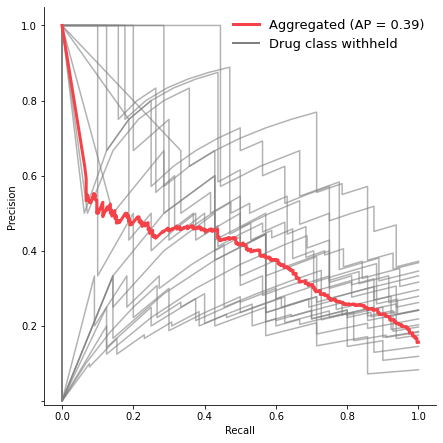

In [39]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(6.5,6.5))

font = {'family': 'normal',
        'weight': 'normal',
        'size': 18}
matplotlib.rc('font', **font)
for cl in keys:
    plt.plot(pr.recall[cl][1], pr.precision[cl][1],
             color='grey', lw=1.5, alpha=0.6)
    plt.xlim([-0.05, 1.05])
plt.plot(recall_micro, prec_micro,
        label='Aggregated (AP = {0:0.2f})'
               ''.format(ap_micro),
         color='#f54248', linestyle='-', linewidth=3)

handles, labels = ax.get_legend_handles_labels()
patch = Line2D([0], [0], color='grey', linewidth=2, linestyle="-",
               label='Drug class withheld')
handles.append(patch) 
plt.ylim([-0.01, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
#ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.title(title)
plt.legend(handles=handles, loc='upper right', prop={"size": 13},
          frameon=False)
plt.tight_layout()
#plt.savefig('Ecoli-antagonism-vs-rest-grey.pdf')

In [40]:
# A "micro-average": quantifying score on all classes jointly
prec_micro, recall_micro, _ = precision_recall_curve(pred_vs_true['syn'].values,
                                                    pred_vs_true['score_syn'].values)
ap_micro = average_precision_score(pred_vs_true['syn'].values,
                                   pred_vs_true['score_syn'].values,
                                   average="micro")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


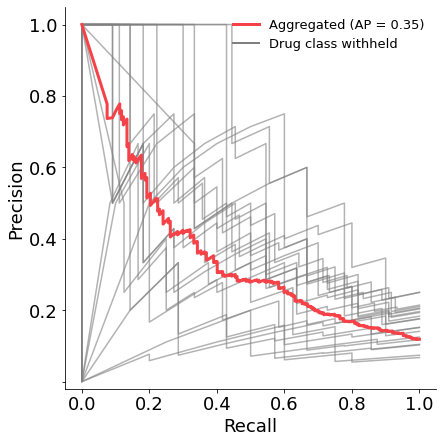

In [41]:
fig, ax = plt.subplots(figsize=(6.5,6.5))
for cl in keys:
    plt.plot(pr.recall[cl][2], pr.precision[cl][2],
            color='grey', lw=1.5, alpha=0.6)
    plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall_micro, prec_micro,
        label='Aggregated (AP = {0:0.2f})'
               ''.format(ap_micro),
         color='#f54248', linestyle='-', linewidth=3)

handles, labels = ax.get_legend_handles_labels()
patch = Line2D([0], [0], color='grey', linewidth=2, linestyle="-",
               label='Drug class withheld')
handles.append(patch) 
plt.ylim([-0.02, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.title(title)
plt.legend(handles=handles, loc='upper right',
           prop={"size": 13},
            #bbox_to_anchor=(1.2,0.8),
          frameon=False)
#plt.legend([], frameon=False)
plt.tight_layout()
#plt.savefig('Ecoli-synergy-vs-rest-grey.pdf')

Plot ROC curves:

In [42]:
fpr_micro, tpr_micro, _ = roc_curve(pred_vs_true['ant'].values,
                                                    pred_vs_true['score_antag'].values)
roc_auc_micro = auc(fpr_micro, tpr_micro)

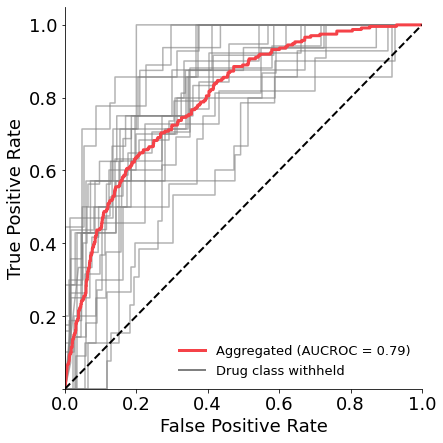

In [43]:
fig, ax = plt.subplots(figsize=(6.5,6.5))
for cl in keys:
    plt.plot(pr.fpr[cl][1], pr.tpr[cl][1],
             color='grey', lw=1.5, alpha=0.6)
plt.plot(fpr_micro, tpr_micro,
        label='Aggregated (AUCROC = {0:0.2f})'
               ''.format(roc_auc_micro),
         color='#f54248', linestyle='-', linewidth=3)

handles, labels = ax.get_legend_handles_labels()
patch = Line2D([0], [0], color='grey', linewidth=2, linestyle="-",
               label='Drug class withheld')
handles.append(patch) 
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(handles=handles, loc='lower right', prop={"size": 13},
          frameon=False)
plt.tight_layout()
#plt.savefig('Ecoli-ROC-antagonism-vs-rest-grey.pdf')

In [44]:
fpr_micro, tpr_micro, _ = roc_curve(pred_vs_true['syn'].values,
                                                    pred_vs_true['score_syn'].values)
roc_auc_micro = auc(fpr_micro, tpr_micro)

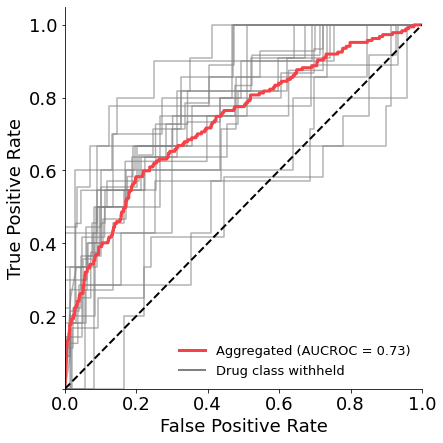

In [45]:
fig, ax = plt.subplots(figsize=(6.5,6.5))
for cl in keys:
    plt.plot(pr.fpr[cl][2], pr.tpr[cl][2],
             color='grey', lw=1.5, alpha=0.6)
plt.plot(fpr_micro, tpr_micro,
        label='Aggregated (AUCROC = {0:0.2f})'
               ''.format(roc_auc_micro),
         color='#f54248', linestyle='-', linewidth=3)

handles, labels = ax.get_legend_handles_labels()
patch = Line2D([0], [0], color='grey', linewidth=2, linestyle="-",
               label='Drug class withheld')
handles.append(patch) 
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
#ax.xaxis.get_major_ticks()[0].label1.set_visible(False)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
plt.legend(handles=handles, loc='lower right', prop={"size": 13},
          frameon=False)
plt.tight_layout()
#plt.savefig('Ecoli-ROC-synergy-vs-rest-grey.pdf')

Plot average precision (AP) vs interaction rate for each cross-validation fold:

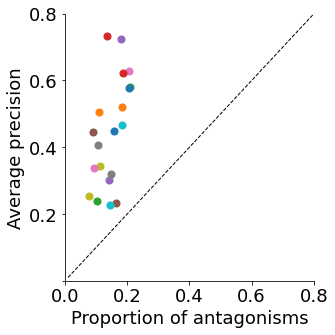

In [46]:
fig, ax = plt.subplots(figsize=(5,5))
# for antagonism predictions
for cl in keys:
    ycl = y[np.isin(combs, pr.predicted[cl]['comb'].values)].argmax(axis=1)
    antag_rate = np.sum(ycl == 1) / ycl.size
    plt.scatter(antag_rate, pr.avprec[cl][1], marker='o', 
             label=cl, s=50)
    plt.xlim((0,0.8))
    plt.ylim((0,0.8))
plt.plot([0.01, 1], [0.01, 1], 'k--', lw=1)
plt.xlabel('Proportion of antagonisms')
plt.ylabel('Average precision')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
plt.tight_layout()
#plt.savefig('Ecoli-AP-antag-vs-rate.pdf')

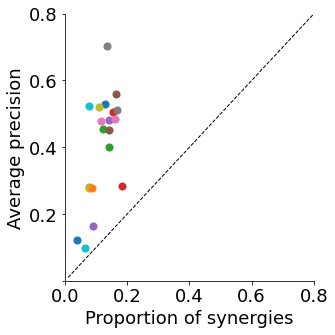

In [47]:
fig, ax = plt.subplots(figsize=(5,5))
# for antagonism predictions
for cl in keys:
    ycl = y[np.isin(combs, pr.predicted[cl]['comb'].values)].argmax(axis=1)
    syn_rate = np.sum(ycl == 2) / ycl.size
    plt.scatter(syn_rate, pr.avprec[cl][2], marker='o', 
             label=cl, s=50)
    plt.xlim((0,0.8))
    plt.ylim((0,0.8))
plt.plot([0.01, 1], [0.01, 1], 'k--', lw=1)
plt.xlabel('Proportion of synergies')
plt.ylabel('Average precision')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
plt.tight_layout()
#plt.savefig('Ecoli-AP-syn-vs-rate.pdf')

<a id="calib"></a> 
## Probability calibration

In [48]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
def build_nn(dropout=0.1, nodes=128, layers=1, learning_rate_deep=0.001, steps=64):
    model = Sequential()
    for i in range(layers):
        #With BN
        #model.add(Dense(self.nodes, activation="linear", use_bias="False"))
        #model.add(BatchNormalization())
        #model.add(Activation("relu"))
        #model.add(Dropout(self.dropout))
        #Without BN
        model.add(Dense(nodes, activation="relu"))
        model.add(Dropout(dropout))
        model.add(Dense(3, activation="softmax"))
                
        opt = keras.optimizers.Adam(learning_rate=learning_rate_deep)#, beta_1=self.beta_1, beta_2=self.beta_2)
        model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), optimizer = opt,  metrics = ["accuracy"]) #other option loss = "binary_crossentropy"
        return model

In [49]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
#clf = OneVsRestClassifier(RandomForestClassifier(bootstrap=True,
#                                                max_features='sqrt',
#                                                **param_dict,
#                                                random_state=2305,
#                                              n_jobs=-1))
clf = OneVsRestClassifier(tf.keras.wrappers.scikit_learn.KerasClassifier(build_nn, epochs=400, steps=64))

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_onehot, y, test_size=0.2,
                                                    random_state=2305,
                                                    stratify=np.argmax(y, axis=1))

In [51]:
#clf = clf.fit(X_train, y_train)
clf= clf.fit(X_train, y_train)

Epoch 1/400
25/25 [==============================] - 0s 983us/step - loss: 0.7353 - accuracy: 0.6546
Epoch 2/400
25/25 [==============================] - 0s 948us/step - loss: 0.5137 - accuracy: 0.7494
Epoch 3/400
25/25 [==============================] - 0s 895us/step - loss: 0.4753 - accuracy: 0.7520
Epoch 4/400
25/25 [==============================] - 0s 909us/step - loss: 0.4200 - accuracy: 0.8137
Epoch 5/400
25/25 [==============================] - 0s 1ms/step - loss: 0.4062 - accuracy: 0.8427
Epoch 6/400
25/25 [==============================] - 0s 1ms/step - loss: 0.4217 - accuracy: 0.8363
Epoch 7/400
25/25 [==============================] - 0s 1ms/step - loss: 0.3624 - accuracy: 0.8533
Epoch 8/400
25/25 [==============================] - 0s 907us/step - loss: 0.3705 - accuracy: 0.8561
Epoch 9/400
25/25 [==============================] - 0s 895us/step - loss: 0.3285 - accuracy: 0.8704
Epoch 10/400
25/25 [==============================] - 0s 839us/step - loss: 0.3423 - accuracy: 0.

25/25 [==============================] - 0s 915us/step - loss: 0.0093 - accuracy: 0.9993
Epoch 82/400
25/25 [==============================] - 0s 919us/step - loss: 0.0167 - accuracy: 0.9934
Epoch 83/400
25/25 [==============================] - 0s 978us/step - loss: 0.0210 - accuracy: 0.9979
Epoch 84/400
25/25 [==============================] - 0s 974us/step - loss: 0.0119 - accuracy: 0.9986
Epoch 85/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0141 - accuracy: 0.9962
Epoch 86/400
25/25 [==============================] - 0s 988us/step - loss: 0.0089 - accuracy: 0.9985
Epoch 87/400
25/25 [==============================] - 0s 975us/step - loss: 0.0069 - accuracy: 1.0000
Epoch 88/400
25/25 [==============================] - 0s 957us/step - loss: 0.0079 - accuracy: 1.0000
Epoch 89/400
25/25 [==============================] - 0s 985us/step - loss: 0.0104 - accuracy: 0.9985
Epoch 90/400
25/25 [==============================] - 0s 988us/step - loss: 0.0133 - accuracy: 0.

25/25 [==============================] - 0s 936us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 162/400
25/25 [==============================] - 0s 940us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 163/400
25/25 [==============================] - 0s 916us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 164/400
25/25 [==============================] - 0s 978us/step - loss: 0.0036 - accuracy: 0.9985
Epoch 165/400
25/25 [==============================] - 0s 966us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 166/400
25/25 [==============================] - 0s 969us/step - loss: 0.0024 - accuracy: 0.9998
Epoch 167/400
25/25 [==============================] - 0s 984us/step - loss: 0.0314 - accuracy: 0.9945
Epoch 168/400
25/25 [==============================] - 0s 943us/step - loss: 0.0366 - accuracy: 0.9948
Epoch 169/400
25/25 [==============================] - 0s 976us/step - loss: 0.0075 - accuracy: 0.9972
Epoch 170/400
25/25 [==============================] - 0s 944us/step - loss: 0.0104 - a

25/25 [==============================] - 0s 927us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 241/400
25/25 [==============================] - 0s 926us/step - loss: 9.1830e-04 - accuracy: 1.0000
Epoch 242/400
25/25 [==============================] - 0s 967us/step - loss: 6.8870e-04 - accuracy: 1.0000
Epoch 243/400
25/25 [==============================] - 0s 970us/step - loss: 0.0021 - accuracy: 0.9994
Epoch 244/400
25/25 [==============================] - 0s 962us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 245/400
25/25 [==============================] - 0s 967us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 246/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0065 - accuracy: 0.9977
Epoch 247/400
25/25 [==============================] - 0s 932us/step - loss: 0.0096 - accuracy: 0.9985
Epoch 248/400
25/25 [==============================] - 0s 981us/step - loss: 0.0021 - accuracy: 0.9991
Epoch 249/400
25/25 [==============================] - 0s 937us/step - loss: 0.00

Epoch 319/400
25/25 [==============================] - 0s 923us/step - loss: 5.6984e-04 - accuracy: 1.0000
Epoch 320/400
25/25 [==============================] - 0s 914us/step - loss: 3.1008e-04 - accuracy: 1.0000
Epoch 321/400
25/25 [==============================] - 0s 903us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 322/400
25/25 [==============================] - 0s 1ms/step - loss: 9.2356e-04 - accuracy: 1.0000
Epoch 323/400
25/25 [==============================] - 0s 946us/step - loss: 5.9828e-04 - accuracy: 1.0000
Epoch 324/400
25/25 [==============================] - 0s 992us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 325/400
25/25 [==============================] - 0s 1ms/step - loss: 6.4105e-04 - accuracy: 1.0000
Epoch 326/400
25/25 [==============================] - 0s 951us/step - loss: 8.1033e-04 - accuracy: 1.0000
Epoch 327/400
25/25 [==============================] - 0s 951us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 328/400
25/25 [==============================] 

25/25 [==============================] - 0s 928us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 399/400
25/25 [==============================] - 0s 934us/step - loss: 0.0014 - accuracy: 0.9997
Epoch 400/400
25/25 [==============================] - 0s 956us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 1/400
25/25 [==============================] - 0s 1ms/step - loss: 0.7364 - accuracy: 0.7030
Epoch 2/400
25/25 [==============================] - 0s 1ms/step - loss: 0.3807 - accuracy: 0.8386
Epoch 3/400
25/25 [==============================] - 0s 1ms/step - loss: 0.3388 - accuracy: 0.8528
Epoch 4/400
25/25 [==============================] - 0s 1ms/step - loss: 0.3167 - accuracy: 0.8625
Epoch 5/400
25/25 [==============================] - 0s 949us/step - loss: 0.2492 - accuracy: 0.8913
Epoch 6/400
25/25 [==============================] - 0s 956us/step - loss: 0.2601 - accuracy: 0.8829
Epoch 7/400
25/25 [==============================] - 0s 952us/step - loss: 0.2372 - accuracy: 0.9176
Epoch 

25/25 [==============================] - 0s 953us/step - loss: 0.0037 - accuracy: 1.0000
Epoch 79/400
25/25 [==============================] - 0s 944us/step - loss: 0.0054 - accuracy: 1.0000
Epoch 80/400
25/25 [==============================] - 0s 918us/step - loss: 0.0047 - accuracy: 0.9993
Epoch 81/400
25/25 [==============================] - 0s 937us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 82/400
25/25 [==============================] - 0s 873us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 83/400
25/25 [==============================] - 0s 934us/step - loss: 0.0045 - accuracy: 1.0000
Epoch 84/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 85/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0096 - accuracy: 0.9954
Epoch 86/400
25/25 [==============================] - 0s 996us/step - loss: 0.0058 - accuracy: 0.9985
Epoch 87/400
25/25 [==============================] - 0s 933us/step - loss: 0.0057 - accuracy: 1.00

25/25 [==============================] - 0s 990us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 158/400
25/25 [==============================] - 0s 938us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 159/400
25/25 [==============================] - 0s 953us/step - loss: 9.4155e-04 - accuracy: 1.0000
Epoch 160/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0125 - accuracy: 0.9938
Epoch 161/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0392 - accuracy: 0.9799
Epoch 162/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0373 - accuracy: 0.9760
Epoch 163/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0449 - accuracy: 0.9894
Epoch 164/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0202 - accuracy: 0.9924
Epoch 165/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0200 - accuracy: 0.9910
Epoch 166/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0224 - accuracy: 0

25/25 [==============================] - 0s 1ms/step - loss: 2.8697e-04 - accuracy: 1.0000
Epoch 237/400
25/25 [==============================] - 0s 1ms/step - loss: 4.3536e-04 - accuracy: 1.0000
Epoch 238/400
25/25 [==============================] - 0s 1ms/step - loss: 5.8202e-04 - accuracy: 1.0000
Epoch 239/400
25/25 [==============================] - 0s 1ms/step - loss: 5.9509e-04 - accuracy: 1.0000
Epoch 240/400
25/25 [==============================] - 0s 1ms/step - loss: 3.7353e-04 - accuracy: 1.0000
Epoch 241/400
25/25 [==============================] - 0s 1ms/step - loss: 9.2241e-04 - accuracy: 1.0000
Epoch 242/400
25/25 [==============================] - 0s 1ms/step - loss: 4.4205e-04 - accuracy: 1.0000
Epoch 243/400
25/25 [==============================] - 0s 1ms/step - loss: 1.3194e-04 - accuracy: 1.0000
Epoch 244/400
25/25 [==============================] - 0s 1ms/step - loss: 2.5954e-04 - accuracy: 1.0000
Epoch 245/400
25/25 [==============================] - 0s 1ms/step - 

25/25 [==============================] - 0s 1ms/step - loss: 4.4365e-04 - accuracy: 1.0000
Epoch 316/400
25/25 [==============================] - 0s 958us/step - loss: 7.2100e-05 - accuracy: 1.0000
Epoch 317/400
25/25 [==============================] - 0s 985us/step - loss: 6.5571e-04 - accuracy: 1.0000
Epoch 318/400
25/25 [==============================] - 0s 988us/step - loss: 3.3447e-04 - accuracy: 1.0000
Epoch 319/400
25/25 [==============================] - 0s 959us/step - loss: 1.4144e-04 - accuracy: 1.0000
Epoch 320/400
25/25 [==============================] - 0s 970us/step - loss: 3.5440e-04 - accuracy: 1.0000
Epoch 321/400
25/25 [==============================] - 0s 982us/step - loss: 0.0034 - accuracy: 0.9965
Epoch 322/400
25/25 [==============================] - 0s 986us/step - loss: 0.0105 - accuracy: 0.9959
Epoch 323/400
25/25 [==============================] - 0s 956us/step - loss: 0.0031 - accuracy: 0.9996
Epoch 324/400
25/25 [==============================] - 0s 956us/s

25/25 [==============================] - 0s 934us/step - loss: 0.0324 - accuracy: 0.9918
Epoch 394/400
25/25 [==============================] - 0s 925us/step - loss: 0.0081 - accuracy: 0.9952
Epoch 395/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 396/400
25/25 [==============================] - 0s 974us/step - loss: 0.0087 - accuracy: 0.9977
Epoch 397/400
25/25 [==============================] - 0s 988us/step - loss: 0.0043 - accuracy: 0.9966
Epoch 398/400
25/25 [==============================] - 0s 944us/step - loss: 7.6174e-04 - accuracy: 1.0000
Epoch 399/400
25/25 [==============================] - 0s 979us/step - loss: 0.0010 - accuracy: 0.9999
Epoch 400/400
25/25 [==============================] - 0s 961us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 1/400
25/25 [==============================] - 0s 932us/step - loss: 0.6307 - accuracy: 0.7473
Epoch 2/400
25/25 [==============================] - 0s 1ms/step - loss: 0.3351 - accur

25/25 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 75/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 76/400
25/25 [==============================] - 0s 977us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 77/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 78/400
25/25 [==============================] - 0s 966us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 79/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 80/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 81/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 82/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 83/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 84/

25/25 [==============================] - 0s 953us/step - loss: 6.6447e-04 - accuracy: 1.0000
Epoch 155/400
25/25 [==============================] - 0s 964us/step - loss: 7.4353e-04 - accuracy: 1.0000
Epoch 156/400
25/25 [==============================] - 0s 937us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 157/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 158/400
25/25 [==============================] - 0s 960us/step - loss: 8.9583e-04 - accuracy: 1.0000
Epoch 159/400
25/25 [==============================] - 0s 965us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 160/400
25/25 [==============================] - 0s 1ms/step - loss: 2.4615e-04 - accuracy: 1.0000
Epoch 161/400
25/25 [==============================] - 0s 1ms/step - loss: 3.2520e-04 - accuracy: 1.0000
Epoch 162/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 163/400
25/25 [==============================] - 0s 1ms/step - loss: 

25/25 [==============================] - 0s 975us/step - loss: 3.7663e-04 - accuracy: 1.0000
Epoch 233/400
25/25 [==============================] - 0s 954us/step - loss: 3.3193e-04 - accuracy: 1.0000
Epoch 234/400
25/25 [==============================] - 0s 940us/step - loss: 6.5668e-04 - accuracy: 1.0000
Epoch 235/400
25/25 [==============================] - 0s 1ms/step - loss: 8.0243e-04 - accuracy: 1.0000
Epoch 236/400
25/25 [==============================] - 0s 989us/step - loss: 2.3089e-04 - accuracy: 1.0000
Epoch 237/400
25/25 [==============================] - 0s 993us/step - loss: 3.6082e-04 - accuracy: 1.0000
Epoch 238/400
25/25 [==============================] - 0s 984us/step - loss: 1.9780e-04 - accuracy: 1.0000
Epoch 239/400
25/25 [==============================] - 0s 1ms/step - loss: 1.9582e-04 - accuracy: 1.0000
Epoch 240/400
25/25 [==============================] - 0s 1ms/step - loss: 2.4546e-04 - accuracy: 1.0000
Epoch 241/400
25/25 [==============================] - 0s

25/25 [==============================] - 0s 948us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 311/400
25/25 [==============================] - 0s 962us/step - loss: 6.4940e-04 - accuracy: 1.0000
Epoch 312/400
25/25 [==============================] - 0s 939us/step - loss: 3.8905e-04 - accuracy: 1.0000
Epoch 313/400
25/25 [==============================] - 0s 960us/step - loss: 3.0504e-04 - accuracy: 1.0000
Epoch 314/400
25/25 [==============================] - 0s 1ms/step - loss: 4.8509e-04 - accuracy: 1.0000
Epoch 315/400
25/25 [==============================] - 0s 986us/step - loss: 4.1683e-04 - accuracy: 1.0000
Epoch 316/400
25/25 [==============================] - 0s 1ms/step - loss: 5.6745e-04 - accuracy: 1.0000
Epoch 317/400
25/25 [==============================] - 0s 1ms/step - loss: 6.2711e-04 - accuracy: 1.0000
Epoch 318/400
25/25 [==============================] - 0s 1ms/step - loss: 9.9442e-05 - accuracy: 1.0000
Epoch 319/400
25/25 [==============================] - 0s 1ms/s

25/25 [==============================] - 0s 999us/step - loss: 4.5231e-04 - accuracy: 1.0000
Epoch 390/400
25/25 [==============================] - 0s 1ms/step - loss: 5.6034e-04 - accuracy: 1.0000
Epoch 391/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 392/400
25/25 [==============================] - 0s 1ms/step - loss: 6.7399e-04 - accuracy: 1.0000
Epoch 393/400
25/25 [==============================] - 0s 1ms/step - loss: 7.7900e-04 - accuracy: 1.0000
Epoch 394/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 0.9979
Epoch 395/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0062 - accuracy: 0.9964
Epoch 396/400
25/25 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 0.9989
Epoch 397/400
25/25 [==============================] - 0s 1ms/step - loss: 5.8080e-04 - accuracy: 1.0000
Epoch 398/400
25/25 [==============================] - 0s 1ms/step - loss: 2.6696e-

In [52]:
probas_ = clf.predict(X_val)

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Plot precision-recall for the training set:

In [53]:
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
thresh = dict()
average_precision = dict()

In [54]:
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], probas_[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], thresh[i] = precision_recall_curve(y_val[:, i],
                                                        probas_[:, i])
    average_precision[i] = average_precision_score(y_val[:, i], probas_[:, i])


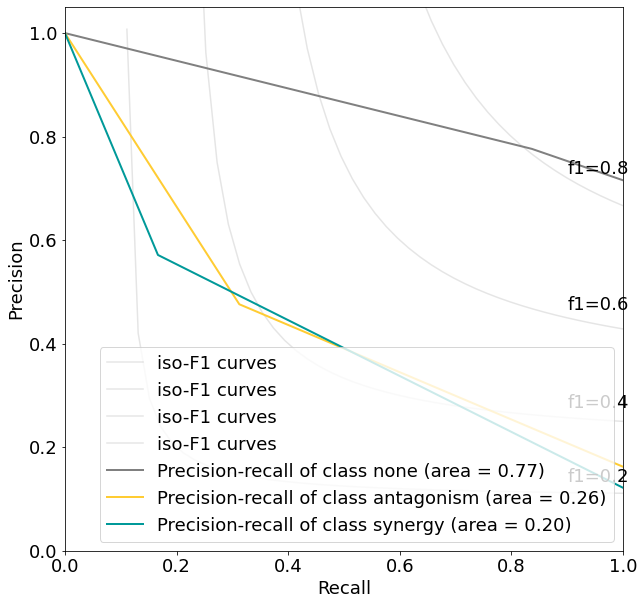

In [55]:
from itertools import cycle
class_names = ['none', 'antagonism', 'synergy']
colors = cycle(['#808080','#FFCC33', '#009999'])


plt.figure(figsize=(10,10))
f_scores = np.linspace(0.2, 0.8, num=4)

for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y_ = f_score * x / (2 * x - f_score)
    plt.plot(x[y_ >= 0], y_[y_ >= 0], color='gray', alpha=0.2,
             label='iso-F1 curves')
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y_[45] + 0.02))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-recall of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")

In [56]:
from sklearn.calibration import calibration_curve
fraction_of_positives = dict()
mean_predicted_value = dict()
for i in range(n_classes):
    proba_val = clf.predict_proba(X_val)[:, i]
    fraction_of_positives[i], mean_predicted_value[i] = calibration_curve(y_val[:,i],
                                                                proba_val,
                                                                n_bins=6)

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Sci

In [57]:
mean_predicted_value[2]

array([0.00275957, 0.24525319, 0.40601158, 0.63203135, 0.96226474])

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


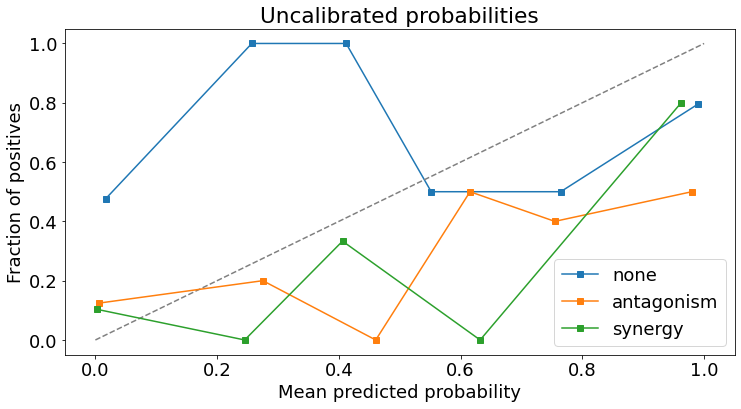

In [58]:
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value[0], fraction_of_positives[0], 's-', label='none')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.plot(mean_predicted_value[1], fraction_of_positives[1], 's-', label='antagonism')
plt.plot(mean_predicted_value[2], fraction_of_positives[2], 's-', label='synergy')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Uncalibrated probabilities')
plt.legend()

In [59]:
from sklearn.calibration import CalibratedClassifierCV
fraction_of_positives = dict()
mean_predicted_value = dict()
for i in range(n_classes):
    #proba_val = clf.predict_proba(X_val)[:, i]
#    clf_calib = CalibratedClassifierCV(clf.estimators_[i], cv=10, method='isotonic')
    clf_calib = CalibratedClassifierCV(clf, cv=10, method='isotonic')
    proba_val = clf_calib.fit(X_train, y_train[:,i]).predict_proba(X_val)[:,1]
    fraction_of_positives[i], mean_predicted_value[i] = calibration_curve(y_val[:,i],
                                                                proba_val,
                                                                n_bins=5)

Epoch 1/400
23/23 [==============================] - 0s 971us/step - loss: 0.8198 - accuracy: 0.6051
Epoch 2/400
23/23 [==============================] - 0s 1ms/step - loss: 0.5299 - accuracy: 0.7625
Epoch 3/400
23/23 [==============================] - 0s 1ms/step - loss: 0.4587 - accuracy: 0.8050
Epoch 4/400
23/23 [==============================] - 0s 1ms/step - loss: 0.4209 - accuracy: 0.8278
Epoch 5/400
23/23 [==============================] - 0s 1ms/step - loss: 0.4127 - accuracy: 0.8171
Epoch 6/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3761 - accuracy: 0.8353
Epoch 7/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3363 - accuracy: 0.8615
Epoch 8/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3460 - accuracy: 0.8511
Epoch 9/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3598 - accuracy: 0.8390
Epoch 10/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2920 - accuracy: 0.8907
Epoch 1

23/23 [==============================] - 0s 1ms/step - loss: 0.0141 - accuracy: 0.9990
Epoch 83/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0144 - accuracy: 0.9964
Epoch 84/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0114 - accuracy: 0.9985
Epoch 85/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0089 - accuracy: 0.9980
Epoch 86/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0080 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0116 - accuracy: 0.9975
Epoch 88/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0094 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0095 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0091 - accuracy: 1.0000
Epoch 91/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0071 - accuracy: 1.0000
Epoch 92/400


23/23 [==============================] - 0s 983us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 163/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 165/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 168/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 169/400
23/23 [==============================] - 0s 1ms/step - loss: 8.5104e-04 - accuracy: 1.0000
Epoch 170/400
23/23 [==============================] - 0s 1ms/step - loss: 7.0877e-04 - accuracy: 1.0000
Epoch 171/400
23/23 [==============================] - 0s 1ms/step - loss: 8.7994e-04 - accurac

23/23 [==============================] - 0s 960us/step - loss: 0.0022 - accuracy: 0.9991
Epoch 243/400
23/23 [==============================] - 0s 924us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 980us/step - loss: 0.0047 - accuracy: 0.9991
Epoch 245/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0068 - accuracy: 0.9985
Epoch 246/400
23/23 [==============================] - 0s 991us/step - loss: 0.0094 - accuracy: 0.9970
Epoch 247/400
23/23 [==============================] - 0s 994us/step - loss: 0.0073 - accuracy: 0.9976
Epoch 248/400
23/23 [==============================] - 0s 947us/step - loss: 0.0175 - accuracy: 0.9924
Epoch 249/400
23/23 [==============================] - 0s 996us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 250/400
23/23 [==============================] - 0s 995us/step - loss: 0.0074 - accuracy: 0.9976
Epoch 251/400
23/23 [==============================] - 0s 990us/step - loss: 0.0180 - acc

23/23 [==============================] - 0s 890us/step - loss: 0.0186 - accuracy: 0.9938
Epoch 322/400
23/23 [==============================] - 0s 935us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 323/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 324/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 0.9994
Epoch 325/400
23/23 [==============================] - 0s 986us/step - loss: 0.0055 - accuracy: 0.9995
Epoch 326/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0081 - accuracy: 0.9998
Epoch 327/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0237 - accuracy: 0.9953
Epoch 328/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0103 - accuracy: 0.9980
Epoch 329/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 330/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 0.998

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 1ms/step - loss: 0.7360 - accuracy: 0.6595
Epoch 2/400
23/23 [==============================] - 0s 1ms/step - loss: 0.5884 - accuracy: 0.7096
Epoch 3/400
23/23 [==============================] - 0s 1ms/step - loss: 0.4832 - accuracy: 0.7854
Epoch 4/400
23/23 [==============================] - 0s 1ms/step - loss: 0.4319 - accuracy: 0.8175
Epoch 5/400
23/23 [==============================] - 0s 1ms/step - loss: 0.4213 - accuracy: 0.8128
Epoch 6/400
23/23 [==============================] - 0s 1ms/step - loss: 0.4000 - accuracy: 0.8075
Epoch 7/400
23/23 [==============================] - 0s 1ms/step - loss: 0.4299 - accuracy: 0.8262
Epoch 8/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3664 - accuracy: 0.8458
Epoch 9/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3957 - accuracy: 0.8178
Epoch 10/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3419 - accuracy: 0.8703
Epoch 11/400
23/23 [=

23/23 [==============================] - 0s 1ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 84/400
23/23 [==============================] - 0s 989us/step - loss: 0.0099 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0103 - accuracy: 0.9964
Epoch 86/400
23/23 [==============================] - 0s 989us/step - loss: 0.0069 - accuracy: 0.9998
Epoch 87/400
23/23 [==============================] - 0s 980us/step - loss: 0.0073 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 970us/step - loss: 0.0063 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 982us/step - loss: 0.0087 - accuracy: 0.9996
Epoch 90/400
23/23 [==============================] - 0s 992us/step - loss: 0.0075 - accuracy: 1.0000
Epoch 91/400
23/23 [==============================] - 0s 989us/step - loss: 0.0056 - accuracy: 0.9998

23/23 [==============================] - 0s 880us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 163/400
23/23 [==============================] - 0s 864us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 848us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 165/400
23/23 [==============================] - 0s 893us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 907us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 936us/step - loss: 0.0037 - accuracy: 0.9994
Epoch 168/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 169/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0081 - accuracy: 0.9951
Epoch 170/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0100 - accuracy: 0.9970
Epoch 171/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0342 - accuracy:

23/23 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 992us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 0.9988
Epoch 246/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9998
Epoch 247/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 248/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 249/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 0.9980
Epoch 250/400
23/23 [==============================] - 0s 941us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 251/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0115 - accuracy: 0.9967


23/23 [==============================] - 0s 884us/step - loss: 0.0039 - accuracy: 0.9996
Epoch 323/400
23/23 [==============================] - 0s 899us/step - loss: 0.0065 - accuracy: 0.9970
Epoch 324/400
23/23 [==============================] - 0s 918us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 325/400
23/23 [==============================] - 0s 930us/step - loss: 0.0091 - accuracy: 0.9964
Epoch 326/400
23/23 [==============================] - 0s 997us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 327/400
23/23 [==============================] - 0s 964us/step - loss: 7.2420e-04 - accuracy: 1.0000
Epoch 328/400
23/23 [==============================] - 0s 1ms/step - loss: 4.6891e-04 - accuracy: 1.0000
Epoch 329/400
23/23 [==============================] - 0s 972us/step - loss: 6.1005e-04 - accuracy: 1.0000
Epoch 330/400
23/23 [==============================] - 0s 969us/step - loss: 6.8145e-04 - accuracy: 1.0000
Epoch 331/400
23/23 [==============================] - 0s 973us/step - lo

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 912us/step - loss: 0.7907 - accuracy: 0.6033
Epoch 2/400
23/23 [==============================] - 0s 856us/step - loss: 0.5582 - accuracy: 0.7334
Epoch 3/400
23/23 [==============================] - 0s 939us/step - loss: 0.5081 - accuracy: 0.7642
Epoch 4/400
23/23 [==============================] - 0s 1ms/step - loss: 0.4478 - accuracy: 0.7923
Epoch 5/400
23/23 [==============================] - 0s 1ms/step - loss: 0.4497 - accuracy: 0.7802
Epoch 6/400
23/23 [==============================] - 0s 992us/step - loss: 0.4072 - accuracy: 0.8236
Epoch 7/400
23/23 [==============================] - 0s 947us/step - loss: 0.3555 - accuracy: 0.8623
Epoch 8/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3617 - accuracy: 0.8400
Epoch 9/400
23/23 [==============================] - 0s 981us/step - loss: 0.4178 - accuracy: 0.8246
Epoch 10/400
23/23 [==============================] - 0s 987us/step - loss: 0.3539 - accuracy: 0.8530
Epoch 1

Epoch 82/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0085 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0102 - accuracy: 0.9951
Epoch 84/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0087 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 978us/step - loss: 0.0105 - accuracy: 1.0000
Epoch 86/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0071 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0077 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 960us/step - loss: 0.0083 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0096 - accuracy: 0.9976
Epoch 90/400
23/23 [==============================] - 0s 941us/step - loss: 0.0082 - accuracy: 1.0000
Epoch 91/400
23/23 [==============================] - 0s 949us/step - loss: 0.0076 - accuracy:

23/23 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.9994
Epoch 163/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 165/400
23/23 [==============================] - 0s 1ms/step - loss: 9.6892e-04 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 0.9996
Epoch 168/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0109 - accuracy: 0.9972
Epoch 169/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0067 - accuracy: 0.9996
Epoch 170/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0059 - accuracy: 1.0000
Epoch 171/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0052 - accuracy: 1.0000


23/23 [==============================] - 0s 1ms/step - loss: 0.0083 - accuracy: 0.9975
Epoch 243/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 0.9997
Epoch 244/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 978us/step - loss: 0.0034 - accuracy: 0.9985
Epoch 246/400
23/23 [==============================] - 0s 993us/step - loss: 0.0058 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 248/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 249/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 250/400
23/23 [==============================] - 0s 1ms/step - loss: 5.7812e-04 - accuracy: 1.0000
Epoch 251/400
23/23 [==============================] - 0s 2ms/step - loss: 3.7938e-04 - accuracy:

23/23 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.9997
Epoch 322/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 323/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 0.9992
Epoch 324/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0091 - accuracy: 0.9975
Epoch 325/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 0.9996
Epoch 326/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 327/400
23/23 [==============================] - 0s 985us/step - loss: 0.0042 - accuracy: 1.0000
Epoch 328/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0034 - accuracy: 0.9989
Epoch 329/400
23/23 [==============================] - 0s 1ms/step - loss: 5.4465e-04 - accuracy: 1.0000
Epoch 330/400
23/23 [==============================] - 0s 973us/step - loss: 8.8270e-04 - accuracy:

23/23 [==============================] - 0s 968us/step - loss: 2.6134e-04 - accuracy: 1.0000
Epoch 400/400
23/23 [==============================] - 0s 932us/step - loss: 2.9118e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 920us/step - loss: 0.6943 - accuracy: 0.6882
Epoch 2/400
23/23 [==============================] - 0s 1ms/step - loss: 0.4783 - accuracy: 0.7646
Epoch 3/400
23/23 [==============================] - 0s 974us/step - loss: 0.4456 - accuracy: 0.7879
Epoch 4/400
23/23 [==============================] - 0s 954us/step - loss: 0.3996 - accuracy: 0.8253
Epoch 5/400
23/23 [==============================] - 0s 946us/step - loss: 0.4412 - accuracy: 0.7839
Epoch 6/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3948 - accuracy: 0.8275
Epoch 7/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3916 - accuracy: 0.8328
Epoch 8/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3862 - accuracy: 0.8342
Epoch 9/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3438 - accuracy: 0.8582
Epoch 10/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3175 - accuracy: 0.8702
Epoch 11/400


Epoch 82/400
23/23 [==============================] - 0s 895us/step - loss: 0.0054 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 885us/step - loss: 0.0063 - accuracy: 1.0000
Epoch 84/400
23/23 [==============================] - 0s 912us/step - loss: 0.0094 - accuracy: 0.9996
Epoch 85/400
23/23 [==============================] - 0s 914us/step - loss: 0.0259 - accuracy: 0.9939
Epoch 86/400
23/23 [==============================] - 0s 917us/step - loss: 0.0198 - accuracy: 0.9941
Epoch 87/400
23/23 [==============================] - 0s 894us/step - loss: 0.0118 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 885us/step - loss: 0.0063 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 890us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 900us/step - loss: 0.0118 - accuracy: 0.9961
Epoch 91/400
23/23 [==============================] - 0s 916us/step - loss: 0.0099

23/23 [==============================] - 0s 897us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 163/400
23/23 [==============================] - 0s 958us/step - loss: 0.0093 - accuracy: 0.9997
Epoch 164/400
23/23 [==============================] - 0s 974us/step - loss: 0.0045 - accuracy: 1.0000
Epoch 165/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 980us/step - loss: 0.0036 - accuracy: 0.9978
Epoch 167/400
23/23 [==============================] - 0s 965us/step - loss: 0.0064 - accuracy: 1.0000
Epoch 168/400
23/23 [==============================] - 0s 976us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 169/400
23/23 [==============================] - 0s 985us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 170/400
23/23 [==============================] - 0s 953us/step - loss: 9.2559e-04 - accuracy: 1.0000
Epoch 171/400
23/23 [==============================] - 0s 964us/step - loss: 0.0033 -

23/23 [==============================] - 0s 1ms/step - loss: 0.0053 - accuracy: 0.9972
Epoch 243/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0075 - accuracy: 0.9959
Epoch 244/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0274 - accuracy: 0.9818
Epoch 245/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0462 - accuracy: 0.9765
Epoch 246/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0103 - accuracy: 0.9979
Epoch 247/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 0.9985
Epoch 248/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0060 - accuracy: 0.9975
Epoch 249/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 250/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0058 - accuracy: 0.9964
Epoch 251/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0039 - accuracy: 0.9985
Epoc

Epoch 321/400
23/23 [==============================] - 0s 805us/step - loss: 0.0371 - accuracy: 0.9876
Epoch 322/400
23/23 [==============================] - 0s 841us/step - loss: 0.0072 - accuracy: 0.9967
Epoch 323/400
23/23 [==============================] - 0s 896us/step - loss: 0.0082 - accuracy: 0.9962
Epoch 324/400
23/23 [==============================] - 0s 902us/step - loss: 0.0102 - accuracy: 0.9940
Epoch 325/400
23/23 [==============================] - 0s 905us/step - loss: 0.0069 - accuracy: 0.9965
Epoch 326/400
23/23 [==============================] - 0s 922us/step - loss: 0.0060 - accuracy: 1.0000
Epoch 327/400
23/23 [==============================] - 0s 889us/step - loss: 0.0122 - accuracy: 0.9969
Epoch 328/400
23/23 [==============================] - 0s 908us/step - loss: 0.0460 - accuracy: 0.9887
Epoch 329/400
23/23 [==============================] - 0s 879us/step - loss: 0.0151 - accuracy: 0.9939
Epoch 330/400
23/23 [==============================] - 0s 886us/step - lo

23/23 [==============================] - 0s 896us/step - loss: 0.0011 - accuracy: 0.9998
Epoch 400/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0055 - accuracy: 0.9980
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 943us/step - loss: 0.7268 - accuracy: 0.6673
Epoch 2/400
23/23 [==============================] - 0s 894us/step - loss: 0.5188 - accuracy: 0.7431
Epoch 3/400
23/23 [==============================] - 0s 957us/step - loss: 0.4564 - accuracy: 0.7824
Epoch 4/400
23/23 [==============================] - 0s 980us/step - loss: 0.4435 - accuracy: 0.8150
Epoch 5/400
23/23 [==============================] - 0s 982us/step - loss: 0.4285 - accuracy: 0.7920
Epoch 6/400
23/23 [==============================] - 0s 932us/step - loss: 0.4182 - accuracy: 0.7969
Epoch 7/400
23/23 [==============================] - 0s 890us/step - loss: 0.3696 - accuracy: 0.8495
Epoch 8/400
23/23 [==============================] - 0s 895us/step - loss: 0.3755 - accuracy: 0.8285
Epoch 9/400
23/23 [==============================] - 0s 899us/step - loss: 0.3189 - accuracy: 0.8603
Epoch 10/400
23/23 [==============================] - 0s 906us/step - loss: 0.3465 - accuracy: 0.8458
E

23/23 [==============================] - 0s 838us/step - loss: 0.0069 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 864us/step - loss: 0.0070 - accuracy: 1.0000
Epoch 84/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 969us/step - loss: 0.0060 - accuracy: 1.0000
Epoch 86/400
23/23 [==============================] - 0s 935us/step - loss: 0.0055 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 930us/step - loss: 0.0073 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 935us/step - loss: 0.0052 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 981us/step - loss: 0.0044 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 990us/step - loss: 0.0044 - accuracy: 1.0000
Epoch 91/400
23/23 [==============================] - 0s 974us/step - loss: 0.0071 - accuracy: 1.

23/23 [==============================] - 0s 949us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 163/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 963us/step - loss: 0.0028 - accuracy: 0.9994
Epoch 165/400
23/23 [==============================] - 0s 928us/step - loss: 0.0096 - accuracy: 0.9984
Epoch 166/400
23/23 [==============================] - 0s 966us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 978us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 168/400
23/23 [==============================] - 0s 979us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 169/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 170/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 171/400
23/23 [==============================] - 0s 992us/step - loss: 0.0014 - accurac

23/23 [==============================] - 0s 1ms/step - loss: 0.0044 - accuracy: 0.9978
Epoch 243/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0049 - accuracy: 0.9970
Epoch 244/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 0.9989
Epoch 245/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 0.9986
Epoch 247/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 248/400
23/23 [==============================] - 0s 936us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 249/400
23/23 [==============================] - 0s 1000us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 250/400
23/23 [==============================] - 0s 998us/step - loss: 8.3337e-04 - accuracy: 1.0000
Epoch 251/400
23/23 [==============================] - 0s 1ms/step - loss: 9.7915e-04 - accura

23/23 [==============================] - 0s 1ms/step - loss: 4.0873e-04 - accuracy: 1.0000
Epoch 322/400
23/23 [==============================] - 0s 1ms/step - loss: 6.1428e-04 - accuracy: 1.0000
Epoch 323/400
23/23 [==============================] - 0s 1ms/step - loss: 5.8645e-04 - accuracy: 1.0000
Epoch 324/400
23/23 [==============================] - 0s 1ms/step - loss: 3.0597e-04 - accuracy: 1.0000
Epoch 325/400
23/23 [==============================] - 0s 999us/step - loss: 2.3873e-04 - accuracy: 1.0000
Epoch 326/400
23/23 [==============================] - 0s 1ms/step - loss: 1.7675e-04 - accuracy: 1.0000
Epoch 327/400
23/23 [==============================] - 0s 1ms/step - loss: 7.9103e-05 - accuracy: 1.0000
Epoch 328/400
23/23 [==============================] - 0s 1ms/step - loss: 2.0844e-04 - accuracy: 1.0000
Epoch 329/400
23/23 [==============================] - 0s 2ms/step - loss: 1.4335e-04 - accuracy: 1.0000
Epoch 330/400
23/23 [==============================] - 0s 2ms/step 

Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 1ms/step - loss: 0.9273 - accuracy: 0.5839
Epoch 2/400
23/23 [==============================] - 0s 1ms/step - loss: 0.5935 - accuracy: 0.7104
Epoch 3/400
23/23 [==============================] - 0s 1ms/step - loss: 0.4688 - accuracy: 0.7717
Epoch 4/400
23/23 [==============================] - 0s 1ms/step - loss: 0.4529 - accuracy: 0.7799
Epoch 5/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3982 - accuracy: 0.8370
Epoch 6/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3952 - accuracy: 0.8348
Epoch 7/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3666 - accuracy: 0.8677
Epoch 8/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3330 - accuracy: 0.8679
Epoch 9/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3668 - accuracy: 0.8581
Epoch 10/400
23/23 [==============================] - 0s 1ms/step - loss: 0.4157 - accuracy: 0.8019
Epoch 11/400
23/23 [=

23/23 [==============================] - 0s 1ms/step - loss: 0.0119 - accuracy: 0.9995
Epoch 84/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0095 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0097 - accuracy: 0.9994
Epoch 86/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0082 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0073 - accuracy: 0.9991
Epoch 88/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0071 - accuracy: 0.9989
Epoch 90/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0099 - accuracy: 1.0000
Epoch 91/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 92/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0067 - accuracy: 1.0000
Epoch 93/400


23/23 [==============================] - 0s 2ms/step - loss: 0.0133 - accuracy: 0.9975
Epoch 165/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9935
Epoch 166/400
23/23 [==============================] - 0s 4ms/step - loss: 0.0097 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 4ms/step - loss: 0.0076 - accuracy: 0.9980
Epoch 168/400
23/23 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 169/400
23/23 [==============================] - 0s 5ms/step - loss: 0.0067 - accuracy: 0.9948
Epoch 170/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 171/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 172/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 173/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoc

23/23 [==============================] - 0s 3ms/step - loss: 0.0095 - accuracy: 0.9975
Epoch 245/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 0.9991
Epoch 246/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 0.9986
Epoch 247/400
23/23 [==============================] - 0s 3ms/step - loss: 0.0042 - accuracy: 0.9980
Epoch 248/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 249/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 0.9992
Epoch 250/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.9927
Epoch 251/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9993
Epoch 252/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 253/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0034 - accuracy: 1.0000
Epoc

23/23 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 325/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 326/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 327/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 0.9985
Epoch 328/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 329/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9974
Epoch 330/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 331/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 332/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 0.9975
Epoch 333/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 1.0000
Epoc

Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 964us/step - loss: 0.7238 - accuracy: 0.6507
Epoch 2/400
23/23 [==============================] - 0s 859us/step - loss: 0.4743 - accuracy: 0.7800
Epoch 3/400
23/23 [==============================] - 0s 846us/step - loss: 0.4329 - accuracy: 0.8103
Epoch 4/400
23/23 [==============================] - 0s 832us/step - loss: 0.4368 - accuracy: 0.8055
Epoch 5/400
23/23 [==============================] - 0s 908us/step - loss: 0.3999 - accuracy: 0.8299
Epoch 6/400
23/23 [==============================] - 0s 822us/step - loss: 0.3943 - accuracy: 0.8294
Epoch 7/400
23/23 [==============================] - 0s 791us/step - loss: 0.3944 - accuracy: 0.8258
Epoch 8/400
23/23 [==============================] - 0s 832us/step - loss: 0.3562 - accuracy: 0.8490
Epoch 9/400
23/23 [==============================] - 0s 856us/step - loss: 0.3237 - accuracy: 0.8702
Epoch 10/400
23/23 [==============================] - 0s 910us/step - loss: 0.2874 - accuracy: 0.9129
E

23/23 [==============================] - 0s 983us/step - loss: 0.0057 - accuracy: 1.0000
Epoch 82/400
23/23 [==============================] - 0s 997us/step - loss: 0.0063 - accuracy: 0.9992
Epoch 83/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0198 - accuracy: 0.9970
Epoch 84/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 953us/step - loss: 0.0121 - accuracy: 0.9980
Epoch 86/400
23/23 [==============================] - 0s 985us/step - loss: 0.0089 - accuracy: 0.9991
Epoch 87/400
23/23 [==============================] - 0s 932us/step - loss: 0.0123 - accuracy: 0.9989
Epoch 88/400
23/23 [==============================] - 0s 940us/step - loss: 0.0057 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 975us/step - loss: 0.0047 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 997us/step - loss: 0.0068 - accuracy: 0.99

23/23 [==============================] - 0s 1ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 163/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0079 - accuracy: 0.9983
Epoch 164/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0214 - accuracy: 0.9930
Epoch 165/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0312 - accuracy: 0.9896
Epoch 166/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0070 - accuracy: 0.9998
Epoch 168/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0056 - accuracy: 1.0000
Epoch 169/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 0.9985
Epoch 170/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 171/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0057 - accuracy: 0.9992
Epoc

23/23 [==============================] - 0s 1ms/step - loss: 0.0326 - accuracy: 0.9871
Epoch 243/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0224 - accuracy: 0.9924
Epoch 244/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0096 - accuracy: 0.9980
Epoch 245/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0064 - accuracy: 0.9988
Epoch 247/400
23/23 [==============================] - 0s 974us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 248/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 249/400
23/23 [==============================] - 0s 995us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 250/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 251/400
23/23 [==============================] - 0s 994us/step - loss: 0.0022 - accuracy: 1.000

23/23 [==============================] - 0s 892us/step - loss: 0.0060 - accuracy: 1.0000
Epoch 323/400
23/23 [==============================] - 0s 896us/step - loss: 0.0071 - accuracy: 0.9987
Epoch 324/400
23/23 [==============================] - 0s 866us/step - loss: 0.0154 - accuracy: 0.9937
Epoch 325/400
23/23 [==============================] - 0s 918us/step - loss: 0.0475 - accuracy: 0.9868
Epoch 326/400
23/23 [==============================] - 0s 866us/step - loss: 0.0385 - accuracy: 0.9828
Epoch 327/400
23/23 [==============================] - 0s 857us/step - loss: 0.0538 - accuracy: 0.9791
Epoch 328/400
23/23 [==============================] - 0s 857us/step - loss: 0.0363 - accuracy: 0.9835
Epoch 329/400
23/23 [==============================] - 0s 934us/step - loss: 0.0127 - accuracy: 0.9947
Epoch 330/400
23/23 [==============================] - 0s 903us/step - loss: 0.0150 - accuracy: 0.9964
Epoch 331/400
23/23 [==============================] - 0s 888us/step - loss: 0.0025 - a

Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 887us/step - loss: 0.7526 - accuracy: 0.6198
Epoch 2/400
23/23 [==============================] - 0s 809us/step - loss: 0.5479 - accuracy: 0.7205
Epoch 3/400
23/23 [==============================] - 0s 850us/step - loss: 0.4778 - accuracy: 0.7721
Epoch 4/400
23/23 [==============================] - 0s 1ms/step - loss: 0.4270 - accuracy: 0.8050
Epoch 5/400
23/23 [==============================] - 0s 1ms/step - loss: 0.4040 - accuracy: 0.8013
Epoch 6/400
23/23 [==============================] - 0s 905us/step - loss: 0.4079 - accuracy: 0.8092
Epoch 7/400
23/23 [==============================] - 0s 884us/step - loss: 0.3708 - accuracy: 0.8394
Epoch 8/400
23/23 [==============================] - 0s 871us/step - loss: 0.3762 - accuracy: 0.8358
Epoch 9/400
23/23 [==============================] - 0s 897us/step - loss: 0.3599 - accuracy: 0.8347
Epoch 10/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3460 - accuracy: 0.8650
Epoch 1

23/23 [==============================] - 0s 765us/step - loss: 0.0124 - accuracy: 0.9978
Epoch 82/400
23/23 [==============================] - 0s 844us/step - loss: 0.0163 - accuracy: 0.9969
Epoch 83/400
23/23 [==============================] - 0s 877us/step - loss: 0.0134 - accuracy: 0.9989
Epoch 84/400
23/23 [==============================] - 0s 898us/step - loss: 0.0123 - accuracy: 0.9992
Epoch 85/400
23/23 [==============================] - 0s 842us/step - loss: 0.0174 - accuracy: 0.9993
Epoch 86/400
23/23 [==============================] - 0s 897us/step - loss: 0.0180 - accuracy: 0.9967
Epoch 87/400
23/23 [==============================] - 0s 938us/step - loss: 0.0098 - accuracy: 0.9996
Epoch 88/400
23/23 [==============================] - 0s 971us/step - loss: 0.0078 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 932us/step - loss: 0.0105 - accuracy: 0.9980
Epoch 90/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0089 - accuracy: 0.

23/23 [==============================] - 0s 997us/step - loss: 0.0034 - accuracy: 0.9996
Epoch 162/400
23/23 [==============================] - 0s 980us/step - loss: 0.0036 - accuracy: 1.0000
Epoch 163/400
23/23 [==============================] - 0s 986us/step - loss: 0.0047 - accuracy: 0.9980
Epoch 164/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0054 - accuracy: 0.9997
Epoch 165/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0083 - accuracy: 0.9958
Epoch 167/400
23/23 [==============================] - 0s 973us/step - loss: 0.0279 - accuracy: 0.9933
Epoch 168/400
23/23 [==============================] - 0s 996us/step - loss: 0.0355 - accuracy: 0.9870
Epoch 169/400
23/23 [==============================] - 0s 959us/step - loss: 0.0313 - accuracy: 0.9837
Epoch 170/400
23/23 [==============================] - 0s 985us/step - loss: 0.0149 - accurac

23/23 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 242/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 1ms/step - loss: 6.9518e-04 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 1ms/step - loss: 9.5713e-04 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 248/400
23/23 [==============================] - 0s 1ms/step - loss: 4.8126e-04 - accuracy: 1.0000
Epoch 249/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0068 - accuracy: 0.9975
Epoch 250/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy:

23/23 [==============================] - 0s 1ms/step - loss: 7.8295e-04 - accuracy: 1.0000
Epoch 322/400
23/23 [==============================] - 0s 1ms/step - loss: 7.3313e-04 - accuracy: 1.0000
Epoch 323/400
23/23 [==============================] - 0s 978us/step - loss: 0.0020 - accuracy: 0.9996
Epoch 324/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 325/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0082 - accuracy: 0.9989
Epoch 326/400
23/23 [==============================] - 0s 1ms/step - loss: 9.7643e-04 - accuracy: 1.0000
Epoch 327/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 328/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 329/400
23/23 [==============================] - 0s 2ms/step - loss: 6.0698e-04 - accuracy: 1.0000
Epoch 330/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0012 - acc

23/23 [==============================] - 0s 1ms/step - loss: 0.0096 - accuracy: 0.9978
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 977us/step - loss: 0.7311 - accuracy: 0.6412
Epoch 2/400
23/23 [==============================] - 0s 971us/step - loss: 0.5558 - accuracy: 0.7329
Epoch 3/400
23/23 [==============================] - 0s 1ms/step - loss: 0.4319 - accuracy: 0.8021
Epoch 4/400
23/23 [==============================] - 0s 953us/step - loss: 0.4674 - accuracy: 0.7710
Epoch 5/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3907 - accuracy: 0.8497
Epoch 6/400
23/23 [==============================] - 0s 958us/step - loss: 0.3589 - accuracy: 0.8788
Epoch 7/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3951 - accuracy: 0.8234
Epoch 8/400
23/23 [==============================] - 0s 937us/step - loss: 0.3430 - accuracy: 0.8574
Epoch 9/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3576 - accuracy: 0.8504
Epoch 10/400
23/23 [==============================] - 0s 922us/step - loss: 0.2646 - accuracy: 0.9052
Epoch 11/

23/23 [==============================] - 0s 919us/step - loss: 0.0071 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 84/400
23/23 [==============================] - 0s 956us/step - loss: 0.0077 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 882us/step - loss: 0.0462 - accuracy: 0.9832
Epoch 86/400
23/23 [==============================] - 0s 853us/step - loss: 0.0542 - accuracy: 0.9774
Epoch 87/400
23/23 [==============================] - 0s 843us/step - loss: 0.0453 - accuracy: 0.9842
Epoch 88/400
23/23 [==============================] - 0s 821us/step - loss: 0.0125 - accuracy: 0.9970
Epoch 89/400
23/23 [==============================] - 0s 853us/step - loss: 0.0076 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 821us/step - loss: 0.0060 - accuracy: 1.0000
Epoch 91/400
23/23 [==============================] - 0s 828us/step - loss: 0.0073 - accuracy: 0.

Epoch 162/400
23/23 [==============================] - 0s 875us/step - loss: 0.0244 - accuracy: 0.9937
Epoch 163/400
23/23 [==============================] - 0s 877us/step - loss: 0.0107 - accuracy: 0.9981
Epoch 164/400
23/23 [==============================] - 0s 904us/step - loss: 0.0061 - accuracy: 0.9998
Epoch 165/400
23/23 [==============================] - 0s 905us/step - loss: 0.0056 - accuracy: 0.9976
Epoch 166/400
23/23 [==============================] - 0s 897us/step - loss: 0.0080 - accuracy: 0.9996
Epoch 167/400
23/23 [==============================] - 0s 911us/step - loss: 0.0132 - accuracy: 0.9926
Epoch 168/400
23/23 [==============================] - 0s 989us/step - loss: 0.0105 - accuracy: 0.9966
Epoch 169/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 170/400
23/23 [==============================] - 0s 969us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 171/400
23/23 [==============================] - 0s 1ms/step - loss: 

23/23 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 242/400
23/23 [==============================] - 0s 948us/step - loss: 0.0020 - accuracy: 0.9988
Epoch 243/400
23/23 [==============================] - 0s 885us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 905us/step - loss: 0.0032 - accuracy: 0.9970
Epoch 245/400
23/23 [==============================] - 0s 919us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 865us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 933us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 248/400
23/23 [==============================] - 0s 870us/step - loss: 0.0014 - accuracy: 0.9998
Epoch 249/400
23/23 [==============================] - 0s 963us/step - loss: 0.0100 - accuracy: 0.9963
Epoch 250/400
23/23 [==============================] - 0s 896us/step - loss: 0.0051 - acc

23/23 [==============================] - 0s 905us/step - loss: 7.0979e-04 - accuracy: 1.0000
Epoch 320/400
23/23 [==============================] - 0s 927us/step - loss: 4.0199e-04 - accuracy: 1.0000
Epoch 321/400
23/23 [==============================] - 0s 961us/step - loss: 0.0029 - accuracy: 0.9980
Epoch 322/400
23/23 [==============================] - 0s 961us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 323/400
23/23 [==============================] - 0s 999us/step - loss: 0.0060 - accuracy: 0.9985
Epoch 324/400
23/23 [==============================] - 0s 941us/step - loss: 0.0253 - accuracy: 0.9863
Epoch 325/400
23/23 [==============================] - 0s 917us/step - loss: 0.0186 - accuracy: 0.9930
Epoch 326/400
23/23 [==============================] - 0s 906us/step - loss: 0.0174 - accuracy: 0.9907
Epoch 327/400
23/23 [==============================] - 0s 889us/step - loss: 0.0120 - accuracy: 0.9960
Epoch 328/400
23/23 [==============================] - 0s 882us/step - loss: 0.

23/23 [==============================] - 0s 1ms/step - loss: 2.9152e-04 - accuracy: 1.0000
Epoch 398/400
23/23 [==============================] - 0s 916us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 399/400
23/23 [==============================] - 0s 906us/step - loss: 8.1648e-04 - accuracy: 1.0000
Epoch 400/400
23/23 [==============================] - 0s 884us/step - loss: 3.5711e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 1ms/step - loss: 0.7201 - accuracy: 0.6848
Epoch 2/400
23/23 [==============================] - 0s 848us/step - loss: 0.4975 - accuracy: 0.7555
Epoch 3/400
23/23 [==============================] - 0s 889us/step - loss: 0.4806 - accuracy: 0.7580
Epoch 4/400
23/23 [==============================] - 0s 888us/step - loss: 0.4538 - accuracy: 0.8013
Epoch 5/400
23/23 [==============================] - 0s 1ms/step - loss: 0.4130 - accuracy: 0.8052
Epoch 6/400
23/23 [==============================] - 0s 993us/step - loss: 0.3564 - accuracy: 0.8417
Epoch 7/400
23/23 [==============================] - 0s 924us/step - loss: 0.3828 - accuracy: 0.8434
Epoch 8/400
23/23 [==============================] - 0s 936us/step - loss: 0.3694 - accuracy: 0.8318
Epoch 9/400
23/23 [==============================] - 0s 890us/step - loss: 0.3246 - accuracy: 0.8764
Epoch 10/400
23/23 [==============================] - 0s 985us/step - loss: 0.3420 - accuracy: 0.8565
Epoch

23/23 [==============================] - 0s 916us/step - loss: 0.0080 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0133 - accuracy: 0.9941
Epoch 84/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0069 - accuracy: 0.9993
Epoch 85/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 86/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0056 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 973us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 893us/step - loss: 0.0052 - accuracy: 1.0000
Epoch 91/400
23/23 [==============================] - 0s 947us/step - loss: 0.0052 - accuracy: 1.0000
Epoch

23/23 [==============================] - 0s 934us/step - loss: 0.0055 - accuracy: 0.9980
Epoch 163/400
23/23 [==============================] - 0s 924us/step - loss: 0.0145 - accuracy: 0.9987
Epoch 164/400
23/23 [==============================] - 0s 992us/step - loss: 0.0090 - accuracy: 0.9989
Epoch 165/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0097 - accuracy: 0.9988
Epoch 166/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0229 - accuracy: 0.9961
Epoch 167/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0375 - accuracy: 0.9813
Epoch 168/400
23/23 [==============================] - 0s 975us/step - loss: 0.0248 - accuracy: 0.9956
Epoch 169/400
23/23 [==============================] - 0s 951us/step - loss: 0.0172 - accuracy: 0.9923
Epoch 170/400
23/23 [==============================] - 0s 911us/step - loss: 0.0388 - accuracy: 0.9905
Epoch 171/400
23/23 [==============================] - 0s 962us/step - loss: 0.0142 - accurac

23/23 [==============================] - 0s 914us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 242/400
23/23 [==============================] - 0s 910us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 945us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 961us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 920us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 940us/step - loss: 7.9909e-04 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 923us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 248/400
23/23 [==============================] - 0s 944us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 249/400
23/23 [==============================] - 0s 907us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 250/400
23/23 [==============================] - 0s 942us/step - loss: 0.0017

23/23 [==============================] - 0s 913us/step - loss: 0.0053 - accuracy: 0.9978
Epoch 320/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 321/400
23/23 [==============================] - 0s 994us/step - loss: 8.4401e-04 - accuracy: 1.0000
Epoch 322/400
23/23 [==============================] - 0s 943us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 323/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 324/400
23/23 [==============================] - 0s 929us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 325/400
23/23 [==============================] - 0s 948us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 326/400
23/23 [==============================] - 0s 900us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 327/400
23/23 [==============================] - 0s 979us/step - loss: 7.2155e-04 - accuracy: 0.9998
Epoch 328/400
23/23 [==============================] - 0s 923us/step - loss: 0.0021

23/23 [==============================] - 0s 987us/step - loss: 6.4569e-04 - accuracy: 1.0000
Epoch 398/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 399/400
23/23 [==============================] - 0s 1ms/step - loss: 3.9923e-04 - accuracy: 1.0000
Epoch 400/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 1.0000


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Sci

Epoch 1/400
23/23 [==============================] - 0s 949us/step - loss: 0.7016 - accuracy: 0.7205
Epoch 2/400
23/23 [==============================] - 0s 973us/step - loss: 0.3986 - accuracy: 0.8263
Epoch 3/400
23/23 [==============================] - 0s 981us/step - loss: 0.3584 - accuracy: 0.8378
Epoch 4/400
23/23 [==============================] - 0s 968us/step - loss: 0.3230 - accuracy: 0.8638
Epoch 5/400
23/23 [==============================] - 0s 964us/step - loss: 0.2957 - accuracy: 0.8686
Epoch 6/400
23/23 [==============================] - 0s 946us/step - loss: 0.2663 - accuracy: 0.8882
Epoch 7/400
23/23 [==============================] - 0s 938us/step - loss: 0.2697 - accuracy: 0.8924
Epoch 8/400
23/23 [==============================] - 0s 969us/step - loss: 0.2248 - accuracy: 0.9114
Epoch 9/400
23/23 [==============================] - 0s 961us/step - loss: 0.2645 - accuracy: 0.8866
Epoch 10/400
23/23 [==============================] - 0s 967us/step - loss: 0.2421 - accura

23/23 [==============================] - 0s 908us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 82/400
23/23 [==============================] - 0s 912us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 0.9993
Epoch 84/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 1000us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 86/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 987us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 953us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 937us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 935us/step - loss: 0.0028 - accuracy: 1.000

23/23 [==============================] - 0s 904us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 161/400
23/23 [==============================] - 0s 901us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 162/400
23/23 [==============================] - 0s 921us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 163/400
23/23 [==============================] - 0s 985us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 963us/step - loss: 8.6779e-04 - accuracy: 1.0000
Epoch 165/400
23/23 [==============================] - 0s 993us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 944us/step - loss: 8.5060e-04 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 968us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 168/400
23/23 [==============================] - 0s 986us/step - loss: 9.8377e-04 - accuracy: 1.0000
Epoch 169/400
23/23 [==============================] - 0s 995us/step - loss

23/23 [==============================] - 0s 832us/step - loss: 9.3390e-04 - accuracy: 1.0000
Epoch 239/400
23/23 [==============================] - 0s 843us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 240/400
23/23 [==============================] - 0s 834us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 241/400
23/23 [==============================] - 0s 856us/step - loss: 7.6238e-04 - accuracy: 1.0000
Epoch 242/400
23/23 [==============================] - 0s 900us/step - loss: 4.8887e-04 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 921us/step - loss: 5.2294e-04 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 928us/step - loss: 2.9749e-04 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 918us/step - loss: 3.3716e-04 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 934us/step - loss: 3.5893e-04 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 9

23/23 [==============================] - 0s 880us/step - loss: 0.0057 - accuracy: 1.0000
Epoch 317/400
23/23 [==============================] - 0s 937us/step - loss: 0.0022 - accuracy: 0.9989
Epoch 318/400
23/23 [==============================] - 0s 897us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 319/400
23/23 [==============================] - 0s 984us/step - loss: 0.0019 - accuracy: 0.9980
Epoch 320/400
23/23 [==============================] - 0s 972us/step - loss: 5.7271e-04 - accuracy: 1.0000
Epoch 321/400
23/23 [==============================] - 0s 947us/step - loss: 3.9454e-04 - accuracy: 1.0000
Epoch 322/400
23/23 [==============================] - 0s 930us/step - loss: 5.9992e-04 - accuracy: 1.0000
Epoch 323/400
23/23 [==============================] - 0s 930us/step - loss: 3.0922e-04 - accuracy: 1.0000
Epoch 324/400
23/23 [==============================] - 0s 913us/step - loss: 6.2198e-04 - accuracy: 1.0000
Epoch 325/400
23/23 [==============================] - 0s 929us/ste

Epoch 394/400
23/23 [==============================] - 0s 846us/step - loss: 3.8297e-04 - accuracy: 1.0000
Epoch 395/400
23/23 [==============================] - 0s 907us/step - loss: 0.0029 - accuracy: 0.9980
Epoch 396/400
23/23 [==============================] - 0s 1ms/step - loss: 2.2390e-04 - accuracy: 1.0000
Epoch 397/400
23/23 [==============================] - 0s 1ms/step - loss: 3.9291e-04 - accuracy: 1.0000
Epoch 398/400
23/23 [==============================] - 0s 950us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 399/400
23/23 [==============================] - 0s 980us/step - loss: 8.6017e-04 - accuracy: 1.0000
Epoch 400/400
23/23 [==============================] - 0s 965us/step - loss: 0.0039 - accuracy: 0.9981
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 942us/step - loss: 0.6576 - accuracy: 0.7139
Epoch 2/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3610 - accuracy: 0.8437
Epoch 3/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3334 - accuracy: 0.8596
Epoch 4/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3158 - accuracy: 0.8656
Epoch 5/400
23/23 [==============================] - 0s 989us/step - loss: 0.2948 - accuracy: 0.8870
Epoch 6/400
23/23 [==============================] - 0s 916us/step - loss: 0.2593 - accuracy: 0.9001
Epoch 7/400
23/23 [==============================] - 0s 890us/step - loss: 0.2379 - accuracy: 0.9025
Epoch 8/400
23/23 [==============================] - 0s 856us/step - loss: 0.2801 - accuracy: 0.8771
Epoch 9/400
23/23 [==============================] - 0s 867us/step - loss: 0.2297 - accuracy: 0.8863
Epoch 10/400
23/23 [==============================] - 0s 828us/step - loss: 0.2060 - accuracy: 0.9200
Epoch 1

23/23 [==============================] - 0s 798us/step - loss: 0.0045 - accuracy: 0.9983
Epoch 82/400
23/23 [==============================] - 0s 883us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 871us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 84/400
23/23 [==============================] - 0s 861us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 859us/step - loss: 0.0034 - accuracy: 0.9990
Epoch 86/400
23/23 [==============================] - 0s 850us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 851us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 849us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 855us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 843us/step - loss: 0.0028 - accuracy: 

23/23 [==============================] - 0s 783us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 161/400
23/23 [==============================] - 0s 793us/step - loss: 9.1552e-04 - accuracy: 1.0000
Epoch 162/400
23/23 [==============================] - 0s 783us/step - loss: 0.0158 - accuracy: 0.9945
Epoch 163/400
23/23 [==============================] - 0s 786us/step - loss: 0.0383 - accuracy: 0.9899
Epoch 164/400
23/23 [==============================] - 0s 779us/step - loss: 0.0158 - accuracy: 0.9938
Epoch 165/400
23/23 [==============================] - 0s 762us/step - loss: 0.0057 - accuracy: 0.9988
Epoch 166/400
23/23 [==============================] - 0s 782us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 778us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 168/400
23/23 [==============================] - 0s 783us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 169/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0027 -

23/23 [==============================] - 0s 770us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 239/400
23/23 [==============================] - 0s 785us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 240/400
23/23 [==============================] - 0s 763us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 241/400
23/23 [==============================] - 0s 1ms/step - loss: 3.6331e-04 - accuracy: 1.0000
Epoch 242/400
23/23 [==============================] - 0s 982us/step - loss: 6.9807e-04 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 969us/step - loss: 2.7744e-04 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 997us/step - loss: 9.4640e-04 - accuracy: 0.9998
Epoch 245/400
23/23 [==============================] - 0s 921us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 943us/step - loss: 7.5232e-04 - accuracy: 0.9996
Epoch 247/400
23/23 [==============================] - 0s 961us/step 

23/23 [==============================] - 0s 1ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 317/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 0.9989
Epoch 318/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 319/400
23/23 [==============================] - 0s 987us/step - loss: 0.0025 - accuracy: 0.9995
Epoch 320/400
23/23 [==============================] - 0s 966us/step - loss: 0.0181 - accuracy: 0.9953
Epoch 321/400
23/23 [==============================] - 0s 959us/step - loss: 0.0205 - accuracy: 0.9849
Epoch 322/400
23/23 [==============================] - 0s 979us/step - loss: 0.0101 - accuracy: 0.9977
Epoch 323/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 0.9980
Epoch 324/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0086 - accuracy: 0.9999
Epoch 325/400
23/23 [==============================] - 0s 951us/step - loss: 0.0388 - accuracy: 0

23/23 [==============================] - 0s 894us/step - loss: 6.6550e-04 - accuracy: 1.0000
Epoch 395/400
23/23 [==============================] - 0s 873us/step - loss: 6.4136e-04 - accuracy: 1.0000
Epoch 396/400
23/23 [==============================] - 0s 897us/step - loss: 5.5611e-04 - accuracy: 1.0000
Epoch 397/400
23/23 [==============================] - 0s 911us/step - loss: 3.7044e-04 - accuracy: 1.0000
Epoch 398/400
23/23 [==============================] - 0s 916us/step - loss: 6.2667e-04 - accuracy: 1.0000
Epoch 399/400
23/23 [==============================] - 0s 879us/step - loss: 2.9458e-04 - accuracy: 1.0000
Epoch 400/400
23/23 [==============================] - 0s 900us/step - loss: 1.8750e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 889us/step - loss: 0.6078 - accuracy: 0.7321
Epoch 2/400
23/23 [==============================] - 0s 885us/step - loss: 0.3639 - accuracy: 0.8408
Epoch 3/400
23/23 [==============================] - 0s 885us/step - loss: 0.3212 - accuracy: 0.8751
Epoch 4/400
23/23 [==============================] - 0s 881us/step - loss: 0.2847 - accuracy: 0.8728
Epoch 5/400
23/23 [==============================] - 0s 880us/step - loss: 0.2812 - accuracy: 0.8803
Epoch 6/400
23/23 [==============================] - 0s 861us/step - loss: 0.2420 - accuracy: 0.9181
Epoch 7/400
23/23 [==============================] - 0s 961us/step - loss: 0.2283 - accuracy: 0.9153
Epoch 8/400
23/23 [==============================] - 0s 865us/step - loss: 0.2359 - accuracy: 0.9124
Epoch 9/400
23/23 [==============================] - 0s 875us/step - loss: 0.1988 - accuracy: 0.9321
Epoch 10/400
23/23 [==============================] - 0s 870us/step - loss: 0.2025 - accuracy: 0.9071
E

23/23 [==============================] - 0s 873us/step - loss: 0.0046 - accuracy: 0.9996
Epoch 82/400
23/23 [==============================] - 0s 877us/step - loss: 0.0047 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 890us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 84/400
23/23 [==============================] - 0s 881us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 929us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 86/400
23/23 [==============================] - 0s 935us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 996us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 973us/step - loss: 0.0037 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 982us/step - loss: 0.0082 - accuracy: 0.9986
Epoch 90/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0056 - accuracy: 1.

23/23 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 162/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 163/400
23/23 [==============================] - 0s 1ms/step - loss: 4.7596e-04 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 165/400
23/23 [==============================] - 0s 1ms/step - loss: 9.3842e-04 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 983us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 975us/step - loss: 7.6346e-04 - accuracy: 1.0000
Epoch 168/400
23/23 [==============================] - 0s 1ms/step - loss: 8.0631e-04 - accuracy: 1.0000
Epoch 169/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 170/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0011 - a

23/23 [==============================] - 0s 1ms/step - loss: 1.9040e-04 - accuracy: 1.0000
Epoch 240/400
23/23 [==============================] - 0s 1ms/step - loss: 2.2325e-04 - accuracy: 1.0000
Epoch 241/400
23/23 [==============================] - 0s 1ms/step - loss: 3.1028e-04 - accuracy: 1.0000
Epoch 242/400
23/23 [==============================] - 0s 1ms/step - loss: 2.3071e-04 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 1ms/step - loss: 1.7915e-04 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 1ms/step - loss: 2.2172e-04 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 1ms/step - loss: 5.9861e-04 - accuracy: 0.9996
Epoch 246/400
23/23 [==============================] - 0s 961us/step - loss: 0.0038 - accuracy: 0.9983
Epoch 247/400
23/23 [==============================] - 0s 900us/step - loss: 0.0056 - accuracy: 0.9964
Epoch 248/400
23/23 [==============================] - 0s 859us/step - lo

23/23 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 317/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 318/400
23/23 [==============================] - 0s 1ms/step - loss: 4.5224e-04 - accuracy: 1.0000
Epoch 319/400
23/23 [==============================] - 0s 941us/step - loss: 2.1024e-04 - accuracy: 1.0000
Epoch 320/400
23/23 [==============================] - 0s 936us/step - loss: 5.7746e-04 - accuracy: 1.0000
Epoch 321/400
23/23 [==============================] - 0s 902us/step - loss: 3.6310e-04 - accuracy: 1.0000
Epoch 322/400
23/23 [==============================] - 0s 814us/step - loss: 7.4011e-04 - accuracy: 1.0000
Epoch 323/400
23/23 [==============================] - 0s 813us/step - loss: 0.0011 - accuracy: 0.9989
Epoch 324/400
23/23 [==============================] - 0s 809us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 325/400
23/23 [==============================] - 0s 809us/step - lo

23/23 [==============================] - 0s 1ms/step - loss: 3.0775e-04 - accuracy: 1.0000
Epoch 395/400
23/23 [==============================] - 0s 1ms/step - loss: 1.7324e-04 - accuracy: 1.0000
Epoch 396/400
23/23 [==============================] - 0s 949us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 397/400
23/23 [==============================] - 0s 1ms/step - loss: 1.6220e-04 - accuracy: 1.0000
Epoch 398/400
23/23 [==============================] - 0s 978us/step - loss: 2.1740e-04 - accuracy: 1.0000
Epoch 399/400
23/23 [==============================] - 0s 1ms/step - loss: 2.6280e-04 - accuracy: 1.0000
Epoch 400/400
23/23 [==============================] - 0s 1ms/step - loss: 4.2931e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 886us/step - loss: 0.6321 - accuracy: 0.7306
Epoch 2/400
23/23 [==============================] - 0s 872us/step - loss: 0.3464 - accuracy: 0.8534
Epoch 3/400
23/23 [==============================] - 0s 883us/step - loss: 0.3221 - accuracy: 0.8659
Epoch 4/400
23/23 [==============================] - 0s 983us/step - loss: 0.4243 - accuracy: 0.8215
Epoch 5/400
23/23 [==============================] - 0s 922us/step - loss: 0.2651 - accuracy: 0.8942
Epoch 6/400
23/23 [==============================] - 0s 843us/step - loss: 0.2567 - accuracy: 0.8870
Epoch 7/400
23/23 [==============================] - 0s 937us/step - loss: 0.2519 - accuracy: 0.8865
Epoch 8/400
23/23 [==============================] - 0s 855us/step - loss: 0.2591 - accuracy: 0.8955
Epoch 9/400
23/23 [==============================] - 0s 853us/step - loss: 0.2141 - accuracy: 0.9046
Epoch 10/400
23/23 [==============================] - 0s 861us/step - loss: 0.2331 - accuracy: 0.8963
E

23/23 [==============================] - 0s 871us/step - loss: 0.0294 - accuracy: 0.9876
Epoch 82/400
23/23 [==============================] - 0s 863us/step - loss: 0.0061 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 869us/step - loss: 0.0055 - accuracy: 0.9990
Epoch 84/400
23/23 [==============================] - 0s 863us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 861us/step - loss: 0.0051 - accuracy: 0.9980
Epoch 86/400
23/23 [==============================] - 0s 862us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 882us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 868us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 872us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 860us/step - loss: 0.0022 - accuracy: 

23/23 [==============================] - 0s 883us/step - loss: 0.0351 - accuracy: 0.9859
Epoch 161/400
23/23 [==============================] - 0s 869us/step - loss: 0.0314 - accuracy: 0.9934
Epoch 162/400
23/23 [==============================] - 0s 866us/step - loss: 0.0189 - accuracy: 0.9906
Epoch 163/400
23/23 [==============================] - 0s 868us/step - loss: 0.0079 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 863us/step - loss: 0.0044 - accuracy: 0.9990
Epoch 165/400
23/23 [==============================] - 0s 856us/step - loss: 0.0541 - accuracy: 0.9933
Epoch 166/400
23/23 [==============================] - 0s 856us/step - loss: 0.0093 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 862us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 168/400
23/23 [==============================] - 0s 850us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 169/400
23/23 [==============================] - 0s 840us/step - loss: 0.0030 - a

23/23 [==============================] - 0s 848us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 240/400
23/23 [==============================] - 0s 871us/step - loss: 5.6933e-04 - accuracy: 1.0000
Epoch 241/400
23/23 [==============================] - 0s 859us/step - loss: 0.0028 - accuracy: 0.9991
Epoch 242/400
23/23 [==============================] - 0s 838us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 890us/step - loss: 4.5715e-04 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 904us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 853us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 847us/step - loss: 2.4339e-04 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 844us/step - loss: 6.3540e-04 - accuracy: 1.0000
Epoch 248/400
23/23 [==============================] - 0s 846us/step - 

23/23 [==============================] - 0s 887us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 318/400
23/23 [==============================] - 0s 888us/step - loss: 1.4321e-04 - accuracy: 1.0000
Epoch 319/400
23/23 [==============================] - 0s 862us/step - loss: 6.1425e-04 - accuracy: 1.0000
Epoch 320/400
23/23 [==============================] - 0s 920us/step - loss: 0.0053 - accuracy: 0.9971
Epoch 321/400
23/23 [==============================] - 0s 894us/step - loss: 0.0278 - accuracy: 0.9910
Epoch 322/400
23/23 [==============================] - 0s 883us/step - loss: 0.0540 - accuracy: 0.9753
Epoch 323/400
23/23 [==============================] - 0s 901us/step - loss: 0.0168 - accuracy: 0.9947
Epoch 324/400
23/23 [==============================] - 0s 896us/step - loss: 0.0313 - accuracy: 0.9871
Epoch 325/400
23/23 [==============================] - 0s 908us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 326/400
23/23 [==============================] - 0s 861us/step - loss: 0.

23/23 [==============================] - 0s 777us/step - loss: 0.0021 - accuracy: 0.9988
Epoch 396/400
23/23 [==============================] - 0s 772us/step - loss: 0.0100 - accuracy: 0.9968
Epoch 397/400
23/23 [==============================] - 0s 780us/step - loss: 0.0059 - accuracy: 0.9975
Epoch 398/400
23/23 [==============================] - 0s 764us/step - loss: 0.0064 - accuracy: 0.9970
Epoch 399/400
23/23 [==============================] - 0s 782us/step - loss: 0.0151 - accuracy: 0.9960
Epoch 400/400
23/23 [==============================] - 0s 773us/step - loss: 0.0054 - accuracy: 0.9959
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 857us/step - loss: 0.5112 - accuracy: 0.8267
Epoch 2/400
23/23 [==============================] - 0s 801us/step - loss: 0.3627 - accuracy: 0.8580
Epoch 3/400
23/23 [==============================] - 0s 807us/step - loss: 0.2996 - accuracy: 0.8662
Epoch 4/400
23/23 [==============================] - 0s 804us/step - loss: 0.3235 - accuracy: 0.8643
Epoch 5/400
23/23 [==============================] - 0s 782us/step - loss: 0.2943 - accuracy: 0.8651
Epoch 6/400
23/23 [==============================] - 0s 780us/step - loss: 0.2799 - accuracy: 0.8885
Epoch 7/400
23/23 [==============================] - 0s 851us/step - loss: 0.2163 - accuracy: 0.9094
Epoch 8/400
23/23 [==============================] - 0s 782us/step - loss: 0.2694 - accuracy: 0.8963
Epoch 9/400
23/23 [==============================] - 0s 793us/step - loss: 0.2040 - accuracy: 0.9333
Epoch 10/400
23/23 [==============================] - 0s 791us/step - loss: 0.1987 - accuracy: 0.9177
E

23/23 [==============================] - 0s 811us/step - loss: 0.0065 - accuracy: 0.9990
Epoch 82/400
23/23 [==============================] - 0s 843us/step - loss: 0.0054 - accuracy: 0.9991
Epoch 83/400
23/23 [==============================] - 0s 842us/step - loss: 0.0103 - accuracy: 0.9931
Epoch 84/400
23/23 [==============================] - 0s 840us/step - loss: 0.0055 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 825us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 86/400
23/23 [==============================] - 0s 839us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 848us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 833us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 837us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 848us/step - loss: 0.0028 - accuracy: 

23/23 [==============================] - 0s 772us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 161/400
23/23 [==============================] - 0s 760us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 162/400
23/23 [==============================] - 0s 770us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 163/400
23/23 [==============================] - 0s 766us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 764us/step - loss: 5.5323e-04 - accuracy: 1.0000
Epoch 165/400
23/23 [==============================] - 0s 766us/step - loss: 8.4369e-04 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 775us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 785us/step - loss: 7.6290e-04 - accuracy: 1.0000
Epoch 168/400
23/23 [==============================] - 0s 781us/step - loss: 6.1276e-04 - accuracy: 1.0000
Epoch 169/400
23/23 [==============================] - 0s 787us/step - 

23/23 [==============================] - 0s 809us/step - loss: 1.3591e-04 - accuracy: 1.0000
Epoch 238/400
23/23 [==============================] - 0s 839us/step - loss: 1.1728e-04 - accuracy: 1.0000
Epoch 239/400
23/23 [==============================] - 0s 819us/step - loss: 1.5864e-04 - accuracy: 1.0000
Epoch 240/400
23/23 [==============================] - 0s 805us/step - loss: 2.4875e-04 - accuracy: 1.0000
Epoch 241/400
23/23 [==============================] - 0s 801us/step - loss: 1.4092e-04 - accuracy: 1.0000
Epoch 242/400
23/23 [==============================] - 0s 772us/step - loss: 1.4012e-04 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 787us/step - loss: 2.0653e-04 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 783us/step - loss: 0.0012 - accuracy: 0.9994
Epoch 245/400
23/23 [==============================] - 0s 786us/step - loss: 0.0040 - accuracy: 0.9984
Epoch 246/400
23/23 [==============================] - 0s 7

23/23 [==============================] - 0s 859us/step - loss: 0.0015 - accuracy: 0.9993
Epoch 316/400
23/23 [==============================] - 0s 859us/step - loss: 0.1276 - accuracy: 0.9646
Epoch 317/400
23/23 [==============================] - 0s 800us/step - loss: 0.1000 - accuracy: 0.9749
Epoch 318/400
23/23 [==============================] - 0s 773us/step - loss: 0.0616 - accuracy: 0.9848
Epoch 319/400
23/23 [==============================] - 0s 788us/step - loss: 0.0129 - accuracy: 0.9973
Epoch 320/400
23/23 [==============================] - 0s 739us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 321/400
23/23 [==============================] - 0s 747us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 322/400
23/23 [==============================] - 0s 767us/step - loss: 0.0041 - accuracy: 0.9997
Epoch 323/400
23/23 [==============================] - 0s 756us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 324/400
23/23 [==============================] - 0s 766us/step - loss: 0.0023 - a

23/23 [==============================] - 0s 778us/step - loss: 8.0318e-04 - accuracy: 1.0000
Epoch 393/400
23/23 [==============================] - 0s 775us/step - loss: 3.2986e-04 - accuracy: 1.0000
Epoch 394/400
23/23 [==============================] - 0s 769us/step - loss: 1.8379e-04 - accuracy: 1.0000
Epoch 395/400
23/23 [==============================] - 0s 769us/step - loss: 8.0173e-05 - accuracy: 1.0000
Epoch 396/400
23/23 [==============================] - 0s 759us/step - loss: 7.1398e-05 - accuracy: 1.0000
Epoch 397/400
23/23 [==============================] - 0s 799us/step - loss: 9.3327e-05 - accuracy: 1.0000
Epoch 398/400
23/23 [==============================] - 0s 772us/step - loss: 2.1594e-04 - accuracy: 1.0000
Epoch 399/400
23/23 [==============================] - 0s 772us/step - loss: 1.6581e-04 - accuracy: 1.0000
Epoch 400/400
23/23 [==============================] - 0s 772us/step - loss: 6.8080e-05 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 939us/step - loss: 0.5939 - accuracy: 0.7451
Epoch 2/400
23/23 [==============================] - 0s 873us/step - loss: 0.3651 - accuracy: 0.8424
Epoch 3/400
23/23 [==============================] - 0s 829us/step - loss: 0.3049 - accuracy: 0.8658
Epoch 4/400
23/23 [==============================] - 0s 883us/step - loss: 0.3308 - accuracy: 0.8651
Epoch 5/400
23/23 [==============================] - 0s 865us/step - loss: 0.3218 - accuracy: 0.8629
Epoch 6/400
23/23 [==============================] - 0s 846us/step - loss: 0.3102 - accuracy: 0.8757
Epoch 7/400
23/23 [==============================] - 0s 859us/step - loss: 0.2598 - accuracy: 0.8964
Epoch 8/400
23/23 [==============================] - 0s 928us/step - loss: 0.2748 - accuracy: 0.8902
Epoch 9/400
23/23 [==============================] - 0s 856us/step - loss: 0.2187 - accuracy: 0.9152
Epoch 10/400
23/23 [==============================] - 0s 851us/step - loss: 0.2282 - accuracy: 0.9248
E

23/23 [==============================] - 0s 790us/step - loss: 0.0039 - accuracy: 1.0000
Epoch 82/400
23/23 [==============================] - 0s 776us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 801us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 84/400
23/23 [==============================] - 0s 797us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 794us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 86/400
23/23 [==============================] - 0s 790us/step - loss: 0.0042 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 791us/step - loss: 0.0045 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 794us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 805us/step - loss: 0.0041 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 802us/step - loss: 0.0033 - accuracy: 

23/23 [==============================] - 0s 776us/step - loss: 7.9874e-04 - accuracy: 1.0000
Epoch 160/400
23/23 [==============================] - 0s 768us/step - loss: 9.0973e-04 - accuracy: 1.0000
Epoch 161/400
23/23 [==============================] - 0s 778us/step - loss: 6.9824e-04 - accuracy: 1.0000
Epoch 162/400
23/23 [==============================] - 0s 777us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 163/400
23/23 [==============================] - 0s 770us/step - loss: 6.6060e-04 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 780us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 165/400
23/23 [==============================] - 0s 769us/step - loss: 4.4121e-04 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 771us/step - loss: 3.5982e-04 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 775us/step - loss: 6.6845e-04 - accuracy: 1.0000
Epoch 168/400
23/23 [==============================] - 0s 7

23/23 [==============================] - 0s 896us/step - loss: 3.7845e-04 - accuracy: 1.0000
Epoch 238/400
23/23 [==============================] - 0s 929us/step - loss: 2.8967e-04 - accuracy: 1.0000
Epoch 239/400
23/23 [==============================] - 0s 918us/step - loss: 7.2315e-04 - accuracy: 1.0000
Epoch 240/400
23/23 [==============================] - 0s 934us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 241/400
23/23 [==============================] - 0s 965us/step - loss: 5.2339e-04 - accuracy: 1.0000
Epoch 242/400
23/23 [==============================] - 0s 937us/step - loss: 3.7140e-04 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 1ms/step - loss: 4.1724e-04 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 1ms/step - loss: 3.5925e-04 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 1ms/step - loss: 1.3573e-04 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 980

23/23 [==============================] - 0s 787us/step - loss: 4.6393e-04 - accuracy: 1.0000
Epoch 316/400
23/23 [==============================] - 0s 856us/step - loss: 4.6868e-04 - accuracy: 1.0000
Epoch 317/400
23/23 [==============================] - 0s 881us/step - loss: 5.0507e-04 - accuracy: 1.0000
Epoch 318/400
23/23 [==============================] - 0s 1ms/step - loss: 2.6800e-04 - accuracy: 1.0000
Epoch 319/400
23/23 [==============================] - 0s 910us/step - loss: 3.3286e-04 - accuracy: 1.0000
Epoch 320/400
23/23 [==============================] - 0s 985us/step - loss: 4.5349e-04 - accuracy: 1.0000
Epoch 321/400
23/23 [==============================] - 0s 991us/step - loss: 0.0040 - accuracy: 0.9964
Epoch 322/400
23/23 [==============================] - 0s 995us/step - loss: 4.3720e-04 - accuracy: 1.0000
Epoch 323/400
23/23 [==============================] - 0s 955us/step - loss: 2.4397e-04 - accuracy: 1.0000
Epoch 324/400
23/23 [==============================] - 0s

Epoch 393/400
23/23 [==============================] - 0s 782us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 394/400
23/23 [==============================] - 0s 764us/step - loss: 2.9313e-04 - accuracy: 1.0000
Epoch 395/400
23/23 [==============================] - 0s 779us/step - loss: 5.4608e-04 - accuracy: 1.0000
Epoch 396/400
23/23 [==============================] - 0s 765us/step - loss: 0.0021 - accuracy: 0.9978
Epoch 397/400
23/23 [==============================] - 0s 765us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 398/400
23/23 [==============================] - 0s 781us/step - loss: 3.8058e-04 - accuracy: 1.0000
Epoch 399/400
23/23 [==============================] - 0s 765us/step - loss: 5.3877e-04 - accuracy: 1.0000
Epoch 400/400
23/23 [==============================] - 0s 787us/step - loss: 1.4275e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 962us/step - loss: 0.6943 - accuracy: 0.6943
Epoch 2/400
23/23 [==============================] - 0s 786us/step - loss: 0.3532 - accuracy: 0.8593
Epoch 3/400
23/23 [==============================] - 0s 803us/step - loss: 0.3742 - accuracy: 0.8475
Epoch 4/400
23/23 [==============================] - 0s 790us/step - loss: 0.2913 - accuracy: 0.8612
Epoch 5/400
23/23 [==============================] - 0s 776us/step - loss: 0.2815 - accuracy: 0.8779
Epoch 6/400
23/23 [==============================] - 0s 822us/step - loss: 0.3203 - accuracy: 0.8510
Epoch 7/400
23/23 [==============================] - 0s 846us/step - loss: 0.2697 - accuracy: 0.8856
Epoch 8/400
23/23 [==============================] - 0s 779us/step - loss: 0.1964 - accuracy: 0.9283
Epoch 9/400
23/23 [==============================] - 0s 769us/step - loss: 0.2265 - accuracy: 0.9160
Epoch 10/400
23/23 [==============================] - 0s 760us/step - loss: 0.2116 - accuracy: 0.9354
E

23/23 [==============================] - 0s 938us/step - loss: 0.0773 - accuracy: 0.9674
Epoch 82/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0306 - accuracy: 0.9863
Epoch 83/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0141 - accuracy: 0.9948
Epoch 84/400
23/23 [==============================] - 0s 986us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 948us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 86/400
23/23 [==============================] - 0s 916us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 973us/step - loss: 0.0060 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 988us/step - loss: 0.0055 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 950us/step - loss: 0.0044 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 909us/step - loss: 0.0030 - accuracy: 1.00

23/23 [==============================] - 0s 850us/step - loss: 0.0518 - accuracy: 0.9772
Epoch 161/400
23/23 [==============================] - 0s 949us/step - loss: 0.0128 - accuracy: 0.9930
Epoch 162/400
23/23 [==============================] - 0s 938us/step - loss: 0.0073 - accuracy: 0.9985
Epoch 163/400
23/23 [==============================] - 0s 939us/step - loss: 0.0078 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 952us/step - loss: 0.0077 - accuracy: 1.0000
Epoch 165/400
23/23 [==============================] - 0s 911us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 924us/step - loss: 0.0037 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 894us/step - loss: 0.0036 - accuracy: 0.9998
Epoch 168/400
23/23 [==============================] - 0s 923us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 169/400
23/23 [==============================] - 0s 936us/step - loss: 0.0029 - a

23/23 [==============================] - 0s 759us/step - loss: 5.5778e-04 - accuracy: 1.0000
Epoch 239/400
23/23 [==============================] - 0s 770us/step - loss: 4.5564e-04 - accuracy: 1.0000
Epoch 240/400
23/23 [==============================] - 0s 773us/step - loss: 0.0020 - accuracy: 0.9988
Epoch 241/400
23/23 [==============================] - 0s 764us/step - loss: 9.6706e-04 - accuracy: 1.0000
Epoch 242/400
23/23 [==============================] - 0s 773us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 765us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 771us/step - loss: 0.0051 - accuracy: 0.9982
Epoch 245/400
23/23 [==============================] - 0s 789us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 765us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 787us/step - loss

23/23 [==============================] - 0s 893us/step - loss: 0.0138 - accuracy: 0.9935
Epoch 317/400
23/23 [==============================] - 0s 848us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 318/400
23/23 [==============================] - 0s 885us/step - loss: 0.0062 - accuracy: 0.9942
Epoch 319/400
23/23 [==============================] - 0s 895us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 320/400
23/23 [==============================] - 0s 846us/step - loss: 0.0028 - accuracy: 0.9987
Epoch 321/400
23/23 [==============================] - 0s 901us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 322/400
23/23 [==============================] - 0s 911us/step - loss: 0.0122 - accuracy: 0.9928
Epoch 323/400
23/23 [==============================] - 0s 920us/step - loss: 0.0067 - accuracy: 0.9969
Epoch 324/400
23/23 [==============================] - 0s 932us/step - loss: 0.0030 - accuracy: 0.9989
Epoch 325/400
23/23 [==============================] - 0s 957us/step - loss: 0.0117 - a

23/23 [==============================] - 0s 904us/step - loss: 2.6353e-04 - accuracy: 1.0000
Epoch 395/400
23/23 [==============================] - 0s 859us/step - loss: 1.9215e-04 - accuracy: 1.0000
Epoch 396/400
23/23 [==============================] - 0s 887us/step - loss: 2.0734e-04 - accuracy: 1.0000
Epoch 397/400
23/23 [==============================] - 0s 852us/step - loss: 9.2958e-04 - accuracy: 1.0000
Epoch 398/400
23/23 [==============================] - 0s 905us/step - loss: 1.0522e-04 - accuracy: 1.0000
Epoch 399/400
23/23 [==============================] - 0s 908us/step - loss: 1.2743e-04 - accuracy: 1.0000
Epoch 400/400
23/23 [==============================] - 0s 910us/step - loss: 9.8022e-04 - accuracy: 0.9993
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 966us/step - loss: 0.7578 - accuracy: 0.6976
Epoch 2/400
23/23 [==============================] - 0s 910us/step - loss: 0.3924 - accuracy: 0.8327
Epoch 3/400
23/23 [==============================] - 0s 976us/step - loss: 0.3539 - accuracy: 0.8589
Epoch 4/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3093 - accuracy: 0.8561
Epoch 5/400
23/23 [==============================] - 0s 979us/step - loss: 0.2879 - accuracy: 0.8819
Epoch 6/400
23/23 [==============================] - 0s 930us/step - loss: 0.2830 - accuracy: 0.8990
Epoch 7/400
23/23 [==============================] - 0s 946us/step - loss: 0.2513 - accuracy: 0.8908
Epoch 8/400
23/23 [==============================] - 0s 933us/step - loss: 0.2528 - accuracy: 0.8937
Epoch 9/400
23/23 [==============================] - 0s 961us/step - loss: 0.2582 - accuracy: 0.8889
Epoch 10/400
23/23 [==============================] - 0s 937us/step - loss: 0.2106 - accuracy: 0.9092
Epo

23/23 [==============================] - 0s 839us/step - loss: 0.0073 - accuracy: 0.9978
Epoch 83/400
23/23 [==============================] - 0s 896us/step - loss: 0.0048 - accuracy: 1.0000
Epoch 84/400
23/23 [==============================] - 0s 885us/step - loss: 0.0042 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 86/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 0.9998
Epoch 87/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0074 - accuracy: 0.9986
Epoch 88/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 91/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 9

Epoch 162/400
23/23 [==============================] - 0s 967us/step - loss: 0.0089 - accuracy: 0.9945
Epoch 163/400
23/23 [==============================] - 0s 909us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 975us/step - loss: 0.0047 - accuracy: 0.9994
Epoch 165/400
23/23 [==============================] - 0s 988us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 997us/step - loss: 0.0041 - accuracy: 0.9977
Epoch 167/400
23/23 [==============================] - 0s 982us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 168/400
23/23 [==============================] - 0s 987us/step - loss: 0.0152 - accuracy: 0.9951
Epoch 169/400
23/23 [==============================] - 0s 982us/step - loss: 0.0050 - accuracy: 0.9991
Epoch 170/400
23/23 [==============================] - 0s 964us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 171/400
23/23 [==============================] - 0s 938us/step - lo

23/23 [==============================] - 0s 822us/step - loss: 7.3639e-04 - accuracy: 1.0000
Epoch 241/400
23/23 [==============================] - 0s 777us/step - loss: 2.5288e-04 - accuracy: 1.0000
Epoch 242/400
23/23 [==============================] - 0s 786us/step - loss: 6.6831e-04 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 798us/step - loss: 7.7994e-04 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 774us/step - loss: 7.3433e-04 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 804us/step - loss: 4.2783e-04 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 799us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 788us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 248/400
23/23 [==============================] - 0s 784us/step - loss: 5.8139e-04 - accuracy: 1.0000
Epoch 249/400
23/23 [==============================] - 0s 7

23/23 [==============================] - 0s 811us/step - loss: 0.0049 - accuracy: 0.9970
Epoch 319/400
23/23 [==============================] - 0s 844us/step - loss: 0.0020 - accuracy: 0.9996
Epoch 320/400
23/23 [==============================] - 0s 866us/step - loss: 8.9930e-04 - accuracy: 1.0000
Epoch 321/400
23/23 [==============================] - 0s 852us/step - loss: 3.8484e-04 - accuracy: 1.0000
Epoch 322/400
23/23 [==============================] - 0s 861us/step - loss: 0.0045 - accuracy: 0.9986
Epoch 323/400
23/23 [==============================] - 0s 833us/step - loss: 0.0105 - accuracy: 0.9945
Epoch 324/400
23/23 [==============================] - 0s 819us/step - loss: 0.0322 - accuracy: 0.9895
Epoch 325/400
23/23 [==============================] - 0s 777us/step - loss: 0.0066 - accuracy: 1.0000
Epoch 326/400
23/23 [==============================] - 0s 776us/step - loss: 0.0069 - accuracy: 0.9995
Epoch 327/400
23/23 [==============================] - 0s 933us/step - loss: 0.

23/23 [==============================] - 0s 916us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 397/400
23/23 [==============================] - 0s 957us/step - loss: 0.0032 - accuracy: 0.9991
Epoch 398/400
23/23 [==============================] - 0s 962us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 399/400
23/23 [==============================] - 0s 964us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 400/400
23/23 [==============================] - 0s 943us/step - loss: 6.1736e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 1ms/step - loss: 0.8178 - accuracy: 0.7178
Epoch 2/400
23/23 [==============================] - 0s 922us/step - loss: 0.3670 - accuracy: 0.8566
Epoch 3/400
23/23 [==============================] - 0s 919us/step - loss: 0.3587 - accuracy: 0.8579
Epoch 4/400
23/23 [==============================] - 0s 905us/step - loss: 0.3103 - accuracy: 0.8754
Epoch 5/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2665 - accuracy: 0.8832
Epoch 6/400
23/23 [==============================] - 0s 941us/step - loss: 0.2921 - accuracy: 0.8720
Epoch 7/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2899 - accuracy: 0.8861
Epoch 8/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2647 - accuracy: 0.9029
Epoch 9/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2408 - accuracy: 0.8971
Epoch 10/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2312 - accuracy: 0.9069
Epoch 11/400


Epoch 82/400
23/23 [==============================] - 0s 982us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 913us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 84/400
23/23 [==============================] - 0s 913us/step - loss: 0.0085 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 1000us/step - loss: 0.0212 - accuracy: 0.9955
Epoch 86/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0081 - accuracy: 0.9986
Epoch 87/400
23/23 [==============================] - 0s 958us/step - loss: 0.0145 - accuracy: 0.9964
Epoch 88/400
23/23 [==============================] - 0s 992us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 995us/step - loss: 0.0065 - accuracy: 1.0000
Epoch 91/400
23/23 [==============================] - 0s 953us/step - loss: 0.0053 - 

23/23 [==============================] - 0s 998us/step - loss: 4.8289e-04 - accuracy: 1.0000
Epoch 162/400
23/23 [==============================] - 0s 1ms/step - loss: 5.9677e-04 - accuracy: 1.0000
Epoch 163/400
23/23 [==============================] - 0s 1ms/step - loss: 7.1256e-04 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 1ms/step - loss: 4.1288e-04 - accuracy: 1.0000
Epoch 165/400
23/23 [==============================] - 0s 1ms/step - loss: 4.8345e-04 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 1ms/step - loss: 8.3766e-04 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 1ms/step - loss: 6.1414e-04 - accuracy: 1.0000
Epoch 168/400
23/23 [==============================] - 0s 1ms/step - loss: 4.8004e-04 - accuracy: 1.0000
Epoch 169/400
23/23 [==============================] - 0s 998us/step - loss: 4.4412e-04 - accuracy: 1.0000
Epoch 170/400
23/23 [==============================] - 0s 1ms/ste

23/23 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 241/400
23/23 [==============================] - 0s 966us/step - loss: 3.7720e-04 - accuracy: 1.0000
Epoch 242/400
23/23 [==============================] - 0s 972us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 968us/step - loss: 7.9366e-04 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 986us/step - loss: 3.7733e-04 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 1ms/step - loss: 3.6682e-04 - accuracy: 1.0000
Epoch 248/400
23/23 [==============================] - 0s 988us/step - loss: 6.7996e-04 - accuracy: 1.0000
Epoch 249/400
23/23 [==============================] - 0s 979us/step - loss

23/23 [==============================] - 0s 1ms/step - loss: 3.4648e-04 - accuracy: 1.0000
Epoch 319/400
23/23 [==============================] - 0s 965us/step - loss: 1.3417e-04 - accuracy: 1.0000
Epoch 320/400
23/23 [==============================] - 0s 989us/step - loss: 4.2072e-04 - accuracy: 1.0000
Epoch 321/400
23/23 [==============================] - 0s 993us/step - loss: 1.1548e-04 - accuracy: 1.0000
Epoch 322/400
23/23 [==============================] - 0s 959us/step - loss: 1.5201e-04 - accuracy: 1.0000
Epoch 323/400
23/23 [==============================] - 0s 968us/step - loss: 1.1393e-04 - accuracy: 1.0000
Epoch 324/400
23/23 [==============================] - 0s 999us/step - loss: 2.1759e-04 - accuracy: 1.0000
Epoch 325/400
23/23 [==============================] - 0s 922us/step - loss: 1.6301e-04 - accuracy: 1.0000
Epoch 326/400
23/23 [==============================] - 0s 1ms/step - loss: 1.4899e-04 - accuracy: 1.0000
Epoch 327/400
23/23 [==============================] - 

23/23 [==============================] - 0s 977us/step - loss: 0.0067 - accuracy: 0.9980
Epoch 397/400
23/23 [==============================] - 0s 917us/step - loss: 0.0297 - accuracy: 0.9906
Epoch 398/400
23/23 [==============================] - 0s 924us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 399/400
23/23 [==============================] - 0s 964us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 400/400
23/23 [==============================] - 0s 982us/step - loss: 6.1891e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 1ms/step - loss: 0.8663 - accuracy: 0.6749
Epoch 2/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3358 - accuracy: 0.8564
Epoch 3/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3437 - accuracy: 0.8488
Epoch 4/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3057 - accuracy: 0.8706
Epoch 5/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2806 - accuracy: 0.9053
Epoch 6/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2773 - accuracy: 0.8881
Epoch 7/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2395 - accuracy: 0.9115
Epoch 8/400
23/23 [==============================] - 0s 980us/step - loss: 0.2253 - accuracy: 0.9006
Epoch 9/400
23/23 [==============================] - 0s 995us/step - loss: 0.2217 - accuracy: 0.9076
Epoch 10/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2145 - accuracy: 0.9151
Epoch 11/400
23/2

23/23 [==============================] - 0s 1ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 84/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 86/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 987us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 91/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 92/40

23/23 [==============================] - 0s 1ms/step - loss: 9.5699e-04 - accuracy: 1.0000
Epoch 163/400
23/23 [==============================] - 0s 1ms/step - loss: 7.2769e-04 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 982us/step - loss: 9.3532e-04 - accuracy: 1.0000
Epoch 165/400
23/23 [==============================] - 0s 995us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 0.9992
Epoch 167/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 0.9991
Epoch 168/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 0.9995
Epoch 169/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 170/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 171/400
23/23 [==============================] - 0s 1ms/step - loss: 6.8639e-04 - a

23/23 [==============================] - 0s 946us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 241/400
23/23 [==============================] - 0s 919us/step - loss: 3.7836e-04 - accuracy: 1.0000
Epoch 242/400
23/23 [==============================] - 0s 931us/step - loss: 1.8054e-04 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 977us/step - loss: 4.6755e-04 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 968us/step - loss: 1.0875e-04 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 958us/step - loss: 3.3673e-04 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 985us/step - loss: 2.0072e-04 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 968us/step - loss: 2.8624e-04 - accuracy: 1.0000
Epoch 248/400
23/23 [==============================] - 0s 959us/step - loss: 2.0367e-04 - accuracy: 1.0000
Epoch 249/400
23/23 [==============================] - 

23/23 [==============================] - 0s 978us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 319/400
23/23 [==============================] - 0s 951us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 320/400
23/23 [==============================] - 0s 946us/step - loss: 0.0053 - accuracy: 1.0000
Epoch 321/400
23/23 [==============================] - 0s 923us/step - loss: 6.1286e-04 - accuracy: 1.0000
Epoch 322/400
23/23 [==============================] - 0s 978us/step - loss: 6.1343e-04 - accuracy: 1.0000
Epoch 323/400
23/23 [==============================] - 0s 940us/step - loss: 5.1233e-04 - accuracy: 1.0000
Epoch 324/400
23/23 [==============================] - 0s 915us/step - loss: 2.0778e-04 - accuracy: 1.0000
Epoch 325/400
23/23 [==============================] - 0s 909us/step - loss: 1.2004e-04 - accuracy: 1.0000
Epoch 326/400
23/23 [==============================] - 0s 899us/step - loss: 0.0015 - accuracy: 0.9998
Epoch 327/400
23/23 [==============================] - 0s 903us/ste

23/23 [==============================] - 0s 907us/step - loss: 8.7038e-04 - accuracy: 1.0000
Epoch 397/400
23/23 [==============================] - 0s 931us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 398/400
23/23 [==============================] - 0s 892us/step - loss: 3.2048e-04 - accuracy: 1.0000
Epoch 399/400
23/23 [==============================] - 0s 914us/step - loss: 1.7623e-04 - accuracy: 1.0000
Epoch 400/400
23/23 [==============================] - 0s 943us/step - loss: 2.1733e-04 - accuracy: 1.0000


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Sci

Epoch 1/400
23/23 [==============================] - 0s 951us/step - loss: 0.5913 - accuracy: 0.7787
Epoch 2/400
23/23 [==============================] - 0s 907us/step - loss: 0.3430 - accuracy: 0.8889
Epoch 3/400
23/23 [==============================] - 0s 933us/step - loss: 0.3117 - accuracy: 0.8879
Epoch 4/400
23/23 [==============================] - 0s 950us/step - loss: 0.2831 - accuracy: 0.8872
Epoch 5/400
23/23 [==============================] - 0s 939us/step - loss: 0.2479 - accuracy: 0.8999
Epoch 6/400
23/23 [==============================] - 0s 938us/step - loss: 0.2431 - accuracy: 0.9049
Epoch 7/400
23/23 [==============================] - 0s 957us/step - loss: 0.2263 - accuracy: 0.9151
Epoch 8/400
23/23 [==============================] - 0s 941us/step - loss: 0.2221 - accuracy: 0.9232
Epoch 9/400
23/23 [==============================] - 0s 932us/step - loss: 0.2821 - accuracy: 0.9040
Epoch 10/400
23/23 [==============================] - 0s 970us/step - loss: 0.2153 - accura

23/23 [==============================] - 0s 840us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 82/400
23/23 [==============================] - 0s 844us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 833us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 84/400
23/23 [==============================] - 0s 877us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 873us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 86/400
23/23 [==============================] - 0s 911us/step - loss: 0.0037 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 977us/step - loss: 0.0277 - accuracy: 0.9908
Epoch 88/400
23/23 [==============================] - 0s 940us/step - loss: 0.0120 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 934us/step - loss: 0.0115 - accuracy: 0.9975
Epoch 90/400
23/23 [==============================] - 0s 871us/step - loss: 0.0114 - accuracy: 

23/23 [==============================] - 0s 969us/step - loss: 0.0081 - accuracy: 0.9964
Epoch 161/400
23/23 [==============================] - 0s 941us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 162/400
23/23 [==============================] - 0s 992us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 163/400
23/23 [==============================] - 0s 979us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 961us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 165/400
23/23 [==============================] - 0s 969us/step - loss: 9.8247e-04 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 980us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 966us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 168/400
23/23 [==============================] - 0s 986us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 169/400
23/23 [==============================] - 0s 962us/step - loss: 9.9561

23/23 [==============================] - 0s 920us/step - loss: 6.4074e-04 - accuracy: 1.0000
Epoch 239/400
23/23 [==============================] - 0s 902us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 240/400
23/23 [==============================] - 0s 898us/step - loss: 0.0040 - accuracy: 0.9998
Epoch 241/400
23/23 [==============================] - 0s 980us/step - loss: 0.0054 - accuracy: 0.9992
Epoch 242/400
23/23 [==============================] - 0s 971us/step - loss: 9.4588e-04 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 953us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 938us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 951us/step - loss: 5.5566e-04 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 933us/step - loss: 4.5862e-04 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 886us/step - 

23/23 [==============================] - 0s 925us/step - loss: 2.4763e-04 - accuracy: 1.0000
Epoch 317/400
23/23 [==============================] - 0s 1ms/step - loss: 2.5475e-04 - accuracy: 1.0000
Epoch 318/400
23/23 [==============================] - 0s 976us/step - loss: 8.1712e-04 - accuracy: 1.0000
Epoch 319/400
23/23 [==============================] - 0s 995us/step - loss: 3.9023e-04 - accuracy: 1.0000
Epoch 320/400
23/23 [==============================] - 0s 958us/step - loss: 6.3434e-05 - accuracy: 1.0000
Epoch 321/400
23/23 [==============================] - 0s 1ms/step - loss: 1.1945e-04 - accuracy: 1.0000
Epoch 322/400
23/23 [==============================] - 0s 976us/step - loss: 1.6931e-04 - accuracy: 1.0000
Epoch 323/400
23/23 [==============================] - 0s 1ms/step - loss: 4.6083e-04 - accuracy: 1.0000
Epoch 324/400
23/23 [==============================] - 0s 1ms/step - loss: 5.1774e-04 - accuracy: 1.0000
Epoch 325/400
23/23 [==============================] - 0s 1

23/23 [==============================] - 0s 1ms/step - loss: 6.3436e-04 - accuracy: 1.0000
Epoch 395/400
23/23 [==============================] - 0s 1ms/step - loss: 1.5616e-04 - accuracy: 1.0000
Epoch 396/400
23/23 [==============================] - 0s 996us/step - loss: 3.7918e-04 - accuracy: 1.0000
Epoch 397/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 0.9994
Epoch 398/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 0.9996
Epoch 399/400
23/23 [==============================] - 0s 997us/step - loss: 0.0046 - accuracy: 0.9982
Epoch 400/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 1ms/step - loss: 0.4406 - accuracy: 0.8498
Epoch 2/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2960 - accuracy: 0.8944
Epoch 3/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3306 - accuracy: 0.8893
Epoch 4/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2400 - accuracy: 0.8992
Epoch 5/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2410 - accuracy: 0.9143
Epoch 6/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2153 - accuracy: 0.9176
Epoch 7/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2407 - accuracy: 0.9135
Epoch 8/400
23/23 [==============================] - 0s 1ms/step - loss: 0.1925 - accuracy: 0.9324
Epoch 9/400
23/23 [==============================] - 0s 1ms/step - loss: 0.1986 - accuracy: 0.9301
Epoch 10/400
23/23 [==============================] - 0s 1ms/step - loss: 0.1457 - accuracy: 0.9506
Epoch 11/400
23/23 [=

23/23 [==============================] - 0s 976us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 995us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 84/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 86/400
23/23 [==============================] - 0s 996us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0103 - accuracy: 0.9985
Epoch 88/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0113 - accuracy: 0.9964
Epoch 89/400
23/23 [==============================] - 0s 987us/step - loss: 0.0119 - accuracy: 0.9947
Epoch 90/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0066 - accuracy: 1.0000
Epoch 91/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch

23/23 [==============================] - 0s 915us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 162/400
23/23 [==============================] - 0s 916us/step - loss: 5.4364e-04 - accuracy: 1.0000
Epoch 163/400
23/23 [==============================] - 0s 929us/step - loss: 5.8719e-04 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 969us/step - loss: 4.8064e-04 - accuracy: 1.0000
Epoch 165/400
23/23 [==============================] - 0s 982us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 974us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 983us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 168/400
23/23 [==============================] - 0s 960us/step - loss: 0.0060 - accuracy: 0.9970
Epoch 169/400
23/23 [==============================] - 0s 965us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 170/400
23/23 [==============================] - 0s 963us/step - loss

23/23 [==============================] - 0s 949us/step - loss: 1.0249e-04 - accuracy: 1.0000
Epoch 239/400
23/23 [==============================] - 0s 930us/step - loss: 1.5164e-04 - accuracy: 1.0000
Epoch 240/400
23/23 [==============================] - 0s 1ms/step - loss: 2.0892e-04 - accuracy: 1.0000
Epoch 241/400
23/23 [==============================] - 0s 1ms/step - loss: 1.1559e-04 - accuracy: 1.0000
Epoch 242/400
23/23 [==============================] - 0s 1ms/step - loss: 2.9906e-04 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 1ms/step - loss: 1.2896e-04 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 1ms/step - loss: 9.7395e-05 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 974us/step - loss: 1.3364e-04 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 861us/step - loss: 8.5539e-05 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 874

23/23 [==============================] - 0s 895us/step - loss: 5.2848e-04 - accuracy: 1.0000
Epoch 316/400
23/23 [==============================] - 0s 908us/step - loss: 7.2298e-04 - accuracy: 1.0000
Epoch 317/400
23/23 [==============================] - 0s 915us/step - loss: 5.7535e-04 - accuracy: 1.0000
Epoch 318/400
23/23 [==============================] - 0s 965us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 319/400
23/23 [==============================] - 0s 959us/step - loss: 8.4030e-04 - accuracy: 1.0000
Epoch 320/400
23/23 [==============================] - 0s 939us/step - loss: 7.2263e-04 - accuracy: 1.0000
Epoch 321/400
23/23 [==============================] - 0s 929us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 322/400
23/23 [==============================] - 0s 925us/step - loss: 0.0049 - accuracy: 0.9975
Epoch 323/400
23/23 [==============================] - 0s 893us/step - loss: 9.8066e-04 - accuracy: 1.0000
Epoch 324/400
23/23 [==============================] - 0s 880us

Epoch 393/400
23/23 [==============================] - 0s 992us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 394/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 395/400
23/23 [==============================] - 0s 1ms/step - loss: 6.9798e-04 - accuracy: 1.0000
Epoch 396/400
23/23 [==============================] - 0s 987us/step - loss: 3.0938e-04 - accuracy: 1.0000
Epoch 397/400
23/23 [==============================] - 0s 1ms/step - loss: 2.3313e-04 - accuracy: 1.0000
Epoch 398/400
23/23 [==============================] - 0s 1ms/step - loss: 2.6769e-04 - accuracy: 1.0000
Epoch 399/400
23/23 [==============================] - 0s 1ms/step - loss: 3.6283e-04 - accuracy: 1.0000
Epoch 400/400
23/23 [==============================] - 0s 998us/step - loss: 1.9094e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 870us/step - loss: 0.6320 - accuracy: 0.7578
Epoch 2/400
23/23 [==============================] - 0s 982us/step - loss: 0.3700 - accuracy: 0.8651
Epoch 3/400
23/23 [==============================] - 0s 909us/step - loss: 0.3235 - accuracy: 0.8804
Epoch 4/400
23/23 [==============================] - 0s 850us/step - loss: 0.2997 - accuracy: 0.8806
Epoch 5/400
23/23 [==============================] - 0s 810us/step - loss: 0.2753 - accuracy: 0.8956
Epoch 6/400
23/23 [==============================] - 0s 863us/step - loss: 0.2839 - accuracy: 0.8769
Epoch 7/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2313 - accuracy: 0.9084
Epoch 8/400
23/23 [==============================] - 0s 942us/step - loss: 0.2154 - accuracy: 0.9150
Epoch 9/400
23/23 [==============================] - 0s 965us/step - loss: 0.2077 - accuracy: 0.9227
Epoch 10/400
23/23 [==============================] - 0s 952us/step - loss: 0.1942 - accuracy: 0.9287
Epo

23/23 [==============================] - 0s 938us/step - loss: 0.0049 - accuracy: 0.9995
Epoch 82/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0118 - accuracy: 0.9972
Epoch 83/400
23/23 [==============================] - 0s 939us/step - loss: 0.0066 - accuracy: 1.0000
Epoch 84/400
23/23 [==============================] - 0s 955us/step - loss: 0.0039 - accuracy: 0.9989
Epoch 85/400
23/23 [==============================] - 0s 970us/step - loss: 0.0236 - accuracy: 0.9933
Epoch 86/400
23/23 [==============================] - 0s 967us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 933us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 981us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 956us/step - loss: 0.0041 - accuracy: 1.00

23/23 [==============================] - 0s 837us/step - loss: 4.9315e-04 - accuracy: 1.0000
Epoch 161/400
23/23 [==============================] - 0s 816us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 162/400
23/23 [==============================] - 0s 841us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 163/400
23/23 [==============================] - 0s 861us/step - loss: 6.9900e-04 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 897us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 165/400
23/23 [==============================] - 0s 896us/step - loss: 3.6058e-04 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 896us/step - loss: 8.3490e-04 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 893us/step - loss: 7.5137e-04 - accuracy: 1.0000
Epoch 168/400
23/23 [==============================] - 0s 887us/step - loss: 3.7986e-04 - accuracy: 1.0000
Epoch 169/400
23/23 [==============================] - 0s 934us

23/23 [==============================] - 0s 972us/step - loss: 8.9511e-04 - accuracy: 1.0000
Epoch 239/400
23/23 [==============================] - 0s 1ms/step - loss: 4.7334e-04 - accuracy: 1.0000
Epoch 240/400
23/23 [==============================] - 0s 1ms/step - loss: 3.6704e-04 - accuracy: 1.0000
Epoch 241/400
23/23 [==============================] - 0s 1ms/step - loss: 9.8687e-04 - accuracy: 1.0000
Epoch 242/400
23/23 [==============================] - 0s 1ms/step - loss: 6.8695e-04 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 1ms/step - loss: 6.1772e-04 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 965us/step - loss: 5.9485e-04 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 1ms/step - loss: 2.9734e-04 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 997us/step - loss: 3.1945e-04 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 1ms/s

23/23 [==============================] - 0s 1ms/step - loss: 9.5181e-04 - accuracy: 1.0000
Epoch 317/400
23/23 [==============================] - 0s 1ms/step - loss: 4.6571e-04 - accuracy: 1.0000
Epoch 318/400
23/23 [==============================] - 0s 1ms/step - loss: 3.1246e-04 - accuracy: 1.0000
Epoch 319/400
23/23 [==============================] - 0s 1ms/step - loss: 6.9596e-04 - accuracy: 1.0000
Epoch 320/400
23/23 [==============================] - 0s 1ms/step - loss: 3.2740e-04 - accuracy: 1.0000
Epoch 321/400
23/23 [==============================] - 0s 968us/step - loss: 2.7139e-04 - accuracy: 1.0000
Epoch 322/400
23/23 [==============================] - 0s 1ms/step - loss: 3.6756e-04 - accuracy: 1.0000
Epoch 323/400
23/23 [==============================] - 0s 975us/step - loss: 0.0022 - accuracy: 0.9990
Epoch 324/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0055 - accuracy: 0.9970
Epoch 325/400
23/23 [==============================] - 0s 1ms/step - loss

23/23 [==============================] - 0s 925us/step - loss: 9.4502e-05 - accuracy: 1.0000
Epoch 395/400
23/23 [==============================] - 0s 935us/step - loss: 1.5898e-04 - accuracy: 1.0000
Epoch 396/400
23/23 [==============================] - 0s 913us/step - loss: 3.1138e-04 - accuracy: 1.0000
Epoch 397/400
23/23 [==============================] - 0s 990us/step - loss: 2.0843e-04 - accuracy: 1.0000
Epoch 398/400
23/23 [==============================] - 0s 955us/step - loss: 7.3687e-05 - accuracy: 1.0000
Epoch 399/400
23/23 [==============================] - 0s 1ms/step - loss: 1.6774e-04 - accuracy: 1.0000
Epoch 400/400
23/23 [==============================] - 0s 952us/step - loss: 1.0422e-04 - accuracy: 1.0000


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/400
23/23 [==============================] - 0s 942us/step - loss: 0.6934 - accuracy: 0.7371
Epoch 2/400
23/23 [==============================] - 0s 945us/step - loss: 0.3867 - accuracy: 0.8477
Epoch 3/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3660 - accuracy: 0.8564
Epoch 4/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2783 - accuracy: 0.8964
Epoch 5/400
23/23 [==============================] - 0s 974us/step - loss: 0.2670 - accuracy: 0.8904
Epoch 6/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2643 - accuracy: 0.8962
Epoch 7/400
23/23 [==============================] - 0s 968us/step - loss: 0.3466 - accuracy: 0.8599
Epoch 8/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2560 - accuracy: 0.8958
Epoch 9/400
23/23 [==============================] - 0s 997us/step - loss: 0.1996 - accuracy: 0.9315
Epoch 10/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2143 - accuracy: 0.9201

23/23 [==============================] - 0s 895us/step - loss: 0.0037 - accuracy: 1.0000
Epoch 82/400
23/23 [==============================] - 0s 933us/step - loss: 0.0069 - accuracy: 0.9989
Epoch 83/400
23/23 [==============================] - 0s 953us/step - loss: 0.0111 - accuracy: 0.9958
Epoch 84/400
23/23 [==============================] - 0s 961us/step - loss: 0.0057 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 981us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 86/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 968us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 959us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 987us/step - loss: 0.0019 - accuracy: 1.00

23/23 [==============================] - 0s 1ms/step - loss: 7.0058e-04 - accuracy: 1.0000
Epoch 161/400
23/23 [==============================] - 0s 1ms/step - loss: 3.2766e-04 - accuracy: 1.0000
Epoch 162/400
23/23 [==============================] - 0s 1ms/step - loss: 2.8803e-04 - accuracy: 1.0000
Epoch 163/400
23/23 [==============================] - 0s 1ms/step - loss: 3.6378e-04 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 1ms/step - loss: 7.0157e-04 - accuracy: 1.0000
Epoch 165/400
23/23 [==============================] - 0s 1ms/step - loss: 5.5092e-04 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 1ms/step - loss: 2.2679e-04 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 1ms/step - loss: 3.5425e-04 - accuracy: 1.0000
Epoch 168/400
23/23 [==============================] - 0s 1ms/step - loss: 3.0712e-04 - accuracy: 1.0000
Epoch 169/400
23/23 [==============================] - 0s 1ms/step - 

23/23 [==============================] - 0s 907us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 240/400
23/23 [==============================] - 0s 975us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 241/400
23/23 [==============================] - 0s 976us/step - loss: 8.3132e-04 - accuracy: 1.0000
Epoch 242/400
23/23 [==============================] - 0s 942us/step - loss: 2.7374e-04 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 896us/step - loss: 5.0422e-04 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 922us/step - loss: 6.1982e-04 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 983us/step - loss: 2.9882e-04 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 1ms/step - loss: 6.3916e-04 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 975us/step - loss: 1.9976e-04 - accuracy: 1.0000
Epoch 248/400
23/23 [==============================] - 0s 964

23/23 [==============================] - 0s 1ms/step - loss: 0.0044 - accuracy: 0.9983
Epoch 318/400
23/23 [==============================] - 0s 943us/step - loss: 0.0071 - accuracy: 0.9967
Epoch 319/400
23/23 [==============================] - 0s 950us/step - loss: 0.0099 - accuracy: 0.9971
Epoch 320/400
23/23 [==============================] - 0s 997us/step - loss: 0.0012 - accuracy: 0.9993
Epoch 321/400
23/23 [==============================] - 0s 1ms/step - loss: 7.8370e-04 - accuracy: 1.0000
Epoch 322/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 323/400
23/23 [==============================] - 0s 1ms/step - loss: 9.6081e-04 - accuracy: 1.0000
Epoch 324/400
23/23 [==============================] - 0s 1ms/step - loss: 8.1510e-04 - accuracy: 1.0000
Epoch 325/400
23/23 [==============================] - 0s 1ms/step - loss: 3.0768e-04 - accuracy: 1.0000
Epoch 326/400
23/23 [==============================] - 0s 1ms/step - loss: 2.7327e-

23/23 [==============================] - 0s 990us/step - loss: 5.5395e-04 - accuracy: 1.0000
Epoch 395/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0139 - accuracy: 0.9971
Epoch 396/400
23/23 [==============================] - 0s 947us/step - loss: 0.1270 - accuracy: 0.9678
Epoch 397/400
23/23 [==============================] - 0s 961us/step - loss: 0.0451 - accuracy: 0.9814
Epoch 398/400
23/23 [==============================] - 0s 989us/step - loss: 0.0377 - accuracy: 0.9903
Epoch 399/400
23/23 [==============================] - 0s 984us/step - loss: 0.0049 - accuracy: 0.9975
Epoch 400/400
23/23 [==============================] - 0s 957us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 917us/step - loss: 0.6102 - accuracy: 0.7832
Epoch 2/400
23/23 [==============================] - 0s 816us/step - loss: 0.3561 - accuracy: 0.8733
Epoch 3/400
23/23 [==============================] - 0s 889us/step - loss: 0.3119 - accuracy: 0.8879
Epoch 4/400
23/23 [==============================] - 0s 916us/step - loss: 0.2997 - accuracy: 0.8902
Epoch 5/400
23/23 [==============================] - 0s 943us/step - loss: 0.2795 - accuracy: 0.9068
Epoch 6/400
23/23 [==============================] - 0s 944us/step - loss: 0.2636 - accuracy: 0.8981
Epoch 7/400
23/23 [==============================] - 0s 915us/step - loss: 0.2705 - accuracy: 0.8865
Epoch 8/400
23/23 [==============================] - 0s 925us/step - loss: 0.2259 - accuracy: 0.9264
Epoch 9/400
23/23 [==============================] - 0s 920us/step - loss: 0.2448 - accuracy: 0.9097
Epoch 10/400
23/23 [==============================] - 0s 893us/step - loss: 0.2362 - accuracy: 0.9011
E

23/23 [==============================] - 0s 836us/step - loss: 0.0048 - accuracy: 1.0000
Epoch 82/400
23/23 [==============================] - 0s 833us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 854us/step - loss: 0.0044 - accuracy: 1.0000
Epoch 84/400
23/23 [==============================] - 0s 877us/step - loss: 0.0037 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 927us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 86/400
23/23 [==============================] - 0s 910us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 917us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 911us/step - loss: 0.0055 - accuracy: 0.9990
Epoch 89/400
23/23 [==============================] - 0s 899us/step - loss: 0.0119 - accuracy: 0.9948
Epoch 90/400
23/23 [==============================] - 0s 904us/step - loss: 0.0078 - accuracy: 

23/23 [==============================] - 0s 828us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 161/400
23/23 [==============================] - 0s 836us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 162/400
23/23 [==============================] - 0s 831us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 163/400
23/23 [==============================] - 0s 868us/step - loss: 9.3618e-04 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 889us/step - loss: 4.8397e-04 - accuracy: 1.0000
Epoch 165/400
23/23 [==============================] - 0s 917us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 930us/step - loss: 5.5650e-04 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 943us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 168/400
23/23 [==============================] - 0s 891us/step - loss: 0.0087 - accuracy: 0.9975
Epoch 169/400
23/23 [==============================] - 0s 917us/step - loss

23/23 [==============================] - 0s 847us/step - loss: 0.0013 - accuracy: 0.9998
Epoch 240/400
23/23 [==============================] - 0s 835us/step - loss: 0.0074 - accuracy: 0.9963
Epoch 241/400
23/23 [==============================] - 0s 838us/step - loss: 7.8584e-04 - accuracy: 1.0000
Epoch 242/400
23/23 [==============================] - 0s 923us/step - loss: 0.0015 - accuracy: 0.9989
Epoch 243/400
23/23 [==============================] - 0s 938us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 936us/step - loss: 9.9803e-04 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 910us/step - loss: 0.0015 - accuracy: 0.9992
Epoch 246/400
23/23 [==============================] - 0s 986us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 984us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 248/400
23/23 [==============================] - 0s 995us/step - loss: 8.

23/23 [==============================] - 0s 902us/step - loss: 5.6709e-04 - accuracy: 1.0000
Epoch 318/400
23/23 [==============================] - 0s 951us/step - loss: 5.0321e-04 - accuracy: 0.9996
Epoch 319/400
23/23 [==============================] - 0s 1ms/step - loss: 5.1263e-04 - accuracy: 1.0000
Epoch 320/400
23/23 [==============================] - 0s 972us/step - loss: 2.5922e-04 - accuracy: 1.0000
Epoch 321/400
23/23 [==============================] - 0s 991us/step - loss: 0.0016 - accuracy: 0.9992
Epoch 322/400
23/23 [==============================] - 0s 974us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 323/400
23/23 [==============================] - 0s 963us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 324/400
23/23 [==============================] - 0s 942us/step - loss: 3.3798e-04 - accuracy: 1.0000
Epoch 325/400
23/23 [==============================] - 0s 968us/step - loss: 2.4393e-04 - accuracy: 1.0000
Epoch 326/400
23/23 [==============================] - 0s 971us/s

23/23 [==============================] - 0s 989us/step - loss: 8.3896e-04 - accuracy: 0.9996
Epoch 396/400
23/23 [==============================] - 0s 942us/step - loss: 0.0067 - accuracy: 0.9965
Epoch 397/400
23/23 [==============================] - 0s 990us/step - loss: 0.0162 - accuracy: 0.9923
Epoch 398/400
23/23 [==============================] - 0s 946us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 399/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 400/400
23/23 [==============================] - 0s 979us/step - loss: 3.6573e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 995us/step - loss: 0.7847 - accuracy: 0.7431
Epoch 2/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3066 - accuracy: 0.8870
Epoch 3/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2872 - accuracy: 0.8905
Epoch 4/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2962 - accuracy: 0.8821
Epoch 5/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2658 - accuracy: 0.8998
Epoch 6/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2938 - accuracy: 0.9111
Epoch 7/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2764 - accuracy: 0.8806
Epoch 8/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2416 - accuracy: 0.9222
Epoch 9/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2184 - accuracy: 0.9201
Epoch 10/400
23/23 [==============================] - 0s 999us/step - loss: 0.2103 - accuracy: 0.9149
Epoch 11/400
23/2

23/23 [==============================] - 0s 1ms/step - loss: 0.0063 - accuracy: 0.9983
Epoch 83/400
23/23 [==============================] - 0s 995us/step - loss: 0.0036 - accuracy: 1.0000
Epoch 84/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0097 - accuracy: 0.9964
Epoch 85/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0047 - accuracy: 0.9983
Epoch 86/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0063 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 0.9998
Epoch 91/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 92/40

23/23 [==============================] - 0s 868us/step - loss: 6.4287e-04 - accuracy: 1.0000
Epoch 163/400
23/23 [==============================] - 0s 947us/step - loss: 0.0057 - accuracy: 0.9977
Epoch 164/400
23/23 [==============================] - 0s 915us/step - loss: 0.0077 - accuracy: 0.9961
Epoch 165/400
23/23 [==============================] - 0s 983us/step - loss: 0.0068 - accuracy: 0.9986
Epoch 166/400
23/23 [==============================] - 0s 998us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 168/400
23/23 [==============================] - 0s 996us/step - loss: 0.0057 - accuracy: 0.9996
Epoch 169/400
23/23 [==============================] - 0s 969us/step - loss: 0.0182 - accuracy: 0.9907
Epoch 170/400
23/23 [==============================] - 0s 974us/step - loss: 0.0256 - accuracy: 0.9959
Epoch 171/400
23/23 [==============================] - 0s 954us/step - loss: 0.0040 -

23/23 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 967us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 1ms/step - loss: 8.9051e-04 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 971us/step - loss: 7.8748e-04 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 969us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 248/400
23/23 [==============================] - 0s 970us/step - loss: 0.0026 - accuracy: 0.9983
Epoch 249/400
23/23 [==============================] - 0s 952us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 250/400
23/23 [==============================] - 0s 975us/step - loss: 9.3743e-04 - accuracy: 1.0000
Epoch 251/400
23/23 [==============================] - 0s 985us/step - loss: 6.98

23/23 [==============================] - 0s 985us/step - loss: 0.0189 - accuracy: 0.9943
Epoch 322/400
23/23 [==============================] - 0s 987us/step - loss: 0.0126 - accuracy: 0.9973
Epoch 323/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 324/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 325/400
23/23 [==============================] - 0s 1ms/step - loss: 4.9561e-04 - accuracy: 1.0000
Epoch 326/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 327/400
23/23 [==============================] - 0s 960us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 328/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 329/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 330/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1

23/23 [==============================] - 0s 1ms/step - loss: 0.0068 - accuracy: 0.9962
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 988us/step - loss: 0.5714 - accuracy: 0.8230
Epoch 2/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3309 - accuracy: 0.8676
Epoch 3/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3313 - accuracy: 0.8752
Epoch 4/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2588 - accuracy: 0.9021
Epoch 5/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2896 - accuracy: 0.8825
Epoch 6/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2081 - accuracy: 0.9251
Epoch 7/400
23/23 [==============================] - 0s 995us/step - loss: 0.2398 - accuracy: 0.9068
Epoch 8/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2102 - accuracy: 0.9253
Epoch 9/400
23/23 [==============================] - 0s 973us/step - loss: 0.1841 - accuracy: 0.9409
Epoch 10/400
23/23 [==============================] - 0s 985us/step - loss: 0.1916 - accuracy: 0.9308
Epoch 11/400


23/23 [==============================] - 0s 907us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 82/400
23/23 [==============================] - 0s 911us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 941us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 84/400
23/23 [==============================] - 0s 987us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 993us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 86/400
23/23 [==============================] - 0s 998us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 945us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 981us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 949us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 993us/step - loss: 0.0019 - accuracy: 

23/23 [==============================] - 0s 942us/step - loss: 0.0190 - accuracy: 0.9924
Epoch 161/400
23/23 [==============================] - 0s 964us/step - loss: 0.0298 - accuracy: 0.9930
Epoch 162/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0068 - accuracy: 0.9983
Epoch 163/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0144 - accuracy: 0.9937
Epoch 164/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0093 - accuracy: 0.9988
Epoch 165/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0082 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0148 - accuracy: 0.9951
Epoch 167/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0167 - accuracy: 0.9967
Epoch 168/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0187 - accuracy: 0.9943
Epoch 169/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0145 - accuracy: 0.9972


23/23 [==============================] - 0s 997us/step - loss: 5.0418e-04 - accuracy: 1.0000
Epoch 240/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 241/400
23/23 [==============================] - 0s 958us/step - loss: 5.3054e-04 - accuracy: 1.0000
Epoch 242/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 1ms/step - loss: 4.8421e-04 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 1ms/step - loss: 4.5934e-04 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 994us/step - loss: 5.4867e-04 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 1ms/step - loss: 4.9239e-04 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 1ms/step - loss: 2.1246e-04 - accuracy: 1.0000
Epoch 248/400
23/23 [==============================] - 0s 973us/step - 

Epoch 317/400
23/23 [==============================] - 0s 976us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 318/400
23/23 [==============================] - 0s 899us/step - loss: 2.4642e-04 - accuracy: 1.0000
Epoch 319/400
23/23 [==============================] - 0s 988us/step - loss: 1.9351e-04 - accuracy: 1.0000
Epoch 320/400
23/23 [==============================] - 0s 994us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 321/400
23/23 [==============================] - 0s 958us/step - loss: 6.9187e-04 - accuracy: 1.0000
Epoch 322/400
23/23 [==============================] - 0s 981us/step - loss: 4.2784e-04 - accuracy: 1.0000
Epoch 323/400
23/23 [==============================] - 0s 960us/step - loss: 3.4144e-04 - accuracy: 1.0000
Epoch 324/400
23/23 [==============================] - 0s 963us/step - loss: 1.2474e-04 - accuracy: 1.0000
Epoch 325/400
23/23 [==============================] - 0s 959us/step - loss: 0.0032 - accuracy: 0.9981
Epoch 326/400
23/23 [============================

23/23 [==============================] - 0s 934us/step - loss: 1.5884e-04 - accuracy: 1.0000
Epoch 395/400
23/23 [==============================] - 0s 942us/step - loss: 8.0389e-05 - accuracy: 1.0000
Epoch 396/400
23/23 [==============================] - 0s 943us/step - loss: 2.4028e-04 - accuracy: 1.0000
Epoch 397/400
23/23 [==============================] - 0s 1ms/step - loss: 1.2519e-04 - accuracy: 1.0000
Epoch 398/400
23/23 [==============================] - 0s 972us/step - loss: 0.0059 - accuracy: 0.9962
Epoch 399/400
23/23 [==============================] - 0s 962us/step - loss: 0.0076 - accuracy: 0.9964
Epoch 400/400
23/23 [==============================] - 0s 969us/step - loss: 0.0342 - accuracy: 0.9886
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 923us/step - loss: 0.4402 - accuracy: 0.8789
Epoch 2/400
23/23 [==============================] - 0s 926us/step - loss: 0.3315 - accuracy: 0.8629
Epoch 3/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2954 - accuracy: 0.8977
Epoch 4/400
23/23 [==============================] - 0s 979us/step - loss: 0.2763 - accuracy: 0.9088
Epoch 5/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3104 - accuracy: 0.8751
Epoch 6/400
23/23 [==============================] - 0s 957us/step - loss: 0.3019 - accuracy: 0.8939
Epoch 7/400
23/23 [==============================] - 0s 985us/step - loss: 0.2056 - accuracy: 0.9284
Epoch 8/400
23/23 [==============================] - 0s 959us/step - loss: 0.2285 - accuracy: 0.9235
Epoch 9/400
23/23 [==============================] - 0s 965us/step - loss: 0.2087 - accuracy: 0.9133
Epoch 10/400
23/23 [==============================] - 0s 965us/step - loss: 0.2325 - accuracy: 0.9035
Epoch

23/23 [==============================] - 0s 981us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 921us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 84/400
23/23 [==============================] - 0s 877us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 965us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 86/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9985
Epoch 87/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 91/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0044 - accuracy: 0.9988
Epoch

23/23 [==============================] - 0s 953us/step - loss: 0.0073 - accuracy: 0.9974
Epoch 163/400
23/23 [==============================] - 0s 970us/step - loss: 0.0135 - accuracy: 0.9926
Epoch 164/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0157 - accuracy: 0.9937
Epoch 165/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0147 - accuracy: 0.9947
Epoch 166/400
23/23 [==============================] - 0s 984us/step - loss: 0.0314 - accuracy: 0.9896
Epoch 167/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0128 - accuracy: 0.9958
Epoch 168/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0306 - accuracy: 0.9937
Epoch 169/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 170/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 171/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 0.997

23/23 [==============================] - 0s 1ms/step - loss: 1.9123e-04 - accuracy: 1.0000
Epoch 242/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0074 - accuracy: 0.9951
Epoch 243/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 1ms/step - loss: 7.2116e-04 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 1ms/step - loss: 4.4577e-04 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 1ms/step - loss: 6.1748e-04 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 1ms/step - loss: 3.7784e-04 - accuracy: 1.0000
Epoch 248/400
23/23 [==============================] - 0s 1ms/step - loss: 6.2850e-04 - accuracy: 1.0000
Epoch 249/400
23/23 [==============================] - 0s 1ms/step - loss: 2.3619e-04 - accuracy: 1.0000
Epoch 250/400
23/23 [==============================] - 0s 1ms/step - loss: 2.

23/23 [==============================] - 0s 1ms/step - loss: 4.2843e-04 - accuracy: 1.0000
Epoch 320/400
23/23 [==============================] - 0s 1ms/step - loss: 6.6443e-04 - accuracy: 1.0000
Epoch 321/400
23/23 [==============================] - 0s 1ms/step - loss: 4.9949e-04 - accuracy: 1.0000
Epoch 322/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 323/400
23/23 [==============================] - 0s 1ms/step - loss: 3.7994e-04 - accuracy: 1.0000
Epoch 324/400
23/23 [==============================] - 0s 973us/step - loss: 3.1864e-04 - accuracy: 1.0000
Epoch 325/400
23/23 [==============================] - 0s 989us/step - loss: 3.1430e-04 - accuracy: 1.0000
Epoch 326/400
23/23 [==============================] - 0s 1ms/step - loss: 4.5350e-04 - accuracy: 1.0000
Epoch 327/400
23/23 [==============================] - 0s 967us/step - loss: 0.0029 - accuracy: 0.9991
Epoch 328/400
23/23 [==============================] - 0s 1ms/step - lo

23/23 [==============================] - 0s 1ms/step - loss: 0.0054 - accuracy: 0.9973
Epoch 398/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 399/400
23/23 [==============================] - 0s 994us/step - loss: 0.0059 - accuracy: 0.9942
Epoch 400/400
23/23 [==============================] - 0s 979us/step - loss: 6.9185e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 982us/step - loss: 0.6180 - accuracy: 0.7492
Epoch 2/400
23/23 [==============================] - 0s 958us/step - loss: 0.3264 - accuracy: 0.8876
Epoch 3/400
23/23 [==============================] - 0s 1ms/step - loss: 0.3261 - accuracy: 0.8838
Epoch 4/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2915 - accuracy: 0.8946
Epoch 5/400
23/23 [==============================] - 0s 980us/step - loss: 0.2289 - accuracy: 0.9127
Epoch 6/400
23/23 [==============================] - 0s 1ms/step - loss: 0.2375 - accuracy: 0.9216
Epoch 7/400
23/23 [==============================] - 0s 985us/step - loss: 0.2131 - accuracy: 0.9161
Epoch 8/400
23/23 [==============================] - 0s 989us/step - loss: 0.1944 - accuracy: 0.9276
Epoch 9/400
23/23 [==============================] - 0s 961us/step - loss: 0.1817 - accuracy: 0.9453
Epoch 10/400
23/23 [==============================] - 0s 981us/step - loss: 0.2112 - accuracy: 0.9126
Epoch 1

23/23 [==============================] - 0s 953us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 936us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 84/400
23/23 [==============================] - 0s 928us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 992us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 86/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 87/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 965us/step - loss: 0.0054 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 980us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 963us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 91/400
23/23 [==============================] - 0s 960us/step - loss: 0.0026 - accuracy: 1.00

23/23 [==============================] - 0s 988us/step - loss: 0.0069 - accuracy: 0.9980
Epoch 163/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 165/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 166/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 168/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 0.9997
Epoch 169/400
23/23 [==============================] - 0s 994us/step - loss: 0.0088 - accuracy: 0.9971
Epoch 170/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0063 - accuracy: 0.9970
Epoch 171/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 0.9993


23/23 [==============================] - 0s 958us/step - loss: 0.0055 - accuracy: 0.9975
Epoch 242/400
23/23 [==============================] - 0s 952us/step - loss: 0.0068 - accuracy: 0.9975
Epoch 243/400
23/23 [==============================] - 0s 955us/step - loss: 9.2049e-04 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0090 - accuracy: 0.9963
Epoch 245/400
23/23 [==============================] - 0s 980us/step - loss: 0.0076 - accuracy: 0.9975
Epoch 246/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 0.9996
Epoch 248/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 249/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 250/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy:

23/23 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 321/400
23/23 [==============================] - 0s 1ms/step - loss: 1.8558e-04 - accuracy: 1.0000
Epoch 322/400
23/23 [==============================] - 0s 1ms/step - loss: 3.2364e-04 - accuracy: 1.0000
Epoch 323/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 324/400
23/23 [==============================] - 0s 972us/step - loss: 2.3925e-04 - accuracy: 1.0000
Epoch 325/400
23/23 [==============================] - 0s 967us/step - loss: 2.0322e-04 - accuracy: 1.0000
Epoch 326/400
23/23 [==============================] - 0s 1ms/step - loss: 5.1657e-04 - accuracy: 1.0000
Epoch 327/400
23/23 [==============================] - 0s 1ms/step - loss: 2.8804e-04 - accuracy: 1.0000
Epoch 328/400
23/23 [==============================] - 0s 1ms/step - loss: 6.2308e-04 - accuracy: 1.0000
Epoch 329/400
23/23 [==============================] - 0s 1ms/step - loss

23/23 [==============================] - 0s 910us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 399/400
23/23 [==============================] - 0s 952us/step - loss: 9.9026e-04 - accuracy: 1.0000
Epoch 400/400
23/23 [==============================] - 0s 978us/step - loss: 5.3605e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


23/23 [==============================] - 0s 910us/step - loss: 0.5548 - accuracy: 0.8358
Epoch 2/400
23/23 [==============================] - 0s 941us/step - loss: 0.3299 - accuracy: 0.8819
Epoch 3/400
23/23 [==============================] - 0s 957us/step - loss: 0.3067 - accuracy: 0.8912
Epoch 4/400
23/23 [==============================] - 0s 996us/step - loss: 0.2905 - accuracy: 0.8959
Epoch 5/400
23/23 [==============================] - 0s 954us/step - loss: 0.2855 - accuracy: 0.9117
Epoch 6/400
23/23 [==============================] - 0s 978us/step - loss: 0.2674 - accuracy: 0.9053
Epoch 7/400
23/23 [==============================] - 0s 965us/step - loss: 0.2549 - accuracy: 0.9163
Epoch 8/400
23/23 [==============================] - 0s 977us/step - loss: 0.2173 - accuracy: 0.9262
Epoch 9/400
23/23 [==============================] - 0s 951us/step - loss: 0.2125 - accuracy: 0.9296
Epoch 10/400
23/23 [==============================] - 0s 982us/step - loss: 0.1963 - accuracy: 0.9107
E

Epoch 82/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 83/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 84/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0059 - accuracy: 1.0000
Epoch 85/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 86/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 0.9998
Epoch 87/400
23/23 [==============================] - 0s 969us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 88/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 89/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 90/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 91/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.000

23/23 [==============================] - 0s 913us/step - loss: 0.0074 - accuracy: 0.9998
Epoch 162/400
23/23 [==============================] - 0s 944us/step - loss: 0.0084 - accuracy: 1.0000
Epoch 163/400
23/23 [==============================] - 0s 906us/step - loss: 0.0054 - accuracy: 1.0000
Epoch 164/400
23/23 [==============================] - 0s 972us/step - loss: 0.0037 - accuracy: 1.0000
Epoch 165/400
23/23 [==============================] - 0s 987us/step - loss: 0.0029 - accuracy: 0.9998
Epoch 166/400
23/23 [==============================] - 0s 964us/step - loss: 0.0042 - accuracy: 1.0000
Epoch 167/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0103 - accuracy: 0.9951
Epoch 168/400
23/23 [==============================] - 0s 968us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 169/400
23/23 [==============================] - 0s 971us/step - loss: 0.0041 - accuracy: 0.9977
Epoch 170/400
23/23 [==============================] - 0s 943us/step - loss: 0.0035 - acc

23/23 [==============================] - 0s 1ms/step - loss: 0.0082 - accuracy: 0.9978
Epoch 240/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 0.9986
Epoch 241/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 242/400
23/23 [==============================] - 0s 1ms/step - loss: 8.0992e-04 - accuracy: 1.0000
Epoch 243/400
23/23 [==============================] - 0s 1ms/step - loss: 6.0254e-04 - accuracy: 1.0000
Epoch 244/400
23/23 [==============================] - 0s 1ms/step - loss: 8.6441e-04 - accuracy: 1.0000
Epoch 245/400
23/23 [==============================] - 0s 1ms/step - loss: 4.4556e-04 - accuracy: 1.0000
Epoch 246/400
23/23 [==============================] - 0s 1ms/step - loss: 5.0560e-04 - accuracy: 1.0000
Epoch 247/400
23/23 [==============================] - 0s 1ms/step - loss: 6.7651e-04 - accuracy: 1.0000
Epoch 248/400
23/23 [==============================] - 0s 963us/step - loss: 0.00

23/23 [==============================] - 0s 1ms/step - loss: 0.0091 - accuracy: 0.9941
Epoch 318/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0117 - accuracy: 0.9917
Epoch 319/400
23/23 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 0.9989
Epoch 320/400
23/23 [==============================] - 0s 5ms/step - loss: 0.0108 - accuracy: 0.9982
Epoch 321/400
23/23 [==============================] - 0s 4ms/step - loss: 0.0092 - accuracy: 0.9952
Epoch 322/400
23/23 [==============================] - 0s 3ms/step - loss: 0.0213 - accuracy: 0.9936
Epoch 323/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0218 - accuracy: 0.9927
Epoch 324/400
23/23 [==============================] - 0s 1ms/step - loss: 0.0072 - accuracy: 0.9981
Epoch 325/400
23/23 [==============================] - 0s 983us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 326/400
23/23 [==============================] - 0s 957us/step - loss: 0.0023 - accuracy: 0.9996


23/23 [==============================] - 0s 998us/step - loss: 1.7570e-04 - accuracy: 1.0000
Epoch 397/400
23/23 [==============================] - 0s 977us/step - loss: 1.8485e-04 - accuracy: 1.0000
Epoch 398/400
23/23 [==============================] - 0s 996us/step - loss: 2.9937e-05 - accuracy: 1.0000
Epoch 399/400
23/23 [==============================] - 0s 958us/step - loss: 1.0525e-04 - accuracy: 1.0000
Epoch 400/400
23/23 [==============================] - 0s 991us/step - loss: 9.4047e-05 - accuracy: 1.0000


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Sci

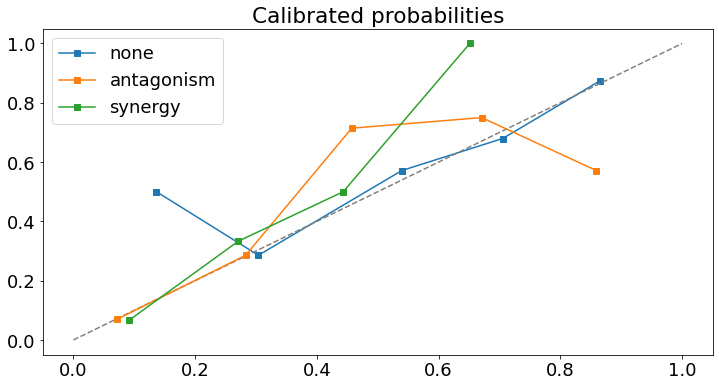

In [60]:
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value[0], fraction_of_positives[0], 's-', label='none')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.plot(mean_predicted_value[1], fraction_of_positives[1], 's-', label='antagonism')
plt.plot(mean_predicted_value[2], fraction_of_positives[2], 's-', label='synergy')
plt.title('Calibrated probabilities')
plt.legend()

Somehow probability calibration doesn't work for synergy prediction

<a id="test"></a> 
## Generate Predictions on the Test Set

In [61]:
X_drugs = pd.read_csv('../data/chemgenetics/nichols_testset_signed.csv', index_col=0)

In [62]:
X_drugs = X_drugs.iloc[:,np.where(np.isin(X_drugs.columns, gene_subset))[0]]

In [63]:
X_drugs.shape

(45, 350)

In [64]:
test_drugs = X_drugs.index.values

In [65]:
combs_test = list(itertools.combinations(test_drugs, 2))
combs_test = np.array([i[0]+"_"+i[1] for i in combs_test])

In [66]:
len(combs_test)

990

In [67]:
X_test = pd.DataFrame([utl.get_comb_feat_signed(X_drugs, c) for c in combs_test])

In [68]:
X_test = pd.get_dummies(X_test.astype('category'))

In [69]:
X_test.iloc[:10,:12]

ACRA_-2  ACRA_-1  ACRA_0  ACRA_1  ACRA_2  ACRA_3  ACRB_-2  ACRB_-1  ACRB_0  \
0        0        1       0       0       0       0        0        1       0   
1        1        0       0       0       0       0        1        0       0   
2        0        1       0       0       0       0        1        0       0   
3        0        1       0       0       0       0        0        1       0   
4        1        0       0       0       0       0        1        0       0   
5        0        1       0       0       0       0        0        1       0   
6        1        0       0       0       0       0        0        1       0   
7        0        1       0       0       0       0        0        1       0   
8        0        1       0       0       0       0        0        1       0   
9        0        1       0       0       0       0        0        1       0   

   ACRB_1  ACRB_2  ACRB_3  
0       0       0       0  
1       0       0       0  
2       0       0       0  
3       0       0       0  
4       0       0       0  
5       0       0       0  
6       0       0       0  
7       0       0       0  
8       0       0       0  
9       0       0       0

Pad some columns (as some are all zeros in the test set):

In [70]:
X_test.shape

(990, 1179)

In [71]:
cols_pad = np.setdiff1d(X_onehot.columns, X_test.columns)

In [72]:
for col in cols_pad:
    X_test[col] = 0

In [73]:
X_test = X_test.loc[:,np.isin(X_test.columns, X_onehot.columns)]

In [74]:
X_test = X_test[X_onehot.columns]

In [75]:
np.all(X_test.columns == X_onehot.columns)

True

In [76]:
# without probability calibration
y_test_proba = clf.fit(X_onehot, y).predict_proba(X_test)
antag = combs_test[y_test_proba[:,1] > antag_thresh]
syn = combs_test[y_test_proba[:,2] > syn_thresh]

Epoch 1/400
31/31 [==============================] - 0s 942us/step - loss: 0.8624 - accuracy: 0.6082
Epoch 2/400
31/31 [==============================] - 0s 1ms/step - loss: 0.4897 - accuracy: 0.7741
Epoch 3/400
31/31 [==============================] - 0s 993us/step - loss: 0.4733 - accuracy: 0.7964
Epoch 4/400
31/31 [==============================] - 0s 983us/step - loss: 0.4351 - accuracy: 0.8014
Epoch 5/400
31/31 [==============================] - 0s 952us/step - loss: 0.4197 - accuracy: 0.8053
Epoch 6/400
31/31 [==============================] - 0s 954us/step - loss: 0.3926 - accuracy: 0.8175
Epoch 7/400
31/31 [==============================] - 0s 1ms/step - loss: 0.3850 - accuracy: 0.8191
Epoch 8/400
31/31 [==============================] - 0s 1ms/step - loss: 0.4245 - accuracy: 0.8290
Epoch 9/400
31/31 [==============================] - 0s 1ms/step - loss: 0.3290 - accuracy: 0.8698
Epoch 10/400
31/31 [==============================] - 0s 975us/step - loss: 0.3306 - accuracy: 0.87

31/31 [==============================] - 0s 909us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 82/400
31/31 [==============================] - 0s 889us/step - loss: 0.0079 - accuracy: 0.9995
Epoch 83/400
31/31 [==============================] - 0s 924us/step - loss: 0.0111 - accuracy: 0.9996
Epoch 84/400
31/31 [==============================] - 0s 954us/step - loss: 0.0109 - accuracy: 0.9964
Epoch 85/400
31/31 [==============================] - 0s 960us/step - loss: 0.0086 - accuracy: 1.0000
Epoch 86/400
31/31 [==============================] - 0s 968us/step - loss: 0.0063 - accuracy: 1.0000
Epoch 87/400
31/31 [==============================] - 0s 980us/step - loss: 0.0054 - accuracy: 0.9997
Epoch 88/400
31/31 [==============================] - 0s 969us/step - loss: 0.0180 - accuracy: 0.9916
Epoch 89/400
31/31 [==============================] - 0s 977us/step - loss: 0.0280 - accuracy: 0.9944
Epoch 90/400
31/31 [==============================] - 0s 974us/step - loss: 0.0173 - accuracy: 

31/31 [==============================] - 0s 899us/step - loss: 0.0176 - accuracy: 0.9925
Epoch 161/400
31/31 [==============================] - 0s 884us/step - loss: 0.0534 - accuracy: 0.9780
Epoch 162/400
31/31 [==============================] - 0s 911us/step - loss: 0.0465 - accuracy: 0.9840
Epoch 163/400
31/31 [==============================] - 0s 935us/step - loss: 0.0420 - accuracy: 0.9861
Epoch 164/400
31/31 [==============================] - 0s 913us/step - loss: 0.0103 - accuracy: 0.9985
Epoch 165/400
31/31 [==============================] - 0s 959us/step - loss: 0.0099 - accuracy: 0.9953
Epoch 166/400
31/31 [==============================] - 0s 940us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 167/400
31/31 [==============================] - 0s 936us/step - loss: 0.0097 - accuracy: 0.9967
Epoch 168/400
31/31 [==============================] - 0s 935us/step - loss: 0.0137 - accuracy: 0.9954
Epoch 169/400
31/31 [==============================] - 0s 931us/step - loss: 0.0053 - a

31/31 [==============================] - 0s 905us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 240/400
31/31 [==============================] - 0s 947us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 241/400
31/31 [==============================] - 0s 971us/step - loss: 0.0021 - accuracy: 0.9985
Epoch 242/400
31/31 [==============================] - 0s 946us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 243/400
31/31 [==============================] - 0s 966us/step - loss: 0.0016 - accuracy: 0.9997
Epoch 244/400
31/31 [==============================] - 0s 958us/step - loss: 7.8598e-04 - accuracy: 1.0000
Epoch 245/400
31/31 [==============================] - 0s 965us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 246/400
31/31 [==============================] - 0s 959us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 247/400
31/31 [==============================] - 0s 991us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 248/400
31/31 [==============================] - 0s 955us/step - loss: 0.0011

31/31 [==============================] - 0s 835us/step - loss: 0.0118 - accuracy: 0.9954
Epoch 318/400
31/31 [==============================] - 0s 896us/step - loss: 0.0127 - accuracy: 0.9924
Epoch 319/400
31/31 [==============================] - 0s 913us/step - loss: 0.0111 - accuracy: 0.9954
Epoch 320/400
31/31 [==============================] - 0s 940us/step - loss: 0.0085 - accuracy: 0.9959
Epoch 321/400
31/31 [==============================] - 0s 946us/step - loss: 0.0021 - accuracy: 0.9998
Epoch 322/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0105 - accuracy: 0.9960
Epoch 323/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0176 - accuracy: 0.9918
Epoch 324/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0164 - accuracy: 0.9931
Epoch 325/400
31/31 [==============================] - 0s 996us/step - loss: 0.0358 - accuracy: 0.9941
Epoch 326/400
31/31 [==============================] - 0s 945us/step - loss: 0.0137 - accurac

31/31 [==============================] - 0s 970us/step - loss: 0.0014 - accuracy: 0.9996
Epoch 397/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 0.9980
Epoch 398/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0549 - accuracy: 0.9877
Epoch 399/400
31/31 [==============================] - 0s 964us/step - loss: 0.0302 - accuracy: 0.9887
Epoch 400/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0101 - accuracy: 0.9961
Epoch 1/400
31/31 [==============================] - 0s 913us/step - loss: 0.5905 - accuracy: 0.7774
Epoch 2/400
31/31 [==============================] - 0s 930us/step - loss: 0.4251 - accuracy: 0.8253
Epoch 3/400
31/31 [==============================] - 0s 1ms/step - loss: 0.3357 - accuracy: 0.8517
Epoch 4/400
31/31 [==============================] - 0s 1ms/step - loss: 0.3255 - accuracy: 0.8640
Epoch 5/400
31/31 [==============================] - 0s 1ms/step - loss: 0.2958 - accuracy: 0.8686
Epoch 

31/31 [==============================] - 0s 1ms/step - loss: 0.0067 - accuracy: 1.0000
Epoch 78/400
31/31 [==============================] - 0s 968us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 79/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 80/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 0.9998
Epoch 81/400
31/31 [==============================] - 0s 971us/step - loss: 0.0044 - accuracy: 0.9995
Epoch 82/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0075 - accuracy: 1.0000
Epoch 83/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 84/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 85/400
31/31 [==============================] - 0s 999us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 86/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 8

31/31 [==============================] - 0s 887us/step - loss: 0.0153 - accuracy: 0.9937
Epoch 158/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0077 - accuracy: 0.9971
Epoch 159/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 160/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0052 - accuracy: 0.9998
Epoch 161/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0078 - accuracy: 0.9971
Epoch 162/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 0.9993
Epoch 163/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0355 - accuracy: 0.9883
Epoch 164/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 165/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 166/400
31/31 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Ep

31/31 [==============================] - 0s 923us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 237/400
31/31 [==============================] - 0s 1ms/step - loss: 1.5237e-04 - accuracy: 1.0000
Epoch 238/400
31/31 [==============================] - 0s 1ms/step - loss: 1.8224e-04 - accuracy: 1.0000
Epoch 239/400
31/31 [==============================] - 0s 1ms/step - loss: 9.3371e-04 - accuracy: 0.9993
Epoch 240/400
31/31 [==============================] - 0s 995us/step - loss: 8.9476e-04 - accuracy: 1.0000
Epoch 241/400
31/31 [==============================] - 0s 1ms/step - loss: 2.7283e-04 - accuracy: 1.0000
Epoch 242/400
31/31 [==============================] - 0s 1ms/step - loss: 1.5823e-04 - accuracy: 1.0000
Epoch 243/400
31/31 [==============================] - 0s 1ms/step - loss: 5.2815e-04 - accuracy: 1.0000
Epoch 244/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 0.9988
Epoch 245/400
31/31 [==============================] - 0s 1000us/step - l

31/31 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 0.9983
Epoch 315/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9991
Epoch 316/400
31/31 [==============================] - 0s 980us/step - loss: 0.0031 - accuracy: 0.9994
Epoch 317/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 318/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 0.9997
Epoch 319/400
31/31 [==============================] - 0s 970us/step - loss: 6.6321e-04 - accuracy: 1.0000
Epoch 320/400
31/31 [==============================] - 0s 988us/step - loss: 0.0017 - accuracy: 0.9994
Epoch 321/400
31/31 [==============================] - 0s 973us/step - loss: 0.0025 - accuracy: 0.9986
Epoch 322/400
31/31 [==============================] - 0s 990us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 323/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0057 - accurac

31/31 [==============================] - 0s 918us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 393/400
31/31 [==============================] - 0s 880us/step - loss: 8.8293e-04 - accuracy: 1.0000
Epoch 394/400
31/31 [==============================] - 0s 937us/step - loss: 8.2636e-04 - accuracy: 1.0000
Epoch 395/400
31/31 [==============================] - 0s 922us/step - loss: 0.0012 - accuracy: 0.9987
Epoch 396/400
31/31 [==============================] - 0s 915us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 397/400
31/31 [==============================] - 0s 912us/step - loss: 4.2764e-04 - accuracy: 1.0000
Epoch 398/400
31/31 [==============================] - 0s 937us/step - loss: 0.0012 - accuracy: 0.9998
Epoch 399/400
31/31 [==============================] - 0s 910us/step - loss: 0.0050 - accuracy: 0.9970
Epoch 400/400
31/31 [==============================] - 0s 948us/step - loss: 0.0097 - accuracy: 0.9977
Epoch 1/400
31/31 [==============================] - 0s 874us/step - loss: 

31/31 [==============================] - 0s 970us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 73/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 74/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 75/400
31/31 [==============================] - 0s 999us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 76/400
31/31 [==============================] - 0s 961us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 77/400
31/31 [==============================] - 0s 953us/step - loss: 0.0053 - accuracy: 0.9989
Epoch 78/400
31/31 [==============================] - 0s 980us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 79/400
31/31 [==============================] - 0s 930us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 80/400
31/31 [==============================] - 0s 953us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 81/400
31/31 [==============================] - 0s 970us/step - loss: 0.0031 - accuracy: 0.99

31/31 [==============================] - 0s 834us/step - loss: 4.1306e-04 - accuracy: 1.0000
Epoch 152/400
31/31 [==============================] - 0s 875us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 153/400
31/31 [==============================] - 0s 880us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 154/400
31/31 [==============================] - 0s 949us/step - loss: 0.0018 - accuracy: 0.9994
Epoch 155/400
31/31 [==============================] - 0s 977us/step - loss: 0.0078 - accuracy: 0.9976
Epoch 156/400
31/31 [==============================] - 0s 964us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 157/400
31/31 [==============================] - 0s 973us/step - loss: 0.0058 - accuracy: 0.9989
Epoch 158/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0058 - accuracy: 0.9958
Epoch 159/400
31/31 [==============================] - 0s 960us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 160/400
31/31 [==============================] - 0s 957us/step - loss: 0.0057 -

31/31 [==============================] - 0s 979us/step - loss: 3.9300e-04 - accuracy: 1.0000
Epoch 230/400
31/31 [==============================] - 0s 964us/step - loss: 1.5365e-04 - accuracy: 1.0000
Epoch 231/400
31/31 [==============================] - 0s 962us/step - loss: 3.2850e-04 - accuracy: 1.0000
Epoch 232/400
31/31 [==============================] - 0s 952us/step - loss: 1.4655e-04 - accuracy: 1.0000
Epoch 233/400
31/31 [==============================] - 0s 931us/step - loss: 5.7963e-04 - accuracy: 1.0000
Epoch 234/400
31/31 [==============================] - 0s 942us/step - loss: 1.4569e-04 - accuracy: 1.0000
Epoch 235/400
31/31 [==============================] - 0s 953us/step - loss: 0.0013 - accuracy: 0.9992
Epoch 236/400
31/31 [==============================] - 0s 951us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 237/400
31/31 [==============================] - 0s 931us/step - loss: 9.8451e-04 - accuracy: 1.0000
Epoch 238/400
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 907us/step - loss: 0.0014 - accuracy: 0.9999
Epoch 308/400
31/31 [==============================] - 0s 952us/step - loss: 0.0037 - accuracy: 0.9985
Epoch 309/400
31/31 [==============================] - 0s 965us/step - loss: 0.0050 - accuracy: 0.9978
Epoch 310/400
31/31 [==============================] - 0s 961us/step - loss: 0.0049 - accuracy: 0.9995
Epoch 311/400
31/31 [==============================] - 0s 968us/step - loss: 0.0026 - accuracy: 0.9996
Epoch 312/400
31/31 [==============================] - 0s 965us/step - loss: 0.0292 - accuracy: 0.9915
Epoch 313/400
31/31 [==============================] - 0s 946us/step - loss: 0.0126 - accuracy: 0.9973
Epoch 314/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0200 - accuracy: 0.9921
Epoch 315/400
31/31 [==============================] - 0s 1ms/step - loss: 0.0047 - accuracy: 0.9998
Epoch 316/400
31/31 [==============================] - 0s 985us/step - loss: 0.0048 - accur

31/31 [==============================] - 0s 963us/step - loss: 0.0061 - accuracy: 0.9983
Epoch 386/400
31/31 [==============================] - 0s 976us/step - loss: 0.0017 - accuracy: 0.9998
Epoch 387/400
31/31 [==============================] - 0s 968us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 388/400
31/31 [==============================] - 0s 972us/step - loss: 8.4902e-04 - accuracy: 1.0000
Epoch 389/400
31/31 [==============================] - 0s 958us/step - loss: 3.2034e-04 - accuracy: 1.0000
Epoch 390/400
31/31 [==============================] - 0s 944us/step - loss: 2.3817e-04 - accuracy: 1.0000
Epoch 391/400
31/31 [==============================] - 0s 949us/step - loss: 5.7159e-04 - accuracy: 1.0000
Epoch 392/400
31/31 [==============================] - 0s 976us/step - loss: 9.7897e-04 - accuracy: 1.0000
Epoch 393/400
31/31 [==============================] - 0s 968us/step - loss: 7.2879e-04 - accuracy: 1.0000
Epoch 394/400
31/31 [==============================] - 0s 979us

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [77]:
np.setdiff1d(antag, syn)

array(['Actinomycin D_Carbenicillin', 'Carbenicillin_Cholate',
       'Ceftazidime_Dibucaine', 'Ceftazidime_Sds', 'Norfloxacin_Sds'],
      dtype='<U31')

In [78]:
np.setdiff1d(syn, antag)

array([], dtype='<U31')

In [79]:
np.intersect1d(antag, syn)

array([], dtype='<U31')

In [80]:
prob_uncalibr = pd.DataFrame(y_test_proba, index=combs_test,
             columns=['none', 'antag', 'synergy'])

In [81]:
prob_uncalibr.to_csv('nichols_test_pred.csv')

In [82]:
prob_uncalibr.sort_values('antag', ascending=False).iloc[:20,:]

none     antag       synergy
Ceftazidime_Sds                 0.000828  0.993918  7.235979e-05
Ceftazidime_Dibucaine           0.004907  0.993787  1.661344e-06
Carbenicillin_Cholate           0.007505  0.969688  8.477112e-10
Actinomycin D_Carbenicillin     0.337697  0.968132  3.495906e-07
Norfloxacin_Sds                 0.009118  0.927468  2.001516e-02
Bicyclomycin_Sds                0.003160  0.829825  3.525788e-01
Chlorpromazine_Propidiumiodide  0.350535  0.824278  1.158156e-04
Carbenicillin_Chlorpromazine    0.387248  0.783292  4.814474e-02
Carbenicillin_Peroxide          0.315243  0.782581  8.030245e-06
Ceftazidime_Ethanol             0.891616  0.781893  7.107492e-05
Carbenicillin_Tetracycline      0.691366  0.744082  1.902530e-06
Ceftazidime_Deoxycholate        0.009837  0.730025  8.119492e-03
Deoxycholate_Norfloxacin        0.875865  0.721313  1.417212e-06
Chlorpromazine_Taurocholate     0.014236  0.682616  4.285143e-01
Nalidixicacid_Sds               0.077294  0.672223  4.633752e-02
Ceftazidime_Nigericin           0.293631  0.669118  1.402568e-04
Bicyclomycin_Calcofluor         0.787446  0.659371  9.558409e-06
Chlorpromazine_Radicicol        0.077265  0.649487  8.150664e-02
Ceftazidime_Propidiumiodide     0.923967  0.606943  1.772249e-09
Carbenicillin_Taurocholate      0.213133  0.597699  9.235053e-06

In [83]:
prob_uncalibr.sort_values('synergy', ascending=False).iloc[:20,:]

none         antag   synergy
Taurocholate_Vancomycin       0.000252  3.107250e-05  0.994437
Cholate_Norfloxacin           0.000976  1.435762e-04  0.957581
Ampicillin_Cefoxitin          0.283108  1.130596e-09  0.909825
Nalidixicacid_Streptonigrin   0.337144  1.512657e-08  0.899042
Cholate_Glufosfomycin         0.002495  1.467530e-03  0.864985
Actinomycin D_Taurocholate    0.002719  1.100753e-01  0.812520
Cefoxitin_Ceftazidime         0.006208  7.094226e-06  0.775118
Ethidiumbromide_Taurocholate  0.045877  1.084435e-02  0.689716
Chir090_Uv                    0.166346  8.963334e-05  0.687720
Azidothymidine_Sds            0.140129  2.581180e-04  0.656014
Dibucaine_Tritonx             0.050311  4.054431e-03  0.610242
Ampicillin_Carbenicillin      0.017569  3.658904e-04  0.590459
Cefoxitin_Chir090             0.006479  1.456424e-04  0.588050
Azidothymidine_Ethanol        0.173216  7.098977e-06  0.584195
Norfloxacin_Taurocholate      0.093554  1.770906e-03  0.582378
Taurocholate_Tunicamycin      0.038948  2.446922e-03  0.562317
Epinephrine_Sds               0.480812  6.161144e-05  0.521593
Deoxycholate_Taurocholate     0.153480  9.691446e-04  0.514931
Sds_Sulfamethizole            0.050359  5.738687e-01  0.496474
Chlorpromazine_Peroxide       0.019627  4.530441e-02  0.461422

In [84]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10)

# with calibration (using stratified KFold for calibrator)
probs = dict()
for i in range(n_classes):
#    clf_calib = CalibratedClassifierCV(clf.estimators_[i], cv=skf, method='isotonic')
    clf_calib = CalibratedClassifierCV(clf, cv=skf, method='isotonic')
    probs[i] = clf_calib.fit(X_onehot, y[:,i]).predict_proba(X_test)

Epoch 1/400
28/28 [==============================] - 0s 919us/step - loss: 0.6965 - accuracy: 0.6458
Epoch 2/400
28/28 [==============================] - 0s 956us/step - loss: 0.5068 - accuracy: 0.7509
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4866 - accuracy: 0.7579
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4601 - accuracy: 0.7945
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3908 - accuracy: 0.8204
Epoch 6/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4075 - accuracy: 0.8067
Epoch 7/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4000 - accuracy: 0.8108
Epoch 8/400
28/28 [==============================] - 0s 952us/step - loss: 0.3587 - accuracy: 0.8430
Epoch 9/400
28/28 [==============================] - 0s 947us/step - loss: 0.3405 - accuracy: 0.8574
Epoch 10/400
28/28 [==============================] - 0s 984us/step - loss: 0.3702 - accuracy: 0.8515

28/28 [==============================] - 0s 909us/step - loss: 0.0232 - accuracy: 0.9933
Epoch 82/400
28/28 [==============================] - 0s 910us/step - loss: 0.0279 - accuracy: 0.9962
Epoch 83/400
28/28 [==============================] - 0s 947us/step - loss: 0.0219 - accuracy: 0.9982
Epoch 84/400
28/28 [==============================] - 0s 939us/step - loss: 0.0164 - accuracy: 0.9960
Epoch 85/400
28/28 [==============================] - 0s 949us/step - loss: 0.0132 - accuracy: 0.9968
Epoch 86/400
28/28 [==============================] - 0s 954us/step - loss: 0.0146 - accuracy: 0.9993
Epoch 87/400
28/28 [==============================] - 0s 975us/step - loss: 0.0088 - accuracy: 0.9982
Epoch 88/400
28/28 [==============================] - 0s 944us/step - loss: 0.0091 - accuracy: 1.0000
Epoch 89/400
28/28 [==============================] - 0s 973us/step - loss: 0.0165 - accuracy: 0.9951
Epoch 90/400
28/28 [==============================] - 0s 992us/step - loss: 0.0158 - accuracy: 

28/28 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 162/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 163/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0044 - accuracy: 0.9990
Epoch 164/400
28/28 [==============================] - 0s 972us/step - loss: 0.0041 - accuracy: 0.9978
Epoch 165/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 0.9998
Epoch 166/400
28/28 [==============================] - 0s 981us/step - loss: 0.0255 - accuracy: 0.9901
Epoch 167/400
28/28 [==============================] - 0s 963us/step - loss: 0.0387 - accuracy: 0.9818
Epoch 168/400
28/28 [==============================] - 0s 963us/step - loss: 0.0102 - accuracy: 0.9970
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 0.9982
Epoch 170/400
28/28 [==============================] - 0s 929us/step - loss: 0.0019 - accuracy: 1

28/28 [==============================] - 0s 996us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 242/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 0.9983
Epoch 243/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0080 - accuracy: 0.9968
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0039 - accuracy: 0.9994
Epoch 245/400
28/28 [==============================] - 0s 988us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 247/400
28/28 [==============================] - 0s 977us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 249/400
28/28 [==============================] - 0s 987us/step - loss: 0.0037 - accuracy: 0.9980
Epoch 250/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0

28/28 [==============================] - 0s 945us/step - loss: 0.0272 - accuracy: 0.9938
Epoch 321/400
28/28 [==============================] - 0s 938us/step - loss: 0.0199 - accuracy: 0.9894
Epoch 322/400
28/28 [==============================] - 0s 942us/step - loss: 0.0071 - accuracy: 0.9975
Epoch 323/400
28/28 [==============================] - 0s 980us/step - loss: 0.0030 - accuracy: 0.9996
Epoch 324/400
28/28 [==============================] - 0s 962us/step - loss: 0.0069 - accuracy: 0.9983
Epoch 325/400
28/28 [==============================] - 0s 954us/step - loss: 0.0125 - accuracy: 0.9962
Epoch 326/400
28/28 [==============================] - 0s 963us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 327/400
28/28 [==============================] - 0s 969us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 328/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 329/400
28/28 [==============================] - 0s 994us/step - loss: 0.0012 - acc

28/28 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 399/400
28/28 [==============================] - 0s 996us/step - loss: 4.3603e-04 - accuracy: 1.0000
Epoch 400/400
28/28 [==============================] - 0s 1ms/step - loss: 3.6121e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 913us/step - loss: 0.6982 - accuracy: 0.6719
Epoch 2/400
28/28 [==============================] - 0s 936us/step - loss: 0.5509 - accuracy: 0.7294
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4961 - accuracy: 0.7605
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4353 - accuracy: 0.8092
Epoch 5/400
28/28 [==============================] - 0s 986us/step - loss: 0.4400 - accuracy: 0.7967
Epoch 6/400
28/28 [==============================] - 0s 994us/step - loss: 0.4109 - accuracy: 0.8304
Epoch 7/400
28/28 [==============================] - 0s 958us/step - loss: 0.3827 - accuracy: 0.8358
Epoch 8/400
28/28 [==============================] - 0s 970us/step - loss: 0.3746 - accuracy: 0.8531
Epoch 9/400
28/28 [==============================] - 0s 954us/step - loss: 0.3488 - accuracy: 0.8663
Epoch 10/400
28/28 [==============================] - 0s 937us/step - loss: 0.3566 - accuracy: 0.8392
Epoch

28/28 [==============================] - 0s 984us/step - loss: 0.0136 - accuracy: 0.9982
Epoch 82/400
28/28 [==============================] - 0s 934us/step - loss: 0.0177 - accuracy: 0.9952
Epoch 83/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0083 - accuracy: 1.0000
Epoch 84/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0066 - accuracy: 1.0000
Epoch 85/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0118 - accuracy: 0.9996
Epoch 86/400
28/28 [==============================] - 0s 964us/step - loss: 0.0082 - accuracy: 1.0000
Epoch 87/400
28/28 [==============================] - 0s 976us/step - loss: 0.0077 - accuracy: 1.0000
Epoch 88/400
28/28 [==============================] - 0s 961us/step - loss: 0.0088 - accuracy: 0.9991
Epoch 89/400
28/28 [==============================] - 0s 961us/step - loss: 0.0109 - accuracy: 0.9973
Epoch 90/400
28/28 [==============================] - 0s 960us/step - loss: 0.0295 - accuracy: 0.9942

28/28 [==============================] - 0s 993us/step - loss: 0.0194 - accuracy: 0.9968
Epoch 162/400
28/28 [==============================] - 0s 918us/step - loss: 0.0129 - accuracy: 0.9961
Epoch 163/400
28/28 [==============================] - 0s 961us/step - loss: 0.0186 - accuracy: 0.9949
Epoch 164/400
28/28 [==============================] - 0s 943us/step - loss: 0.0103 - accuracy: 0.9964
Epoch 165/400
28/28 [==============================] - 0s 947us/step - loss: 0.0156 - accuracy: 0.9918
Epoch 166/400
28/28 [==============================] - 0s 946us/step - loss: 0.0057 - accuracy: 0.9996
Epoch 167/400
28/28 [==============================] - 0s 979us/step - loss: 0.0397 - accuracy: 0.9881
Epoch 168/400
28/28 [==============================] - 0s 989us/step - loss: 0.0565 - accuracy: 0.9784
Epoch 169/400
28/28 [==============================] - 0s 966us/step - loss: 0.0562 - accuracy: 0.9823
Epoch 170/400
28/28 [==============================] - 0s 988us/step - loss: 0.0992 - a

28/28 [==============================] - 0s 867us/step - loss: 0.0107 - accuracy: 0.9960
Epoch 242/400
28/28 [==============================] - 0s 884us/step - loss: 0.0040 - accuracy: 0.9991
Epoch 243/400
28/28 [==============================] - 0s 912us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 244/400
28/28 [==============================] - 0s 948us/step - loss: 0.0059 - accuracy: 0.9973
Epoch 245/400
28/28 [==============================] - 0s 945us/step - loss: 8.9048e-04 - accuracy: 1.0000
Epoch 246/400
28/28 [==============================] - 0s 958us/step - loss: 0.0011 - accuracy: 0.9994
Epoch 247/400
28/28 [==============================] - 0s 929us/step - loss: 0.0017 - accuracy: 0.9998
Epoch 248/400
28/28 [==============================] - 0s 952us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 249/400
28/28 [==============================] - 0s 949us/step - loss: 8.4638e-04 - accuracy: 1.0000
Epoch 250/400
28/28 [==============================] - 0s 982us/step - loss: 9.

28/28 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 0.9992
Epoch 321/400
28/28 [==============================] - 0s 974us/step - loss: 0.0030 - accuracy: 0.9988
Epoch 322/400
28/28 [==============================] - 0s 995us/step - loss: 0.0089 - accuracy: 0.9953
Epoch 323/400
28/28 [==============================] - 0s 994us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 324/400
28/28 [==============================] - 0s 992us/step - loss: 0.0019 - accuracy: 0.9989
Epoch 325/400
28/28 [==============================] - 0s 976us/step - loss: 8.9223e-04 - accuracy: 1.0000
Epoch 326/400
28/28 [==============================] - 0s 952us/step - loss: 8.0300e-04 - accuracy: 1.0000
Epoch 327/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 328/400
28/28 [==============================] - 0s 973us/step - loss: 0.0020 - accuracy: 0.9988
Epoch 329/400
28/28 [==============================] - 0s 975us/step - loss: 4.3273

28/28 [==============================] - 0s 965us/step - loss: 8.9773e-04 - accuracy: 1.0000
Epoch 399/400
28/28 [==============================] - 0s 975us/step - loss: 0.0012 - accuracy: 0.9992
Epoch 400/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 933us/step - loss: 0.6664 - accuracy: 0.6845
Epoch 2/400
28/28 [==============================] - 0s 964us/step - loss: 0.4771 - accuracy: 0.7769
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4642 - accuracy: 0.7739
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4436 - accuracy: 0.7993
Epoch 5/400
28/28 [==============================] - 0s 998us/step - loss: 0.4332 - accuracy: 0.8146
Epoch 6/400
28/28 [==============================] - 0s 964us/step - loss: 0.3826 - accuracy: 0.8213
Epoch 7/400
28/28 [==============================] - 0s 935us/step - loss: 0.3881 - accuracy: 0.8353
Epoch 8/400
28/28 [==============================] - 0s 942us/step - loss: 0.4033 - accuracy: 0.8258
Epoch 9/400
28/28 [==============================] - 0s 999us/step - loss: 0.3536 - accuracy: 0.8675
Epoch 10/400
28/28 [==============================] - 0s 958us/step - loss: 0.3771 - accuracy: 0.8468
Epoch

28/28 [==============================] - 0s 1ms/step - loss: 0.0113 - accuracy: 0.9997
Epoch 82/400
28/28 [==============================] - 0s 982us/step - loss: 0.0130 - accuracy: 0.9991
Epoch 83/400
28/28 [==============================] - 0s 953us/step - loss: 0.0157 - accuracy: 0.9957
Epoch 84/400
28/28 [==============================] - 0s 996us/step - loss: 0.0129 - accuracy: 0.9986
Epoch 85/400
28/28 [==============================] - 0s 995us/step - loss: 0.0169 - accuracy: 0.9984
Epoch 86/400
28/28 [==============================] - 0s 992us/step - loss: 0.0103 - accuracy: 0.9985
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0063 - accuracy: 1.0000
Epoch 88/400
28/28 [==============================] - 0s 983us/step - loss: 0.0062 - accuracy: 1.0000
Epoch 89/400
28/28 [==============================] - 0s 972us/step - loss: 0.0079 - accuracy: 0.9988
Epoch 90/400
28/28 [==============================] - 0s 974us/step - loss: 0.0135 - accuracy: 0.99

28/28 [==============================] - 0s 828us/step - loss: 0.0315 - accuracy: 0.9853
Epoch 162/400
28/28 [==============================] - 0s 849us/step - loss: 0.0509 - accuracy: 0.9808
Epoch 163/400
28/28 [==============================] - 0s 804us/step - loss: 0.0349 - accuracy: 0.9899
Epoch 164/400
28/28 [==============================] - 0s 857us/step - loss: 0.0142 - accuracy: 0.9976
Epoch 165/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0080 - accuracy: 0.9954
Epoch 166/400
28/28 [==============================] - 0s 796us/step - loss: 0.0060 - accuracy: 0.9987
Epoch 167/400
28/28 [==============================] - 0s 843us/step - loss: 0.0069 - accuracy: 0.9994
Epoch 168/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0183 - accuracy: 0.9957
Epoch 169/400
28/28 [==============================] - 0s 939us/step - loss: 0.0051 - accuracy: 0.9984
Epoch 170/400
28/28 [==============================] - 0s 921us/step - loss: 0.0030 - accur

28/28 [==============================] - 0s 1ms/step - loss: 0.0065 - accuracy: 0.9989
Epoch 242/400
28/28 [==============================] - 0s 988us/step - loss: 0.0095 - accuracy: 0.9966
Epoch 243/400
28/28 [==============================] - 0s 982us/step - loss: 0.0085 - accuracy: 0.9973
Epoch 244/400
28/28 [==============================] - 0s 980us/step - loss: 0.0040 - accuracy: 0.9991
Epoch 245/400
28/28 [==============================] - 0s 973us/step - loss: 0.0040 - accuracy: 0.9974
Epoch 246/400
28/28 [==============================] - 0s 939us/step - loss: 0.0063 - accuracy: 0.9998
Epoch 247/400
28/28 [==============================] - 0s 948us/step - loss: 0.0059 - accuracy: 0.9984
Epoch 248/400
28/28 [==============================] - 0s 954us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 249/400
28/28 [==============================] - 0s 947us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 250/400
28/28 [==============================] - 0s 951us/step - loss: 0.0015 - acc

28/28 [==============================] - 0s 1ms/step - loss: 0.0034 - accuracy: 0.9994
Epoch 321/400
28/28 [==============================] - 0s 981us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 322/400
28/28 [==============================] - 0s 996us/step - loss: 0.0035 - accuracy: 0.9985
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0066 - accuracy: 0.9967
Epoch 324/400
28/28 [==============================] - 0s 992us/step - loss: 0.0118 - accuracy: 0.9973
Epoch 325/400
28/28 [==============================] - 0s 948us/step - loss: 0.0041 - accuracy: 0.9979
Epoch 326/400
28/28 [==============================] - 0s 982us/step - loss: 0.0093 - accuracy: 0.9968
Epoch 327/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0132 - accuracy: 0.9957
Epoch 328/400
28/28 [==============================] - 0s 978us/step - loss: 0.0051 - accuracy: 0.9971
Epoch 329/400
28/28 [==============================] - 0s 953us/step - loss: 0.0020 - accurac

28/28 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 0.9994
Epoch 400/400
28/28 [==============================] - 0s 986us/step - loss: 0.0043 - accuracy: 0.9995
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 963us/step - loss: 0.7915 - accuracy: 0.6264
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.5047 - accuracy: 0.7619
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4754 - accuracy: 0.7697
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4613 - accuracy: 0.7866
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4472 - accuracy: 0.8038
Epoch 6/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4169 - accuracy: 0.8216
Epoch 7/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4172 - accuracy: 0.8065
Epoch 8/400
28/28 [==============================] - 0s 978us/step - loss: 0.3724 - accuracy: 0.8474
Epoch 9/400
28/28 [==============================] - 0s 962us/step - loss: 0.3335 - accuracy: 0.8609
Epoch 10/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3453 - accuracy: 0.8656
Epoch 11/400
28

28/28 [==============================] - 0s 875us/step - loss: 0.0104 - accuracy: 1.0000
Epoch 83/400
28/28 [==============================] - 0s 871us/step - loss: 0.0117 - accuracy: 0.9994
Epoch 84/400
28/28 [==============================] - 0s 911us/step - loss: 0.0133 - accuracy: 0.9971
Epoch 85/400
28/28 [==============================] - 0s 943us/step - loss: 0.0267 - accuracy: 0.9925
Epoch 86/400
28/28 [==============================] - 0s 925us/step - loss: 0.0196 - accuracy: 0.9950
Epoch 87/400
28/28 [==============================] - 0s 963us/step - loss: 0.0196 - accuracy: 0.9974
Epoch 88/400
28/28 [==============================] - 0s 954us/step - loss: 0.0165 - accuracy: 0.9984
Epoch 89/400
28/28 [==============================] - 0s 944us/step - loss: 0.0172 - accuracy: 0.9963
Epoch 90/400
28/28 [==============================] - 0s 965us/step - loss: 0.0291 - accuracy: 0.9941
Epoch 91/400
28/28 [==============================] - 0s 944us/step - loss: 0.0329 - accuracy: 

Epoch 162/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0110 - accuracy: 0.9966
Epoch 163/400
28/28 [==============================] - 0s 983us/step - loss: 0.0079 - accuracy: 0.9987
Epoch 164/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 165/400
28/28 [==============================] - 0s 968us/step - loss: 0.0083 - accuracy: 0.9970
Epoch 166/400
28/28 [==============================] - 0s 988us/step - loss: 0.0204 - accuracy: 0.9937
Epoch 167/400
28/28 [==============================] - 0s 975us/step - loss: 0.0350 - accuracy: 0.9890
Epoch 168/400
28/28 [==============================] - 0s 956us/step - loss: 0.0541 - accuracy: 0.9773
Epoch 169/400
28/28 [==============================] - 0s 953us/step - loss: 0.0208 - accuracy: 0.9911
Epoch 170/400
28/28 [==============================] - 0s 944us/step - loss: 0.0081 - accuracy: 0.9990
Epoch 171/400
28/28 [==============================] - 0s 949us/step - loss: 

28/28 [==============================] - 0s 1ms/step - loss: 0.0060 - accuracy: 0.9974
Epoch 242/400
28/28 [==============================] - 0s 949us/step - loss: 0.0054 - accuracy: 0.9992
Epoch 243/400
28/28 [==============================] - 0s 993us/step - loss: 0.0150 - accuracy: 0.9968
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 245/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 0.9994
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0034 - accuracy: 0.9980
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 0.9986
Epoch 250/400
28/28 [==============================] - 0s 976us/step - loss: 0.0022 - accuracy: 0.999

Epoch 321/400
28/28 [==============================] - 0s 1ms/step - loss: 7.9965e-04 - accuracy: 0.9998
Epoch 322/400
28/28 [==============================] - 0s 954us/step - loss: 9.1134e-04 - accuracy: 1.0000
Epoch 323/400
28/28 [==============================] - 0s 947us/step - loss: 0.0013 - accuracy: 0.9992
Epoch 324/400
28/28 [==============================] - 0s 941us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 325/400
28/28 [==============================] - 0s 965us/step - loss: 4.7725e-04 - accuracy: 0.9998
Epoch 326/400
28/28 [==============================] - 0s 973us/step - loss: 0.0119 - accuracy: 0.9954
Epoch 327/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0070 - accuracy: 0.9985
Epoch 328/400
28/28 [==============================] - 0s 966us/step - loss: 0.0089 - accuracy: 0.9962
Epoch 329/400
28/28 [==============================] - 0s 935us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 330/400
28/28 [==============================] - 0s 946us/s

28/28 [==============================] - 0s 891us/step - loss: 0.0216 - accuracy: 0.9922
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 873us/step - loss: 0.6949 - accuracy: 0.6658
Epoch 2/400
28/28 [==============================] - 0s 877us/step - loss: 0.5005 - accuracy: 0.7685
Epoch 3/400
28/28 [==============================] - 0s 958us/step - loss: 0.4719 - accuracy: 0.7698
Epoch 4/400
28/28 [==============================] - 0s 961us/step - loss: 0.4335 - accuracy: 0.7973
Epoch 5/400
28/28 [==============================] - 0s 939us/step - loss: 0.4182 - accuracy: 0.8107
Epoch 6/400
28/28 [==============================] - 0s 939us/step - loss: 0.4365 - accuracy: 0.8085
Epoch 7/400
28/28 [==============================] - 0s 942us/step - loss: 0.4259 - accuracy: 0.8020
Epoch 8/400
28/28 [==============================] - 0s 947us/step - loss: 0.3924 - accuracy: 0.8432
Epoch 9/400
28/28 [==============================] - 0s 921us/step - loss: 0.3715 - accuracy: 0.8505
Epoch 10/400
28/28 [==============================] - 0s 938us/step - loss: 0.3324 - accuracy: 0.8682
E

28/28 [==============================] - 0s 893us/step - loss: 0.0069 - accuracy: 1.0000
Epoch 82/400
28/28 [==============================] - 0s 892us/step - loss: 0.0067 - accuracy: 1.0000
Epoch 83/400
28/28 [==============================] - 0s 881us/step - loss: 0.0072 - accuracy: 1.0000
Epoch 84/400
28/28 [==============================] - 0s 977us/step - loss: 0.0129 - accuracy: 0.9957
Epoch 85/400
28/28 [==============================] - 0s 984us/step - loss: 0.0065 - accuracy: 1.0000
Epoch 86/400
28/28 [==============================] - 0s 997us/step - loss: 0.0053 - accuracy: 1.0000
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0069 - accuracy: 0.9995
Epoch 88/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0155 - accuracy: 0.9966
Epoch 89/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0124 - accuracy: 0.9981
Epoch 90/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0063 - accuracy: 1.0000
E

28/28 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 162/400
28/28 [==============================] - 0s 938us/step - loss: 0.0030 - accuracy: 0.9991
Epoch 163/400
28/28 [==============================] - 0s 965us/step - loss: 0.0040 - accuracy: 0.9992
Epoch 164/400
28/28 [==============================] - 0s 970us/step - loss: 0.0167 - accuracy: 0.9931
Epoch 165/400
28/28 [==============================] - 0s 967us/step - loss: 0.0123 - accuracy: 0.9949
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 0.9989
Epoch 167/400
28/28 [==============================] - 0s 949us/step - loss: 0.0120 - accuracy: 0.9950
Epoch 168/400
28/28 [==============================] - 0s 976us/step - loss: 0.0064 - accuracy: 1.0000
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 170/400
28/28 [==============================] - 0s 971us/step - loss: 0.0058 - accurac

28/28 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 242/400
28/28 [==============================] - 0s 961us/step - loss: 0.0068 - accuracy: 1.0000
Epoch 243/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0045 - accuracy: 0.9987
Epoch 244/400
28/28 [==============================] - 0s 991us/step - loss: 0.0239 - accuracy: 0.9901
Epoch 245/400
28/28 [==============================] - 0s 998us/step - loss: 0.0470 - accuracy: 0.9845
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0231 - accuracy: 0.9941
Epoch 247/400
28/28 [==============================] - 0s 997us/step - loss: 0.0373 - accuracy: 0.9894
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0376 - accuracy: 0.9874
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0641 - accuracy: 0.9776
Epoch 250/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0461 - accuracy: 0.9

28/28 [==============================] - 0s 1ms/step - loss: 0.0106 - accuracy: 0.9965
Epoch 321/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0151 - accuracy: 0.9969
Epoch 322/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0069 - accuracy: 0.9978
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0077 - accuracy: 0.9962
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0061 - accuracy: 0.9966
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0135 - accuracy: 0.9940
Epoch 326/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0094 - accuracy: 0.9938
Epoch 327/400
28/28 [==============================] - 0s 994us/step - loss: 0.0144 - accuracy: 0.9914
Epoch 328/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0127 - accuracy: 0.9922
Epoch 329/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0075 - accuracy: 0.9978
Ep

28/28 [==============================] - 0s 955us/step - loss: 0.0364 - accuracy: 0.9949
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 1ms/step - loss: 0.6985 - accuracy: 0.6647
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4947 - accuracy: 0.7535
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4893 - accuracy: 0.7602
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4360 - accuracy: 0.8187
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4058 - accuracy: 0.8190
Epoch 6/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3794 - accuracy: 0.8324
Epoch 7/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3946 - accuracy: 0.8238
Epoch 8/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3819 - accuracy: 0.8247
Epoch 9/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3462 - accuracy: 0.8567
Epoch 10/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3276 - accuracy: 0.8661
Epoch 11/400
28/28 [=

28/28 [==============================] - 0s 929us/step - loss: 0.0092 - accuracy: 1.0000
Epoch 83/400
28/28 [==============================] - 0s 954us/step - loss: 0.0057 - accuracy: 0.9998
Epoch 84/400
28/28 [==============================] - 0s 992us/step - loss: 0.0103 - accuracy: 0.9970
Epoch 85/400
28/28 [==============================] - 0s 952us/step - loss: 0.0168 - accuracy: 0.9961
Epoch 86/400
28/28 [==============================] - 0s 947us/step - loss: 0.0062 - accuracy: 0.9996
Epoch 87/400
28/28 [==============================] - 0s 951us/step - loss: 0.0086 - accuracy: 0.9993
Epoch 88/400
28/28 [==============================] - 0s 939us/step - loss: 0.0063 - accuracy: 0.9998
Epoch 89/400
28/28 [==============================] - 0s 923us/step - loss: 0.0070 - accuracy: 1.0000
Epoch 90/400
28/28 [==============================] - 0s 949us/step - loss: 0.0047 - accuracy: 0.9999
Epoch 91/400
28/28 [==============================] - 0s 975us/step - loss: 0.0082 - accuracy: 

28/28 [==============================] - 0s 947us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 163/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 164/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 165/400
28/28 [==============================] - 0s 962us/step - loss: 0.0025 - accuracy: 0.9990
Epoch 166/400
28/28 [==============================] - 0s 984us/step - loss: 0.0043 - accuracy: 0.9968
Epoch 167/400
28/28 [==============================] - 0s 926us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 168/400
28/28 [==============================] - 0s 936us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 169/400
28/28 [==============================] - 0s 948us/step - loss: 0.0016 - accuracy: 0.9996
Epoch 170/400
28/28 [==============================] - 0s 953us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 171/400
28/28 [==============================] - 0s 938us/step - loss: 0.0014 - accur

28/28 [==============================] - 0s 1ms/step - loss: 8.6020e-04 - accuracy: 1.0000
Epoch 242/400
28/28 [==============================] - 0s 958us/step - loss: 7.8092e-04 - accuracy: 1.0000
Epoch 243/400
28/28 [==============================] - 0s 950us/step - loss: 8.7962e-04 - accuracy: 1.0000
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 1.9406e-04 - accuracy: 1.0000
Epoch 245/400
28/28 [==============================] - 0s 939us/step - loss: 2.9571e-04 - accuracy: 1.0000
Epoch 246/400
28/28 [==============================] - 0s 934us/step - loss: 6.5874e-04 - accuracy: 0.9998
Epoch 247/400
28/28 [==============================] - 0s 952us/step - loss: 0.0042 - accuracy: 0.9992
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0318 - accuracy: 0.9878
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 0.1319 - accuracy: 0.9547
Epoch 250/400
28/28 [==============================] - 0s 1ms/step - lo

28/28 [==============================] - 0s 963us/step - loss: 9.6107e-04 - accuracy: 1.0000
Epoch 321/400
28/28 [==============================] - 0s 977us/step - loss: 2.6019e-04 - accuracy: 1.0000
Epoch 322/400
28/28 [==============================] - 0s 928us/step - loss: 1.6096e-04 - accuracy: 1.0000
Epoch 323/400
28/28 [==============================] - 0s 951us/step - loss: 6.6476e-04 - accuracy: 1.0000
Epoch 324/400
28/28 [==============================] - 0s 925us/step - loss: 3.1679e-04 - accuracy: 1.0000
Epoch 325/400
28/28 [==============================] - 0s 990us/step - loss: 5.9466e-04 - accuracy: 1.0000
Epoch 326/400
28/28 [==============================] - 0s 934us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 327/400
28/28 [==============================] - 0s 943us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 328/400
28/28 [==============================] - 0s 969us/step - loss: 2.8477e-04 - accuracy: 1.0000
Epoch 329/400
28/28 [==============================] - 0s 1

28/28 [==============================] - 0s 893us/step - loss: 0.0037 - accuracy: 0.9993
Epoch 399/400
28/28 [==============================] - 0s 888us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 400/400
28/28 [==============================] - 0s 888us/step - loss: 6.8262e-04 - accuracy: 0.9998
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 884us/step - loss: 0.7669 - accuracy: 0.6001
Epoch 2/400
28/28 [==============================] - 0s 878us/step - loss: 0.5590 - accuracy: 0.7283
Epoch 3/400
28/28 [==============================] - 0s 948us/step - loss: 0.5006 - accuracy: 0.7477
Epoch 4/400
28/28 [==============================] - 0s 1000us/step - loss: 0.4838 - accuracy: 0.7791
Epoch 5/400
28/28 [==============================] - 0s 961us/step - loss: 0.4807 - accuracy: 0.7749
Epoch 6/400
28/28 [==============================] - 0s 973us/step - loss: 0.4070 - accuracy: 0.8384
Epoch 7/400
28/28 [==============================] - 0s 969us/step - loss: 0.3811 - accuracy: 0.8257
Epoch 8/400
28/28 [==============================] - 0s 982us/step - loss: 0.4131 - accuracy: 0.8210
Epoch 9/400
28/28 [==============================] - 0s 943us/step - loss: 0.3690 - accuracy: 0.8332
Epoch 10/400
28/28 [==============================] - 0s 958us/step - loss: 0.3595 - accuracy: 0.8616


28/28 [==============================] - 0s 952us/step - loss: 0.0271 - accuracy: 0.9950
Epoch 82/400
28/28 [==============================] - 0s 910us/step - loss: 0.0151 - accuracy: 1.0000
Epoch 83/400
28/28 [==============================] - 0s 911us/step - loss: 0.0177 - accuracy: 0.9957
Epoch 84/400
28/28 [==============================] - 0s 948us/step - loss: 0.0165 - accuracy: 0.9957
Epoch 85/400
28/28 [==============================] - 0s 942us/step - loss: 0.0102 - accuracy: 1.0000
Epoch 86/400
28/28 [==============================] - 0s 954us/step - loss: 0.0075 - accuracy: 1.0000
Epoch 87/400
28/28 [==============================] - 0s 934us/step - loss: 0.0096 - accuracy: 1.0000
Epoch 88/400
28/28 [==============================] - 0s 941us/step - loss: 0.0091 - accuracy: 0.9982
Epoch 89/400
28/28 [==============================] - 0s 918us/step - loss: 0.0109 - accuracy: 0.9992
Epoch 90/400
28/28 [==============================] - 0s 941us/step - loss: 0.0177 - accuracy: 

28/28 [==============================] - 0s 994us/step - loss: 0.0057 - accuracy: 0.9989
Epoch 161/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0079 - accuracy: 0.9982
Epoch 162/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0065 - accuracy: 0.9970
Epoch 163/400
28/28 [==============================] - 0s 989us/step - loss: 0.0123 - accuracy: 0.9924
Epoch 164/400
28/28 [==============================] - 0s 980us/step - loss: 0.0067 - accuracy: 1.0000
Epoch 165/400
28/28 [==============================] - 0s 988us/step - loss: 0.0076 - accuracy: 0.9976
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 167/400
28/28 [==============================] - 0s 972us/step - loss: 0.0094 - accuracy: 0.9987
Epoch 168/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0151 - accuracy: 0.9951
Epoch 169/400
28/28 [==============================] - 0s 971us/step - loss: 0.0072 - accuracy:

28/28 [==============================] - 0s 882us/step - loss: 6.4889e-04 - accuracy: 1.0000
Epoch 240/400
28/28 [==============================] - 0s 915us/step - loss: 0.0019 - accuracy: 0.9996
Epoch 241/400
28/28 [==============================] - 0s 934us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 242/400
28/28 [==============================] - 0s 959us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 243/400
28/28 [==============================] - 0s 986us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 244/400
28/28 [==============================] - 0s 952us/step - loss: 0.0035 - accuracy: 0.9992
Epoch 245/400
28/28 [==============================] - 0s 997us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 248/400
28/28 [==============================] - 0s 953us/step - loss: 6.0640e-04

28/28 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.9996
Epoch 320/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 321/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0034 - accuracy: 0.9991
Epoch 322/400
28/28 [==============================] - 0s 1ms/step - loss: 9.3041e-04 - accuracy: 1.0000
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 8.3080e-04 - accuracy: 1.0000
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 7.1993e-04 - accuracy: 1.0000
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 3.4470e-04 - accuracy: 1.0000
Epoch 326/400
28/28 [==============================] - 0s 1ms/step - loss: 7.1504e-04 - accuracy: 1.0000
Epoch 327/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0053 - accuracy: 0.9968
Epoch 328/400
28/28 [==============================] - 0s 1ms/step - loss: 9.6936e-04

Epoch 399/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0099 - accuracy: 0.9957
Epoch 400/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0119 - accuracy: 0.9954
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 998us/step - loss: 0.7083 - accuracy: 0.6448
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4947 - accuracy: 0.7616
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4609 - accuracy: 0.7850
Epoch 4/400
28/28 [==============================] - 0s 992us/step - loss: 0.4193 - accuracy: 0.8071
Epoch 5/400
28/28 [==============================] - 0s 948us/step - loss: 0.3600 - accuracy: 0.8513
Epoch 6/400
28/28 [==============================] - 0s 957us/step - loss: 0.3931 - accuracy: 0.8292
Epoch 7/400
28/28 [==============================] - 0s 939us/step - loss: 0.3718 - accuracy: 0.8420
Epoch 8/400
28/28 [==============================] - 0s 971us/step - loss: 0.3426 - accuracy: 0.8524
Epoch 9/400
28/28 [==============================] - 0s 949us/step - loss: 0.3479 - accuracy: 0.8734
Epoch 10/400
28/28 [==============================] - 0s 969us/step - loss: 0.3232 - accuracy: 0.8815
Epoch

28/28 [==============================] - 0s 1ms/step - loss: 0.0194 - accuracy: 0.9945
Epoch 83/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0163 - accuracy: 0.9974
Epoch 84/400
28/28 [==============================] - 0s 928us/step - loss: 0.0214 - accuracy: 0.9948
Epoch 85/400
28/28 [==============================] - 0s 972us/step - loss: 0.0075 - accuracy: 0.9994
Epoch 86/400
28/28 [==============================] - 0s 930us/step - loss: 0.0145 - accuracy: 0.9977
Epoch 87/400
28/28 [==============================] - 0s 924us/step - loss: 0.0110 - accuracy: 0.9996
Epoch 88/400
28/28 [==============================] - 0s 979us/step - loss: 0.0089 - accuracy: 0.9994
Epoch 89/400
28/28 [==============================] - 0s 955us/step - loss: 0.0073 - accuracy: 0.9985
Epoch 90/400
28/28 [==============================] - 0s 922us/step - loss: 0.0084 - accuracy: 1.0000
Epoch 91/400
28/28 [==============================] - 0s 893us/step - loss: 0.0119 - accuracy: 0.99

28/28 [==============================] - 0s 920us/step - loss: 0.0045 - accuracy: 0.9978
Epoch 163/400
28/28 [==============================] - 0s 880us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 164/400
28/28 [==============================] - 0s 890us/step - loss: 0.0037 - accuracy: 0.9984
Epoch 165/400
28/28 [==============================] - 0s 946us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 166/400
28/28 [==============================] - 0s 930us/step - loss: 9.3185e-04 - accuracy: 1.0000
Epoch 167/400
28/28 [==============================] - 0s 944us/step - loss: 9.2526e-04 - accuracy: 1.0000
Epoch 168/400
28/28 [==============================] - 0s 941us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9987
Epoch 170/400
28/28 [==============================] - 0s 980us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 171/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0036

28/28 [==============================] - 0s 893us/step - loss: 6.5790e-04 - accuracy: 1.0000
Epoch 242/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 243/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 0.9990
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 245/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 246/400
28/28 [==============================] - 0s 968us/step - loss: 6.3682e-04 - accuracy: 1.0000
Epoch 247/400
28/28 [==============================] - 0s 913us/step - loss: 0.0012 - accuracy: 0.9998
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0109 - accuracy: 0.9950
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 250/400
28/28 [==============================] - 0s 970us/step - loss: 0.0039 - accur

28/28 [==============================] - 0s 949us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 321/400
28/28 [==============================] - 0s 931us/step - loss: 0.0154 - accuracy: 0.9957
Epoch 322/400
28/28 [==============================] - 0s 877us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 323/400
28/28 [==============================] - 0s 926us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 324/400
28/28 [==============================] - 0s 934us/step - loss: 0.0027 - accuracy: 0.9994
Epoch 325/400
28/28 [==============================] - 0s 924us/step - loss: 8.7358e-04 - accuracy: 1.0000
Epoch 326/400
28/28 [==============================] - 0s 919us/step - loss: 8.4804e-04 - accuracy: 1.0000
Epoch 327/400
28/28 [==============================] - 0s 921us/step - loss: 0.0012 - accuracy: 0.9997
Epoch 328/400
28/28 [==============================] - 0s 949us/step - loss: 0.0048 - accuracy: 1.0000
Epoch 329/400
28/28 [==============================] - 0s 931us/step - loss: 0.

28/28 [==============================] - 0s 875us/step - loss: 0.0025 - accuracy: 0.9987
Epoch 400/400
28/28 [==============================] - 0s 865us/step - loss: 6.6530e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 934us/step - loss: 0.7211 - accuracy: 0.6678
Epoch 2/400
28/28 [==============================] - 0s 945us/step - loss: 0.5392 - accuracy: 0.7440
Epoch 3/400
28/28 [==============================] - 0s 974us/step - loss: 0.4216 - accuracy: 0.8001
Epoch 4/400
28/28 [==============================] - 0s 946us/step - loss: 0.4363 - accuracy: 0.7872
Epoch 5/400
28/28 [==============================] - 0s 936us/step - loss: 0.3856 - accuracy: 0.8284
Epoch 6/400
28/28 [==============================] - 0s 879us/step - loss: 0.3772 - accuracy: 0.8402
Epoch 7/400
28/28 [==============================] - 0s 916us/step - loss: 0.3380 - accuracy: 0.8612
Epoch 8/400
28/28 [==============================] - 0s 929us/step - loss: 0.3348 - accuracy: 0.8609
Epoch 9/400
28/28 [==============================] - 0s 921us/step - loss: 0.3076 - accuracy: 0.8692
Epoch 10/400
28/28 [==============================] - 0s 930us/step - loss: 0.3142 - accuracy: 0.8794
E

28/28 [==============================] - 0s 915us/step - loss: 0.0245 - accuracy: 0.9907
Epoch 82/400
28/28 [==============================] - 0s 921us/step - loss: 0.0118 - accuracy: 0.9987
Epoch 83/400
28/28 [==============================] - 0s 910us/step - loss: 0.0080 - accuracy: 1.0000
Epoch 84/400
28/28 [==============================] - 0s 936us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 85/400
28/28 [==============================] - 0s 923us/step - loss: 0.0043 - accuracy: 0.9998
Epoch 86/400
28/28 [==============================] - 0s 939us/step - loss: 0.0058 - accuracy: 1.0000
Epoch 87/400
28/28 [==============================] - 0s 944us/step - loss: 0.0062 - accuracy: 0.9989
Epoch 88/400
28/28 [==============================] - 0s 880us/step - loss: 0.0068 - accuracy: 0.9997
Epoch 89/400
28/28 [==============================] - 0s 888us/step - loss: 0.0068 - accuracy: 1.0000
Epoch 90/400
28/28 [==============================] - 0s 902us/step - loss: 0.0040 - accuracy: 

28/28 [==============================] - 0s 886us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 161/400
28/28 [==============================] - 0s 920us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 162/400
28/28 [==============================] - 0s 877us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 163/400
28/28 [==============================] - 0s 931us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 164/400
28/28 [==============================] - 0s 910us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 165/400
28/28 [==============================] - 0s 944us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 166/400
28/28 [==============================] - 0s 917us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 167/400
28/28 [==============================] - 0s 926us/step - loss: 9.9067e-04 - accuracy: 1.0000
Epoch 168/400
28/28 [==============================] - 0s 916us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 169/400
28/28 [==============================] - 0s 939us/step - loss: 0.0013

28/28 [==============================] - 0s 969us/step - loss: 0.0125 - accuracy: 0.9925
Epoch 240/400
28/28 [==============================] - 0s 980us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 241/400
28/28 [==============================] - 0s 940us/step - loss: 0.0048 - accuracy: 0.9995
Epoch 242/400
28/28 [==============================] - 0s 974us/step - loss: 0.0108 - accuracy: 0.9947
Epoch 243/400
28/28 [==============================] - 0s 988us/step - loss: 0.0045 - accuracy: 0.9998
Epoch 244/400
28/28 [==============================] - 0s 989us/step - loss: 0.0072 - accuracy: 0.9981
Epoch 245/400
28/28 [==============================] - 0s 932us/step - loss: 0.0084 - accuracy: 0.9968
Epoch 246/400
28/28 [==============================] - 0s 933us/step - loss: 0.0068 - accuracy: 1.0000
Epoch 247/400
28/28 [==============================] - 0s 914us/step - loss: 0.0049 - accuracy: 0.9976
Epoch 248/400
28/28 [==============================] - 0s 888us/step - loss: 0.0021 - a

28/28 [==============================] - 0s 927us/step - loss: 4.9345e-04 - accuracy: 1.0000
Epoch 318/400
28/28 [==============================] - 0s 935us/step - loss: 9.3569e-04 - accuracy: 1.0000
Epoch 319/400
28/28 [==============================] - 0s 921us/step - loss: 2.3444e-04 - accuracy: 1.0000
Epoch 320/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 321/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 322/400
28/28 [==============================] - 0s 1ms/step - loss: 5.7897e-04 - accuracy: 1.0000
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 3.0204e-04 - accuracy: 1.0000
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 3.9459e-04 - accuracy: 1.0000
Epoch 325/400
28/28 [==============================] - 0s 956us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 326/400
28/28 [==============================] - 0s 957us/step - lo

28/28 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 0.9992
Epoch 397/400
28/28 [==============================] - 0s 976us/step - loss: 9.9208e-04 - accuracy: 1.0000
Epoch 398/400
28/28 [==============================] - 0s 933us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 399/400
28/28 [==============================] - 0s 950us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 400/400
28/28 [==============================] - 0s 924us/step - loss: 8.1192e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 879us/step - loss: 0.7414 - accuracy: 0.6549
Epoch 2/400
28/28 [==============================] - 0s 870us/step - loss: 0.4920 - accuracy: 0.7620
Epoch 3/400
28/28 [==============================] - 0s 967us/step - loss: 0.4532 - accuracy: 0.7932
Epoch 4/400
28/28 [==============================] - 0s 953us/step - loss: 0.4095 - accuracy: 0.8192
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4148 - accuracy: 0.8139
Epoch 6/400
28/28 [==============================] - 0s 938us/step - loss: 0.3915 - accuracy: 0.8100
Epoch 7/400
28/28 [==============================] - 0s 923us/step - loss: 0.3775 - accuracy: 0.8441
Epoch 8/400
28/28 [==============================] - 0s 935us/step - loss: 0.3602 - accuracy: 0.8453
Epoch 9/400
28/28 [==============================] - 0s 942us/step - loss: 0.3126 - accuracy: 0.8701
Epoch 10/400
28/28 [==============================] - 0s 943us/step - loss: 0.3063 - accuracy: 0.8835
Epo

28/28 [==============================] - 0s 917us/step - loss: 0.0107 - accuracy: 0.9986
Epoch 83/400
28/28 [==============================] - 0s 892us/step - loss: 0.0097 - accuracy: 1.0000
Epoch 84/400
28/28 [==============================] - 0s 916us/step - loss: 0.0059 - accuracy: 1.0000
Epoch 85/400
28/28 [==============================] - 0s 997us/step - loss: 0.0077 - accuracy: 1.0000
Epoch 86/400
28/28 [==============================] - 0s 995us/step - loss: 0.0212 - accuracy: 0.9946
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0135 - accuracy: 0.9998
Epoch 88/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0134 - accuracy: 0.9985
Epoch 89/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9991
Epoch 90/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 1.0000
Epoch 91/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 1.0000
Epo

28/28 [==============================] - 0s 964us/step - loss: 0.0057 - accuracy: 0.9996
Epoch 164/400
28/28 [==============================] - 0s 946us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 165/400
28/28 [==============================] - 0s 953us/step - loss: 0.0047 - accuracy: 0.9988
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0038 - accuracy: 0.9998
Epoch 167/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0130 - accuracy: 0.9946
Epoch 168/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9977
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 170/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 171/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0049 - accuracy: 0.9992
Epoch 172/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 1.000

28/28 [==============================] - 0s 1ms/step - loss: 0.0092 - accuracy: 0.9951
Epoch 243/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0071 - accuracy: 0.9977
Epoch 245/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 6.9308e-04 - accuracy: 1.0000
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0044 - accuracy: 0.9969
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 250/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 251/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 0.9982


28/28 [==============================] - 0s 973us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 4.4786e-04 - accuracy: 1.0000
Epoch 324/400
28/28 [==============================] - 0s 2ms/step - loss: 3.1169e-04 - accuracy: 1.0000
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 8.6985e-04 - accuracy: 1.0000
Epoch 326/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 0.9997
Epoch 327/400
28/28 [==============================] - 0s 1ms/step - loss: 4.3659e-04 - accuracy: 1.0000
Epoch 328/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 329/400
28/28 [==============================] - 0s 1ms/step - loss: 8.6027e-04 - accuracy: 1.0000
Epoch 330/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 331/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0013 -

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Sci

Epoch 1/400
28/28 [==============================] - 0s 1ms/step - loss: 0.6084 - accuracy: 0.8090
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3595 - accuracy: 0.8396
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3034 - accuracy: 0.8660
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2711 - accuracy: 0.8849
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2500 - accuracy: 0.8944
Epoch 6/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2651 - accuracy: 0.8934
Epoch 7/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2319 - accuracy: 0.8938
Epoch 8/400
28/28 [==============================] - 0s 1ms/step - loss: 0.1976 - accuracy: 0.9114
Epoch 9/400
28/28 [==============================] - 0s 2ms/step - loss: 0.2146 - accuracy: 0.9180
Epoch 10/400
28/28 [==============================] - 0s 2ms/step - loss: 0.1760 - accuracy: 0.9316
Epoch 11/

28/28 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 83/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 84/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 0.9994
Epoch 85/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0044 - accuracy: 0.9998
Epoch 86/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0094 - accuracy: 0.9992
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0236 - accuracy: 0.9912
Epoch 88/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0095 - accuracy: 0.9980
Epoch 89/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0084 - accuracy: 0.9984
Epoch 90/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0153 - accuracy: 0.9926
Epoch 91/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0115 - accuracy: 0.9954
Epoch 92/400


28/28 [==============================] - 0s 1ms/step - loss: 5.2585e-04 - accuracy: 1.0000
Epoch 163/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0053 - accuracy: 0.9980
Epoch 164/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 0.9984
Epoch 165/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0059 - accuracy: 0.9989
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0057 - accuracy: 0.9995
Epoch 167/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0073 - accuracy: 1.0000
Epoch 168/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 170/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 171/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000


28/28 [==============================] - 0s 1ms/step - loss: 0.0050 - accuracy: 0.9950
Epoch 243/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 0.9997
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0052 - accuracy: 0.9960
Epoch 245/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0034 - accuracy: 0.9998
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0083 - accuracy: 0.9987
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0090 - accuracy: 0.9957
Epoch 249/400
28/28 [==============================] - 0s 971us/step - loss: 5.7512e-04 - accuracy: 1.0000
Epoch 250/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9980
Epoch 251/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.000

28/28 [==============================] - 0s 1ms/step - loss: 5.4917e-04 - accuracy: 1.0000
Epoch 322/400
28/28 [==============================] - 0s 1ms/step - loss: 5.1893e-04 - accuracy: 1.0000
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 8.5796e-04 - accuracy: 1.0000
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 1.7463e-04 - accuracy: 1.0000
Epoch 326/400
28/28 [==============================] - 0s 1ms/step - loss: 2.7269e-04 - accuracy: 1.0000
Epoch 327/400
28/28 [==============================] - 0s 1ms/step - loss: 3.3171e-04 - accuracy: 1.0000
Epoch 328/400
28/28 [==============================] - 0s 1ms/step - loss: 1.2687e-04 - accuracy: 1.0000
Epoch 329/400
28/28 [==============================] - 0s 1ms/step - loss: 7.4930e-05 - accuracy: 1.0000
Epoch 330/400
28/28 [==============================] - 0s 1ms/step - loss

28/28 [==============================] - 0s 1ms/step - loss: 2.6829e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 909us/step - loss: 0.7284 - accuracy: 0.7330
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3767 - accuracy: 0.8397
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3483 - accuracy: 0.8558
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2938 - accuracy: 0.8710
Epoch 5/400
28/28 [==============================] - 0s 985us/step - loss: 0.2984 - accuracy: 0.8815
Epoch 6/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2657 - accuracy: 0.8761
Epoch 7/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2405 - accuracy: 0.8994
Epoch 8/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2542 - accuracy: 0.8951
Epoch 9/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2411 - accuracy: 0.9179
Epoch 10/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2028 - accuracy: 0.9267
Epoch 11/400
28/2

Epoch 83/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 84/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 85/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 86/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0034 - accuracy: 0.9997
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0051 - accuracy: 0.9994
Epoch 88/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0087 - accuracy: 0.9988
Epoch 89/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 90/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 91/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 92/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 1.0000


28/28 [==============================] - 0s 1ms/step - loss: 9.0532e-04 - accuracy: 1.0000
Epoch 164/400
28/28 [==============================] - 0s 1ms/step - loss: 4.9626e-04 - accuracy: 1.0000
Epoch 165/400
28/28 [==============================] - 0s 1ms/step - loss: 8.1992e-04 - accuracy: 1.0000
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 3.9677e-04 - accuracy: 1.0000
Epoch 167/400
28/28 [==============================] - 0s 1ms/step - loss: 9.1650e-04 - accuracy: 1.0000
Epoch 168/400
28/28 [==============================] - 0s 2ms/step - loss: 7.8417e-04 - accuracy: 1.0000
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 4.8170e-04 - accuracy: 1.0000
Epoch 170/400
28/28 [==============================] - 0s 1ms/step - loss: 3.1620e-04 - accuracy: 1.0000
Epoch 171/400
28/28 [==============================] - 0s 1ms/step - loss: 3.1689e-04 - accuracy: 1.0000
Epoch 172/400
28/28 [==============================] - 0s 1ms/step - 

28/28 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 243/400
28/28 [==============================] - 0s 973us/step - loss: 3.8567e-04 - accuracy: 1.0000
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 0.9980
Epoch 245/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 0.9990
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 6.6542e-04 - accuracy: 1.0000
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 4.9562e-04 - accuracy: 1.0000
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 8.2834e-04 - accuracy: 0.9998
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 0.9989
Epoch 250/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 251/400
28/28 [==============================] - 0s 1ms/step - loss: 6.8149e-04 -

28/28 [==============================] - 0s 1ms/step - loss: 6.3640e-04 - accuracy: 1.0000
Epoch 322/400
28/28 [==============================] - 0s 1ms/step - loss: 5.2014e-04 - accuracy: 1.0000
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 6.7093e-05 - accuracy: 1.0000
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 3.4296e-04 - accuracy: 1.0000
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 2.3865e-04 - accuracy: 1.0000
Epoch 326/400
28/28 [==============================] - 0s 1ms/step - loss: 3.9510e-04 - accuracy: 1.0000
Epoch 327/400
28/28 [==============================] - 0s 1ms/step - loss: 2.0916e-04 - accuracy: 1.0000
Epoch 328/400
28/28 [==============================] - 0s 1ms/step - loss: 2.9715e-04 - accuracy: 1.0000
Epoch 329/400
28/28 [==============================] - 0s 1ms/step - loss: 4.2923e-04 - accuracy: 1.0000
Epoch 330/400
28/28 [==============================] - 0s 1ms/step - 

28/28 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 0.9992


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/400
28/28 [==============================] - 0s 1ms/step - loss: 0.5554 - accuracy: 0.8007
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3675 - accuracy: 0.8414
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3458 - accuracy: 0.8409
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3382 - accuracy: 0.8458
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2739 - accuracy: 0.8850
Epoch 6/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2593 - accuracy: 0.8941
Epoch 7/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2521 - accuracy: 0.9065
Epoch 8/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2396 - accuracy: 0.8840
Epoch 9/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2104 - accuracy: 0.9223
Epoch 10/400
28/28 [==============================] - 0s 1ms/step - loss: 0.1932 - accuracy: 0.9202
Epoch 11/

28/28 [==============================] - 0s 1ms/step - loss: 0.0094 - accuracy: 0.9968
Epoch 83/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0123 - accuracy: 0.9987
Epoch 84/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0047 - accuracy: 1.0000
Epoch 85/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 86/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 0.9991
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0061 - accuracy: 1.0000
Epoch 88/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 89/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 0.9998
Epoch 90/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 91/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 92/400


28/28 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 0.9982
Epoch 163/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 0.9998
Epoch 164/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 165/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 0.9997
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 167/400
28/28 [==============================] - 0s 1ms/step - loss: 9.3292e-04 - accuracy: 1.0000
Epoch 168/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 5.4884e-04 - accuracy: 1.0000
Epoch 170/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.9997
Epoch 171/400
28/28 [==============================] - 0s 1ms/step - loss: 9.6446e-04 - accuracy:

28/28 [==============================] - 0s 1ms/step - loss: 0.0049 - accuracy: 0.9979
Epoch 243/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0049 - accuracy: 0.9980
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0062 - accuracy: 0.9982
Epoch 245/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0083 - accuracy: 0.9977
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 0.9992
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 7.8002e-04 - accuracy: 1.0000
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 5.9648e-04 - accuracy: 1.0000
Epoch 250/400
28/28 [==============================] - 0s 1ms/step - loss: 3.3267e-04 - accuracy: 1.0000
Epoch 251/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy:

28/28 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 0.9984
Epoch 322/400
28/28 [==============================] - 0s 1ms/step - loss: 5.2338e-04 - accuracy: 1.0000
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 8.9988e-04 - accuracy: 1.0000
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 2.2334e-04 - accuracy: 1.0000
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 2.1768e-04 - accuracy: 1.0000
Epoch 326/400
28/28 [==============================] - 0s 1ms/step - loss: 5.9561e-04 - accuracy: 1.0000
Epoch 327/400
28/28 [==============================] - 0s 1ms/step - loss: 1.6523e-04 - accuracy: 1.0000
Epoch 328/400
28/28 [==============================] - 0s 1ms/step - loss: 2.5937e-04 - accuracy: 1.0000
Epoch 329/400
28/28 [==============================] - 0s 1ms/step - loss: 2.1289e-04 - accuracy: 1.0000
Epoch 330/400
28/28 [==============================] - 0s 1ms/step - loss

28/28 [==============================] - 0s 1ms/step - loss: 4.7558e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 938us/step - loss: 0.6129 - accuracy: 0.7766
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3705 - accuracy: 0.8504
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3456 - accuracy: 0.8428
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2676 - accuracy: 0.8871
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2501 - accuracy: 0.9026
Epoch 6/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2563 - accuracy: 0.8985
Epoch 7/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2205 - accuracy: 0.9123
Epoch 8/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2055 - accuracy: 0.9183
Epoch 9/400
28/28 [==============================] - 0s 1ms/step - loss: 0.1970 - accuracy: 0.9134
Epoch 10/400
28/28 [==============================] - 0s 1ms/step - loss: 0.1725 - accuracy: 0.9497
Epoch 11/400
28/28 

28/28 [==============================] - 0s 973us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 84/400
28/28 [==============================] - 0s 988us/step - loss: 0.0052 - accuracy: 0.9985
Epoch 85/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 86/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0047 - accuracy: 1.0000
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0067 - accuracy: 0.9970
Epoch 88/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0077 - accuracy: 0.9985
Epoch 89/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0217 - accuracy: 0.9926
Epoch 90/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0199 - accuracy: 0.9922
Epoch 91/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0108 - accuracy: 0.9990
Epoch 92/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0154 - accuracy: 0.9932
Epoch 93/

28/28 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 164/400
28/28 [==============================] - 0s 1ms/step - loss: 7.1661e-04 - accuracy: 1.0000
Epoch 165/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0067 - accuracy: 0.9957
Epoch 167/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 168/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 0.9995
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 0.9994
Epoch 170/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 171/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 172/400
28/28 [==============================] - 0s 1ms/step - loss: 8.4811e-04 - accuracy: 1.0

28/28 [==============================] - 0s 1ms/step - loss: 0.0062 - accuracy: 0.9985
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0049 - accuracy: 0.9988
Epoch 245/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 0.9987
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 7.5524e-04 - accuracy: 1.0000
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 250/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 251/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 0.9991
Epoch 252/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0059 - accuracy: 0.9957


28/28 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 0.9990
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0085 - accuracy: 0.9980
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 326/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 327/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 328/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 329/400
28/28 [==============================] - 0s 2ms/step - loss: 4.3932e-04 - accuracy: 1.0000
Epoch 330/400
28/28 [==============================] - 0s 2ms/step - loss: 9.3167e-04 - accuracy: 1.0000
Epoch 331/400
28/28 [==============================] - ETA: 0s - loss: 8.7045e-05 - accuracy: 1.00 - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 332/400
28/28 [==============================

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 1ms/step - loss: 0.5207 - accuracy: 0.7781
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3426 - accuracy: 0.8527
Epoch 3/400
28/28 [==============================] - 0s 2ms/step - loss: 0.3634 - accuracy: 0.8427
Epoch 4/400
28/28 [==============================] - 0s 2ms/step - loss: 0.2896 - accuracy: 0.8759
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2960 - accuracy: 0.8597
Epoch 6/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2561 - accuracy: 0.8863
Epoch 7/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2493 - accuracy: 0.8958
Epoch 8/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2220 - accuracy: 0.9008
Epoch 9/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2118 - accuracy: 0.9120
Epoch 10/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2483 - accuracy: 0.8991
Epoch 11/400
28/28 [=

28/28 [==============================] - 0s 1ms/step - loss: 0.0049 - accuracy: 0.9997
Epoch 84/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0074 - accuracy: 1.0000
Epoch 85/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0049 - accuracy: 0.9990
Epoch 86/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 0.9990
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0073 - accuracy: 0.9970
Epoch 88/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 89/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 90/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 91/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 92/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 93/400


28/28 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 165/400
28/28 [==============================] - 0s 1ms/step - loss: 7.9659e-04 - accuracy: 1.0000
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 9.0296e-04 - accuracy: 1.0000
Epoch 167/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 168/400
28/28 [==============================] - 0s 1ms/step - loss: 2.8349e-04 - accuracy: 1.0000
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 2.8880e-04 - accuracy: 1.0000
Epoch 170/400
28/28 [==============================] - 0s 1ms/step - loss: 3.5793e-04 - accuracy: 1.0000
Epoch 171/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 172/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 173/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0021 - a

Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 3.3333e-04 - accuracy: 1.0000
Epoch 245/400
28/28 [==============================] - 0s 1ms/step - loss: 7.8878e-04 - accuracy: 1.0000
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 3.3975e-04 - accuracy: 1.0000
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 3.7165e-04 - accuracy: 1.0000
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 3.1954e-04 - accuracy: 1.0000
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 0.9968
Epoch 250/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0049 - accuracy: 0.9979
Epoch 251/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0064 - accuracy: 0.9979
Epoch 252/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0202 - accuracy: 0.9948
Epoch 253/400
28/28 [==============================] - 0s 1ms/step - lo

28/28 [==============================] - 0s 1ms/step - loss: 0.0077 - accuracy: 0.9981
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0197 - accuracy: 0.9938
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0216 - accuracy: 0.9925
Epoch 326/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0138 - accuracy: 0.9961
Epoch 327/400
28/28 [==============================] - 0s 999us/step - loss: 0.0155 - accuracy: 0.9923
Epoch 328/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0180 - accuracy: 0.9943
Epoch 329/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 0.9995
Epoch 330/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 331/400
28/28 [==============================] - 0s 987us/step - loss: 5.3842e-04 - accuracy: 1.0000
Epoch 332/400
28/28 [==============================] - 0s 1ms/step - loss: 5.3322e-04 - accuracy:

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 936us/step - loss: 0.5305 - accuracy: 0.8145
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.4273 - accuracy: 0.8199
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2784 - accuracy: 0.8882
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3061 - accuracy: 0.8923
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2945 - accuracy: 0.8942
Epoch 6/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2422 - accuracy: 0.8932
Epoch 7/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2568 - accuracy: 0.8900
Epoch 8/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2188 - accuracy: 0.9086
Epoch 9/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2067 - accuracy: 0.9261
Epoch 10/400
28/28 [==============================] - 0s 975us/step - loss: 0.2227 - accuracy: 0.9052
Epoch 11/400
28/2

28/28 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 83/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 84/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 85/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 0.9990
Epoch 86/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 88/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 89/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 90/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 91/400
28/28 [==============================] - 0s 979us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 92/40

28/28 [==============================] - 0s 1ms/step - loss: 0.0346 - accuracy: 0.9875
Epoch 163/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0158 - accuracy: 0.9959
Epoch 164/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0053 - accuracy: 0.9992
Epoch 165/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0095 - accuracy: 0.9982
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0101 - accuracy: 0.9937
Epoch 167/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0036 - accuracy: 0.9998
Epoch 168/400
28/28 [==============================] - 0s 996us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 0.9977
Epoch 170/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 171/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0053 - accuracy: 0.9989
Ep

28/28 [==============================] - 0s 982us/step - loss: 0.0032 - accuracy: 0.9993
Epoch 242/400
28/28 [==============================] - 0s 969us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 243/400
28/28 [==============================] - 0s 981us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0117 - accuracy: 0.9964
Epoch 245/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0290 - accuracy: 0.9905
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0227 - accuracy: 0.9903
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0223 - accuracy: 0.9906
Epoch 248/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.9989
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0073 - accuracy: 0.9965
Epoch 250/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.995

28/28 [==============================] - 0s 1ms/step - loss: 8.5737e-05 - accuracy: 1.0000
Epoch 321/400
28/28 [==============================] - 0s 1ms/step - loss: 9.2548e-05 - accuracy: 1.0000
Epoch 322/400
28/28 [==============================] - 0s 1ms/step - loss: 4.4326e-05 - accuracy: 1.0000
Epoch 323/400
28/28 [==============================] - 0s 996us/step - loss: 2.2391e-04 - accuracy: 1.0000
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 4.9096e-04 - accuracy: 1.0000
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 7.3634e-05 - accuracy: 1.0000
Epoch 326/400
28/28 [==============================] - 0s 1ms/step - loss: 9.6510e-05 - accuracy: 1.0000
Epoch 327/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 0.9984
Epoch 328/400
28/28 [==============================] - 0s 1ms/step - loss: 6.9681e-04 - accuracy: 1.0000
Epoch 329/400
28/28 [==============================] - 0s 1ms/step - lo

28/28 [==============================] - 0s 981us/step - loss: 1.7079e-04 - accuracy: 1.0000
Epoch 400/400
28/28 [==============================] - 0s 964us/step - loss: 2.6595e-05 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 921us/step - loss: 0.5799 - accuracy: 0.8134
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3595 - accuracy: 0.8431
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3206 - accuracy: 0.8667
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2928 - accuracy: 0.8836
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2914 - accuracy: 0.8749
Epoch 6/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2854 - accuracy: 0.8840
Epoch 7/400
28/28 [==============================] - 0s 976us/step - loss: 0.2420 - accuracy: 0.8857
Epoch 8/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2421 - accuracy: 0.9018
Epoch 9/400
28/28 [==============================] - 0s 1ms/step - loss: 0.1947 - accuracy: 0.9243
Epoch 10/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2104 - accuracy: 0.9227
Epoch 11/400
28/2

28/28 [==============================] - 0s 976us/step - loss: 0.0099 - accuracy: 0.9991
Epoch 84/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 85/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 86/400
28/28 [==============================] - 0s 993us/step - loss: 0.0022 - accuracy: 0.9998
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 88/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 89/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 0.9998
Epoch 90/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0061 - accuracy: 0.9992
Epoch 91/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 92/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 93/

28/28 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 164/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 165/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 167/400
28/28 [==============================] - 0s 1ms/step - loss: 7.9645e-04 - accuracy: 1.0000
Epoch 168/400
28/28 [==============================] - 0s 1ms/step - loss: 7.3218e-04 - accuracy: 1.0000
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 5.9757e-04 - accuracy: 1.0000
Epoch 170/400
28/28 [==============================] - 0s 1ms/step - loss: 3.8828e-04 - accuracy: 1.0000
Epoch 171/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 172/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0020 - accur

28/28 [==============================] - 0s 1ms/step - loss: 0.0117 - accuracy: 0.9972
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0067 - accuracy: 0.9987
Epoch 245/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0133 - accuracy: 0.9942
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0137 - accuracy: 0.9924
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0327 - accuracy: 0.9928
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0082 - accuracy: 0.9972
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0073 - accuracy: 0.9989
Epoch 250/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0082 - accuracy: 0.9996
Epoch 251/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0049 - accuracy: 0.9978
Epoch 252/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 1.0000
Epoc

28/28 [==============================] - 0s 1ms/step - loss: 7.7537e-04 - accuracy: 1.0000
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 7.0721e-04 - accuracy: 0.9996
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0244 - accuracy: 0.9921
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0193 - accuracy: 0.9899
Epoch 326/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0644 - accuracy: 0.9750
Epoch 327/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0526 - accuracy: 0.9799
Epoch 328/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0145 - accuracy: 0.9943
Epoch 329/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0102 - accuracy: 0.9957
Epoch 330/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0129 - accuracy: 0.9952
Epoch 331/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 1.0

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 1ms/step - loss: 0.6099 - accuracy: 0.7429
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3214 - accuracy: 0.8627
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2848 - accuracy: 0.8913
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2914 - accuracy: 0.8671
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2379 - accuracy: 0.8881
Epoch 6/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2421 - accuracy: 0.8978
Epoch 7/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2466 - accuracy: 0.8837
Epoch 8/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2369 - accuracy: 0.8836
Epoch 9/400
28/28 [==============================] - 0s 1ms/step - loss: 0.1875 - accuracy: 0.9198
Epoch 10/400
28/28 [==============================] - 0s 1ms/step - loss: 0.1712 - accuracy: 0.9371
Epoch 11/400
28/28 [=

28/28 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 84/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 85/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 0.9996
Epoch 86/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0053 - accuracy: 0.9982
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 88/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 89/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 90/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 91/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 92/400
28/28 [==============================] - 0s 1ms/step - loss: 8.6232e-04 - accuracy: 1.0000
Epoch 93/

28/28 [==============================] - 0s 1ms/step - loss: 0.0303 - accuracy: 0.9909
Epoch 164/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0158 - accuracy: 0.9931
Epoch 165/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 0.9995
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 167/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 168/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 170/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 171/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 172/400
28/28 [==============================] - 0s 1ms/step - loss: 9.0305e-04 - accuracy: 1.0000


28/28 [==============================] - 0s 1ms/step - loss: 3.6323e-04 - accuracy: 1.0000
Epoch 243/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 0.9990
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 0.9996
Epoch 245/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0055 - accuracy: 0.9980
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 7.1159e-04 - accuracy: 1.0000
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 4.7997e-04 - accuracy: 1.0000
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 5.9191e-04 - accuracy: 1.0000
Epoch 250/400
28/28 [==============================] - 0s 1ms/step - loss: 2.1550e-04 - accuracy: 1.0000
Epoch 251/400
28/28 [==============================] - 0s 1ms/step - loss: 1.6178e-04

28/28 [==============================] - 0s 1ms/step - loss: 8.4956e-05 - accuracy: 1.0000
Epoch 322/400
28/28 [==============================] - 0s 1ms/step - loss: 3.6937e-04 - accuracy: 1.0000
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 5.9597e-04 - accuracy: 1.0000
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 1.9825e-04 - accuracy: 1.0000
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 8.4424e-05 - accuracy: 1.0000
Epoch 326/400
28/28 [==============================] - 0s 1ms/step - loss: 4.5866e-05 - accuracy: 1.0000
Epoch 327/400
28/28 [==============================] - 0s 1ms/step - loss: 3.9644e-05 - accuracy: 1.0000
Epoch 328/400
28/28 [==============================] - 0s 1ms/step - loss: 8.5456e-05 - accuracy: 1.0000
Epoch 329/400
28/28 [==============================] - 0s 2ms/step - loss: 9.1429e-05 - accuracy: 1.0000
Epoch 330/400
28/28 [==============================] - 0s 1ms/step - 

28/28 [==============================] - 0s 1ms/step - loss: 4.5686e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 1ms/step - loss: 0.6739 - accuracy: 0.7418
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3489 - accuracy: 0.8430
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2734 - accuracy: 0.8853
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2660 - accuracy: 0.8878
Epoch 5/400
28/28 [==============================] - 0s 993us/step - loss: 0.2811 - accuracy: 0.8706
Epoch 6/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2337 - accuracy: 0.8907
Epoch 7/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2320 - accuracy: 0.9072
Epoch 8/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2222 - accuracy: 0.9052
Epoch 9/400
28/28 [==============================] - 0s 1ms/step - loss: 0.1736 - accuracy: 0.9288
Epoch 10/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2116 - accuracy: 0.9012
Epoch 11/400
28/28 

28/28 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 84/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 85/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 86/400
28/28 [==============================] - 0s 994us/step - loss: 0.0036 - accuracy: 1.0000
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 88/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0066 - accuracy: 1.0000
Epoch 89/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 90/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0050 - accuracy: 0.9976
Epoch 91/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 92/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0197 - accuracy: 0.9931
Epoch 93/40

28/28 [==============================] - 0s 1ms/step - loss: 0.0052 - accuracy: 0.9991
Epoch 164/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 165/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0039 - accuracy: 0.9990
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 0.9985
Epoch 167/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 168/400
28/28 [==============================] - 0s 1ms/step - loss: 9.9531e-04 - accuracy: 0.9998
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 170/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 171/400
28/28 [==============================] - 0s 1ms/step - loss: 9.2632e-04 - accuracy: 1.0000
Epoch 172/400
28/28 [==============================] - 0s 1ms/step - loss: 8.5625e-04 - accuracy:

28/28 [==============================] - 0s 1ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 245/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0036 - accuracy: 0.9984
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 0.9984
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 6.9776e-04 - accuracy: 1.0000
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 250/400
28/28 [==============================] - 0s 1ms/step - loss: 6.4936e-04 - accuracy: 1.0000
Epoch 251/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 0.9998
Epoch 252/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0

28/28 [==============================] - 0s 1ms/step - loss: 0.0063 - accuracy: 0.9977
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 326/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 0.9987
Epoch 327/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0111 - accuracy: 0.9970
Epoch 328/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0094 - accuracy: 0.9973
Epoch 329/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 0.9990
Epoch 330/400
28/28 [==============================] - 0s 1ms/step - loss: 6.8257e-04 - accuracy: 1.0000
Epoch 331/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 1ms/step - loss: 0.6459 - accuracy: 0.7441
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3361 - accuracy: 0.8587
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3323 - accuracy: 0.8634
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3177 - accuracy: 0.8676
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3180 - accuracy: 0.8696
Epoch 6/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2690 - accuracy: 0.8946
Epoch 7/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2396 - accuracy: 0.9023
Epoch 8/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2553 - accuracy: 0.8903
Epoch 9/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2113 - accuracy: 0.9000
Epoch 10/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2098 - accuracy: 0.9139
Epoch 11/400
28/28 [=

28/28 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 84/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 85/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 86/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9998
Epoch 88/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0080 - accuracy: 0.9957
Epoch 89/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0062 - accuracy: 0.9992
Epoch 90/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 91/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 92/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 93/400


28/28 [==============================] - 0s 1ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 164/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0146 - accuracy: 0.9948
Epoch 165/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0482 - accuracy: 0.9828
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0524 - accuracy: 0.9759
Epoch 167/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0249 - accuracy: 0.9919
Epoch 168/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0241 - accuracy: 0.9937
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0196 - accuracy: 0.9953
Epoch 170/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0156 - accuracy: 0.9955
Epoch 171/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0054 - accuracy: 0.9994
Epoch 172/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0145 - accuracy: 0.9937
Epoc

28/28 [==============================] - 0s 1ms/step - loss: 3.7031e-04 - accuracy: 1.0000
Epoch 243/400
28/28 [==============================] - 0s 1ms/step - loss: 4.1802e-04 - accuracy: 1.0000
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 3.3797e-04 - accuracy: 1.0000
Epoch 245/400
28/28 [==============================] - 0s 1ms/step - loss: 1.3090e-04 - accuracy: 1.0000
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 2.3214e-04 - accuracy: 1.0000
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 2.0439e-04 - accuracy: 1.0000
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 2.1449e-04 - accuracy: 1.0000
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 3.5084e-04 - accuracy: 1.0000
Epoch 250/400
28/28 [==============================] - 0s 1ms/step - loss: 1.2944e-04 - accuracy: 1.0000
Epoch 251/400
28/28 [==============================] - 0s 1ms/step - 

28/28 [==============================] - 0s 967us/step - loss: 8.7187e-04 - accuracy: 1.0000
Epoch 322/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0050 - accuracy: 0.9982
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0127 - accuracy: 0.9973
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0199 - accuracy: 0.9954
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 0.9996
Epoch 326/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0082 - accuracy: 0.9950
Epoch 327/400
28/28 [==============================] - 0s 971us/step - loss: 0.0038 - accuracy: 0.9988
Epoch 328/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0065 - accuracy: 0.9959
Epoch 329/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0232 - accuracy: 0.9952
Epoch 330/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0302 - accuracy: 0.9

28/28 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 0.9995


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Sci

Epoch 1/400
28/28 [==============================] - 0s 1ms/step - loss: 0.5355 - accuracy: 0.7959
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3310 - accuracy: 0.8861
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3055 - accuracy: 0.8885
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2726 - accuracy: 0.8941
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2708 - accuracy: 0.9108
Epoch 6/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2461 - accuracy: 0.9116
Epoch 7/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2108 - accuracy: 0.9260
Epoch 8/400
28/28 [==============================] - 0s 1ms/step - loss: 0.1997 - accuracy: 0.9359
Epoch 9/400
28/28 [==============================] - 0s 1ms/step - loss: 0.1671 - accuracy: 0.9477
Epoch 10/400
28/28 [==============================] - 0s 913us/step - loss: 0.1771 - accuracy: 0.9299
Epoch 1

28/28 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 83/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 84/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 85/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 86/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 88/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 89/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 90/400
28/28 [==============================] - 0s 1ms/step - loss: 9.1000e-04 - accuracy: 1.0000
Epoch 91/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 92/

28/28 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 164/400
28/28 [==============================] - 0s 1ms/step - loss: 7.9200e-04 - accuracy: 1.0000
Epoch 165/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.9992
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 167/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 168/400
28/28 [==============================] - 0s 1ms/step - loss: 8.9234e-04 - accuracy: 1.0000
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 7.2631e-04 - accuracy: 1.0000
Epoch 170/400
28/28 [==============================] - 0s 1ms/step - loss: 5.3558e-04 - accuracy: 1.0000
Epoch 171/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 172/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0017 - accur

28/28 [==============================] - 0s 1ms/step - loss: 0.0107 - accuracy: 0.9984
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0061 - accuracy: 1.0000
Epoch 245/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 6.5098e-04 - accuracy: 1.0000
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 4.6532e-04 - accuracy: 1.0000
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 7.3552e-04 - accuracy: 1.0000
Epoch 250/400
28/28 [==============================] - 0s 1ms/step - loss: 5.3252e-04 - accuracy: 1.0000
Epoch 251/400
28/28 [==============================] - 0s 1ms/step - loss: 8.5605e-04 - accuracy: 1.0000
Epoch 252/400
28/28 [==============================] - 0s 1ms/step - loss: 2.9820e-04

28/28 [==============================] - 0s 1ms/step - loss: 7.4809e-05 - accuracy: 1.0000
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 2.8312e-04 - accuracy: 1.0000
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 5.5726e-05 - accuracy: 1.0000
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 1.0694e-04 - accuracy: 1.0000
Epoch 326/400
28/28 [==============================] - 0s 1ms/step - loss: 2.1133e-04 - accuracy: 1.0000
Epoch 327/400
28/28 [==============================] - 0s 1ms/step - loss: 8.1853e-05 - accuracy: 1.0000
Epoch 328/400
28/28 [==============================] - 0s 1ms/step - loss: 7.1593e-05 - accuracy: 1.0000
Epoch 329/400
28/28 [==============================] - 0s 1ms/step - loss: 8.2307e-04 - accuracy: 1.0000
Epoch 330/400
28/28 [==============================] - 0s 1ms/step - loss: 8.0164e-04 - accuracy: 1.0000
Epoch 331/400
28/28 [==============================] - 0s 1ms/step - 

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 1ms/step - loss: 0.6188 - accuracy: 0.7980
Epoch 2/400
28/28 [==============================] - 0s 991us/step - loss: 0.3172 - accuracy: 0.8858
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2950 - accuracy: 0.8845
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2798 - accuracy: 0.8980
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2639 - accuracy: 0.8933
Epoch 6/400
28/28 [==============================] - 0s 995us/step - loss: 0.2473 - accuracy: 0.8965
Epoch 7/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2405 - accuracy: 0.9079
Epoch 8/400
28/28 [==============================] - 0s 995us/step - loss: 0.2291 - accuracy: 0.9182
Epoch 9/400
28/28 [==============================] - 0s 985us/step - loss: 0.2026 - accuracy: 0.9250
Epoch 10/400
28/28 [==============================] - 0s 932us/step - loss: 0.2122 - accuracy: 0.9241
Epoch 11/40

28/28 [==============================] - 0s 933us/step - loss: 0.0051 - accuracy: 1.0000
Epoch 83/400
28/28 [==============================] - 0s 967us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 84/400
28/28 [==============================] - 0s 983us/step - loss: 0.0037 - accuracy: 1.0000
Epoch 85/400
28/28 [==============================] - 0s 972us/step - loss: 0.0037 - accuracy: 0.9998
Epoch 86/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 87/400
28/28 [==============================] - 0s 993us/step - loss: 0.0054 - accuracy: 0.9997
Epoch 88/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0088 - accuracy: 0.9993
Epoch 89/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0092 - accuracy: 0.9971
Epoch 90/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0079 - accuracy: 0.9991
Epoch 91/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 1.0000
Epo

28/28 [==============================] - 0s 1ms/step - loss: 0.0080 - accuracy: 0.9976
Epoch 163/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 0.9993
Epoch 164/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0055 - accuracy: 0.9980
Epoch 165/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0084 - accuracy: 0.9970
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0072 - accuracy: 0.9995
Epoch 167/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0146 - accuracy: 0.9945
Epoch 168/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0254 - accuracy: 0.9882
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0166 - accuracy: 0.9917
Epoch 170/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0177 - accuracy: 0.9947
Epoch 171/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0141 - accuracy: 0.9927
Epoc

28/28 [==============================] - 0s 973us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 242/400
28/28 [==============================] - 0s 982us/step - loss: 0.0012 - accuracy: 0.9999
Epoch 243/400
28/28 [==============================] - 0s 961us/step - loss: 0.0037 - accuracy: 0.9987
Epoch 244/400
28/28 [==============================] - 0s 951us/step - loss: 0.0065 - accuracy: 0.9976
Epoch 245/400
28/28 [==============================] - 0s 945us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 246/400
28/28 [==============================] - 0s 991us/step - loss: 8.7658e-04 - accuracy: 1.0000
Epoch 247/400
28/28 [==============================] - 0s 940us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 4.3616e-04 - accuracy: 1.0000
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 5.9004e-04 - accuracy: 1.0000
Epoch 250/400
28/28 [==============================] - 0s 984us/step - loss: 1.

28/28 [==============================] - 0s 969us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 321/400
28/28 [==============================] - 0s 953us/step - loss: 8.7441e-04 - accuracy: 1.0000
Epoch 322/400
28/28 [==============================] - 0s 973us/step - loss: 5.5499e-04 - accuracy: 1.0000
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 6.3190e-04 - accuracy: 1.0000
Epoch 324/400
28/28 [==============================] - 0s 885us/step - loss: 7.9479e-04 - accuracy: 0.9998
Epoch 325/400
28/28 [==============================] - 0s 916us/step - loss: 9.1255e-04 - accuracy: 1.0000
Epoch 326/400
28/28 [==============================] - 0s 883us/step - loss: 6.4147e-04 - accuracy: 1.0000
Epoch 327/400
28/28 [==============================] - 0s 924us/step - loss: 5.1192e-04 - accuracy: 1.0000
Epoch 328/400
28/28 [==============================] - 0s 934us/step - loss: 6.2398e-04 - accuracy: 1.0000
Epoch 329/400
28/28 [==============================] - 0s

28/28 [==============================] - 0s 1ms/step - loss: 1.6551e-04 - accuracy: 1.0000
Epoch 399/400
28/28 [==============================] - 0s 1ms/step - loss: 8.1175e-05 - accuracy: 1.0000
Epoch 400/400
28/28 [==============================] - 0s 1ms/step - loss: 1.6144e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 891us/step - loss: 0.4518 - accuracy: 0.8306
Epoch 2/400
28/28 [==============================] - 0s 869us/step - loss: 0.3144 - accuracy: 0.8950
Epoch 3/400
28/28 [==============================] - 0s 913us/step - loss: 0.2779 - accuracy: 0.8956
Epoch 4/400
28/28 [==============================] - 0s 883us/step - loss: 0.2794 - accuracy: 0.8887
Epoch 5/400
28/28 [==============================] - 0s 886us/step - loss: 0.2441 - accuracy: 0.9014
Epoch 6/400
28/28 [==============================] - 0s 992us/step - loss: 0.2301 - accuracy: 0.9208
Epoch 7/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2271 - accuracy: 0.9213
Epoch 8/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2059 - accuracy: 0.9316
Epoch 9/400
28/28 [==============================] - 0s 979us/step - loss: 0.1773 - accuracy: 0.9394
Epoch 10/400
28/28 [==============================] - 0s 950us/step - loss: 0.1487 - accuracy: 0.9523
Epoch

28/28 [==============================] - 0s 1ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 83/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 84/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 85/400
28/28 [==============================] - 0s 971us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 86/400
28/28 [==============================] - 0s 982us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 87/400
28/28 [==============================] - 0s 968us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 88/400
28/28 [==============================] - 0s 946us/step - loss: 0.0037 - accuracy: 1.0000
Epoch 89/400
28/28 [==============================] - 0s 994us/step - loss: 0.0046 - accuracy: 0.9981
Epoch 90/400
28/28 [==============================] - 0s 929us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 91/400
28/28 [==============================] - 0s 966us/step - loss: 0.0038 - accuracy: 1.0000

28/28 [==============================] - 0s 973us/step - loss: 5.6286e-04 - accuracy: 1.0000
Epoch 162/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 163/400
28/28 [==============================] - 0s 1ms/step - loss: 7.0225e-04 - accuracy: 1.0000
Epoch 164/400
28/28 [==============================] - 0s 1ms/step - loss: 4.2493e-04 - accuracy: 1.0000
Epoch 165/400
28/28 [==============================] - 0s 935us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 166/400
28/28 [==============================] - 0s 936us/step - loss: 0.0025 - accuracy: 0.9990
Epoch 167/400
28/28 [==============================] - 0s 919us/step - loss: 0.0139 - accuracy: 0.9966
Epoch 168/400
28/28 [==============================] - 0s 900us/step - loss: 0.0483 - accuracy: 0.9855
Epoch 169/400
28/28 [==============================] - 0s 928us/step - loss: 0.0172 - accuracy: 0.9952
Epoch 170/400
28/28 [==============================] - 0s 912us/step - loss: 0.00

28/28 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 241/400
28/28 [==============================] - 0s 1ms/step - loss: 3.1527e-04 - accuracy: 1.0000
Epoch 242/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 0.9997
Epoch 243/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0034 - accuracy: 0.9985
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 6.7674e-04 - accuracy: 1.0000
Epoch 245/400
28/28 [==============================] - 0s 1ms/step - loss: 4.1235e-04 - accuracy: 1.0000
Epoch 246/400
28/28 [==============================] - 0s 990us/step - loss: 4.2783e-04 - accuracy: 1.0000
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 5.8176e-04 - accuracy: 1.0000
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 4.2256e-04 - accuracy: 1.0000
Epoch 249/400
28/28 [==============================] - 0s 993us/step - loss: 3.

28/28 [==============================] - 0s 964us/step - loss: 3.6551e-04 - accuracy: 1.0000
Epoch 319/400
28/28 [==============================] - 0s 964us/step - loss: 7.1773e-04 - accuracy: 0.9999
Epoch 320/400
28/28 [==============================] - 0s 945us/step - loss: 2.7418e-04 - accuracy: 1.0000
Epoch 321/400
28/28 [==============================] - 0s 958us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 322/400
28/28 [==============================] - 0s 894us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 323/400
28/28 [==============================] - 0s 923us/step - loss: 1.7352e-04 - accuracy: 1.0000
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 1.8671e-04 - accuracy: 1.0000
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 0.9992
Epoch 326/400
28/28 [==============================] - 0s 1ms/step - loss: 9.2556e-04 - accuracy: 0.9996
Epoch 327/400
28/28 [==============================] - 0s 982us/step 

28/28 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 0.9990
Epoch 397/400
28/28 [==============================] - 0s 986us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 398/400
28/28 [==============================] - 0s 964us/step - loss: 5.0521e-04 - accuracy: 1.0000
Epoch 399/400
28/28 [==============================] - 0s 1ms/step - loss: 4.5323e-04 - accuracy: 1.0000
Epoch 400/400
28/28 [==============================] - 0s 1ms/step - loss: 6.8878e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 879us/step - loss: 0.5931 - accuracy: 0.7605
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3339 - accuracy: 0.8833
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2979 - accuracy: 0.8773
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2538 - accuracy: 0.9049
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2650 - accuracy: 0.8980
Epoch 6/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2252 - accuracy: 0.9183
Epoch 7/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2445 - accuracy: 0.9152
Epoch 8/400
28/28 [==============================] - 0s 1ms/step - loss: 0.1978 - accuracy: 0.9249
Epoch 9/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2023 - accuracy: 0.9321
Epoch 10/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2022 - accuracy: 0.9361
Epoch 11/400
28/28 

28/28 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 83/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0038 - accuracy: 0.9997
Epoch 84/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0079 - accuracy: 1.0000
Epoch 85/400
28/28 [==============================] - 0s 974us/step - loss: 0.0056 - accuracy: 0.9996
Epoch 86/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 0.9985
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0036 - accuracy: 0.9996
Epoch 88/400
28/28 [==============================] - 0s 970us/step - loss: 0.0072 - accuracy: 1.0000
Epoch 89/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 90/400
28/28 [==============================] - 0s 989us/step - loss: 0.0045 - accuracy: 1.0000
Epoch 91/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 9

28/28 [==============================] - 0s 1ms/step - loss: 0.0218 - accuracy: 0.9911
Epoch 163/400
28/28 [==============================] - 0s 981us/step - loss: 0.0733 - accuracy: 0.9675
Epoch 164/400
28/28 [==============================] - 0s 983us/step - loss: 0.0804 - accuracy: 0.9655
Epoch 165/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0272 - accuracy: 0.9911
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0072 - accuracy: 0.9996
Epoch 167/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 168/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0050 - accuracy: 0.9992
Epoch 170/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 0.9993
Epoch 171/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000


28/28 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 0.9983
Epoch 242/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 243/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 0.9989
Epoch 245/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 0.9987
Epoch 246/400
28/28 [==============================] - 0s 993us/step - loss: 0.0058 - accuracy: 0.9979
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0056 - accuracy: 0.9968
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 0.9993
Epoch 249/400
28/28 [==============================] - 0s 985us/step - loss: 0.0026 - accuracy: 0.9997
Epoch 250/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000


28/28 [==============================] - 0s 1ms/step - loss: 0.0069 - accuracy: 0.9965
Epoch 322/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 0.9998
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 0.9991
Epoch 326/400
28/28 [==============================] - 0s 1ms/step - loss: 7.6507e-04 - accuracy: 0.9998
Epoch 327/400
28/28 [==============================] - 0s 983us/step - loss: 7.5124e-04 - accuracy: 1.0000
Epoch 328/400
28/28 [==============================] - 0s 954us/step - loss: 0.0034 - accuracy: 0.9982
Epoch 329/400
28/28 [==============================] - 0s 1ms/step - loss: 4.8001e-04 - accuracy: 1.0000
Epoch 330/400
28/28 [==============================] - 0s 1ms/step - loss: 5.7527e-04 - a

28/28 [==============================] - 0s 1ms/step - loss: 4.5911e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 1ms/step - loss: 0.4977 - accuracy: 0.7874
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3446 - accuracy: 0.8825
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2996 - accuracy: 0.8826
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2808 - accuracy: 0.9109
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2977 - accuracy: 0.8918
Epoch 6/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2422 - accuracy: 0.9075
Epoch 7/400
28/28 [==============================] - 0s 996us/step - loss: 0.2251 - accuracy: 0.9184
Epoch 8/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2033 - accuracy: 0.9233
Epoch 9/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2215 - accuracy: 0.9038
Epoch 10/400
28/28 [==============================] - 0s 993us/step - loss: 0.1885 - accuracy: 0.9444
Epoch 11/400
28/2

28/28 [==============================] - 0s 1ms/step - loss: 0.0128 - accuracy: 0.9969
Epoch 84/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0097 - accuracy: 0.9988
Epoch 85/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0094 - accuracy: 1.0000
Epoch 86/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 88/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 89/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 0.9994
Epoch 90/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 91/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0036 - accuracy: 0.9989
Epoch 92/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 93/400


28/28 [==============================] - 0s 1ms/step - loss: 9.2907e-04 - accuracy: 1.0000
Epoch 165/400
28/28 [==============================] - 0s 1ms/step - loss: 7.5195e-04 - accuracy: 1.0000
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 167/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0104 - accuracy: 0.9972
Epoch 168/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0045 - accuracy: 0.9982
Epoch 170/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 171/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 172/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 173/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 1.0

28/28 [==============================] - 0s 1ms/step - loss: 5.8093e-04 - accuracy: 1.0000
Epoch 245/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0053 - accuracy: 0.9976
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0095 - accuracy: 0.9980
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 8.3575e-04 - accuracy: 0.9996
Epoch 250/400
28/28 [==============================] - 0s 989us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 251/400
28/28 [==============================] - 0s 968us/step - loss: 0.0129 - accuracy: 0.9944
Epoch 252/400
28/28 [==============================] - 0s 935us/step - loss: 0.0100 - accuracy: 0.9958
Epoch 253/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0121 - accurac

28/28 [==============================] - 0s 1ms/step - loss: 0.0177 - accuracy: 0.9954
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0283 - accuracy: 0.9898
Epoch 325/400
28/28 [==============================] - 0s 979us/step - loss: 0.0098 - accuracy: 0.9969
Epoch 326/400
28/28 [==============================] - 0s 956us/step - loss: 0.0050 - accuracy: 0.9982
Epoch 327/400
28/28 [==============================] - 0s 937us/step - loss: 0.0054 - accuracy: 0.9973
Epoch 328/400
28/28 [==============================] - 0s 999us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 329/400
28/28 [==============================] - 0s 944us/step - loss: 5.0728e-04 - accuracy: 0.9997
Epoch 330/400
28/28 [==============================] - 0s 985us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 331/400
28/28 [==============================] - 0s 935us/step - loss: 9.1131e-04 - accuracy: 0.9996
Epoch 332/400
28/28 [==============================] - 0s 930us/step - loss: 0.0028

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 1s 968us/step - loss: 0.5373 - accuracy: 0.8366
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3658 - accuracy: 0.8673
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3419 - accuracy: 0.8808
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2679 - accuracy: 0.8901
Epoch 5/400
28/28 [==============================] - 0s 977us/step - loss: 0.2259 - accuracy: 0.9193
Epoch 6/400
28/28 [==============================] - 0s 946us/step - loss: 0.2196 - accuracy: 0.9165
Epoch 7/400
28/28 [==============================] - 0s 954us/step - loss: 0.2077 - accuracy: 0.9193
Epoch 8/400
28/28 [==============================] - 0s 924us/step - loss: 0.2113 - accuracy: 0.9195
Epoch 9/400
28/28 [==============================] - 0s 969us/step - loss: 0.1809 - accuracy: 0.9292
Epoch 10/400
28/28 [==============================] - 0s 910us/step - loss: 0.1655 - accuracy: 0.9346
Epoch 1

28/28 [==============================] - 0s 875us/step - loss: 0.0076 - accuracy: 0.9960
Epoch 82/400
28/28 [==============================] - 0s 939us/step - loss: 0.0047 - accuracy: 0.9984
Epoch 83/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 84/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0044 - accuracy: 0.9993
Epoch 85/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 86/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 88/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 89/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 90/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9999
Epoch 91/

28/28 [==============================] - 0s 919us/step - loss: 0.0040 - accuracy: 0.9994
Epoch 161/400
28/28 [==============================] - 0s 946us/step - loss: 0.0040 - accuracy: 0.9996
Epoch 162/400
28/28 [==============================] - 0s 933us/step - loss: 0.0095 - accuracy: 0.9954
Epoch 163/400
28/28 [==============================] - 0s 975us/step - loss: 0.0078 - accuracy: 0.9967
Epoch 164/400
28/28 [==============================] - 0s 932us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 165/400
28/28 [==============================] - 0s 993us/step - loss: 9.7644e-04 - accuracy: 1.0000
Epoch 166/400
28/28 [==============================] - 0s 924us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 167/400
28/28 [==============================] - 0s 965us/step - loss: 0.0021 - accuracy: 0.9998
Epoch 168/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0045 - accuracy: 0.9976
Epoch 169/400
28/28 [==============================] - 0s 941us/step - loss: 0.0016 -

28/28 [==============================] - 0s 959us/step - loss: 3.5580e-04 - accuracy: 1.0000
Epoch 240/400
28/28 [==============================] - 0s 1ms/step - loss: 2.0030e-04 - accuracy: 1.0000
Epoch 241/400
28/28 [==============================] - 0s 1ms/step - loss: 2.2968e-04 - accuracy: 1.0000
Epoch 242/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 0.9973
Epoch 243/400
28/28 [==============================] - 0s 994us/step - loss: 2.4677e-04 - accuracy: 1.0000
Epoch 244/400
28/28 [==============================] - 0s 956us/step - loss: 3.5625e-04 - accuracy: 1.0000
Epoch 245/400
28/28 [==============================] - 0s 991us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 0.9976
Epoch 247/400
28/28 [==============================] - 0s 995us/step - loss: 0.0040 - accuracy: 0.9980
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 

28/28 [==============================] - 0s 980us/step - loss: 0.0055 - accuracy: 0.9996
Epoch 319/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 320/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 0.9996
Epoch 321/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 0.9999
Epoch 322/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0047 - accuracy: 0.9966
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.9993
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 4.3528e-04 - accuracy: 1.0000
Epoch 326/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 0.9989
Epoch 327/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0392 - accuracy: 0.990

28/28 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 0.9980
Epoch 398/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0056 - accuracy: 0.9974
Epoch 399/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0203 - accuracy: 0.9968
Epoch 400/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 879us/step - loss: 0.5039 - accuracy: 0.8353
Epoch 2/400
28/28 [==============================] - 0s 883us/step - loss: 0.3182 - accuracy: 0.8861
Epoch 3/400
28/28 [==============================] - 0s 941us/step - loss: 0.2833 - accuracy: 0.8958
Epoch 4/400
28/28 [==============================] - 0s 917us/step - loss: 0.3190 - accuracy: 0.8820
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2405 - accuracy: 0.9188
Epoch 6/400
28/28 [==============================] - 0s 993us/step - loss: 0.2417 - accuracy: 0.9146
Epoch 7/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2435 - accuracy: 0.9053
Epoch 8/400
28/28 [==============================] - 0s 973us/step - loss: 0.1904 - accuracy: 0.9339
Epoch 9/400
28/28 [==============================] - 0s 938us/step - loss: 0.1986 - accuracy: 0.9364
Epoch 10/400
28/28 [==============================] - 0s 944us/step - loss: 0.2209 - accuracy: 0.9184
Epoch

28/28 [==============================] - 0s 1ms/step - loss: 0.0092 - accuracy: 0.9975
Epoch 83/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0116 - accuracy: 0.9961
Epoch 84/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 0.9990
Epoch 85/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 86/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 87/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 88/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 89/400
28/28 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 90/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 0.9997
Epoch 91/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 92/400


28/28 [==============================] - 0s 1ms/step - loss: 0.0060 - accuracy: 0.9973
Epoch 164/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 165/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 0.9996
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0073 - accuracy: 0.9960
Epoch 167/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 168/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 0.9968
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 9.7643e-04 - accuracy: 1.0000
Epoch 170/400
28/28 [==============================] - 0s 1ms/step - loss: 8.2889e-04 - accuracy: 1.0000
Epoch 171/400
28/28 [==============================] - 0s 1ms/step - loss: 5.8768e-04 - accuracy: 1.0000
Epoch 172/400
28/28 [==============================] - 0s 1ms/step - loss: 3.4526e-04 - accur

28/28 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 243/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 0.9986
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 245/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0044 - accuracy: 0.9980
Epoch 246/400
28/28 [==============================] - 0s 994us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 7.5383e-04 - accuracy: 1.0000
Epoch 249/400
28/28 [==============================] - 0s 998us/step - loss: 5.6268e-04 - accuracy: 1.0000
Epoch 250/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 251/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy:

28/28 [==============================] - 0s 1ms/step - loss: 6.4637e-04 - accuracy: 1.0000
Epoch 322/400
28/28 [==============================] - 0s 1ms/step - loss: 5.6240e-04 - accuracy: 1.0000
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 3.0484e-04 - accuracy: 1.0000
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 3.9012e-04 - accuracy: 1.0000
Epoch 326/400
28/28 [==============================] - 0s 963us/step - loss: 7.3763e-04 - accuracy: 1.0000
Epoch 327/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 328/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 0.9992
Epoch 329/400
28/28 [==============================] - 0s 990us/step - loss: 0.0055 - accuracy: 0.9984
Epoch 330/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0087

28/28 [==============================] - 0s 1ms/step - loss: 3.7036e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 1ms/step - loss: 0.5942 - accuracy: 0.7622
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3660 - accuracy: 0.8657
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3046 - accuracy: 0.8866
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3142 - accuracy: 0.8800
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2511 - accuracy: 0.9059
Epoch 6/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2498 - accuracy: 0.9182
Epoch 7/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2342 - accuracy: 0.9075
Epoch 8/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2238 - accuracy: 0.9144
Epoch 9/400
28/28 [==============================] - 0s 1ms/step - loss: 0.1725 - accuracy: 0.9433
Epoch 10/400
28/28 [==============================] - 0s 1ms/step - loss: 0.1685 - accuracy: 0.9378
Epoch 11/400
28/28 [=

28/28 [==============================] - 0s 988us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 83/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 0.9996
Epoch 84/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0051 - accuracy: 0.9973
Epoch 85/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 86/400
28/28 [==============================] - 0s 959us/step - loss: 0.0131 - accuracy: 0.9949
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0251 - accuracy: 0.9942
Epoch 88/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0054 - accuracy: 0.9994
Epoch 89/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0114 - accuracy: 0.9996
Epoch 90/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0113 - accuracy: 0.9968
Epoch 91/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 92/

28/28 [==============================] - 0s 1ms/step - loss: 0.0472 - accuracy: 0.9838
Epoch 163/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0380 - accuracy: 0.9844
Epoch 164/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0212 - accuracy: 0.9947
Epoch 165/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0103 - accuracy: 0.9952
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0096 - accuracy: 0.9993
Epoch 167/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 168/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 0.9993
Epoch 170/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 171/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoc

28/28 [==============================] - 0s 1ms/step - loss: 0.0334 - accuracy: 0.9877
Epoch 242/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0455 - accuracy: 0.9838
Epoch 243/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0401 - accuracy: 0.9847
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0345 - accuracy: 0.9828
Epoch 245/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0183 - accuracy: 0.9905
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 0.9985
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0059 - accuracy: 0.9979
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 250/400
28/28 [==============================] - 0s 1ms/step - loss: 8.0142e-04 - accuracy: 1.0000


28/28 [==============================] - 0s 1ms/step - loss: 0.0039 - accuracy: 0.9984
Epoch 321/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 322/400
28/28 [==============================] - 0s 1ms/step - loss: 7.2078e-04 - accuracy: 1.0000
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 3.9502e-04 - accuracy: 1.0000
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 4.2093e-04 - accuracy: 1.0000
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0151 - accuracy: 0.9959
Epoch 326/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 327/400
28/28 [==============================] - 0s 1ms/step - loss: 6.6921e-04 - accuracy: 1.0000
Epoch 328/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 329/400
28/28 [==============================] - 0s 1ms/step - loss: 6.2790e-04 - a

28/28 [==============================] - 0s 1ms/step - loss: 8.6102e-04 - accuracy: 1.0000
Epoch 400/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0036 - accuracy: 0.9957
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 1ms/step - loss: 0.5079 - accuracy: 0.8095
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3611 - accuracy: 0.8691
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2886 - accuracy: 0.9003
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2502 - accuracy: 0.9049
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2028 - accuracy: 0.9261
Epoch 6/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2006 - accuracy: 0.9357
Epoch 7/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2035 - accuracy: 0.9259
Epoch 8/400
28/28 [==============================] - 0s 1ms/step - loss: 0.1920 - accuracy: 0.9259
Epoch 9/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2029 - accuracy: 0.9241
Epoch 10/400
28/28 [==============================] - 0s 1ms/step - loss: 0.1463 - accuracy: 0.9503
Epoch 11/400
28/28 [=

28/28 [==============================] - 0s 990us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 83/400
28/28 [==============================] - 0s 995us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 84/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 85/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 86/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 88/400
28/28 [==============================] - 0s 1ms/step - loss: 7.9925e-04 - accuracy: 1.0000
Epoch 89/400
28/28 [==============================] - 0s 1ms/step - loss: 7.9792e-04 - accuracy: 1.0000
Epoch 90/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 91/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 0.9992
E

28/28 [==============================] - 0s 1ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 163/400
28/28 [==============================] - 0s 1ms/step - loss: 9.2118e-04 - accuracy: 1.0000
Epoch 164/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 165/400
28/28 [==============================] - 0s 1ms/step - loss: 2.8561e-04 - accuracy: 1.0000
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 3.6628e-04 - accuracy: 1.0000
Epoch 167/400
28/28 [==============================] - 0s 1ms/step - loss: 4.3750e-04 - accuracy: 1.0000
Epoch 168/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 0.9994
Epoch 169/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 0.9988
Epoch 170/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0254 - accuracy: 0.9917
Epoch 171/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0431 - accur

28/28 [==============================] - 0s 1000us/step - loss: 2.0339e-04 - accuracy: 1.0000
Epoch 242/400
28/28 [==============================] - 0s 1ms/step - loss: 1.7780e-04 - accuracy: 1.0000
Epoch 243/400
28/28 [==============================] - 0s 1ms/step - loss: 1.0122e-04 - accuracy: 1.0000
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 1.3005e-04 - accuracy: 1.0000
Epoch 245/400
28/28 [==============================] - 0s 990us/step - loss: 8.8620e-05 - accuracy: 1.0000
Epoch 246/400
28/28 [==============================] - 0s 974us/step - loss: 1.9789e-04 - accuracy: 1.0000
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 3.0236e-04 - accuracy: 1.0000
Epoch 248/400
28/28 [==============================] - 0s 953us/step - loss: 1.5130e-04 - accuracy: 1.0000
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 4.0830e-04 - accuracy: 1.0000
Epoch 250/400
28/28 [==============================] - 0s 1m

28/28 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 321/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 322/400
28/28 [==============================] - 0s 1ms/step - loss: 6.4752e-04 - accuracy: 1.0000
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 3.8888e-04 - accuracy: 1.0000
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0039 - accuracy: 0.9994
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 326/400
28/28 [==============================] - 0s 1ms/step - loss: 8.3074e-04 - accuracy: 0.9998
Epoch 327/400
28/28 [==============================] - 0s 964us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 328/400
28/28 [==============================] - 0s 1ms/step - loss: 8.6447e-04 - accuracy: 0.9992
Epoch 329/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0061 - acc

28/28 [==============================] - 0s 1ms/step - loss: 4.1954e-04 - accuracy: 1.0000
Epoch 400/400
28/28 [==============================] - 0s 1ms/step - loss: 3.4748e-04 - accuracy: 1.0000
Epoch 1/400


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


28/28 [==============================] - 0s 1ms/step - loss: 0.6930 - accuracy: 0.7570
Epoch 2/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3337 - accuracy: 0.8800
Epoch 3/400
28/28 [==============================] - 0s 1ms/step - loss: 0.3141 - accuracy: 0.8750
Epoch 4/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2812 - accuracy: 0.8870
Epoch 5/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2559 - accuracy: 0.9021
Epoch 6/400
28/28 [==============================] - 0s 1ms/step - loss: 0.2333 - accuracy: 0.9105
Epoch 7/400
28/28 [==============================] - 0s 980us/step - loss: 0.2548 - accuracy: 0.9004
Epoch 8/400
28/28 [==============================] - 0s 1ms/step - loss: 0.1917 - accuracy: 0.9269
Epoch 9/400
28/28 [==============================] - 0s 1ms/step - loss: 0.1898 - accuracy: 0.9310
Epoch 10/400
28/28 [==============================] - 0s 1ms/step - loss: 0.1882 - accuracy: 0.9316
Epoch 11/400
28/28 

28/28 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 83/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 84/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 85/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 86/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 87/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 88/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9996
Epoch 89/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0049 - accuracy: 0.9999
Epoch 90/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 0.9998
Epoch 91/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0071 - accuracy: 0.9961
Epoch 92/400


28/28 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 0.9973
Epoch 163/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 164/400
28/28 [==============================] - 0s 1ms/step - loss: 4.5451e-04 - accuracy: 1.0000
Epoch 165/400
28/28 [==============================] - 0s 1ms/step - loss: 2.9343e-04 - accuracy: 1.0000
Epoch 166/400
28/28 [==============================] - 0s 1ms/step - loss: 7.9137e-04 - accuracy: 1.0000
Epoch 167/400
28/28 [==============================] - 0s 1ms/step - loss: 4.2527e-04 - accuracy: 1.0000
Epoch 168/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0049 - accuracy: 0.9979
Epoch 169/400
28/28 [==============================] - 0s 973us/step - loss: 0.0544 - accuracy: 0.9870
Epoch 170/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0584 - accuracy: 0.9837
Epoch 171/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0226 - acc

28/28 [==============================] - 0s 1ms/step - loss: 7.4684e-05 - accuracy: 1.0000
Epoch 242/400
28/28 [==============================] - 0s 1ms/step - loss: 3.0681e-04 - accuracy: 1.0000
Epoch 243/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 0.9989
Epoch 244/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0104 - accuracy: 0.9946
Epoch 245/400
28/28 [==============================] - 0s 983us/step - loss: 1.8855e-04 - accuracy: 1.0000
Epoch 246/400
28/28 [==============================] - 0s 1ms/step - loss: 7.5667e-04 - accuracy: 1.0000
Epoch 247/400
28/28 [==============================] - 0s 1ms/step - loss: 5.9522e-04 - accuracy: 1.0000
Epoch 248/400
28/28 [==============================] - 0s 1ms/step - loss: 1.6933e-04 - accuracy: 1.0000
Epoch 249/400
28/28 [==============================] - 0s 1ms/step - loss: 5.3293e-04 - accuracy: 1.0000
Epoch 250/400
28/28 [==============================] - 0s 1ms/step - loss: 

28/28 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 0.9991
Epoch 321/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0092 - accuracy: 0.9972
Epoch 322/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0070 - accuracy: 0.9977
Epoch 323/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 0.9984
Epoch 324/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 0.9998
Epoch 325/400
28/28 [==============================] - 0s 1ms/step - loss: 0.0018 - accuracy: 0.9996
Epoch 326/400
28/28 [==============================] - 0s 1ms/step - loss: 7.1393e-04 - accuracy: 1.0000
Epoch 327/400
28/28 [==============================] - 0s 1ms/step - loss: 7.5876e-04 - accuracy: 1.0000
Epoch 328/400
28/28 [==============================] - 0s 1ms/step - loss: 5.2148e-04 - accuracy: 1.0000
Epoch 329/400
28/28 [==============================] - 0s 1ms/step - loss: 2.0644e-04 - accur

Epoch 399/400
28/28 [==============================] - 0s 1ms/step - loss: 1.1459e-04 - accuracy: 1.0000
Epoch 400/400
28/28 [==============================] - 0s 1ms/step - loss: 2.8058e-04 - accuracy: 1.0000


/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/bassler/opt/anaconda3/envs/Sci

In [85]:
# antagonisms based on calibrated probabilities
combs_test[probs[1][:,1] > 0.4]

array(['Bicyclomycin_Ethidiumbromide', 'Bicyclomycin_Sds',
       'Carbenicillin_Cholate', 'Ceftazidime_Dibucaine',
       'Ceftazidime_Sds', 'Chlorpromazine_Sds', 'Nigericin_Sds',
       'Norfloxacin_Sds', 'Sds_Sulfamethizole', 'Sds_Tetracycline'],
      dtype='<U31')

In [86]:
# synergies based on calibrated probabilities
combs_test[probs[2][:,1] > 0.4]

array(['Actinomycin D_Deoxycholate', 'Actinomycin D_Ethanol',
       'Actinomycin D_Taurocholate', 'Actinomycin D_Tritonx',
       'Ampicillin_Carbenicillin', 'Ampicillin_Cefoxitin',
       'Azidothymidine_Ethanol', 'Cefoxitin_Ceftazidime',
       'Chlorpromazine_Peroxide', 'Cholate_Norfloxacin',
       'Deoxycholate_Taurocholate', 'Epinephrine_Peroxide',
       'Epinephrine_Sds', 'Epinephrine_Taurocholate',
       'Ethanol_Nalidixicacid', 'Radicicol_Taurocholate',
       'Sds_Sulfamethizole', 'Taurocholate_Tunicamycin',
       'Taurocholate_Vancomycin'], dtype='<U31')

In [87]:
'''df = pd.DataFrame(dict(antag=probs[1][:,1], synergy=probs[2][:,1], none=probs[0][:,1]))
df.index = combs_test
np.all(df.idxmax(axis=1).values == 'none')'''

"df = pd.DataFrame(dict(antag=probs[1][:,1], synergy=probs[2][:,1], none=probs[0][:,1]))\ndf.index = combs_test\nnp.all(df.idxmax(axis=1).values == 'none')"